### Import Modules

In [1]:
# Importing Python libraries
import numpy as np
import cv2
import glob2
import matplotlib.pyplot as plt
import matplotlib.image as mpim
from importlib import reload
import utility; reload(utility)
from utility import *

### Global Variables

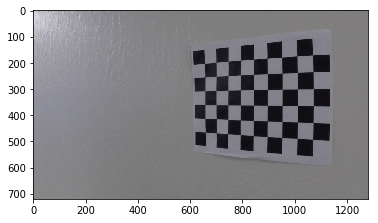

In [2]:
calibration_dir = "camera_calib"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"
cal_imgs_paths = glob2.glob(calibration_dir + "/*.jpg")
cal_img_path = cal_imgs_paths[1]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)
nx, ny = 9, 6

### Calibrating Camera

In [3]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)

def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

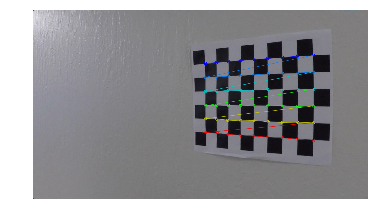

In [4]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), nx, ny)
showChessboardCorners(cal_img, nx, ny, ret, corners)

In [5]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [6]:
opts, ipts = findImgObjPoints(cal_imgs_paths, nx, ny)

###  Correcting Distortion in Image

In [7]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

###  Testing Distortion correction algorithm on raw image

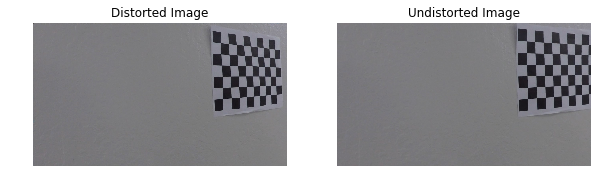

In [8]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

###  Importing images through glob  

In [9]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [10]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [11]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [12]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

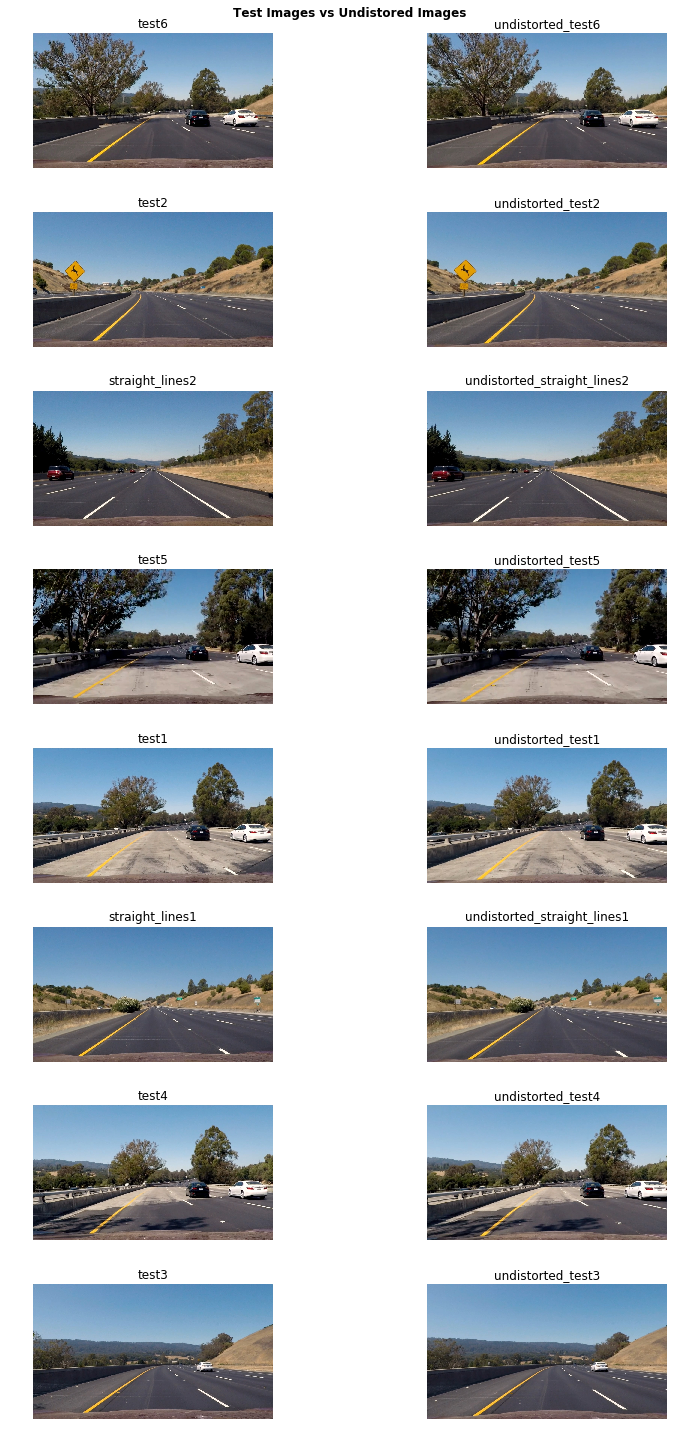

In [13]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

### Thresholding Images

In [14]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch


test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

### Color Thresholding

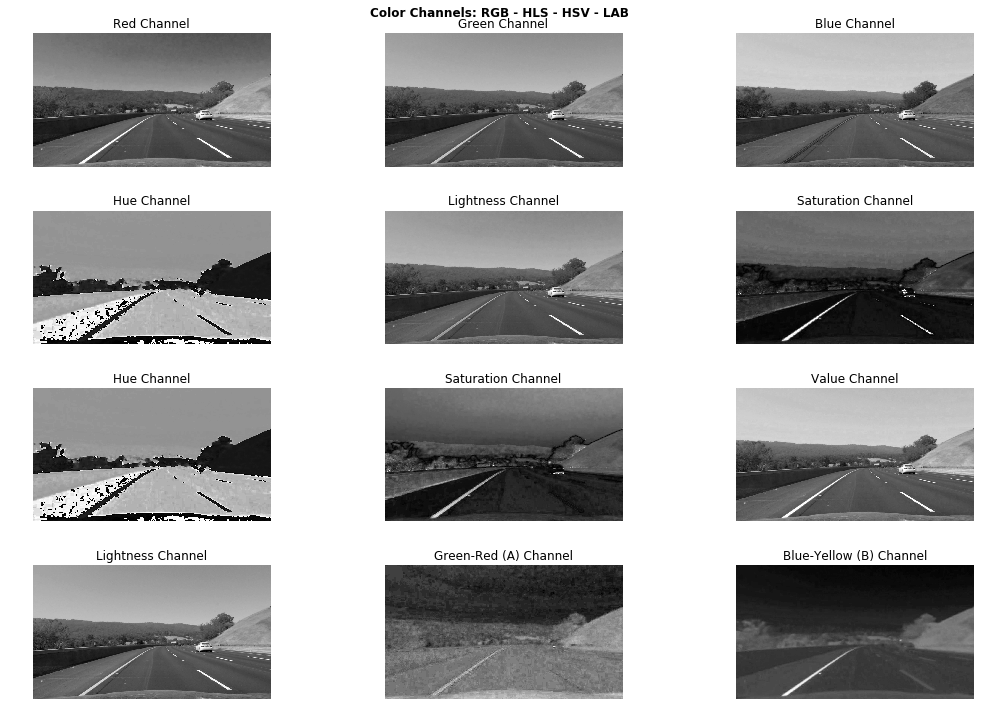

In [15]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])


color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))


show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

In [16]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

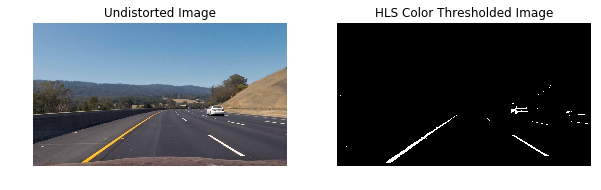

In [17]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

### Gradient Thresholding using sobel

In [18]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

In [19]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

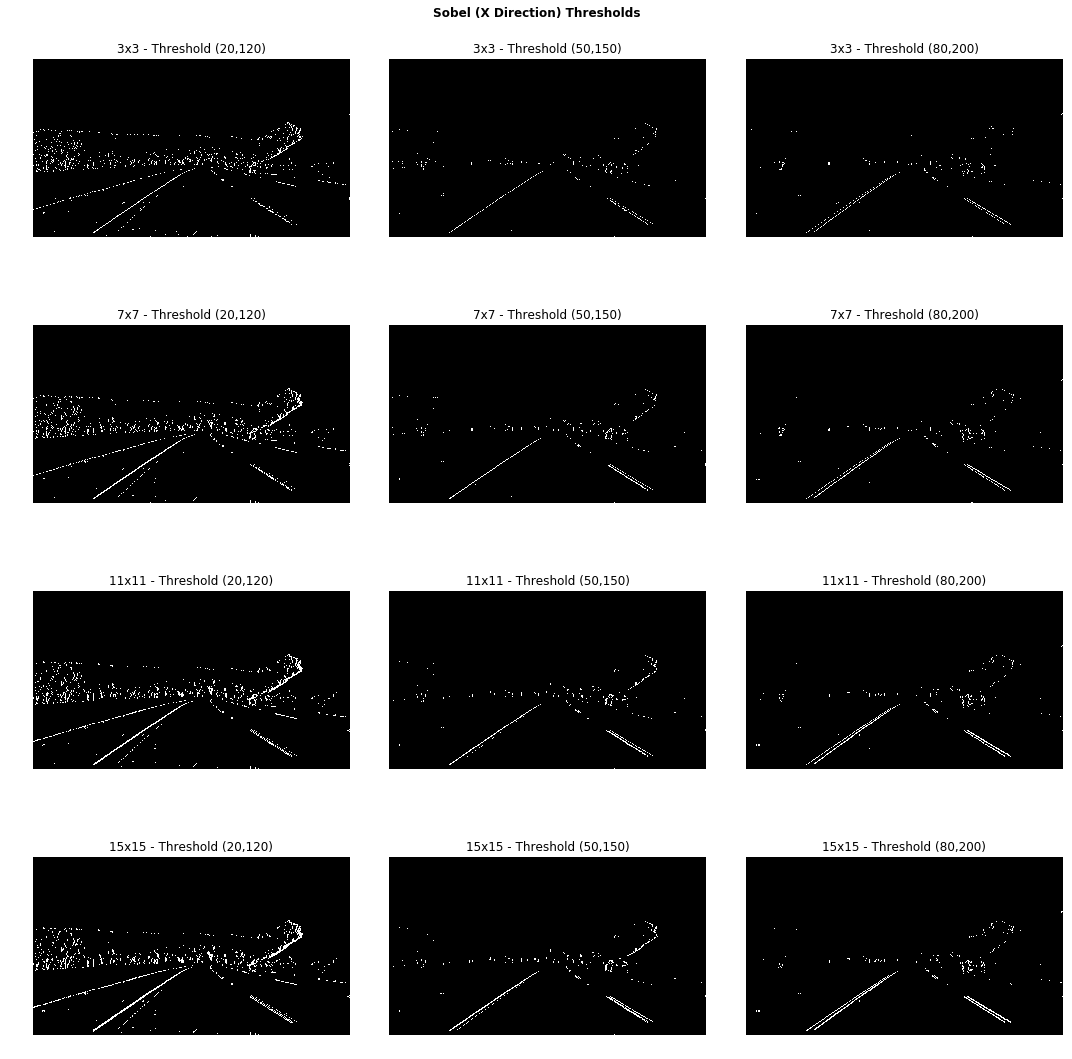

In [20]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])

sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

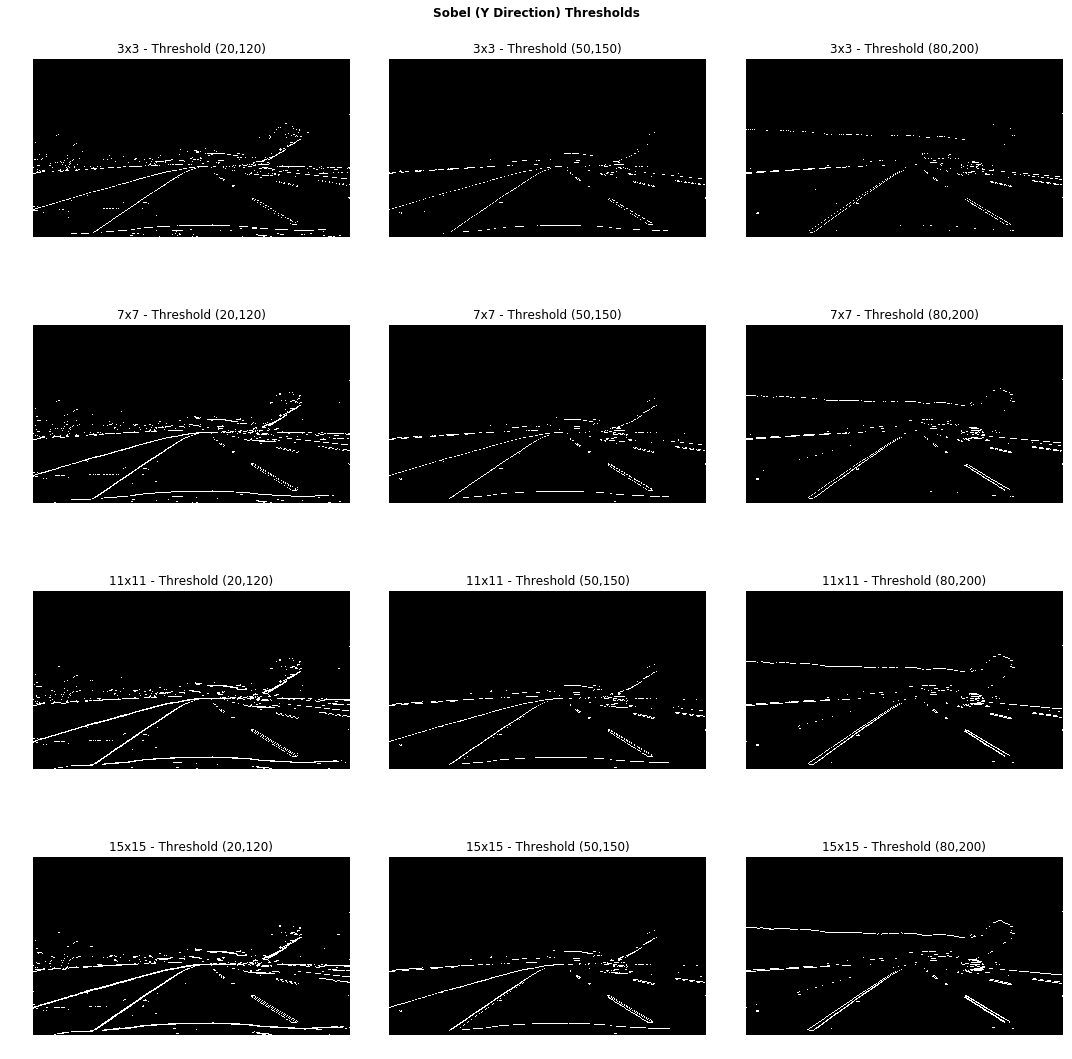

In [21]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])

soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In [22]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))



#### Sobel Magnitude in X and Y direction

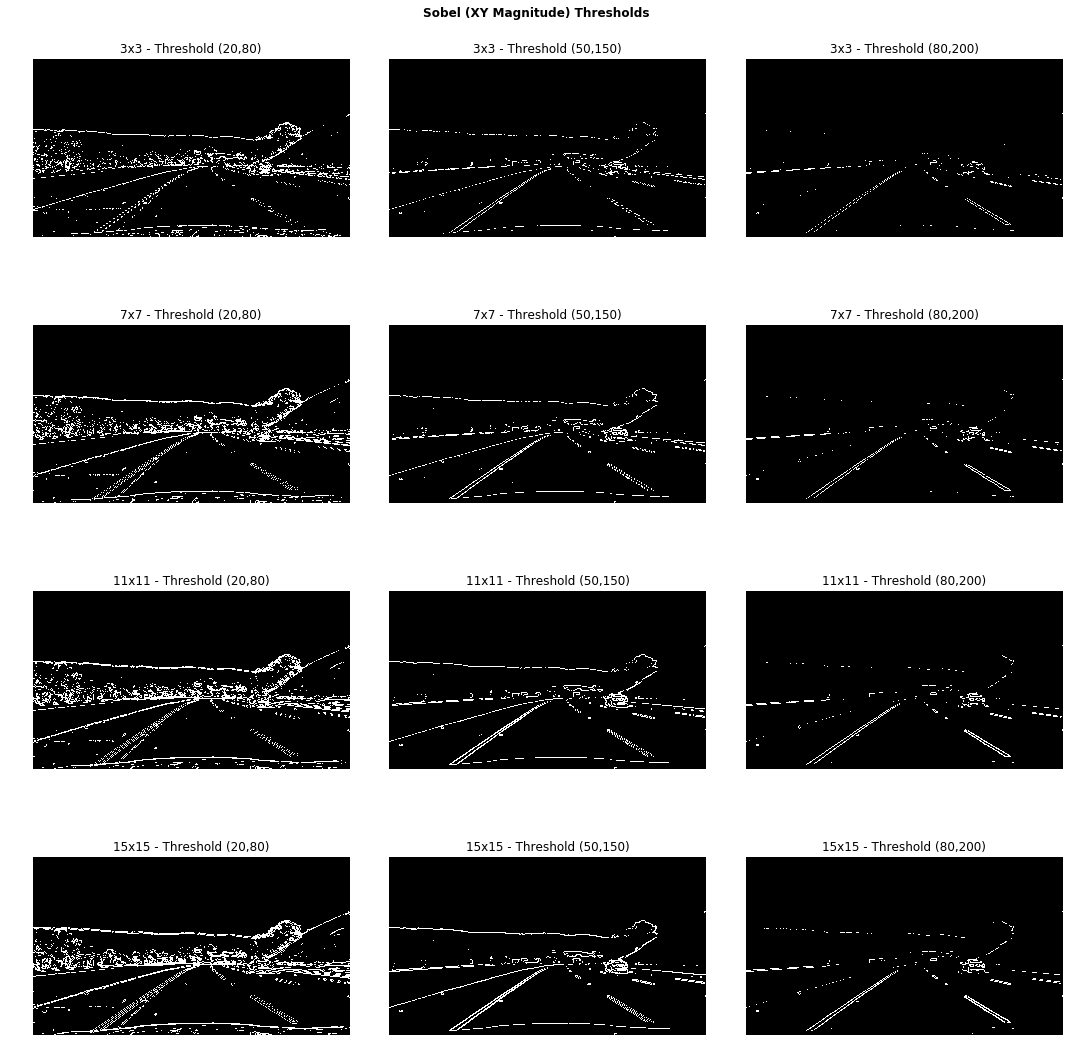

In [23]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

#### Sobel with gradient Detection

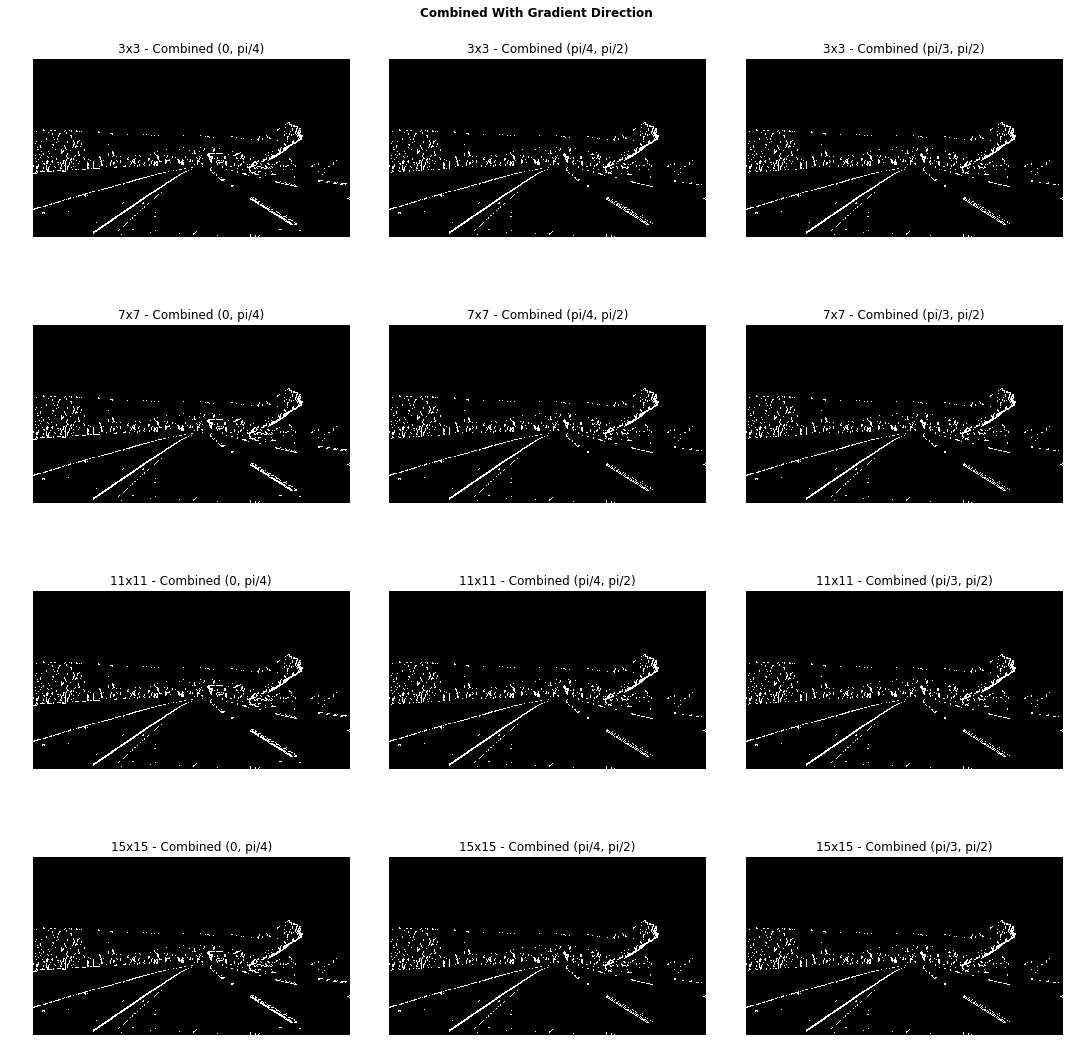

In [24]:
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)


### Color and Gradient Thresholds

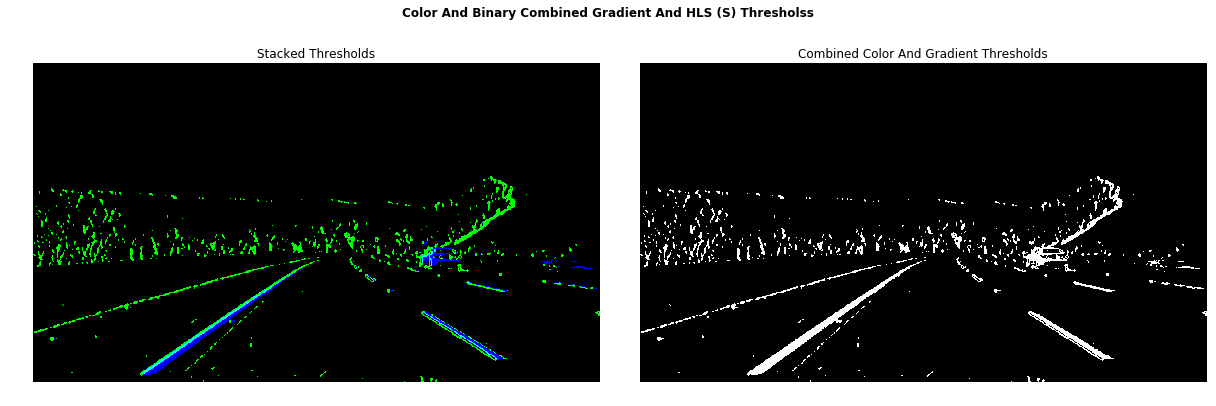

In [25]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))

color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

### Perspective Tranform

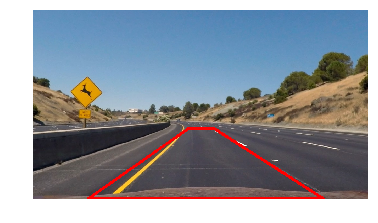

In [26]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

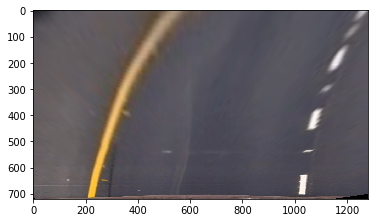

In [27]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped


src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)
plt.imshow(test_img_persp_tr)

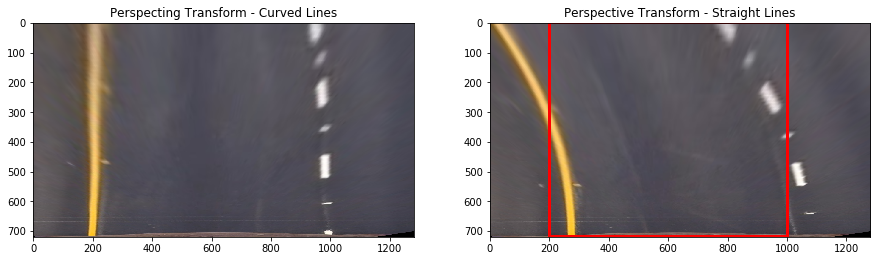

In [28]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs)))
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

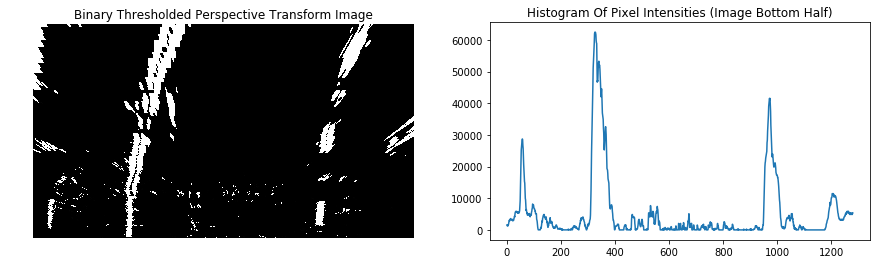

In [29]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

img_example =mpim.imread('warped-example.jpg')
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

## Pipeline Definition

In [30]:
import math
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)


In [31]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [32]:
class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly

In [33]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=30793.176352512324
Left Curvature   Right Curvature  Center Alignment 
561.0185m        600.9638m        0.1261m Right    


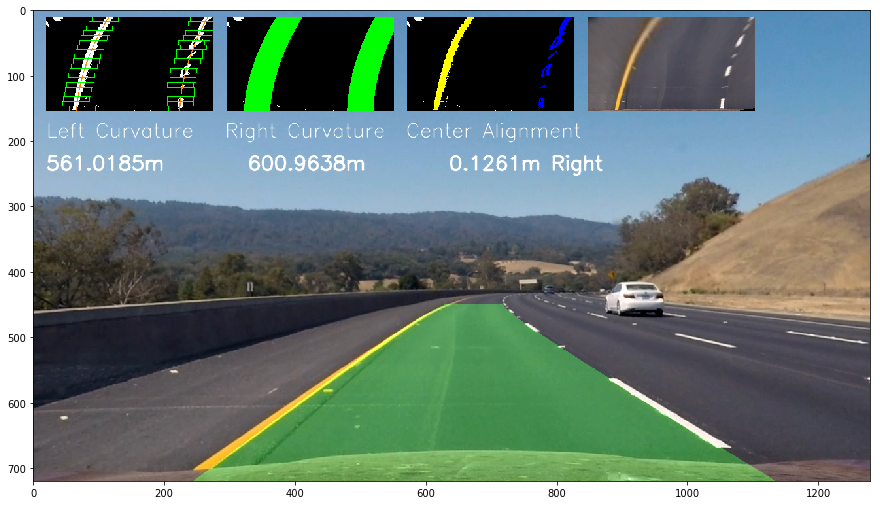

In [34]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)
proc_img = ld.process_image(test_img)
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

### Implementing on Normal Video

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [36]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image)#NOTE: this function expects color images!!

%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=14795.34371395617
Left Curvature   Right Curvature  Center Alignment 
1483.9492m       3167.8192m       0.0996m Right    
[MoviePy] >>>> Building video output_videos/lanes_project_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_project_video_sample.mp4


  1%|          | 1/125 [00:01<02:47,  1.35s/it]

[Previous lane] Found pct=0.9068997131280868
Left Curvature   Right Curvature  Center Alignment 
1334.0390m       3362.2641m       0.1016m Right    


  2%|▏         | 2/125 [00:02<02:48,  1.37s/it]

[Previous lane] Found pct=0.9083784343299914
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3434.1070m       0.1023m Right    


  2%|▏         | 3/125 [00:04<02:46,  1.36s/it]

[Previous lane] Found pct=0.9087037529944104
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3450.3450m       0.1024m Right    


  3%|▎         | 4/125 [00:05<02:44,  1.36s/it]

[Previous lane] Found pct=0.9087924762665247
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3452.4203m       0.1024m Right    


  4%|▍         | 5/125 [00:06<02:42,  1.36s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  5%|▍         | 6/125 [00:08<02:41,  1.36s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  6%|▌         | 7/125 [00:09<02:40,  1.36s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  6%|▋         | 8/125 [00:10<02:38,  1.36s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  7%|▋         | 9/125 [00:12<02:37,  1.35s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  8%|▊         | 10/125 [00:13<02:35,  1.35s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  9%|▉         | 11/125 [00:14<02:33,  1.35s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 10%|▉         | 12/125 [00:16<02:32,  1.35s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 10%|█         | 13/125 [00:17<02:30,  1.35s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 11%|█         | 14/125 [00:18<02:29,  1.34s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 12%|█▏        | 15/125 [00:20<02:27,  1.34s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 13%|█▎        | 16/125 [00:21<02:27,  1.35s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 14%|█▎        | 17/125 [00:23<02:25,  1.35s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 14%|█▍        | 18/125 [00:24<02:23,  1.34s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 15%|█▌        | 19/125 [00:25<02:21,  1.34s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 16%|█▌        | 20/125 [00:27<02:20,  1.34s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 17%|█▋        | 21/125 [00:28<02:19,  1.34s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 18%|█▊        | 22/125 [00:29<02:19,  1.35s/it]

[Previous lane] Found pct=0.8832364341085271
Left Curvature   Right Curvature  Center Alignment 
1149.7512m       2897.5190m       0.1011m Right    


 18%|█▊        | 23/125 [00:31<02:19,  1.37s/it]

[Previous lane] Found pct=0.8899844317592112
Left Curvature   Right Curvature  Center Alignment 
1157.2473m       3070.2735m       0.1040m Right    


 19%|█▉        | 24/125 [00:32<02:19,  1.38s/it]

[Previous lane] Found pct=0.8843622297782076
Left Curvature   Right Curvature  Center Alignment 
1017.3340m       3296.8939m       0.1145m Right    


 20%|██        | 25/125 [00:33<02:19,  1.40s/it]

[Previous lane] Found pct=0.8707462282660172
Left Curvature   Right Curvature  Center Alignment 
822.0724m        3804.0468m       0.1178m Right    


 21%|██        | 26/125 [00:35<02:18,  1.40s/it]

[Previous lane] Found pct=0.8607495069033531
Left Curvature   Right Curvature  Center Alignment 
838.8134m        2547.9376m       0.1322m Right    


 22%|██▏       | 27/125 [00:36<02:16,  1.39s/it]

[Previous lane] Found pct=0.8932377318773845
Left Curvature   Right Curvature  Center Alignment 
1252.6015m       2891.3311m       0.1801m Right    


 22%|██▏       | 28/125 [00:38<02:13,  1.38s/it]

[Previous lane] Found pct=0.8915845070422536
Left Curvature   Right Curvature  Center Alignment 
1374.2549m       969.9903m        0.2087m Right    


 23%|██▎       | 29/125 [00:39<02:11,  1.37s/it]

[Previous lane] Found pct=0.8937569213732004
Left Curvature   Right Curvature  Center Alignment 
1687.2785m       780.3359m        0.2120m Right    


 24%|██▍       | 30/125 [00:40<02:09,  1.36s/it]

[Previous lane] Found pct=0.882543338209206
Left Curvature   Right Curvature  Center Alignment 
2532.7438m       842.2084m        0.2112m Right    


 25%|██▍       | 31/125 [00:42<02:08,  1.37s/it]

[Previous lane] Found pct=0.9045380976095617
Left Curvature   Right Curvature  Center Alignment 
3401.9205m       751.7638m        0.2190m Right    


 26%|██▌       | 32/125 [00:43<02:07,  1.38s/it]

[Previous lane] Found pct=0.8900149031296573
Left Curvature   Right Curvature  Center Alignment 
1797.0402m       841.9135m        0.1939m Right    


 26%|██▋       | 33/125 [00:44<02:06,  1.38s/it]

[Previous lane] Found pct=0.8914582506285563
Left Curvature   Right Curvature  Center Alignment 
1051.2119m       845.6215m        0.1658m Right    


 27%|██▋       | 34/125 [00:46<02:04,  1.37s/it]

[Previous lane] Found pct=0.9059175047369188
Left Curvature   Right Curvature  Center Alignment 
639.3996m        837.3837m        0.1376m Right    


 28%|██▊       | 35/125 [00:47<02:03,  1.37s/it]

[Previous lane] Found pct=0.9037276809021614
Left Curvature   Right Curvature  Center Alignment 
748.8109m        813.7042m        0.1303m Right    


 29%|██▉       | 36/125 [00:49<02:01,  1.37s/it]

[Previous lane] Found pct=0.8949238943136129
Left Curvature   Right Curvature  Center Alignment 
708.0181m        772.7521m        0.1379m Right    


 30%|██▉       | 37/125 [00:50<02:00,  1.37s/it]

[Previous lane] Found pct=0.9046292705285055
Left Curvature   Right Curvature  Center Alignment 
584.1126m        700.2371m        0.1272m Right    


 30%|███       | 38/125 [00:51<01:59,  1.37s/it]

[Previous lane] Found pct=0.888262910798122
Left Curvature   Right Curvature  Center Alignment 
487.3217m        937.5727m        0.1179m Right    


 31%|███       | 39/125 [00:53<01:58,  1.37s/it]

[Previous lane] Found pct=0.8909309129097592
Left Curvature   Right Curvature  Center Alignment 
560.2790m        1701.5025m       0.1010m Right    


 32%|███▏      | 40/125 [00:54<01:56,  1.37s/it]

[Previous lane] Found pct=0.907345513963161
Left Curvature   Right Curvature  Center Alignment 
627.6276m        419.2128m        0.1733m Right    


 33%|███▎      | 41/125 [00:55<01:55,  1.37s/it]

[Previous lane] Found pct=0.903732955815513
Left Curvature   Right Curvature  Center Alignment 
500.8447m        393.5300m        0.1525m Right    


 34%|███▎      | 42/125 [00:57<01:54,  1.38s/it]

[Previous lane] Found pct=0.8735130251468153
Left Curvature   Right Curvature  Center Alignment 
429.7437m        339.9272m        0.1395m Right    


 34%|███▍      | 43/125 [00:58<02:00,  1.47s/it]

[Previous lane] Found pct=0.8303219031755803
Non zeros found below thresholds, begining sliding window - pct=0.8303219031755803
[Sliding windows] Found pct=11615.006662562913
Left Curvature   Right Curvature  Center Alignment 
408.1198m        6439.7173m       0.0421m Right    


 35%|███▌      | 44/125 [01:00<01:57,  1.45s/it]

[Previous lane] Found pct=0.8433609586338033
Non zeros found below thresholds, begining sliding window - pct=0.8433609586338033
[Sliding windows] Found pct=11656.088293330464
Left Curvature   Right Curvature  Center Alignment 
4423.5157m       5454.0140m       0.0555m Right    


 36%|███▌      | 45/125 [01:01<01:54,  1.43s/it]

[Previous lane] Found pct=0.9050036258158085
Left Curvature   Right Curvature  Center Alignment 
2507.5853m       2731.0525m       0.0577m Right    


 37%|███▋      | 46/125 [01:03<01:52,  1.42s/it]

[Previous lane] Found pct=0.8763664757938574
Left Curvature   Right Curvature  Center Alignment 
2651.3825m       2527.6096m       0.0582m Right    


 38%|███▊      | 47/125 [01:04<01:50,  1.41s/it]

[Previous lane] Found pct=0.8946036566078319
Left Curvature   Right Curvature  Center Alignment 
4076.9189m       1963.6747m       0.0648m Right    


 38%|███▊      | 48/125 [01:05<01:48,  1.41s/it]

[Previous lane] Found pct=0.8846072983931521
Left Curvature   Right Curvature  Center Alignment 
3614.5080m       1495.6407m       0.0595m Right    


 39%|███▉      | 49/125 [01:07<01:46,  1.40s/it]

[Previous lane] Found pct=0.8618177834980968
Left Curvature   Right Curvature  Center Alignment 
3662.7418m       977.6529m        0.0647m Right    


 40%|████      | 50/125 [01:08<01:44,  1.39s/it]

[Previous lane] Found pct=0.9050269458432724
Left Curvature   Right Curvature  Center Alignment 
5643.8238m       621.4254m        0.0990m Right    


 41%|████      | 51/125 [01:10<01:42,  1.38s/it]

[Previous lane] Found pct=0.8600787760242223
Left Curvature   Right Curvature  Center Alignment 
3367.7980m       520.4900m        0.1300m Right    


 42%|████▏     | 52/125 [01:11<01:45,  1.44s/it]

[Previous lane] Found pct=0.9002551930411876
Left Curvature   Right Curvature  Center Alignment 
4879.8788m       460.7488m        0.1506m Right    


 42%|████▏     | 53/125 [01:13<01:45,  1.47s/it]

[Previous lane] Found pct=0.8979374509584127
Left Curvature   Right Curvature  Center Alignment 
16100.5500m      431.0253m        0.1463m Right    


 43%|████▎     | 54/125 [01:14<01:41,  1.44s/it]

[Previous lane] Found pct=0.8948507139766335
Left Curvature   Right Curvature  Center Alignment 
1420.9343m       368.0198m        0.1586m Right    


 44%|████▍     | 55/125 [01:15<01:39,  1.42s/it]

[Previous lane] Found pct=0.8472069496371234
Non zeros found below thresholds, begining sliding window - pct=0.8472069496371234
[Sliding windows] Found pct=16477.126264570044
Left Curvature   Right Curvature  Center Alignment 
686.8538m        527.3549m        0.1130m Right    


 45%|████▍     | 56/125 [01:17<01:37,  1.41s/it]

[Previous lane] Found pct=0.9163761137860424
Left Curvature   Right Curvature  Center Alignment 
612.5613m        448.8446m        0.0981m Right    


 46%|████▌     | 57/125 [01:18<01:35,  1.40s/it]

[Previous lane] Found pct=0.9539759438690277
Left Curvature   Right Curvature  Center Alignment 
528.5098m        388.7999m        0.0837m Right    


 46%|████▋     | 58/125 [01:20<01:33,  1.40s/it]

[Previous lane] Found pct=0.9187385669749826
Left Curvature   Right Curvature  Center Alignment 
526.7391m        425.6071m        0.0608m Right    


 47%|████▋     | 59/125 [01:21<01:31,  1.39s/it]

[Previous lane] Found pct=0.9170088341420928
Left Curvature   Right Curvature  Center Alignment 
535.9572m        423.5990m        0.0442m Right    


 48%|████▊     | 60/125 [01:22<01:30,  1.39s/it]

[Previous lane] Found pct=0.914096323655309
Left Curvature   Right Curvature  Center Alignment 
521.4135m        419.9876m        0.0308m Right    


 49%|████▉     | 61/125 [01:24<01:28,  1.38s/it]

[Previous lane] Found pct=0.9137358672119317
Left Curvature   Right Curvature  Center Alignment 
519.9188m        439.6787m        0.0114m Right    


 50%|████▉     | 62/125 [01:25<01:27,  1.38s/it]

[Previous lane] Found pct=0.9042928039702234
Left Curvature   Right Curvature  Center Alignment 
411.8401m        531.1996m        0.0141m Left     


 50%|█████     | 63/125 [01:26<01:25,  1.38s/it]

[Previous lane] Found pct=0.9059149722735674
Left Curvature   Right Curvature  Center Alignment 
339.8446m        745.1405m        0.0659m Left     


 51%|█████     | 64/125 [01:28<01:26,  1.42s/it]

[Previous lane] Found pct=0.9207345206237889
Left Curvature   Right Curvature  Center Alignment 
327.1854m        765.0124m        0.0845m Left     


 52%|█████▏    | 65/125 [01:29<01:25,  1.43s/it]

[Previous lane] Found pct=0.9198089101210977
Left Curvature   Right Curvature  Center Alignment 
330.9910m        849.5502m        0.0948m Left     


 53%|█████▎    | 66/125 [01:31<01:25,  1.45s/it]

[Previous lane] Found pct=0.9244865515167139
Left Curvature   Right Curvature  Center Alignment 
333.4914m        654.0331m        0.0878m Left     


 54%|█████▎    | 67/125 [01:32<01:24,  1.45s/it]

[Previous lane] Found pct=0.911653127706074
Left Curvature   Right Curvature  Center Alignment 
324.6065m        525.1932m        0.0800m Left     


 54%|█████▍    | 68/125 [01:34<01:24,  1.48s/it]

[Previous lane] Found pct=0.9332186325113108
Left Curvature   Right Curvature  Center Alignment 
329.9357m        531.3374m        0.0839m Left     


 55%|█████▌    | 69/125 [01:35<01:22,  1.47s/it]

[Previous lane] Found pct=0.8983169398907104
Left Curvature   Right Curvature  Center Alignment 
328.5858m        469.6804m        0.0855m Left     


 56%|█████▌    | 70/125 [01:37<01:20,  1.47s/it]

[Previous lane] Found pct=0.9425003224280986
Left Curvature   Right Curvature  Center Alignment 
320.5953m        487.0053m        0.0846m Left     


 57%|█████▋    | 71/125 [01:38<01:18,  1.46s/it]

[Previous lane] Found pct=0.9472563161668565
Left Curvature   Right Curvature  Center Alignment 
320.4415m        459.3909m        0.0838m Left     


 58%|█████▊    | 72/125 [01:40<01:18,  1.48s/it]

[Previous lane] Found pct=0.9685166082112647
Left Curvature   Right Curvature  Center Alignment 
346.4888m        532.8559m        0.0868m Left     


 58%|█████▊    | 73/125 [01:41<01:16,  1.47s/it]

[Previous lane] Found pct=0.9629396325459317
Left Curvature   Right Curvature  Center Alignment 
365.0611m        567.4091m        0.0782m Left     


 59%|█████▉    | 74/125 [01:43<01:15,  1.49s/it]

[Previous lane] Found pct=0.9638652714192283
Left Curvature   Right Curvature  Center Alignment 
372.6553m        604.5288m        0.0765m Left     


 60%|██████    | 75/125 [01:44<01:13,  1.48s/it]

[Previous lane] Found pct=0.7355895718727578
Non zeros found below thresholds, begining sliding window - pct=0.7355895718727578
[Sliding windows] Found pct=23118.829725743442
Left Curvature   Right Curvature  Center Alignment 
317.9657m        423.6703m        0.0434m Left     


 61%|██████    | 76/125 [01:46<01:13,  1.49s/it]

[Previous lane] Found pct=0.860508550417307
Left Curvature   Right Curvature  Center Alignment 
321.2357m        425.9257m        0.0306m Left     


 62%|██████▏   | 77/125 [01:47<01:10,  1.48s/it]

[Previous lane] Found pct=0.8790540924323608
Left Curvature   Right Curvature  Center Alignment 
318.9421m        412.7727m        0.0211m Left     


 62%|██████▏   | 78/125 [01:49<01:09,  1.48s/it]

[Previous lane] Found pct=0.8446887141097318
Non zeros found below thresholds, begining sliding window - pct=0.8446887141097318
[Sliding windows] Found pct=23391.266312896805
Left Curvature   Right Curvature  Center Alignment 
339.3174m        342.3656m        0.0077m Right    


 63%|██████▎   | 79/125 [01:50<01:07,  1.48s/it]

[Previous lane] Found pct=0.8194437169346812
Non zeros found below thresholds, begining sliding window - pct=0.8194437169346812
[Sliding windows] Found pct=25263.55422275767
Left Curvature   Right Curvature  Center Alignment 
381.3433m        319.6393m        0.0546m Right    


 64%|██████▍   | 80/125 [01:52<01:06,  1.48s/it]

[Previous lane] Found pct=0.794159217663687
Non zeros found below thresholds, begining sliding window - pct=0.794159217663687
[Sliding windows] Found pct=25049.86710214684
Left Curvature   Right Curvature  Center Alignment 
462.8209m        426.1410m        0.0382m Right    


 65%|██████▍   | 81/125 [01:53<01:04,  1.47s/it]

[Previous lane] Found pct=0.8971825294787495
Left Curvature   Right Curvature  Center Alignment 
523.4961m        599.0076m        0.0007m Right    


 66%|██████▌   | 82/125 [01:55<01:03,  1.48s/it]

[Previous lane] Found pct=0.9197884369870509
Left Curvature   Right Curvature  Center Alignment 
549.8394m        787.3950m        0.0125m Left     


 66%|██████▋   | 83/125 [01:56<01:01,  1.47s/it]

[Previous lane] Found pct=0.9859771969058181
Left Curvature   Right Curvature  Center Alignment 
665.4142m        804.2296m        0.0238m Left     


 67%|██████▋   | 84/125 [01:58<01:00,  1.47s/it]

[Previous lane] Found pct=0.9659173313995649
Left Curvature   Right Curvature  Center Alignment 
623.8342m        483.9522m        0.0037m Right    


 68%|██████▊   | 85/125 [01:59<00:58,  1.46s/it]

[Previous lane] Found pct=0.8701050117655322
Left Curvature   Right Curvature  Center Alignment 
725.9799m        459.4501m        0.0120m Left     


 69%|██████▉   | 86/125 [02:00<00:57,  1.47s/it]

[Previous lane] Found pct=0.7690408486437705
Non zeros found below thresholds, begining sliding window - pct=0.7690408486437705
[Sliding windows] Found pct=26897.838512489572
Left Curvature   Right Curvature  Center Alignment 
568.5602m        379.0922m        0.0108m Right    


 70%|██████▉   | 87/125 [02:02<00:55,  1.47s/it]

[Previous lane] Found pct=0.7958306665447563
Non zeros found below thresholds, begining sliding window - pct=0.7958306665447563
[Sliding windows] Found pct=24808.483971838712
Left Curvature   Right Curvature  Center Alignment 
515.7574m        312.4867m        0.0269m Right    


 70%|███████   | 88/125 [02:03<00:54,  1.47s/it]

[Previous lane] Found pct=0.8873579846164703
Left Curvature   Right Curvature  Center Alignment 
574.7398m        325.4821m        0.0302m Right    


 71%|███████   | 89/125 [02:05<00:52,  1.46s/it]

[Previous lane] Found pct=0.9223616262355593
Left Curvature   Right Curvature  Center Alignment 
594.7631m        348.1265m        0.0427m Right    


 72%|███████▏  | 90/125 [02:06<00:51,  1.47s/it]

[Previous lane] Found pct=0.8701596928848143
Left Curvature   Right Curvature  Center Alignment 
624.3020m        411.3457m        0.0511m Right    


 73%|███████▎  | 91/125 [02:08<00:49,  1.46s/it]

[Previous lane] Found pct=0.8029803552206674
Non zeros found below thresholds, begining sliding window - pct=0.8029803552206674
[Sliding windows] Found pct=28188.93141146394
Left Curvature   Right Curvature  Center Alignment 
1134.2656m       563.3854m        0.0471m Right    


 74%|███████▎  | 92/125 [02:09<00:48,  1.48s/it]

[Previous lane] Found pct=0.9898952598361757
Left Curvature   Right Curvature  Center Alignment 
1301.4031m       771.6422m        0.0230m Right    


 74%|███████▍  | 93/125 [02:11<00:46,  1.46s/it]

[Previous lane] Found pct=0.9822516821665304
Left Curvature   Right Curvature  Center Alignment 
1208.2982m       577.1799m        0.0596m Right    


 75%|███████▌  | 94/125 [02:12<00:45,  1.47s/it]

[Previous lane] Found pct=0.9667128747184197
Left Curvature   Right Curvature  Center Alignment 
1040.3147m       457.6363m        0.0857m Right    


 76%|███████▌  | 95/125 [02:14<00:43,  1.47s/it]

[Previous lane] Found pct=0.9855673268846922
Left Curvature   Right Curvature  Center Alignment 
833.9617m        440.0757m        0.1023m Right    


 77%|███████▋  | 96/125 [02:15<00:42,  1.47s/it]

[Previous lane] Found pct=0.9736533445372267
Left Curvature   Right Curvature  Center Alignment 
689.9668m        467.7063m        0.1051m Right    


 78%|███████▊  | 97/125 [02:17<00:41,  1.47s/it]

[Previous lane] Found pct=0.9841869041820333
Left Curvature   Right Curvature  Center Alignment 
630.4589m        511.5680m        0.1051m Right    


 78%|███████▊  | 98/125 [02:18<00:39,  1.47s/it]

[Previous lane] Found pct=0.9840439978272678
Left Curvature   Right Curvature  Center Alignment 
656.3829m        519.1151m        0.1095m Right    


 79%|███████▉  | 99/125 [02:20<00:38,  1.46s/it]

[Previous lane] Found pct=0.9517352069310011
Left Curvature   Right Curvature  Center Alignment 
639.9547m        531.4155m        0.1123m Right    


 80%|████████  | 100/125 [02:21<00:36,  1.47s/it]

[Previous lane] Found pct=0.949114480473976
Left Curvature   Right Curvature  Center Alignment 
630.1568m        591.0743m        0.1158m Right    


 81%|████████  | 101/125 [02:22<00:34,  1.45s/it]

[Previous lane] Found pct=0.9303854522847373
Left Curvature   Right Curvature  Center Alignment 
604.7914m        552.5851m        0.1255m Right    


 82%|████████▏ | 102/125 [02:24<00:33,  1.46s/it]

[Previous lane] Found pct=0.9048386601578091
Left Curvature   Right Curvature  Center Alignment 
585.8979m        553.3466m        0.1281m Right    


 82%|████████▏ | 103/125 [02:25<00:32,  1.46s/it]

[Previous lane] Found pct=0.8884206025623406
Left Curvature   Right Curvature  Center Alignment 
539.2477m        527.1873m        0.1343m Right    


 83%|████████▎ | 104/125 [02:27<00:30,  1.47s/it]

[Previous lane] Found pct=0.8662254857522739
Left Curvature   Right Curvature  Center Alignment 
526.9115m        531.0388m        0.1363m Right    


 84%|████████▍ | 105/125 [02:28<00:29,  1.46s/it]

[Previous lane] Found pct=0.8255659880034765
Non zeros found below thresholds, begining sliding window - pct=0.8255659880034765
[Sliding windows] Found pct=31862.7748728397
Left Curvature   Right Curvature  Center Alignment 
505.0444m        522.4347m        0.1604m Right    


 85%|████████▍ | 106/125 [02:30<00:27,  1.47s/it]

[Previous lane] Found pct=0.8338078139082417
Non zeros found below thresholds, begining sliding window - pct=0.8338078139082417
[Sliding windows] Found pct=31767.919672107695
Left Curvature   Right Curvature  Center Alignment 
519.3268m        543.6238m        0.1596m Right    


 86%|████████▌ | 107/125 [02:31<00:27,  1.52s/it]

[Previous lane] Found pct=0.8251104720488182
Non zeros found below thresholds, begining sliding window - pct=0.8251104720488182
[Sliding windows] Found pct=32000.02083187206
Left Curvature   Right Curvature  Center Alignment 
505.3050m        549.2110m        0.1661m Right    


 86%|████████▋ | 108/125 [02:33<00:27,  1.60s/it]

[Previous lane] Found pct=0.7885544769571454
Non zeros found below thresholds, begining sliding window - pct=0.7885544769571454
[Sliding windows] Found pct=32025.60560437877
Left Curvature   Right Curvature  Center Alignment 
468.5516m        574.7319m        0.1598m Right    


 87%|████████▋ | 109/125 [02:35<00:24,  1.56s/it]

[Previous lane] Found pct=0.8366845429971523
Non zeros found below thresholds, begining sliding window - pct=0.8366845429971523
[Sliding windows] Found pct=31370.293167001546
Left Curvature   Right Curvature  Center Alignment 
491.8708m        589.8181m        0.1576m Right    


 88%|████████▊ | 110/125 [02:36<00:23,  1.54s/it]

[Previous lane] Found pct=0.8296319260470097
Non zeros found below thresholds, begining sliding window - pct=0.8296319260470097
[Sliding windows] Found pct=32148.96894199876
Left Curvature   Right Curvature  Center Alignment 
500.3726m        623.2730m        0.1553m Right    


 89%|████████▉ | 111/125 [02:38<00:21,  1.51s/it]

[Previous lane] Found pct=0.8856477306883078
Left Curvature   Right Curvature  Center Alignment 
532.2194m        688.6664m        0.1433m Right    


 90%|████████▉ | 112/125 [02:39<00:19,  1.50s/it]

[Previous lane] Found pct=0.9272643663579856
Left Curvature   Right Curvature  Center Alignment 
546.3539m        735.3818m        0.1443m Right    


 90%|█████████ | 113/125 [02:41<00:17,  1.49s/it]

[Previous lane] Found pct=0.9380771925355073
Left Curvature   Right Curvature  Center Alignment 
557.0269m        736.7350m        0.1445m Right    


 91%|█████████ | 114/125 [02:42<00:16,  1.50s/it]

[Previous lane] Found pct=0.954397178387508
Left Curvature   Right Curvature  Center Alignment 
584.7211m        685.8948m        0.1467m Right    


 92%|█████████▏| 115/125 [02:44<00:14,  1.47s/it]

[Previous lane] Found pct=0.9236266477812294
Left Curvature   Right Curvature  Center Alignment 
573.0103m        580.9938m        0.1587m Right    


 93%|█████████▎| 116/125 [02:45<00:13,  1.48s/it]

[Previous lane] Found pct=0.9010106082480698
Left Curvature   Right Curvature  Center Alignment 
605.9520m        479.6485m        0.1711m Right    


 94%|█████████▎| 117/125 [02:46<00:11,  1.47s/it]

[Previous lane] Found pct=0.876715708954073
Left Curvature   Right Curvature  Center Alignment 
608.7438m        456.1224m        0.1870m Right    


 94%|█████████▍| 118/125 [02:48<00:10,  1.47s/it]

[Previous lane] Found pct=0.9161747532434291
Left Curvature   Right Curvature  Center Alignment 
630.3461m        489.5009m        0.1831m Right    


 95%|█████████▌| 119/125 [02:49<00:08,  1.46s/it]

[Previous lane] Found pct=0.9327345660268807
Left Curvature   Right Curvature  Center Alignment 
690.5724m        495.1501m        0.1831m Right    


 96%|█████████▌| 120/125 [02:51<00:07,  1.47s/it]

[Previous lane] Found pct=0.9506577362309063
Left Curvature   Right Curvature  Center Alignment 
716.2989m        484.7492m        0.1836m Right    


 97%|█████████▋| 121/125 [02:52<00:05,  1.46s/it]

[Previous lane] Found pct=0.9489639849950896
Left Curvature   Right Curvature  Center Alignment 
753.2958m        507.1654m        0.1824m Right    


 98%|█████████▊| 122/125 [02:54<00:04,  1.47s/it]

[Previous lane] Found pct=0.9295776928557549
Left Curvature   Right Curvature  Center Alignment 
772.4849m        556.1178m        0.1687m Right    


 98%|█████████▊| 123/125 [02:56<00:03,  1.55s/it]

[Previous lane] Found pct=0.9450199840127897
Left Curvature   Right Curvature  Center Alignment 
845.3178m        590.6289m        0.1653m Right    


 99%|█████████▉| 124/125 [02:57<00:01,  1.52s/it]

[Previous lane] Found pct=0.9683263968978255
Left Curvature   Right Curvature  Center Alignment 
853.2262m        648.4057m        0.1626m Right    


100%|██████████| 125/125 [02:58<00:00,  1.51s/it]

[Previous lane] Found pct=0.9508851901192559
Left Curvature   Right Curvature  Center Alignment 
844.5143m        624.2091m        0.1670m Right    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video_sample.mp4 

CPU times: user 2min 47s, sys: 275 ms, total: 2min 48s
Wall time: 3min 2s


In [37]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [38]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=29291.815393535726
Left Curvature   Right Curvature  Center Alignment 
472.3622m        659.5819m        0.3226m Right    
[MoviePy] >>>> Building video output_videos/lanes_project_video.mp4
[MoviePy] Writing video output_videos/lanes_project_video.mp4


  0%|          | 1/1261 [00:01<28:44,  1.37s/it]

[Previous lane] Found pct=0.942701674050727
Left Curvature   Right Curvature  Center Alignment 
445.9994m        1101.0637m       0.3525m Right    


  0%|          | 2/1261 [00:02<28:51,  1.38s/it]

[Previous lane] Found pct=0.9539217167900862
Left Curvature   Right Curvature  Center Alignment 
438.6838m        1131.3794m       0.3514m Right    


  0%|          | 3/1261 [00:04<28:50,  1.38s/it]

[Previous lane] Found pct=0.9543829890349549
Left Curvature   Right Curvature  Center Alignment 
460.9568m        993.1643m        0.3516m Right    


  0%|          | 4/1261 [00:05<28:50,  1.38s/it]

[Previous lane] Found pct=0.95334407980778
Left Curvature   Right Curvature  Center Alignment 
458.6836m        1034.5572m       0.3566m Right    


  0%|          | 5/1261 [00:06<28:47,  1.38s/it]

[Previous lane] Found pct=0.9554211849635195
Left Curvature   Right Curvature  Center Alignment 
439.5034m        1085.2745m       0.3581m Right    


  0%|          | 6/1261 [00:08<28:43,  1.37s/it]

[Previous lane] Found pct=0.9389242667259532
Left Curvature   Right Curvature  Center Alignment 
450.5923m        894.4166m        0.3596m Right    


  1%|          | 7/1261 [00:09<28:36,  1.37s/it]

[Previous lane] Found pct=0.9472196339171497
Left Curvature   Right Curvature  Center Alignment 
500.9687m        637.8124m        0.3591m Right    


  1%|          | 8/1261 [00:10<28:32,  1.37s/it]

[Previous lane] Found pct=0.9526980818705832
Left Curvature   Right Curvature  Center Alignment 
491.4743m        542.1667m        0.3479m Right    


  1%|          | 9/1261 [00:12<28:44,  1.38s/it]

[Previous lane] Found pct=0.9709230793190986
Left Curvature   Right Curvature  Center Alignment 
539.3599m        548.2603m        0.3613m Right    


  1%|          | 10/1261 [00:13<28:39,  1.37s/it]

[Previous lane] Found pct=0.9784477980648941
Left Curvature   Right Curvature  Center Alignment 
561.6465m        664.5695m        0.3784m Right    


  1%|          | 11/1261 [00:15<28:38,  1.38s/it]

[Previous lane] Found pct=0.973332489758474
Left Curvature   Right Curvature  Center Alignment 
603.7049m        793.4385m        0.3861m Right    


  1%|          | 12/1261 [00:16<28:40,  1.38s/it]

[Previous lane] Found pct=0.9503677050784333
Left Curvature   Right Curvature  Center Alignment 
628.7639m        722.1513m        0.3834m Right    


  1%|          | 13/1261 [00:17<28:37,  1.38s/it]

[Previous lane] Found pct=0.9659548562330242
Left Curvature   Right Curvature  Center Alignment 
728.3761m        858.9669m        0.3869m Right    


  1%|          | 14/1261 [00:19<28:29,  1.37s/it]

[Previous lane] Found pct=0.9676863555910593
Left Curvature   Right Curvature  Center Alignment 
743.8350m        832.6826m        0.3785m Right    


  1%|          | 15/1261 [00:20<28:28,  1.37s/it]

[Previous lane] Found pct=0.946371578709823
Left Curvature   Right Curvature  Center Alignment 
638.1211m        862.7854m        0.3630m Right    


  1%|▏         | 16/1261 [00:21<28:24,  1.37s/it]

[Previous lane] Found pct=0.9205276496198583
Left Curvature   Right Curvature  Center Alignment 
616.8164m        972.4597m        0.3544m Right    


  1%|▏         | 17/1261 [00:23<28:21,  1.37s/it]

[Previous lane] Found pct=0.9213866717953649
Left Curvature   Right Curvature  Center Alignment 
594.4243m        925.8121m        0.3450m Right    


  1%|▏         | 18/1261 [00:24<28:21,  1.37s/it]

[Previous lane] Found pct=0.9164791400216937
Left Curvature   Right Curvature  Center Alignment 
607.4978m        718.8225m        0.3333m Right    


  2%|▏         | 19/1261 [00:26<28:25,  1.37s/it]

[Previous lane] Found pct=0.949052792314177
Left Curvature   Right Curvature  Center Alignment 
673.9839m        484.8692m        0.3181m Right    


  2%|▏         | 20/1261 [00:27<28:19,  1.37s/it]

[Previous lane] Found pct=0.9686407028807975
Left Curvature   Right Curvature  Center Alignment 
703.5323m        401.3282m        0.2963m Right    


  2%|▏         | 21/1261 [00:28<28:20,  1.37s/it]

[Previous lane] Found pct=0.9493265548659712
Left Curvature   Right Curvature  Center Alignment 
750.1098m        361.5978m        0.2773m Right    


  2%|▏         | 22/1261 [00:30<28:20,  1.37s/it]

[Previous lane] Found pct=0.9354194517337558
Left Curvature   Right Curvature  Center Alignment 
685.8626m        343.2340m        0.2679m Right    


  2%|▏         | 23/1261 [00:31<28:13,  1.37s/it]

[Previous lane] Found pct=0.9349412573223811
Left Curvature   Right Curvature  Center Alignment 
717.8569m        340.2570m        0.2628m Right    


  2%|▏         | 24/1261 [00:32<28:16,  1.37s/it]

[Previous lane] Found pct=0.9708879426043444
Left Curvature   Right Curvature  Center Alignment 
611.8366m        436.3308m        0.2742m Right    


  2%|▏         | 25/1261 [00:34<28:10,  1.37s/it]

[Previous lane] Found pct=0.9720084090645743
Left Curvature   Right Curvature  Center Alignment 
598.5104m        554.6328m        0.2874m Right    


  2%|▏         | 26/1261 [00:35<28:03,  1.36s/it]

[Previous lane] Found pct=0.9633221331381616
Left Curvature   Right Curvature  Center Alignment 
610.4319m        544.7976m        0.2882m Right    


  2%|▏         | 27/1261 [00:37<28:06,  1.37s/it]

[Previous lane] Found pct=0.9655028678137921
Left Curvature   Right Curvature  Center Alignment 
587.0153m        579.2077m        0.2883m Right    


  2%|▏         | 28/1261 [00:38<28:08,  1.37s/it]

[Previous lane] Found pct=0.9356688935962196
Left Curvature   Right Curvature  Center Alignment 
579.5273m        535.6762m        0.2822m Right    


  2%|▏         | 29/1261 [00:39<28:05,  1.37s/it]

[Previous lane] Found pct=0.9657888777457863
Left Curvature   Right Curvature  Center Alignment 
600.3754m        567.5293m        0.2818m Right    


  2%|▏         | 30/1261 [00:41<28:07,  1.37s/it]

[Previous lane] Found pct=0.9665993448855247
Left Curvature   Right Curvature  Center Alignment 
503.7123m        650.2333m        0.2733m Right    


  2%|▏         | 31/1261 [00:42<28:09,  1.37s/it]

[Previous lane] Found pct=0.9331788335264581
Left Curvature   Right Curvature  Center Alignment 
464.4229m        801.2129m        0.2802m Right    


  3%|▎         | 32/1261 [00:43<28:07,  1.37s/it]

[Previous lane] Found pct=0.8965178248046773
Left Curvature   Right Curvature  Center Alignment 
435.7670m        745.5042m        0.2751m Right    


  3%|▎         | 33/1261 [00:45<29:00,  1.42s/it]

[Previous lane] Found pct=0.9394679789393992
Left Curvature   Right Curvature  Center Alignment 
437.4409m        506.8954m        0.2619m Right    


  3%|▎         | 34/1261 [00:47<30:48,  1.51s/it]

[Previous lane] Found pct=0.9502175133314622
Left Curvature   Right Curvature  Center Alignment 
424.8240m        424.3230m        0.2508m Right    


  3%|▎         | 35/1261 [00:48<29:59,  1.47s/it]

[Previous lane] Found pct=0.9618524823680645
Left Curvature   Right Curvature  Center Alignment 
400.9507m        442.9373m        0.2671m Right    


  3%|▎         | 36/1261 [00:49<29:29,  1.44s/it]

[Previous lane] Found pct=0.9587042621997747
Left Curvature   Right Curvature  Center Alignment 
391.4120m        561.8693m        0.2937m Right    


  3%|▎         | 37/1261 [00:51<28:54,  1.42s/it]

[Previous lane] Found pct=0.9610607710336427
Left Curvature   Right Curvature  Center Alignment 
352.8078m        546.4339m        0.2854m Right    


  3%|▎         | 38/1261 [00:52<28:37,  1.40s/it]

[Previous lane] Found pct=0.951453003710941
Left Curvature   Right Curvature  Center Alignment 
338.3891m        506.0258m        0.2821m Right    


  3%|▎         | 39/1261 [00:53<28:20,  1.39s/it]

[Previous lane] Found pct=0.9271462854940704
Left Curvature   Right Curvature  Center Alignment 
311.9979m        532.4814m        0.2791m Right    


  3%|▎         | 40/1261 [00:55<28:11,  1.39s/it]

[Previous lane] Found pct=0.9510987532514127
Left Curvature   Right Curvature  Center Alignment 
333.3142m        568.4954m        0.2944m Right    


  3%|▎         | 41/1261 [00:56<28:06,  1.38s/it]

[Previous lane] Found pct=0.9468085106382979
Left Curvature   Right Curvature  Center Alignment 
328.9819m        503.4830m        0.2898m Right    


  3%|▎         | 42/1261 [00:58<28:00,  1.38s/it]

[Previous lane] Found pct=0.9509787913423683
Left Curvature   Right Curvature  Center Alignment 
330.1272m        421.6321m        0.2842m Right    


  3%|▎         | 43/1261 [00:59<29:46,  1.47s/it]

[Previous lane] Found pct=0.9585792408901402
Left Curvature   Right Curvature  Center Alignment 
351.1054m        344.5649m        0.2837m Right    


  3%|▎         | 44/1261 [01:01<29:30,  1.45s/it]

[Previous lane] Found pct=0.9549919031190593
Left Curvature   Right Curvature  Center Alignment 
399.9671m        311.4508m        0.2866m Right    


  4%|▎         | 45/1261 [01:02<29:13,  1.44s/it]

[Previous lane] Found pct=0.9553204103264287
Left Curvature   Right Curvature  Center Alignment 
407.2671m        311.0336m        0.2878m Right    


  4%|▎         | 46/1261 [01:04<29:18,  1.45s/it]

[Previous lane] Found pct=0.9581148096614222
Left Curvature   Right Curvature  Center Alignment 
417.5338m        319.1812m        0.2789m Right    


  4%|▎         | 47/1261 [01:05<29:20,  1.45s/it]

[Previous lane] Found pct=0.9524717177600113
Left Curvature   Right Curvature  Center Alignment 
450.2661m        363.9749m        0.3015m Right    


  4%|▍         | 48/1261 [01:07<29:57,  1.48s/it]

[Previous lane] Found pct=0.9721931024679732
Left Curvature   Right Curvature  Center Alignment 
460.9702m        442.1140m        0.3221m Right    


  4%|▍         | 49/1261 [01:08<30:04,  1.49s/it]

[Previous lane] Found pct=0.9653183294581211
Left Curvature   Right Curvature  Center Alignment 
528.3568m        461.8067m        0.3363m Right    


  4%|▍         | 50/1261 [01:10<30:15,  1.50s/it]

[Previous lane] Found pct=0.9732124098326214
Left Curvature   Right Curvature  Center Alignment 
585.7241m        492.3063m        0.3401m Right    


  4%|▍         | 51/1261 [01:11<30:08,  1.49s/it]

[Previous lane] Found pct=0.9625540934381348
Left Curvature   Right Curvature  Center Alignment 
645.1350m        530.0588m        0.3470m Right    


  4%|▍         | 52/1261 [01:13<30:19,  1.50s/it]

[Previous lane] Found pct=0.9576407319458025
Left Curvature   Right Curvature  Center Alignment 
629.0221m        550.8001m        0.3355m Right    


  4%|▍         | 53/1261 [01:14<30:10,  1.50s/it]

[Previous lane] Found pct=0.9547637545024367
Left Curvature   Right Curvature  Center Alignment 
665.1107m        605.5959m        0.3368m Right    


  4%|▍         | 54/1261 [01:16<30:06,  1.50s/it]

[Previous lane] Found pct=0.9416215093228996
Left Curvature   Right Curvature  Center Alignment 
692.1796m        613.5358m        0.3317m Right    


  4%|▍         | 55/1261 [01:17<29:39,  1.48s/it]

[Previous lane] Found pct=0.9557080583323121
Left Curvature   Right Curvature  Center Alignment 
670.3487m        511.2527m        0.3178m Right    


  4%|▍         | 56/1261 [01:19<29:35,  1.47s/it]

[Previous lane] Found pct=0.9674146574361423
Left Curvature   Right Curvature  Center Alignment 
770.6052m        425.3101m        0.3080m Right    


  5%|▍         | 57/1261 [01:20<29:11,  1.45s/it]

[Previous lane] Found pct=0.9687982170409738
Left Curvature   Right Curvature  Center Alignment 
718.7393m        410.3466m        0.2997m Right    


  5%|▍         | 58/1261 [01:21<29:13,  1.46s/it]

[Previous lane] Found pct=0.9637830445094611
Left Curvature   Right Curvature  Center Alignment 
675.8819m        466.5343m        0.3050m Right    


  5%|▍         | 59/1261 [01:23<29:01,  1.45s/it]

[Previous lane] Found pct=0.9556171496737071
Left Curvature   Right Curvature  Center Alignment 
608.6639m        657.5822m        0.3192m Right    


  5%|▍         | 60/1261 [01:24<29:08,  1.46s/it]

[Previous lane] Found pct=0.9388916937968976
Left Curvature   Right Curvature  Center Alignment 
558.5273m        935.8856m        0.3193m Right    


  5%|▍         | 61/1261 [01:26<28:58,  1.45s/it]

[Previous lane] Found pct=0.935390911416148
Left Curvature   Right Curvature  Center Alignment 
536.9156m        773.9987m        0.2978m Right    


  5%|▍         | 62/1261 [01:27<29:06,  1.46s/it]

[Previous lane] Found pct=0.9126731466115758
Left Curvature   Right Curvature  Center Alignment 
541.2536m        900.9055m        0.2971m Right    


  5%|▍         | 63/1261 [01:29<28:53,  1.45s/it]

[Previous lane] Found pct=0.9240726396419657
Left Curvature   Right Curvature  Center Alignment 
522.4894m        550.0603m        0.2634m Right    


  5%|▌         | 64/1261 [01:30<29:08,  1.46s/it]

[Previous lane] Found pct=0.9267456307462933
Left Curvature   Right Curvature  Center Alignment 
516.9672m        419.9437m        0.2368m Right    


  5%|▌         | 65/1261 [01:32<29:05,  1.46s/it]

[Previous lane] Found pct=0.9538814140614694
Left Curvature   Right Curvature  Center Alignment 
534.5321m        378.3955m        0.2339m Right    


  5%|▌         | 66/1261 [01:33<29:14,  1.47s/it]

[Previous lane] Found pct=0.9403422825281207
Left Curvature   Right Curvature  Center Alignment 
534.1088m        390.7431m        0.2306m Right    


  5%|▌         | 67/1261 [01:34<28:54,  1.45s/it]

[Previous lane] Found pct=0.9327163077686309
Left Curvature   Right Curvature  Center Alignment 
624.5654m        425.1522m        0.2383m Right    


  5%|▌         | 68/1261 [01:36<29:03,  1.46s/it]

[Previous lane] Found pct=0.9286147075706359
Left Curvature   Right Curvature  Center Alignment 
587.3545m        426.8448m        0.2246m Right    


  5%|▌         | 69/1261 [01:37<28:54,  1.46s/it]

[Previous lane] Found pct=0.9239477503628447
Left Curvature   Right Curvature  Center Alignment 
541.1765m        493.4694m        0.2176m Right    


  6%|▌         | 70/1261 [01:39<29:03,  1.46s/it]

[Previous lane] Found pct=0.9234475803224103
Left Curvature   Right Curvature  Center Alignment 
586.9386m        482.3893m        0.2149m Right    


  6%|▌         | 71/1261 [01:40<28:52,  1.46s/it]

[Previous lane] Found pct=0.9310316907680598
Left Curvature   Right Curvature  Center Alignment 
577.1632m        493.7221m        0.2065m Right    


  6%|▌         | 72/1261 [01:42<29:03,  1.47s/it]

[Previous lane] Found pct=0.9534184321325937
Left Curvature   Right Curvature  Center Alignment 
602.0882m        539.2420m        0.2137m Right    


  6%|▌         | 73/1261 [01:43<28:55,  1.46s/it]

[Previous lane] Found pct=0.966013614477835
Left Curvature   Right Curvature  Center Alignment 
666.6427m        554.7247m        0.2142m Right    


  6%|▌         | 74/1261 [01:45<28:59,  1.47s/it]

[Previous lane] Found pct=0.9701776649746193
Left Curvature   Right Curvature  Center Alignment 
690.2123m        546.4401m        0.2060m Right    


  6%|▌         | 75/1261 [01:46<28:39,  1.45s/it]

[Previous lane] Found pct=0.9706997757551774
Left Curvature   Right Curvature  Center Alignment 
765.6005m        546.9166m        0.2055m Right    


  6%|▌         | 76/1261 [01:48<28:41,  1.45s/it]

[Previous lane] Found pct=0.9671485327012319
Left Curvature   Right Curvature  Center Alignment 
754.2161m        559.3748m        0.2002m Right    


  6%|▌         | 77/1261 [01:49<28:29,  1.44s/it]

[Previous lane] Found pct=0.9605223556164934
Left Curvature   Right Curvature  Center Alignment 
913.2517m        482.4035m        0.1929m Right    


  6%|▌         | 78/1261 [01:51<28:46,  1.46s/it]

[Previous lane] Found pct=0.9656893531220044
Left Curvature   Right Curvature  Center Alignment 
977.9812m        481.4617m        0.1888m Right    


  6%|▋         | 79/1261 [01:52<28:36,  1.45s/it]

[Previous lane] Found pct=0.9708498834651873
Left Curvature   Right Curvature  Center Alignment 
1025.5154m       453.3806m        0.1785m Right    


  6%|▋         | 80/1261 [01:53<28:45,  1.46s/it]

[Previous lane] Found pct=0.975372852712924
Left Curvature   Right Curvature  Center Alignment 
942.1458m        444.9131m        0.1652m Right    


  6%|▋         | 81/1261 [01:55<28:33,  1.45s/it]

[Previous lane] Found pct=0.9757189251039055
Left Curvature   Right Curvature  Center Alignment 
853.5835m        422.8602m        0.1486m Right    


  7%|▋         | 82/1261 [01:56<28:34,  1.45s/it]

[Previous lane] Found pct=0.982264436412541
Left Curvature   Right Curvature  Center Alignment 
815.4262m        384.6189m        0.1328m Right    


  7%|▋         | 83/1261 [01:58<28:22,  1.45s/it]

[Previous lane] Found pct=0.9757902138131612
Left Curvature   Right Curvature  Center Alignment 
781.4278m        403.7617m        0.1284m Right    


  7%|▋         | 84/1261 [01:59<29:03,  1.48s/it]

[Previous lane] Found pct=0.9358817270177022
Left Curvature   Right Curvature  Center Alignment 
905.6424m        386.4487m        0.1269m Right    


  7%|▋         | 85/1261 [02:01<28:44,  1.47s/it]

[Previous lane] Found pct=0.9632046174597697
Left Curvature   Right Curvature  Center Alignment 
853.1885m        443.6066m        0.1400m Right    


  7%|▋         | 86/1261 [02:02<28:57,  1.48s/it]

[Previous lane] Found pct=0.9761221025242349
Left Curvature   Right Curvature  Center Alignment 
775.2129m        524.6857m        0.1476m Right    


  7%|▋         | 87/1261 [02:04<28:38,  1.46s/it]

[Previous lane] Found pct=0.9507295841683366
Left Curvature   Right Curvature  Center Alignment 
636.6077m        697.9477m        0.1535m Right    


  7%|▋         | 88/1261 [02:05<28:58,  1.48s/it]

[Previous lane] Found pct=0.9456506381575849
Left Curvature   Right Curvature  Center Alignment 
578.1810m        836.5318m        0.1562m Right    


  7%|▋         | 89/1261 [02:07<31:40,  1.62s/it]

[Previous lane] Found pct=0.9529857641770942
Left Curvature   Right Curvature  Center Alignment 
550.4071m        831.9209m        0.1569m Right    


  7%|▋         | 90/1261 [02:09<30:56,  1.59s/it]

[Previous lane] Found pct=0.9020268123768982
Left Curvature   Right Curvature  Center Alignment 
466.0883m        841.2413m        0.1495m Right    


  7%|▋         | 91/1261 [02:10<30:05,  1.54s/it]

[Previous lane] Found pct=0.9480885437865932
Left Curvature   Right Curvature  Center Alignment 
489.1545m        575.1287m        0.1415m Right    


  7%|▋         | 92/1261 [02:12<29:41,  1.52s/it]

[Previous lane] Found pct=0.9592690031006296
Left Curvature   Right Curvature  Center Alignment 
495.3218m        441.5358m        0.1315m Right    


  7%|▋         | 93/1261 [02:13<29:13,  1.50s/it]

[Previous lane] Found pct=0.9563206898706492
Left Curvature   Right Curvature  Center Alignment 
466.9852m        443.1814m        0.1313m Right    


  7%|▋         | 94/1261 [02:14<29:00,  1.49s/it]

[Previous lane] Found pct=0.9481959694013792
Left Curvature   Right Curvature  Center Alignment 
480.1475m        457.6285m        0.1379m Right    


  8%|▊         | 95/1261 [02:16<28:28,  1.47s/it]

[Previous lane] Found pct=0.9505607581002824
Left Curvature   Right Curvature  Center Alignment 
477.9139m        436.9927m        0.1322m Right    


  8%|▊         | 96/1261 [02:17<28:25,  1.46s/it]

[Previous lane] Found pct=0.960111240928763
Left Curvature   Right Curvature  Center Alignment 
468.1373m        494.8047m        0.1421m Right    


  8%|▊         | 97/1261 [02:19<28:13,  1.46s/it]

[Previous lane] Found pct=0.9679131042283509
Left Curvature   Right Curvature  Center Alignment 
473.3304m        506.9248m        0.1407m Right    


  8%|▊         | 98/1261 [02:20<28:22,  1.46s/it]

[Previous lane] Found pct=0.9684581727943578
Left Curvature   Right Curvature  Center Alignment 
524.1772m        497.2088m        0.1480m Right    


  8%|▊         | 99/1261 [02:22<28:04,  1.45s/it]

[Previous lane] Found pct=0.976129464976697
Left Curvature   Right Curvature  Center Alignment 
463.4245m        520.4249m        0.1411m Right    


  8%|▊         | 100/1261 [02:23<28:17,  1.46s/it]

[Previous lane] Found pct=0.9726072336586566
Left Curvature   Right Curvature  Center Alignment 
535.4267m        482.8945m        0.1494m Right    


  8%|▊         | 101/1261 [02:25<28:08,  1.46s/it]

[Previous lane] Found pct=0.964256241808385
Left Curvature   Right Curvature  Center Alignment 
498.4824m        506.8377m        0.1543m Right    


  8%|▊         | 102/1261 [02:26<28:08,  1.46s/it]

[Previous lane] Found pct=0.9515342149184748
Left Curvature   Right Curvature  Center Alignment 
500.7322m        565.6632m        0.1607m Right    


  8%|▊         | 103/1261 [02:28<27:52,  1.44s/it]

[Previous lane] Found pct=0.9499412194579481
Left Curvature   Right Curvature  Center Alignment 
485.6665m        576.6166m        0.1662m Right    


  8%|▊         | 104/1261 [02:29<27:59,  1.45s/it]

[Previous lane] Found pct=0.9475229241962722
Left Curvature   Right Curvature  Center Alignment 
468.9628m        515.5909m        0.1599m Right    


  8%|▊         | 105/1261 [02:30<27:42,  1.44s/it]

[Previous lane] Found pct=0.9466513329180443
Left Curvature   Right Curvature  Center Alignment 
475.4028m        370.9594m        0.1467m Right    


  8%|▊         | 106/1261 [02:32<27:46,  1.44s/it]

[Previous lane] Found pct=0.9522325052768307
Left Curvature   Right Curvature  Center Alignment 
469.1407m        318.7954m        0.1388m Right    


  8%|▊         | 107/1261 [02:33<27:32,  1.43s/it]

[Previous lane] Found pct=0.9382917984723401
Left Curvature   Right Curvature  Center Alignment 
516.3379m        306.2894m        0.1458m Right    


  9%|▊         | 108/1261 [02:35<27:54,  1.45s/it]

[Previous lane] Found pct=0.9700497844793307
Left Curvature   Right Curvature  Center Alignment 
483.2786m        310.7228m        0.1368m Right    


  9%|▊         | 109/1261 [02:36<28:15,  1.47s/it]

[Previous lane] Found pct=0.970483669631994
Left Curvature   Right Curvature  Center Alignment 
471.5698m        323.1388m        0.1435m Right    


  9%|▊         | 110/1261 [02:38<28:42,  1.50s/it]

[Previous lane] Found pct=0.969686552704772
Left Curvature   Right Curvature  Center Alignment 
468.3396m        358.0012m        0.1716m Right    


  9%|▉         | 111/1261 [02:39<28:49,  1.50s/it]

[Previous lane] Found pct=0.9708674517991713
Left Curvature   Right Curvature  Center Alignment 
458.3643m        373.3646m        0.1752m Right    


  9%|▉         | 112/1261 [02:41<28:47,  1.50s/it]

[Previous lane] Found pct=0.9437063157231912
Left Curvature   Right Curvature  Center Alignment 
490.1815m        368.3318m        0.1879m Right    


  9%|▉         | 113/1261 [02:42<28:17,  1.48s/it]

[Previous lane] Found pct=0.9674172665425733
Left Curvature   Right Curvature  Center Alignment 
437.6323m        415.9678m        0.1941m Right    


  9%|▉         | 114/1261 [02:44<28:13,  1.48s/it]

[Previous lane] Found pct=0.9669592801394494
Left Curvature   Right Curvature  Center Alignment 
468.3802m        448.4853m        0.2151m Right    


  9%|▉         | 115/1261 [02:45<27:58,  1.46s/it]

[Previous lane] Found pct=0.9439219223088321
Left Curvature   Right Curvature  Center Alignment 
419.2726m        516.7329m        0.2223m Right    


  9%|▉         | 116/1261 [02:47<27:58,  1.47s/it]

[Previous lane] Found pct=0.9299905830773268
Left Curvature   Right Curvature  Center Alignment 
427.8450m        526.4951m        0.2278m Right    


  9%|▉         | 117/1261 [02:48<27:42,  1.45s/it]

[Previous lane] Found pct=0.9318686366072112
Left Curvature   Right Curvature  Center Alignment 
443.2902m        541.4451m        0.2349m Right    


  9%|▉         | 118/1261 [02:50<27:47,  1.46s/it]

[Previous lane] Found pct=0.9299349274309473
Left Curvature   Right Curvature  Center Alignment 
429.7579m        490.7307m        0.2317m Right    


  9%|▉         | 119/1261 [02:51<27:32,  1.45s/it]

[Previous lane] Found pct=0.9327600875060769
Left Curvature   Right Curvature  Center Alignment 
437.3019m        405.5211m        0.2288m Right    


 10%|▉         | 120/1261 [02:52<27:46,  1.46s/it]

[Previous lane] Found pct=0.9127158652293592
Left Curvature   Right Curvature  Center Alignment 
424.9462m        394.8682m        0.2335m Right    


 10%|▉         | 121/1261 [02:54<27:32,  1.45s/it]

[Previous lane] Found pct=0.946683661573376
Left Curvature   Right Curvature  Center Alignment 
427.8980m        417.8328m        0.2567m Right    


 10%|▉         | 122/1261 [02:55<27:36,  1.45s/it]

[Previous lane] Found pct=0.9518362528317539
Left Curvature   Right Curvature  Center Alignment 
437.1705m        483.6465m        0.2828m Right    


 10%|▉         | 123/1261 [02:57<27:50,  1.47s/it]

[Previous lane] Found pct=0.9402072309008523
Left Curvature   Right Curvature  Center Alignment 
425.2045m        522.1335m        0.2856m Right    


 10%|▉         | 124/1261 [02:58<27:50,  1.47s/it]

[Previous lane] Found pct=0.9395150848116017
Left Curvature   Right Curvature  Center Alignment 
414.1939m        537.2979m        0.2896m Right    


 10%|▉         | 125/1261 [03:00<27:32,  1.45s/it]

[Previous lane] Found pct=0.9432722929936306
Left Curvature   Right Curvature  Center Alignment 
420.0091m        495.9093m        0.2882m Right    


 10%|▉         | 126/1261 [03:01<27:31,  1.45s/it]

[Previous lane] Found pct=0.9578588689348237
Left Curvature   Right Curvature  Center Alignment 
429.5259m        401.1473m        0.2758m Right    


 10%|█         | 127/1261 [03:03<27:19,  1.45s/it]

[Previous lane] Found pct=0.9640449438202248
Left Curvature   Right Curvature  Center Alignment 
436.1059m        368.7879m        0.2704m Right    


 10%|█         | 128/1261 [03:04<27:20,  1.45s/it]

[Previous lane] Found pct=0.9711897349455615
Left Curvature   Right Curvature  Center Alignment 
463.5399m        333.1897m        0.2716m Right    


 10%|█         | 129/1261 [03:05<27:11,  1.44s/it]

[Previous lane] Found pct=0.9653372311547296
Left Curvature   Right Curvature  Center Alignment 
441.7232m        358.8258m        0.2786m Right    


 10%|█         | 130/1261 [03:07<27:15,  1.45s/it]

[Previous lane] Found pct=0.9835492997101044
Left Curvature   Right Curvature  Center Alignment 
468.4414m        364.0701m        0.2851m Right    


 10%|█         | 131/1261 [03:08<27:06,  1.44s/it]

[Previous lane] Found pct=0.9758576439387459
Left Curvature   Right Curvature  Center Alignment 
479.1277m        403.1138m        0.2959m Right    


 10%|█         | 132/1261 [03:10<27:13,  1.45s/it]

[Previous lane] Found pct=0.9525707791216435
Left Curvature   Right Curvature  Center Alignment 
450.9755m        450.0099m        0.3018m Right    


 11%|█         | 133/1261 [03:11<27:05,  1.44s/it]

[Previous lane] Found pct=0.9563285057313474
Left Curvature   Right Curvature  Center Alignment 
461.3058m        457.7912m        0.3127m Right    


 11%|█         | 134/1261 [03:13<27:14,  1.45s/it]

[Previous lane] Found pct=0.9656986169075295
Left Curvature   Right Curvature  Center Alignment 
467.8417m        552.4725m        0.3355m Right    


 11%|█         | 135/1261 [03:14<27:08,  1.45s/it]

[Previous lane] Found pct=0.9748293293032466
Left Curvature   Right Curvature  Center Alignment 
482.7612m        539.3845m        0.3334m Right    


 11%|█         | 136/1261 [03:16<27:20,  1.46s/it]

[Previous lane] Found pct=0.976075137659441
Left Curvature   Right Curvature  Center Alignment 
489.2122m        578.9834m        0.3396m Right    


 11%|█         | 137/1261 [03:17<27:06,  1.45s/it]

[Previous lane] Found pct=0.9697011765522507
Left Curvature   Right Curvature  Center Alignment 
504.1954m        585.2952m        0.3342m Right    


 11%|█         | 138/1261 [03:19<27:06,  1.45s/it]

[Previous lane] Found pct=0.9607269239673248
Left Curvature   Right Curvature  Center Alignment 
555.7889m        590.9987m        0.3399m Right    


 11%|█         | 139/1261 [03:20<26:54,  1.44s/it]

[Previous lane] Found pct=0.9719759604210246
Left Curvature   Right Curvature  Center Alignment 
560.6590m        666.4865m        0.3402m Right    


 11%|█         | 140/1261 [03:21<27:04,  1.45s/it]

[Previous lane] Found pct=0.97208117656725
Left Curvature   Right Curvature  Center Alignment 
598.9003m        698.2226m        0.3374m Right    


 11%|█         | 141/1261 [03:23<27:13,  1.46s/it]

[Previous lane] Found pct=0.9820210587419579
Left Curvature   Right Curvature  Center Alignment 
576.3484m        827.5114m        0.3336m Right    


 11%|█▏        | 142/1261 [03:25<28:32,  1.53s/it]

[Previous lane] Found pct=0.9765044939429465
Left Curvature   Right Curvature  Center Alignment 
587.0530m        818.2682m        0.3270m Right    


 11%|█▏        | 143/1261 [03:27<31:28,  1.69s/it]

[Previous lane] Found pct=0.9385081789147739
Left Curvature   Right Curvature  Center Alignment 
533.1494m        705.4292m        0.3093m Right    


 11%|█▏        | 144/1261 [03:28<30:11,  1.62s/it]

[Previous lane] Found pct=0.9641201661667763
Left Curvature   Right Curvature  Center Alignment 
523.3154m        522.5178m        0.2903m Right    


 11%|█▏        | 145/1261 [03:30<29:07,  1.57s/it]

[Previous lane] Found pct=0.9770647348260222
Left Curvature   Right Curvature  Center Alignment 
528.3500m        479.1661m        0.2847m Right    


 12%|█▏        | 146/1261 [03:31<28:34,  1.54s/it]

[Previous lane] Found pct=0.982572997213658
Left Curvature   Right Curvature  Center Alignment 
500.0802m        522.1716m        0.2850m Right    


 12%|█▏        | 147/1261 [03:32<27:56,  1.50s/it]

[Previous lane] Found pct=0.9822363409455582
Left Curvature   Right Curvature  Center Alignment 
493.7234m        555.3603m        0.2925m Right    


 12%|█▏        | 148/1261 [03:34<27:47,  1.50s/it]

[Previous lane] Found pct=0.9526006150554887
Left Curvature   Right Curvature  Center Alignment 
441.5535m        574.1464m        0.2863m Right    


 12%|█▏        | 149/1261 [03:35<27:29,  1.48s/it]

[Previous lane] Found pct=0.9637342664469772
Left Curvature   Right Curvature  Center Alignment 
433.5763m        616.5355m        0.2992m Right    


 12%|█▏        | 150/1261 [03:37<27:25,  1.48s/it]

[Previous lane] Found pct=0.9692072761444489
Left Curvature   Right Curvature  Center Alignment 
468.8352m        589.9919m        0.3017m Right    


 12%|█▏        | 151/1261 [03:38<27:05,  1.46s/it]

[Previous lane] Found pct=0.9693665012785125
Left Curvature   Right Curvature  Center Alignment 
474.8624m        527.6028m        0.2852m Right    


 12%|█▏        | 152/1261 [03:40<27:10,  1.47s/it]

[Previous lane] Found pct=0.9696229508196721
Left Curvature   Right Curvature  Center Alignment 
506.0931m        460.8673m        0.2730m Right    


 12%|█▏        | 153/1261 [03:41<26:57,  1.46s/it]

[Previous lane] Found pct=0.962372960684675
Left Curvature   Right Curvature  Center Alignment 
473.3255m        456.4145m        0.2654m Right    


 12%|█▏        | 154/1261 [03:43<26:58,  1.46s/it]

[Previous lane] Found pct=0.9712588804557151
Left Curvature   Right Curvature  Center Alignment 
504.3458m        357.1699m        0.2568m Right    


 12%|█▏        | 155/1261 [03:44<26:52,  1.46s/it]

[Previous lane] Found pct=0.972187515212488
Left Curvature   Right Curvature  Center Alignment 
483.5702m        350.3631m        0.2544m Right    


 12%|█▏        | 156/1261 [03:46<27:01,  1.47s/it]

[Previous lane] Found pct=0.9755686331728353
Left Curvature   Right Curvature  Center Alignment 
502.8590m        366.3868m        0.2559m Right    


 12%|█▏        | 157/1261 [03:47<26:45,  1.45s/it]

[Previous lane] Found pct=0.9807796702178191
Left Curvature   Right Curvature  Center Alignment 
499.1611m        390.2526m        0.2545m Right    


 13%|█▎        | 158/1261 [03:49<26:57,  1.47s/it]

[Previous lane] Found pct=0.9550887603890958
Left Curvature   Right Curvature  Center Alignment 
476.1450m        453.8062m        0.2494m Right    


 13%|█▎        | 159/1261 [03:50<26:43,  1.46s/it]

[Previous lane] Found pct=0.9767610748002905
Left Curvature   Right Curvature  Center Alignment 
478.9769m        551.0517m        0.2686m Right    


 13%|█▎        | 160/1261 [03:51<26:48,  1.46s/it]

[Previous lane] Found pct=0.9746351319658675
Left Curvature   Right Curvature  Center Alignment 
454.9903m        625.3363m        0.2675m Right    


 13%|█▎        | 161/1261 [03:53<26:32,  1.45s/it]

[Previous lane] Found pct=0.9820951362907536
Left Curvature   Right Curvature  Center Alignment 
458.5233m        701.9411m        0.2824m Right    


 13%|█▎        | 162/1261 [03:54<26:40,  1.46s/it]

[Previous lane] Found pct=0.9840070032491035
Left Curvature   Right Curvature  Center Alignment 
474.1079m        604.9763m        0.2644m Right    


 13%|█▎        | 163/1261 [03:56<26:29,  1.45s/it]

[Previous lane] Found pct=0.9670371789957838
Left Curvature   Right Curvature  Center Alignment 
501.9198m        524.2880m        0.2576m Right    


 13%|█▎        | 164/1261 [03:57<26:34,  1.45s/it]

[Previous lane] Found pct=0.9571864401002165
Left Curvature   Right Curvature  Center Alignment 
471.5991m        578.9746m        0.2526m Right    


 13%|█▎        | 165/1261 [03:59<26:27,  1.45s/it]

[Previous lane] Found pct=0.9191082691266139
Left Curvature   Right Curvature  Center Alignment 
452.2883m        577.7332m        0.2461m Right    


 13%|█▎        | 166/1261 [04:00<26:33,  1.46s/it]

[Previous lane] Found pct=0.9365093265609948
Left Curvature   Right Curvature  Center Alignment 
461.2305m        534.6817m        0.2431m Right    


 13%|█▎        | 167/1261 [04:02<26:27,  1.45s/it]

[Previous lane] Found pct=0.8912044913235795
Left Curvature   Right Curvature  Center Alignment 
428.5384m        455.7456m        0.2294m Right    


 13%|█▎        | 168/1261 [04:03<26:26,  1.45s/it]

[Previous lane] Found pct=0.9413242633486019
Left Curvature   Right Curvature  Center Alignment 
492.6859m        330.0865m        0.2210m Right    


 13%|█▎        | 169/1261 [04:04<26:11,  1.44s/it]

[Previous lane] Found pct=0.9558308504521458
Left Curvature   Right Curvature  Center Alignment 
504.6496m        297.4124m        0.2103m Right    


 13%|█▎        | 170/1261 [04:06<26:18,  1.45s/it]

[Previous lane] Found pct=0.9574251593209446
Left Curvature   Right Curvature  Center Alignment 
524.2103m        287.8928m        0.1957m Right    


 14%|█▎        | 171/1261 [04:07<26:09,  1.44s/it]

[Previous lane] Found pct=0.9688694702348444
Left Curvature   Right Curvature  Center Alignment 
544.5384m        261.1688m        0.1484m Right    


 14%|█▎        | 172/1261 [04:09<26:14,  1.45s/it]

[Previous lane] Found pct=0.9716807239010222
Left Curvature   Right Curvature  Center Alignment 
544.4339m        275.7447m        0.1512m Right    


 14%|█▎        | 173/1261 [04:10<26:00,  1.43s/it]

[Previous lane] Found pct=0.9658164606889298
Left Curvature   Right Curvature  Center Alignment 
521.9552m        303.2581m        0.1640m Right    


 14%|█▍        | 174/1261 [04:12<26:05,  1.44s/it]

[Previous lane] Found pct=0.9385355323701502
Left Curvature   Right Curvature  Center Alignment 
467.9621m        353.0912m        0.1732m Right    


 14%|█▍        | 175/1261 [04:13<25:57,  1.43s/it]

[Previous lane] Found pct=0.9223009762527941
Left Curvature   Right Curvature  Center Alignment 
439.1499m        349.8374m        0.1770m Right    


 14%|█▍        | 176/1261 [04:15<26:06,  1.44s/it]

[Previous lane] Found pct=0.9159059790050206
Left Curvature   Right Curvature  Center Alignment 
427.0647m        318.1156m        0.1711m Right    


 14%|█▍        | 177/1261 [04:16<26:02,  1.44s/it]

[Previous lane] Found pct=0.9502200525167351
Left Curvature   Right Curvature  Center Alignment 
466.4054m        258.4137m        0.1544m Right    


 14%|█▍        | 178/1261 [04:17<26:12,  1.45s/it]

[Previous lane] Found pct=0.9794439571335952
Left Curvature   Right Curvature  Center Alignment 
454.4338m        242.8392m        0.1553m Right    


 14%|█▍        | 179/1261 [04:19<26:04,  1.45s/it]

[Previous lane] Found pct=0.9791399229781772
Left Curvature   Right Curvature  Center Alignment 
448.9799m        241.5026m        0.1654m Right    


 14%|█▍        | 180/1261 [04:20<26:12,  1.45s/it]

[Previous lane] Found pct=0.9650777978900408
Left Curvature   Right Curvature  Center Alignment 
424.9555m        250.8006m        0.1726m Right    


 14%|█▍        | 181/1261 [04:22<26:00,  1.44s/it]

[Previous lane] Found pct=0.9708934306027361
Left Curvature   Right Curvature  Center Alignment 
381.5359m        282.1931m        0.1773m Right    


 14%|█▍        | 182/1261 [04:23<26:03,  1.45s/it]

[Previous lane] Found pct=0.9654344345801193
Left Curvature   Right Curvature  Center Alignment 
380.9985m        283.5412m        0.1828m Right    


 15%|█▍        | 183/1261 [04:25<25:51,  1.44s/it]

[Previous lane] Found pct=0.9455913386549225
Left Curvature   Right Curvature  Center Alignment 
348.3037m        339.6492m        0.1987m Right    


 15%|█▍        | 184/1261 [04:26<26:00,  1.45s/it]

[Previous lane] Found pct=0.9197182341237834
Left Curvature   Right Curvature  Center Alignment 
320.1617m        439.6353m        0.2296m Right    


 15%|█▍        | 185/1261 [04:28<25:53,  1.44s/it]

[Previous lane] Found pct=0.9208891190176788
Left Curvature   Right Curvature  Center Alignment 
307.4077m        476.2555m        0.2340m Right    


 15%|█▍        | 186/1261 [04:29<26:01,  1.45s/it]

[Previous lane] Found pct=0.8629750677000654
Left Curvature   Right Curvature  Center Alignment 
281.1491m        467.9368m        0.2229m Right    


 15%|█▍        | 187/1261 [04:30<25:55,  1.45s/it]

[Previous lane] Found pct=0.8959269325346202
Left Curvature   Right Curvature  Center Alignment 
290.1855m        380.7157m        0.2167m Right    


 15%|█▍        | 188/1261 [04:32<26:07,  1.46s/it]

[Previous lane] Found pct=0.8981138306851125
Left Curvature   Right Curvature  Center Alignment 
280.4213m        346.2810m        0.2102m Right    


 15%|█▍        | 189/1261 [04:33<25:57,  1.45s/it]

[Previous lane] Found pct=0.9518752445363591
Left Curvature   Right Curvature  Center Alignment 
294.8638m        334.9567m        0.2191m Right    


 15%|█▌        | 190/1261 [04:35<26:08,  1.46s/it]

[Previous lane] Found pct=0.9414711744162659
Left Curvature   Right Curvature  Center Alignment 
303.4736m        349.3518m        0.2306m Right    


 15%|█▌        | 191/1261 [04:36<25:54,  1.45s/it]

[Previous lane] Found pct=0.9171796615152796
Left Curvature   Right Curvature  Center Alignment 
295.1884m        370.1144m        0.2345m Right    


 15%|█▌        | 192/1261 [04:38<25:59,  1.46s/it]

[Previous lane] Found pct=0.9360678403539496
Left Curvature   Right Curvature  Center Alignment 
315.5778m        346.9037m        0.2415m Right    


 15%|█▌        | 193/1261 [04:39<25:51,  1.45s/it]

[Previous lane] Found pct=0.9095380901876166
Left Curvature   Right Curvature  Center Alignment 
315.9590m        355.9769m        0.2494m Right    


 15%|█▌        | 194/1261 [04:41<26:00,  1.46s/it]

[Previous lane] Found pct=0.9158881996861221
Left Curvature   Right Curvature  Center Alignment 
328.6785m        330.1636m        0.2492m Right    


 15%|█▌        | 195/1261 [04:42<25:55,  1.46s/it]

[Previous lane] Found pct=0.9133593879011395
Left Curvature   Right Curvature  Center Alignment 
340.0370m        302.7346m        0.2427m Right    


 16%|█▌        | 196/1261 [04:44<25:55,  1.46s/it]

[Previous lane] Found pct=0.8619643814842898
Left Curvature   Right Curvature  Center Alignment 
382.8847m        282.9077m        0.2313m Right    


 16%|█▌        | 197/1261 [04:45<25:55,  1.46s/it]

[Previous lane] Found pct=0.8577405093353795
Left Curvature   Right Curvature  Center Alignment 
413.6388m        277.2694m        0.2228m Right    


 16%|█▌        | 198/1261 [04:47<29:26,  1.66s/it]

[Previous lane] Found pct=0.8447959201868726
Non zeros found below thresholds, begining sliding window - pct=0.8447959201868726
[Sliding windows] Found pct=25291.237370945597
**** MAX DISTANCE BREACHED ****
y_smooth=[  632.58904868   866.18086419   984.41578888  1041.63868894] - y_new=[  792.85212915   926.10459916  1002.73946327  1052.73689458] - distance=160.263080466901 - max-distance=150
**** REVISED Poly right [ -7.62650308e-04   1.20129487e+00   5.74430931e+02]
Left Curvature   Right Curvature  Center Alignment 
492.1035m        280.0561m        0.2181m Right    


 16%|█▌        | 199/1261 [04:49<28:10,  1.59s/it]

[Previous lane] Found pct=0.7773726466360481
Non zeros found below thresholds, begining sliding window - pct=0.7773726466360481
[Sliding windows] Found pct=25316.921098762403
**** MAX DISTANCE BREACHED ****
y_smooth=[  641.23270836   871.96248527   987.56598171  1041.85363362] - y_new=[  820.55621241   947.22821595  1014.79659011  1052.34787213] - distance=179.32350405557622 - max-distance=150
**** REVISED Poly right [ -7.66448057e-04   1.19117593e+00   5.83590032e+02]
Left Curvature   Right Curvature  Center Alignment 
598.6849m        278.6547m        0.2156m Right    


 16%|█▌        | 200/1261 [04:50<27:39,  1.56s/it]

[Previous lane] Found pct=0.7915704486751851
Non zeros found below thresholds, begining sliding window - pct=0.7915704486751851
[Sliding windows] Found pct=26321.01980807718
**** MAX DISTANCE BREACHED ****
y_smooth=[  636.91087852   869.07167473   985.9908853   1041.74616128] - y_new=[  823.0712603    936.53042331  1008.36484684  1063.37001981] - distance=186.16038178314466 - max-distance=150
**** REVISED Poly right [ -7.64549182e-04   1.19623540e+00   5.79010482e+02]
Left Curvature   Right Curvature  Center Alignment 
599.4342m        279.3534m        0.2132m Right    


 16%|█▌        | 201/1261 [04:52<27:01,  1.53s/it]

[Previous lane] Found pct=0.777740703048099
Non zeros found below thresholds, begining sliding window - pct=0.777740703048099
[Sliding windows] Found pct=27784.63956689301
**** MAX DISTANCE BREACHED ****
y_smooth=[  639.07179344   870.51708      986.7784335   1041.79989745] - y_new=[  856.95607171   933.65988688  1002.15103803  1076.9782772 ] - distance=217.88427827201247 - max-distance=150
**** REVISED Poly right [ -7.65498619e-04   1.19370566e+00   5.81300257e+02]
Left Curvature   Right Curvature  Center Alignment 
661.8328m        279.0035m        0.2076m Right    


 16%|█▌        | 202/1261 [04:53<26:41,  1.51s/it]

[Previous lane] Found pct=0.8324052695911992
Non zeros found below thresholds, begining sliding window - pct=0.8324052695911992
[Sliding windows] Found pct=25649.556040336818
**** MAX DISTANCE BREACHED ****
y_smooth=[  637.99133598   869.79437736   986.3846594   1041.77302936] - y_new=[  811.96629736   930.86665087  1004.13832396  1057.98901064] - distance=173.97496138254462 - max-distance=150
**** REVISED Poly right [ -7.65023901e-04   1.19497053e+00   5.80155369e+02]
Left Curvature   Right Curvature  Center Alignment 
589.8743m        279.1783m        0.2029m Right    


 16%|█▌        | 203/1261 [04:54<26:10,  1.48s/it]

[Previous lane] Found pct=0.8708192164017027
Left Curvature   Right Curvature  Center Alignment 
517.5987m        299.8670m        0.2167m Right    


 16%|█▌        | 204/1261 [04:56<26:05,  1.48s/it]

[Previous lane] Found pct=0.9459751485683414
Left Curvature   Right Curvature  Center Alignment 
519.2664m        369.2900m        0.2198m Right    


 16%|█▋        | 205/1261 [04:57<25:50,  1.47s/it]

[Previous lane] Found pct=0.9828204309090264
Left Curvature   Right Curvature  Center Alignment 
471.5217m        389.1349m        0.2107m Right    


 16%|█▋        | 206/1261 [04:59<25:55,  1.47s/it]

[Previous lane] Found pct=0.9777813242543533
Left Curvature   Right Curvature  Center Alignment 
431.8642m        365.5918m        0.2046m Right    


 16%|█▋        | 207/1261 [05:00<25:40,  1.46s/it]

[Previous lane] Found pct=0.9261705536763397
Left Curvature   Right Curvature  Center Alignment 
374.6110m        428.7961m        0.2100m Right    


 16%|█▋        | 208/1261 [05:02<25:46,  1.47s/it]

[Previous lane] Found pct=0.9310977826245002
Left Curvature   Right Curvature  Center Alignment 
351.6556m        701.9267m        0.2672m Right    


 17%|█▋        | 209/1261 [05:03<25:35,  1.46s/it]

[Previous lane] Found pct=0.9615614636002827
Left Curvature   Right Curvature  Center Alignment 
380.0936m        630.3586m        0.2701m Right    


 17%|█▋        | 210/1261 [05:05<25:52,  1.48s/it]

[Previous lane] Found pct=0.9689614155081406
Left Curvature   Right Curvature  Center Alignment 
389.9581m        547.1509m        0.2519m Right    


 17%|█▋        | 211/1261 [05:06<25:40,  1.47s/it]

[Previous lane] Found pct=0.9293651784599468
Left Curvature   Right Curvature  Center Alignment 
434.8008m        468.1340m        0.2387m Right    


 17%|█▋        | 212/1261 [05:08<25:37,  1.47s/it]

[Previous lane] Found pct=0.9704672897196261
Left Curvature   Right Curvature  Center Alignment 
404.6178m        590.4009m        0.2463m Right    


 17%|█▋        | 213/1261 [05:09<25:21,  1.45s/it]

[Previous lane] Found pct=0.9824623876079409
Left Curvature   Right Curvature  Center Alignment 
420.0508m        649.2916m        0.2497m Right    


 17%|█▋        | 214/1261 [05:11<25:22,  1.45s/it]

[Previous lane] Found pct=0.976615955743194
Left Curvature   Right Curvature  Center Alignment 
395.5146m        836.6086m        0.2486m Right    


 17%|█▋        | 215/1261 [05:12<25:13,  1.45s/it]

[Previous lane] Found pct=0.9663728074161593
Left Curvature   Right Curvature  Center Alignment 
395.1383m        889.6585m        0.2376m Right    


 17%|█▋        | 216/1261 [05:13<25:15,  1.45s/it]

[Previous lane] Found pct=0.9658881263375396
Left Curvature   Right Curvature  Center Alignment 
395.2117m        997.0533m        0.2283m Right    


 17%|█▋        | 217/1261 [05:15<25:01,  1.44s/it]

[Previous lane] Found pct=0.9513048358432327
Left Curvature   Right Curvature  Center Alignment 
401.8046m        812.7388m        0.2134m Right    


 17%|█▋        | 218/1261 [05:16<25:02,  1.44s/it]

[Previous lane] Found pct=0.9668076858564586
Left Curvature   Right Curvature  Center Alignment 
416.9210m        491.7918m        0.1867m Right    


 17%|█▋        | 219/1261 [05:18<24:48,  1.43s/it]

[Previous lane] Found pct=0.9405252317198765
Left Curvature   Right Curvature  Center Alignment 
401.3700m        503.5838m        0.1815m Right    


 17%|█▋        | 220/1261 [05:19<24:59,  1.44s/it]

[Previous lane] Found pct=0.9744200098877557
Left Curvature   Right Curvature  Center Alignment 
435.7119m        415.3648m        0.1637m Right    


 18%|█▊        | 221/1261 [05:21<24:51,  1.43s/it]

[Previous lane] Found pct=0.983543688446373
Left Curvature   Right Curvature  Center Alignment 
486.2364m        461.3139m        0.1778m Right    


 18%|█▊        | 222/1261 [05:22<25:08,  1.45s/it]

[Previous lane] Found pct=0.9867508914188492
Left Curvature   Right Curvature  Center Alignment 
504.0976m        513.5190m        0.1825m Right    


 18%|█▊        | 223/1261 [05:23<25:00,  1.45s/it]

[Previous lane] Found pct=0.983846098680436
Left Curvature   Right Curvature  Center Alignment 
545.4404m        585.1541m        0.1944m Right    


 18%|█▊        | 224/1261 [05:25<25:06,  1.45s/it]

[Previous lane] Found pct=0.9672855719590617
Left Curvature   Right Curvature  Center Alignment 
507.4909m        620.1673m        0.1868m Right    


 18%|█▊        | 225/1261 [05:26<24:58,  1.45s/it]

[Previous lane] Found pct=0.9836952574624156
Left Curvature   Right Curvature  Center Alignment 
515.2444m        621.1955m        0.1877m Right    


 18%|█▊        | 226/1261 [05:28<25:08,  1.46s/it]

[Previous lane] Found pct=0.9619098514723768
Left Curvature   Right Curvature  Center Alignment 
491.6286m        644.3787m        0.1774m Right    


 18%|█▊        | 227/1261 [05:29<25:00,  1.45s/it]

[Previous lane] Found pct=0.9659339856871623
Left Curvature   Right Curvature  Center Alignment 
534.9793m        585.1284m        0.1703m Right    


 18%|█▊        | 228/1261 [05:31<25:02,  1.45s/it]

[Previous lane] Found pct=0.9748221227902882
Left Curvature   Right Curvature  Center Alignment 
548.0077m        503.1208m        0.1571m Right    


 18%|█▊        | 229/1261 [05:32<24:53,  1.45s/it]

[Previous lane] Found pct=0.9644389273261651
Left Curvature   Right Curvature  Center Alignment 
544.7348m        399.7144m        0.1357m Right    


 18%|█▊        | 230/1261 [05:34<24:58,  1.45s/it]

[Previous lane] Found pct=0.9790072162694073
Left Curvature   Right Curvature  Center Alignment 
599.7625m        333.8990m        0.1189m Right    


 18%|█▊        | 231/1261 [05:35<24:49,  1.45s/it]

[Previous lane] Found pct=0.9796431587062667
Left Curvature   Right Curvature  Center Alignment 
591.9675m        352.5012m        0.1127m Right    


 18%|█▊        | 232/1261 [05:37<24:47,  1.45s/it]

[Previous lane] Found pct=0.968758524122129
Left Curvature   Right Curvature  Center Alignment 
628.2226m        320.4943m        0.0836m Right    


 18%|█▊        | 233/1261 [05:38<24:35,  1.44s/it]

[Previous lane] Found pct=0.9741091314031181
Left Curvature   Right Curvature  Center Alignment 
631.6718m        331.2845m        0.0694m Right    


 19%|█▊        | 234/1261 [05:39<24:42,  1.44s/it]

[Previous lane] Found pct=0.9803619994373066
Left Curvature   Right Curvature  Center Alignment 
639.4066m        383.8500m        0.0878m Right    


 19%|█▊        | 235/1261 [05:41<24:30,  1.43s/it]

[Previous lane] Found pct=0.9786266906621645
Left Curvature   Right Curvature  Center Alignment 
621.1099m        426.0540m        0.0922m Right    


 19%|█▊        | 236/1261 [05:42<24:32,  1.44s/it]

[Previous lane] Found pct=0.9366400122139735
Left Curvature   Right Curvature  Center Alignment 
536.1160m        419.6983m        0.0783m Right    


 19%|█▉        | 237/1261 [05:44<24:22,  1.43s/it]

[Previous lane] Found pct=0.9475863116715408
Left Curvature   Right Curvature  Center Alignment 
526.6198m        400.3956m        0.0782m Right    


 19%|█▉        | 238/1261 [05:45<24:24,  1.43s/it]

[Previous lane] Found pct=0.9337655709506077
Left Curvature   Right Curvature  Center Alignment 
507.2119m        360.3118m        0.0661m Right    


 19%|█▉        | 239/1261 [05:47<24:18,  1.43s/it]

[Previous lane] Found pct=0.9411241781646449
Left Curvature   Right Curvature  Center Alignment 
478.0104m        320.0272m        0.0512m Right    


 19%|█▉        | 240/1261 [05:48<24:26,  1.44s/it]

[Previous lane] Found pct=0.9693099897013389
Left Curvature   Right Curvature  Center Alignment 
471.4046m        313.9817m        0.0551m Right    


 19%|█▉        | 241/1261 [05:49<24:17,  1.43s/it]

[Previous lane] Found pct=0.9651324448069402
Left Curvature   Right Curvature  Center Alignment 
483.5960m        337.5996m        0.0605m Right    


 19%|█▉        | 242/1261 [05:51<24:34,  1.45s/it]

[Previous lane] Found pct=0.9595148457929192
Left Curvature   Right Curvature  Center Alignment 
516.1325m        326.2469m        0.0606m Right    


 19%|█▉        | 243/1261 [05:52<24:29,  1.44s/it]

[Previous lane] Found pct=0.9522467190621091
Left Curvature   Right Curvature  Center Alignment 
466.9692m        382.2211m        0.0656m Right    


 19%|█▉        | 244/1261 [05:54<24:45,  1.46s/it]

[Previous lane] Found pct=0.941620179031451
Left Curvature   Right Curvature  Center Alignment 
471.7860m        384.0688m        0.0643m Right    


 19%|█▉        | 245/1261 [05:55<24:30,  1.45s/it]

[Previous lane] Found pct=0.9157537769818438
Left Curvature   Right Curvature  Center Alignment 
467.0254m        479.7528m        0.0857m Right    


 20%|█▉        | 246/1261 [05:57<24:31,  1.45s/it]

[Previous lane] Found pct=0.9263212158240416
Left Curvature   Right Curvature  Center Alignment 
455.5054m        482.2898m        0.0808m Right    


 20%|█▉        | 247/1261 [05:58<24:22,  1.44s/it]

[Previous lane] Found pct=0.9538464506917244
Left Curvature   Right Curvature  Center Alignment 
449.7012m        411.8065m        0.0563m Right    


 20%|█▉        | 248/1261 [06:00<24:31,  1.45s/it]

[Previous lane] Found pct=0.9138507451410007
Left Curvature   Right Curvature  Center Alignment 
431.4838m        370.7355m        0.0406m Right    


 20%|█▉        | 249/1261 [06:01<24:15,  1.44s/it]

[Previous lane] Found pct=0.978224938499385
Left Curvature   Right Curvature  Center Alignment 
449.3858m        279.9970m        0.0118m Right    


 20%|█▉        | 250/1261 [06:02<24:23,  1.45s/it]

[Previous lane] Found pct=0.9722932811677075
Left Curvature   Right Curvature  Center Alignment 
436.9813m        292.0080m        0.0144m Right    


 20%|█▉        | 251/1261 [06:04<24:15,  1.44s/it]

[Previous lane] Found pct=0.9773820715589228
Left Curvature   Right Curvature  Center Alignment 
462.3135m        297.9854m        0.0198m Right    


 20%|█▉        | 252/1261 [06:05<24:46,  1.47s/it]

[Previous lane] Found pct=0.9647594679441813
Left Curvature   Right Curvature  Center Alignment 
483.7446m        306.3894m        0.0239m Right    


 20%|██        | 253/1261 [06:08<28:20,  1.69s/it]

[Previous lane] Found pct=0.9692191245111643
Left Curvature   Right Curvature  Center Alignment 
478.6804m        343.3839m        0.0295m Right    


 20%|██        | 254/1261 [06:09<27:10,  1.62s/it]

[Previous lane] Found pct=0.9583519209150444
Left Curvature   Right Curvature  Center Alignment 
524.8387m        347.3711m        0.0361m Right    


 20%|██        | 255/1261 [06:11<26:11,  1.56s/it]

[Previous lane] Found pct=0.9450050543565006
Left Curvature   Right Curvature  Center Alignment 
497.7186m        393.5108m        0.0431m Right    


 20%|██        | 256/1261 [06:12<25:47,  1.54s/it]

[Previous lane] Found pct=0.9542274208193131
Left Curvature   Right Curvature  Center Alignment 
506.7166m        403.3712m        0.0418m Right    


 20%|██        | 257/1261 [06:13<25:04,  1.50s/it]

[Previous lane] Found pct=0.9483755232210485
Left Curvature   Right Curvature  Center Alignment 
489.6442m        412.8710m        0.0365m Right    


 20%|██        | 258/1261 [06:15<25:00,  1.50s/it]

[Previous lane] Found pct=0.9470088258214175
Left Curvature   Right Curvature  Center Alignment 
490.3628m        406.1815m        0.0336m Right    


 21%|██        | 259/1261 [06:16<24:46,  1.48s/it]

[Previous lane] Found pct=0.9728690605730866
Left Curvature   Right Curvature  Center Alignment 
485.9383m        308.8855m        0.0001m Right    


 21%|██        | 260/1261 [06:18<24:59,  1.50s/it]

[Previous lane] Found pct=0.9706647868994686
Left Curvature   Right Curvature  Center Alignment 
476.4607m        289.5021m        0.0024m Right    


 21%|██        | 261/1261 [06:19<24:51,  1.49s/it]

[Previous lane] Found pct=0.950994039333262
Left Curvature   Right Curvature  Center Alignment 
510.5094m        278.9555m        0.0085m Right    


 21%|██        | 262/1261 [06:21<24:57,  1.50s/it]

[Previous lane] Found pct=0.9816013012832099
Left Curvature   Right Curvature  Center Alignment 
522.0868m        292.0899m        0.0216m Right    


 21%|██        | 263/1261 [06:22<24:57,  1.50s/it]

[Previous lane] Found pct=0.975238694785437
Left Curvature   Right Curvature  Center Alignment 
525.6433m        312.0138m        0.0340m Right    


 21%|██        | 264/1261 [06:24<25:04,  1.51s/it]

[Previous lane] Found pct=0.978444301397032
Left Curvature   Right Curvature  Center Alignment 
540.9285m        330.7347m        0.0427m Right    


 21%|██        | 265/1261 [06:25<24:50,  1.50s/it]

[Previous lane] Found pct=0.9786651041756423
Left Curvature   Right Curvature  Center Alignment 
540.8423m        361.1441m        0.0500m Right    


 21%|██        | 266/1261 [06:27<24:47,  1.50s/it]

[Previous lane] Found pct=0.9674056747686363
Left Curvature   Right Curvature  Center Alignment 
579.5799m        364.8507m        0.0559m Right    


 21%|██        | 267/1261 [06:28<24:17,  1.47s/it]

[Previous lane] Found pct=0.9842083228669514
Left Curvature   Right Curvature  Center Alignment 
557.6691m        424.5576m        0.0657m Right    


 21%|██▏       | 268/1261 [06:30<24:13,  1.46s/it]

[Previous lane] Found pct=0.9893704567274723
Left Curvature   Right Curvature  Center Alignment 
582.8695m        446.5026m        0.0709m Right    


 21%|██▏       | 269/1261 [06:31<23:57,  1.45s/it]

[Previous lane] Found pct=0.9786165641587329
Left Curvature   Right Curvature  Center Alignment 
602.7380m        457.3053m        0.0754m Right    


 21%|██▏       | 270/1261 [06:33<24:01,  1.45s/it]

[Previous lane] Found pct=0.9886253671290087
Left Curvature   Right Curvature  Center Alignment 
587.2751m        554.3355m        0.0891m Right    


 21%|██▏       | 271/1261 [06:34<23:51,  1.45s/it]

[Previous lane] Found pct=0.9873029472241261
Left Curvature   Right Curvature  Center Alignment 
593.8559m        845.6150m        0.1186m Right    


 22%|██▏       | 272/1261 [06:35<23:55,  1.45s/it]

[Previous lane] Found pct=0.9585176413221413
Left Curvature   Right Curvature  Center Alignment 
547.0866m        918.2540m        0.1173m Right    


 22%|██▏       | 273/1261 [06:37<23:39,  1.44s/it]

[Previous lane] Found pct=0.9789073305670816
Left Curvature   Right Curvature  Center Alignment 
561.7858m        805.9356m        0.1157m Right    


 22%|██▏       | 274/1261 [06:38<23:41,  1.44s/it]

[Previous lane] Found pct=0.937509609306934
Left Curvature   Right Curvature  Center Alignment 
547.3807m        570.7319m        0.0984m Right    


 22%|██▏       | 275/1261 [06:40<23:29,  1.43s/it]

[Previous lane] Found pct=0.9731752963194011
Left Curvature   Right Curvature  Center Alignment 
564.6703m        409.1195m        0.0829m Right    


 22%|██▏       | 276/1261 [06:41<23:33,  1.43s/it]

[Previous lane] Found pct=0.9783208711798063
Left Curvature   Right Curvature  Center Alignment 
593.0680m        407.0149m        0.0917m Right    


 22%|██▏       | 277/1261 [06:43<23:25,  1.43s/it]

[Previous lane] Found pct=0.9737729300941993
Left Curvature   Right Curvature  Center Alignment 
593.0191m        451.8179m        0.0951m Right    


 22%|██▏       | 278/1261 [06:44<23:30,  1.44s/it]

[Previous lane] Found pct=0.9853375420018328
Left Curvature   Right Curvature  Center Alignment 
637.9395m        459.2074m        0.1003m Right    


 22%|██▏       | 279/1261 [06:45<23:21,  1.43s/it]

[Previous lane] Found pct=0.9945615342911358
Left Curvature   Right Curvature  Center Alignment 
630.6951m        542.3070m        0.1078m Right    


 22%|██▏       | 280/1261 [06:47<23:36,  1.44s/it]

[Previous lane] Found pct=0.9926646577701248
Left Curvature   Right Curvature  Center Alignment 
685.1522m        608.3384m        0.1157m Right    


 22%|██▏       | 281/1261 [06:48<23:26,  1.44s/it]

[Previous lane] Found pct=0.9898514333542582
Left Curvature   Right Curvature  Center Alignment 
734.2761m        681.3550m        0.1322m Right    


 22%|██▏       | 282/1261 [06:50<23:42,  1.45s/it]

[Previous lane] Found pct=0.9862629220926381
Left Curvature   Right Curvature  Center Alignment 
689.2517m        888.3427m        0.1434m Right    


 22%|██▏       | 283/1261 [06:51<23:26,  1.44s/it]

[Previous lane] Found pct=0.9809160966317431
Left Curvature   Right Curvature  Center Alignment 
729.9198m        793.1113m        0.1465m Right    


 23%|██▎       | 284/1261 [06:53<23:31,  1.44s/it]

[Previous lane] Found pct=0.9775377229080933
Left Curvature   Right Curvature  Center Alignment 
750.3922m        654.8015m        0.1396m Right    


 23%|██▎       | 285/1261 [06:54<23:21,  1.44s/it]

[Previous lane] Found pct=0.981919496304776
Left Curvature   Right Curvature  Center Alignment 
759.0574m        523.9564m        0.1294m Right    


 23%|██▎       | 286/1261 [06:56<23:22,  1.44s/it]

[Previous lane] Found pct=0.9729335148701629
Left Curvature   Right Curvature  Center Alignment 
805.9174m        417.0130m        0.1185m Right    


 23%|██▎       | 287/1261 [06:57<23:19,  1.44s/it]

[Previous lane] Found pct=0.982101828110952
Left Curvature   Right Curvature  Center Alignment 
838.2841m        454.0175m        0.1322m Right    


 23%|██▎       | 288/1261 [06:59<23:35,  1.45s/it]

[Previous lane] Found pct=0.975796136564888
Left Curvature   Right Curvature  Center Alignment 
892.7134m        474.9780m        0.1450m Right    


 23%|██▎       | 289/1261 [07:00<23:25,  1.45s/it]

[Previous lane] Found pct=0.9883795582948125
Left Curvature   Right Curvature  Center Alignment 
838.4941m        523.3058m        0.1529m Right    


 23%|██▎       | 290/1261 [07:01<23:31,  1.45s/it]

[Previous lane] Found pct=0.987816488889606
Left Curvature   Right Curvature  Center Alignment 
925.0658m        533.0433m        0.1620m Right    


 23%|██▎       | 291/1261 [07:03<23:27,  1.45s/it]

[Previous lane] Found pct=0.991597609693288
Left Curvature   Right Curvature  Center Alignment 
889.7401m        697.1447m        0.1764m Right    


 23%|██▎       | 292/1261 [07:04<23:22,  1.45s/it]

[Previous lane] Found pct=0.992047411609766
Left Curvature   Right Curvature  Center Alignment 
914.2728m        863.3853m        0.1878m Right    


 23%|██▎       | 293/1261 [07:06<23:59,  1.49s/it]

[Previous lane] Found pct=0.9901409160382271
Left Curvature   Right Curvature  Center Alignment 
975.5151m        1106.2782m       0.2124m Right    


 23%|██▎       | 294/1261 [07:07<23:41,  1.47s/it]

[Previous lane] Found pct=0.9771853790170906
Left Curvature   Right Curvature  Center Alignment 
926.8586m        1249.8269m       0.2141m Right    


 23%|██▎       | 295/1261 [07:09<23:21,  1.45s/it]

[Previous lane] Found pct=0.9907374956190858
Left Curvature   Right Curvature  Center Alignment 
982.3937m        872.3641m        0.2008m Right    


 23%|██▎       | 296/1261 [07:10<23:21,  1.45s/it]

[Previous lane] Found pct=0.9834897178539903
Left Curvature   Right Curvature  Center Alignment 
1053.1550m       702.5278m        0.1900m Right    


 24%|██▎       | 297/1261 [07:12<23:16,  1.45s/it]

[Previous lane] Found pct=0.9906879139615713
Left Curvature   Right Curvature  Center Alignment 
1022.8016m       625.7935m        0.1815m Right    


 24%|██▎       | 298/1261 [07:13<23:21,  1.46s/it]

[Previous lane] Found pct=0.992984853281789
Left Curvature   Right Curvature  Center Alignment 
1053.5684m       568.6760m        0.1752m Right    


 24%|██▎       | 299/1261 [07:15<23:08,  1.44s/it]

[Previous lane] Found pct=0.9909353178375897
Left Curvature   Right Curvature  Center Alignment 
1133.1761m       603.4023m        0.1804m Right    


 24%|██▍       | 300/1261 [07:16<23:13,  1.45s/it]

[Previous lane] Found pct=0.9871774501080463
Left Curvature   Right Curvature  Center Alignment 
1177.2872m       635.1278m        0.1850m Right    


 24%|██▍       | 301/1261 [07:17<22:59,  1.44s/it]

[Previous lane] Found pct=0.9932658316937792
Left Curvature   Right Curvature  Center Alignment 
1207.5752m       764.2236m        0.1907m Right    


 24%|██▍       | 302/1261 [07:19<23:01,  1.44s/it]

[Previous lane] Found pct=0.9824752506968251
Left Curvature   Right Curvature  Center Alignment 
1318.8831m       782.2708m        0.1951m Right    


 24%|██▍       | 303/1261 [07:20<22:50,  1.43s/it]

[Previous lane] Found pct=0.994041883471446
Left Curvature   Right Curvature  Center Alignment 
1245.0396m       1038.3836m       0.1984m Right    


 24%|██▍       | 304/1261 [07:22<22:54,  1.44s/it]

[Previous lane] Found pct=0.9903286092508955
Left Curvature   Right Curvature  Center Alignment 
1289.2678m       1717.9164m       0.2087m Right    


 24%|██▍       | 305/1261 [07:23<22:49,  1.43s/it]

[Previous lane] Found pct=0.9904220960017819
Left Curvature   Right Curvature  Center Alignment 
1317.3449m       3169.4261m       0.2319m Right    


 24%|██▍       | 306/1261 [07:25<22:58,  1.44s/it]

[Previous lane] Found pct=0.9798385107467644
Left Curvature   Right Curvature  Center Alignment 
1392.0798m       4071.2734m       0.2514m Right    


 24%|██▍       | 307/1261 [07:27<27:12,  1.71s/it]

[Previous lane] Found pct=0.987717600012695
Left Curvature   Right Curvature  Center Alignment 
1626.9837m       4808.8093m       0.2528m Right    


 24%|██▍       | 308/1261 [07:28<25:59,  1.64s/it]

[Previous lane] Found pct=0.9534038388789289
Left Curvature   Right Curvature  Center Alignment 
1508.1773m       2757.8471m       0.2498m Right    


 25%|██▍       | 309/1261 [07:30<25:02,  1.58s/it]

[Previous lane] Found pct=0.9833677467605313
Left Curvature   Right Curvature  Center Alignment 
1608.2040m       2914.3900m       0.2201m Right    


 25%|██▍       | 310/1261 [07:31<24:33,  1.55s/it]

[Previous lane] Found pct=0.9916657152642996
Left Curvature   Right Curvature  Center Alignment 
1815.3531m       1081.9287m       0.2002m Right    


 25%|██▍       | 311/1261 [07:33<23:56,  1.51s/it]

[Previous lane] Found pct=0.9935399011005478
Left Curvature   Right Curvature  Center Alignment 
2022.2269m       1277.4319m       0.2068m Right    


 25%|██▍       | 312/1261 [07:34<23:41,  1.50s/it]

[Previous lane] Found pct=0.9925653608179744
Left Curvature   Right Curvature  Center Alignment 
2377.7159m       2126.7112m       0.2158m Right    


 25%|██▍       | 313/1261 [07:36<23:18,  1.48s/it]

[Previous lane] Found pct=0.9721074038556926
Left Curvature   Right Curvature  Center Alignment 
2719.5912m       2782.7626m       0.2149m Right    


 25%|██▍       | 314/1261 [07:37<23:15,  1.47s/it]

[Previous lane] Found pct=0.9869663519084985
Left Curvature   Right Curvature  Center Alignment 
3895.8957m       1971.1243m       0.2137m Right    


 25%|██▍       | 315/1261 [07:38<22:57,  1.46s/it]

[Previous lane] Found pct=0.9879231104699923
Left Curvature   Right Curvature  Center Alignment 
4220.9750m       1210.1837m       0.2031m Right    


 25%|██▌       | 316/1261 [07:40<22:58,  1.46s/it]

[Previous lane] Found pct=0.9869945099089449
Left Curvature   Right Curvature  Center Alignment 
6313.0823m       1185.2257m       0.1998m Right    


 25%|██▌       | 317/1261 [07:41<22:52,  1.45s/it]

[Previous lane] Found pct=0.9833425502320983
Left Curvature   Right Curvature  Center Alignment 
4267.8050m       873.2835m        0.1710m Right    


 25%|██▌       | 318/1261 [07:43<22:57,  1.46s/it]

[Previous lane] Found pct=0.9831103678929766
Left Curvature   Right Curvature  Center Alignment 
4210.6971m       754.5412m        0.1580m Right    


 25%|██▌       | 319/1261 [07:44<23:03,  1.47s/it]

[Previous lane] Found pct=0.9900139109697933
Left Curvature   Right Curvature  Center Alignment 
5490.5334m       652.3925m        0.1577m Right    


 25%|██▌       | 320/1261 [07:46<23:22,  1.49s/it]

[Previous lane] Found pct=0.9941690469349469
Left Curvature   Right Curvature  Center Alignment 
5816.9558m       827.8601m        0.1800m Right    


 25%|██▌       | 321/1261 [07:47<23:22,  1.49s/it]

[Previous lane] Found pct=0.9903472965738758
Left Curvature   Right Curvature  Center Alignment 
5696.7638m       901.8996m        0.1885m Right    


 26%|██▌       | 322/1261 [07:49<23:23,  1.49s/it]

[Previous lane] Found pct=0.9965287231146202
Left Curvature   Right Curvature  Center Alignment 
8765.5500m       1012.8425m       0.1988m Right    


 26%|██▌       | 323/1261 [07:50<23:03,  1.47s/it]

[Previous lane] Found pct=0.9937759336099585
Left Curvature   Right Curvature  Center Alignment 
17947.4090m      1290.3611m       0.2077m Right    


 26%|██▌       | 324/1261 [07:52<23:00,  1.47s/it]

[Previous lane] Found pct=0.9850088605776138
Left Curvature   Right Curvature  Center Alignment 
5379.6379m       1206.0927m       0.2022m Right    


 26%|██▌       | 325/1261 [07:53<22:47,  1.46s/it]

[Previous lane] Found pct=0.995910949568378
Left Curvature   Right Curvature  Center Alignment 
9412.0204m       1879.3358m       0.2138m Right    


 26%|██▌       | 326/1261 [07:55<22:51,  1.47s/it]

[Previous lane] Found pct=0.9966523590924911
Left Curvature   Right Curvature  Center Alignment 
10477.9313m      2953.0721m       0.2184m Right    


 26%|██▌       | 327/1261 [07:56<22:42,  1.46s/it]

[Previous lane] Found pct=0.9962636820014814
Left Curvature   Right Curvature  Center Alignment 
5919.7214m       3726.4250m       0.2172m Right    


 26%|██▌       | 328/1261 [07:58<22:45,  1.46s/it]

[Previous lane] Found pct=0.9932027836219453
Left Curvature   Right Curvature  Center Alignment 
5774.8002m       7316.8958m       0.2225m Right    


 26%|██▌       | 329/1261 [07:59<22:36,  1.46s/it]

[Previous lane] Found pct=0.9856272482742976
Left Curvature   Right Curvature  Center Alignment 
6951.9907m       45570.1604m      0.2493m Right    


 26%|██▌       | 330/1261 [08:01<22:31,  1.45s/it]

[Previous lane] Found pct=0.9825294220415165
Left Curvature   Right Curvature  Center Alignment 
6581.9123m       2510.3718m       0.2575m Right    


 26%|██▌       | 331/1261 [08:02<22:38,  1.46s/it]

[Previous lane] Found pct=0.9796313172494284
Left Curvature   Right Curvature  Center Alignment 
5868.7526m       3380.3571m       0.2436m Right    


 26%|██▋       | 332/1261 [08:03<22:29,  1.45s/it]

[Previous lane] Found pct=0.9516322053054983
Left Curvature   Right Curvature  Center Alignment 
6558.4816m       21044.4509m      0.2211m Right    


 26%|██▋       | 333/1261 [08:05<22:29,  1.45s/it]

[Previous lane] Found pct=0.988690604886324
Left Curvature   Right Curvature  Center Alignment 
5565.7901m       2534.3906m       0.2056m Right    


 26%|██▋       | 334/1261 [08:06<22:20,  1.45s/it]

[Previous lane] Found pct=0.9959232574005358
Left Curvature   Right Curvature  Center Alignment 
4277.5375m       3499.0064m       0.2112m Right    


 27%|██▋       | 335/1261 [08:08<22:20,  1.45s/it]

[Previous lane] Found pct=0.9971579104824904
Left Curvature   Right Curvature  Center Alignment 
5203.3358m       3876.9874m       0.2158m Right    


 27%|██▋       | 336/1261 [08:09<22:08,  1.44s/it]

[Previous lane] Found pct=0.9622840628653072
Left Curvature   Right Curvature  Center Alignment 
6772.9659m       2333.3355m       0.2199m Right    


 27%|██▋       | 337/1261 [08:11<22:16,  1.45s/it]

[Previous lane] Found pct=0.9906909959182356
Left Curvature   Right Curvature  Center Alignment 
6057.1930m       2206.5568m       0.2161m Right    


 27%|██▋       | 338/1261 [08:12<22:11,  1.44s/it]

[Previous lane] Found pct=0.9949040230540044
Left Curvature   Right Curvature  Center Alignment 
23973.2250m      3219.9970m       0.2247m Right    


 27%|██▋       | 339/1261 [08:14<22:16,  1.45s/it]

[Previous lane] Found pct=0.998073909636981
Left Curvature   Right Curvature  Center Alignment 
14398.1739m      5168.0759m       0.2241m Right    


 27%|██▋       | 340/1261 [08:15<22:09,  1.44s/it]

[Previous lane] Found pct=0.9830664612086293
Left Curvature   Right Curvature  Center Alignment 
8136.9097m       38159.1774m      0.2262m Right    


 27%|██▋       | 341/1261 [08:16<22:16,  1.45s/it]

[Previous lane] Found pct=0.9942224850071797
Left Curvature   Right Curvature  Center Alignment 
6819.3295m       29005.5537m      0.2319m Right    


 27%|██▋       | 342/1261 [08:18<22:09,  1.45s/it]

[Previous lane] Found pct=0.9686752538048582
Left Curvature   Right Curvature  Center Alignment 
4089.2176m       3473.3871m       0.2093m Right    


 27%|██▋       | 343/1261 [08:19<22:17,  1.46s/it]

[Previous lane] Found pct=0.9941261317623342
Left Curvature   Right Curvature  Center Alignment 
3864.3000m       1375.8865m       0.1914m Right    


 27%|██▋       | 344/1261 [08:21<22:10,  1.45s/it]

[Previous lane] Found pct=0.9906412478336222
Left Curvature   Right Curvature  Center Alignment 
3317.4213m       1089.9908m       0.1856m Right    


 27%|██▋       | 345/1261 [08:22<22:14,  1.46s/it]

[Previous lane] Found pct=0.9845215441076526
Left Curvature   Right Curvature  Center Alignment 
3615.7309m       1084.9209m       0.1896m Right    


 27%|██▋       | 346/1261 [08:24<21:58,  1.44s/it]

[Previous lane] Found pct=0.9799110152352704
Left Curvature   Right Curvature  Center Alignment 
2848.7483m       1145.7885m       0.1896m Right    


 28%|██▊       | 347/1261 [08:25<22:01,  1.45s/it]

[Previous lane] Found pct=0.9932146885996667
Left Curvature   Right Curvature  Center Alignment 
2754.9525m       1211.8308m       0.1954m Right    


 28%|██▊       | 348/1261 [08:27<22:00,  1.45s/it]

[Previous lane] Found pct=0.9862771580544578
Left Curvature   Right Curvature  Center Alignment 
2426.3266m       1394.0131m       0.2038m Right    


 28%|██▊       | 349/1261 [08:28<21:59,  1.45s/it]

[Previous lane] Found pct=0.9937448642484614
Left Curvature   Right Curvature  Center Alignment 
2984.5159m       2084.9929m       0.2145m Right    


 28%|██▊       | 350/1261 [08:30<22:08,  1.46s/it]

[Previous lane] Found pct=0.9918318755270424
Left Curvature   Right Curvature  Center Alignment 
2461.8194m       2138.7141m       0.2125m Right    


 28%|██▊       | 351/1261 [08:31<21:57,  1.45s/it]

[Previous lane] Found pct=0.9955727078321305
Left Curvature   Right Curvature  Center Alignment 
3233.3943m       2683.4967m       0.2165m Right    


 28%|██▊       | 352/1261 [08:32<22:09,  1.46s/it]

[Previous lane] Found pct=0.9928452182208443
Left Curvature   Right Curvature  Center Alignment 
2978.2640m       3848.3056m       0.2172m Right    


 28%|██▊       | 353/1261 [08:34<22:06,  1.46s/it]

[Previous lane] Found pct=0.986655013613903
Left Curvature   Right Curvature  Center Alignment 
2521.6569m       3953.1120m       0.2184m Right    


 28%|██▊       | 354/1261 [08:35<22:01,  1.46s/it]

[Previous lane] Found pct=0.9947090841475371
Left Curvature   Right Curvature  Center Alignment 
2984.9504m       13122.9488m      0.2261m Right    


 28%|██▊       | 355/1261 [08:37<22:09,  1.47s/it]

[Previous lane] Found pct=0.9955332404157781
Left Curvature   Right Curvature  Center Alignment 
3237.5865m       56777.3292m      0.2312m Right    


 28%|██▊       | 356/1261 [08:38<22:01,  1.46s/it]

[Previous lane] Found pct=0.9890866637338838
Left Curvature   Right Curvature  Center Alignment 
5237.9860m       7110.4590m       0.2268m Right    


 28%|██▊       | 357/1261 [08:40<21:53,  1.45s/it]

[Previous lane] Found pct=0.9603891708967851
Left Curvature   Right Curvature  Center Alignment 
27903.0772m      2548.8357m       0.2207m Right    


 28%|██▊       | 358/1261 [08:41<21:56,  1.46s/it]

[Previous lane] Found pct=0.9915287260898293
Left Curvature   Right Curvature  Center Alignment 
4619.9937m       995.5923m        0.2109m Right    


 28%|██▊       | 359/1261 [08:43<21:45,  1.45s/it]

[Previous lane] Found pct=0.9830698452530322
Left Curvature   Right Curvature  Center Alignment 
2470.8639m       1511.5613m       0.2344m Right    


 29%|██▊       | 360/1261 [08:44<21:46,  1.45s/it]

[Previous lane] Found pct=0.9883430058034821
Left Curvature   Right Curvature  Center Alignment 
1798.6283m       1388.7995m       0.2412m Right    


 29%|██▊       | 361/1261 [08:46<23:34,  1.57s/it]

[Previous lane] Found pct=0.9925093027018281
Left Curvature   Right Curvature  Center Alignment 
1800.5232m       1846.3755m       0.2471m Right    


 29%|██▊       | 362/1261 [08:48<25:46,  1.72s/it]

[Previous lane] Found pct=0.995988701509251
Left Curvature   Right Curvature  Center Alignment 
1579.1035m       3229.8022m       0.2502m Right    


 29%|██▉       | 363/1261 [08:49<24:26,  1.63s/it]

[Previous lane] Found pct=0.994472647117761
Left Curvature   Right Curvature  Center Alignment 
1405.6706m       7047.6614m       0.2619m Right    


 29%|██▉       | 364/1261 [08:51<23:44,  1.59s/it]

[Previous lane] Found pct=0.9744385026737968
Left Curvature   Right Curvature  Center Alignment 
1409.7557m       6099.7019m       0.2567m Right    


 29%|██▉       | 365/1261 [08:52<23:03,  1.54s/it]

[Previous lane] Found pct=0.9949343933584268
Left Curvature   Right Curvature  Center Alignment 
1409.4904m       2363.7470m       0.2481m Right    


 29%|██▉       | 366/1261 [08:54<22:50,  1.53s/it]

[Previous lane] Found pct=0.9958188153310105
Left Curvature   Right Curvature  Center Alignment 
1287.3740m       1927.6626m       0.2412m Right    


 29%|██▉       | 367/1261 [08:55<22:29,  1.51s/it]

[Previous lane] Found pct=0.9911902693310165
Left Curvature   Right Curvature  Center Alignment 
1404.0047m       1996.4479m       0.2401m Right    


 29%|██▉       | 368/1261 [08:57<22:24,  1.51s/it]

[Previous lane] Found pct=0.9886991072810775
Left Curvature   Right Curvature  Center Alignment 
1599.9305m       1711.3376m       0.2300m Right    


 29%|██▉       | 369/1261 [08:58<22:03,  1.48s/it]

[Previous lane] Found pct=0.9931219941045664
Left Curvature   Right Curvature  Center Alignment 
1735.6877m       1675.9036m       0.2208m Right    


 29%|██▉       | 370/1261 [09:00<22:07,  1.49s/it]

[Previous lane] Found pct=0.9879586270776514
Left Curvature   Right Curvature  Center Alignment 
2230.2622m       1649.5340m       0.2182m Right    


 29%|██▉       | 371/1261 [09:01<21:50,  1.47s/it]

[Previous lane] Found pct=0.9963528646279237
Left Curvature   Right Curvature  Center Alignment 
3205.0001m       3121.9542m       0.2186m Right    


 30%|██▉       | 372/1261 [09:03<21:58,  1.48s/it]

[Previous lane] Found pct=0.9935280479057897
Left Curvature   Right Curvature  Center Alignment 
3318.9123m       3038.9221m       0.2127m Right    


 30%|██▉       | 373/1261 [09:04<21:43,  1.47s/it]

[Previous lane] Found pct=0.9927755573022058
Left Curvature   Right Curvature  Center Alignment 
4037.2734m       2807.3526m       0.2066m Right    


 30%|██▉       | 374/1261 [09:06<21:45,  1.47s/it]

[Previous lane] Found pct=0.9981121451992183
Left Curvature   Right Curvature  Center Alignment 
24742.5425m      12885.1540m      0.1962m Right    


 30%|██▉       | 375/1261 [09:07<21:33,  1.46s/it]

[Previous lane] Found pct=0.9981528630622535
Left Curvature   Right Curvature  Center Alignment 
123350.8150m     8561.8980m       0.1962m Right    


 30%|██▉       | 376/1261 [09:08<21:33,  1.46s/it]

[Previous lane] Found pct=0.9789733972816437
Left Curvature   Right Curvature  Center Alignment 
5849.6970m       2610.1516m       0.1939m Right    


 30%|██▉       | 377/1261 [09:10<21:25,  1.45s/it]

[Previous lane] Found pct=0.9947547996129755
Left Curvature   Right Curvature  Center Alignment 
3699.0098m       2013.1870m       0.2047m Right    


 30%|██▉       | 378/1261 [09:11<21:29,  1.46s/it]

[Previous lane] Found pct=0.9937442155417681
Left Curvature   Right Curvature  Center Alignment 
3096.0852m       9814.1038m       0.1728m Right    


 30%|███       | 379/1261 [09:13<21:14,  1.44s/it]

[Previous lane] Found pct=0.9900271381715865
Left Curvature   Right Curvature  Center Alignment 
2748.6140m       3470.2742m       0.1679m Right    


 30%|███       | 380/1261 [09:14<21:15,  1.45s/it]

[Previous lane] Found pct=0.9877399686907803
Left Curvature   Right Curvature  Center Alignment 
1928.3579m       5767.1283m       0.1761m Right    


 30%|███       | 381/1261 [09:16<21:03,  1.44s/it]

[Previous lane] Found pct=0.9909368089526235
Left Curvature   Right Curvature  Center Alignment 
2272.6112m       13683.2975m      0.1850m Right    


 30%|███       | 382/1261 [09:17<21:08,  1.44s/it]

[Previous lane] Found pct=0.9919545974880286
Left Curvature   Right Curvature  Center Alignment 
2245.2821m       10520.4667m      0.1823m Right    


 30%|███       | 383/1261 [09:19<21:03,  1.44s/it]

[Previous lane] Found pct=0.9952018476952604
Left Curvature   Right Curvature  Center Alignment 
1942.6275m       2875.3627m       0.1750m Right    


 30%|███       | 384/1261 [09:20<21:08,  1.45s/it]

[Previous lane] Found pct=0.9938652314034715
Left Curvature   Right Curvature  Center Alignment 
2353.8988m       2717.1723m       0.1810m Right    


 31%|███       | 385/1261 [09:21<21:00,  1.44s/it]

[Previous lane] Found pct=0.9951909017059302
Left Curvature   Right Curvature  Center Alignment 
2148.7877m       3453.2910m       0.1883m Right    


 31%|███       | 386/1261 [09:23<21:11,  1.45s/it]

[Previous lane] Found pct=0.9953013211964441
Left Curvature   Right Curvature  Center Alignment 
2277.6607m       3896.3717m       0.1899m Right    


 31%|███       | 387/1261 [09:24<21:08,  1.45s/it]

[Previous lane] Found pct=0.9900553734885298
Left Curvature   Right Curvature  Center Alignment 
2750.5827m       2808.8774m       0.1906m Right    


 31%|███       | 388/1261 [09:26<21:23,  1.47s/it]

[Previous lane] Found pct=0.9931672360636613
Left Curvature   Right Curvature  Center Alignment 
2198.2636m       7963.1844m       0.1961m Right    


 31%|███       | 389/1261 [09:27<21:15,  1.46s/it]

[Previous lane] Found pct=0.9914532671095917
Left Curvature   Right Curvature  Center Alignment 
2292.8444m       12093.9644m      0.1934m Right    


 31%|███       | 390/1261 [09:29<21:18,  1.47s/it]

[Previous lane] Found pct=0.9900244592585488
Left Curvature   Right Curvature  Center Alignment 
2140.6300m       29484.5785m      0.1976m Right    


 31%|███       | 391/1261 [09:30<21:07,  1.46s/it]

[Previous lane] Found pct=0.9928393032152003
Left Curvature   Right Curvature  Center Alignment 
2403.3136m       3077.6064m       0.2091m Right    


 31%|███       | 392/1261 [09:32<21:09,  1.46s/it]

[Previous lane] Found pct=0.9922625400213447
Left Curvature   Right Curvature  Center Alignment 
2514.2977m       2097.0570m       0.2165m Right    


 31%|███       | 393/1261 [09:33<21:02,  1.45s/it]

[Previous lane] Found pct=0.9879891330251179
Left Curvature   Right Curvature  Center Alignment 
2629.4620m       1087.0890m       0.2282m Right    


 31%|███       | 394/1261 [09:35<21:11,  1.47s/it]

[Previous lane] Found pct=0.9947647311554191
Left Curvature   Right Curvature  Center Alignment 
2488.5813m       1107.3088m       0.2241m Right    


 31%|███▏      | 395/1261 [09:36<21:04,  1.46s/it]

[Previous lane] Found pct=0.9966791401402861
Left Curvature   Right Curvature  Center Alignment 
2145.6354m       1051.8510m       0.2158m Right    


 31%|███▏      | 396/1261 [09:38<21:08,  1.47s/it]

[Previous lane] Found pct=0.9956702883751327
Left Curvature   Right Curvature  Center Alignment 
2632.4159m       1296.7365m       0.2032m Right    


 31%|███▏      | 397/1261 [09:39<20:57,  1.46s/it]

[Previous lane] Found pct=0.9946800746087098
Left Curvature   Right Curvature  Center Alignment 
2835.9617m       1234.2354m       0.2022m Right    


 32%|███▏      | 398/1261 [09:40<21:02,  1.46s/it]

[Previous lane] Found pct=0.9884902911844274
Left Curvature   Right Curvature  Center Alignment 
2468.7663m       1535.7240m       0.1895m Right    


 32%|███▏      | 399/1261 [09:42<20:54,  1.46s/it]

[Previous lane] Found pct=0.9886257149319805
Left Curvature   Right Curvature  Center Alignment 
2444.9571m       2565.6273m       0.1786m Right    


 32%|███▏      | 400/1261 [09:43<20:55,  1.46s/it]

[Previous lane] Found pct=0.9841099105265732
Left Curvature   Right Curvature  Center Alignment 
3073.8405m       17479.2798m      0.1664m Right    


 32%|███▏      | 401/1261 [09:45<20:44,  1.45s/it]

[Previous lane] Found pct=0.9931024479863338
Left Curvature   Right Curvature  Center Alignment 
4383.3622m       1699.4893m       0.1360m Right    


 32%|███▏      | 402/1261 [09:46<20:54,  1.46s/it]

[Previous lane] Found pct=0.9951413918483352
Left Curvature   Right Curvature  Center Alignment 
4108.5623m       1911.7717m       0.1343m Right    


 32%|███▏      | 403/1261 [09:48<20:49,  1.46s/it]

[Previous lane] Found pct=0.9908505538234972
Left Curvature   Right Curvature  Center Alignment 
6364.4608m       30204.1892m      0.1666m Right    


 32%|███▏      | 404/1261 [09:49<20:54,  1.46s/it]

[Previous lane] Found pct=0.9878951011305084
Left Curvature   Right Curvature  Center Alignment 
23244.4338m      28541.8860m      0.1679m Right    


 32%|███▏      | 405/1261 [09:51<20:53,  1.46s/it]

[Previous lane] Found pct=0.9913862463912159
Left Curvature   Right Curvature  Center Alignment 
8049.6058m       2158.8570m       0.1819m Right    


 32%|███▏      | 406/1261 [09:52<21:03,  1.48s/it]

[Previous lane] Found pct=0.993510071634115
Left Curvature   Right Curvature  Center Alignment 
95631.0479m      1972.6393m       0.1816m Right    


 32%|███▏      | 407/1261 [09:54<20:44,  1.46s/it]

[Previous lane] Found pct=0.9953391946491533
Left Curvature   Right Curvature  Center Alignment 
45823.6144m      1418.6817m       0.1826m Right    


 32%|███▏      | 408/1261 [09:55<20:48,  1.46s/it]

[Previous lane] Found pct=0.9941802004936166
Left Curvature   Right Curvature  Center Alignment 
44767.0996m      1289.9531m       0.1758m Right    


 32%|███▏      | 409/1261 [09:56<20:31,  1.45s/it]

[Previous lane] Found pct=0.9946531501599419
Left Curvature   Right Curvature  Center Alignment 
44426.5465m      1410.5240m       0.1668m Right    


 33%|███▎      | 410/1261 [09:58<20:37,  1.45s/it]

[Previous lane] Found pct=0.9868900563206967
Left Curvature   Right Curvature  Center Alignment 
4491.8606m       1189.4199m       0.1539m Right    


 33%|███▎      | 411/1261 [09:59<20:29,  1.45s/it]

[Previous lane] Found pct=0.9830317096885488
Left Curvature   Right Curvature  Center Alignment 
4354.6560m       1684.4963m       0.1433m Right    


 33%|███▎      | 412/1261 [10:01<20:33,  1.45s/it]

[Previous lane] Found pct=0.9792751155436633
Left Curvature   Right Curvature  Center Alignment 
3940.6573m       1354614.8542m    0.1220m Right    


 33%|███▎      | 413/1261 [10:02<20:31,  1.45s/it]

[Previous lane] Found pct=0.9934256830251456
Left Curvature   Right Curvature  Center Alignment 
3986.8609m       1604.3520m       0.0821m Right    


 33%|███▎      | 414/1261 [10:04<20:35,  1.46s/it]

[Previous lane] Found pct=0.9930906531891753
Left Curvature   Right Curvature  Center Alignment 
3943.8152m       2444.4273m       0.0944m Right    


 33%|███▎      | 415/1261 [10:05<21:19,  1.51s/it]

[Previous lane] Found pct=0.9876062046924936
Left Curvature   Right Curvature  Center Alignment 
2576.3145m       5649.4476m       0.1188m Right    


 33%|███▎      | 416/1261 [10:08<24:30,  1.74s/it]

[Previous lane] Found pct=0.9864
Left Curvature   Right Curvature  Center Alignment 
2239.2699m       5908.4407m       0.1119m Right    


 33%|███▎      | 417/1261 [10:09<23:05,  1.64s/it]

[Previous lane] Found pct=0.994700392389826
Left Curvature   Right Curvature  Center Alignment 
1837.2434m       1786.6761m       0.1235m Right    


 33%|███▎      | 418/1261 [10:11<22:18,  1.59s/it]

[Previous lane] Found pct=0.9942765851842661
Left Curvature   Right Curvature  Center Alignment 
1765.1629m       1363.7480m       0.1264m Right    


 33%|███▎      | 419/1261 [10:12<21:32,  1.53s/it]

[Previous lane] Found pct=0.9953093624497992
Left Curvature   Right Curvature  Center Alignment 
2337.9849m       1709.2591m       0.1211m Right    


 33%|███▎      | 420/1261 [10:13<21:12,  1.51s/it]

[Previous lane] Found pct=0.9906653488335608
Left Curvature   Right Curvature  Center Alignment 
1802.5323m       1611.9838m       0.1145m Right    


 33%|███▎      | 421/1261 [10:15<20:54,  1.49s/it]

[Previous lane] Found pct=0.9918645454688508
Left Curvature   Right Curvature  Center Alignment 
2188.3343m       1864.1692m       0.1098m Right    


 33%|███▎      | 422/1261 [10:16<20:48,  1.49s/it]

[Previous lane] Found pct=0.9685701073176954
Left Curvature   Right Curvature  Center Alignment 
1953.7243m       3597.0918m       0.0976m Right    


 34%|███▎      | 423/1261 [10:18<20:33,  1.47s/it]

[Previous lane] Found pct=0.9963321718544206
Left Curvature   Right Curvature  Center Alignment 
1979.9307m       2156.4640m       0.0748m Right    


 34%|███▎      | 424/1261 [10:19<20:32,  1.47s/it]

[Previous lane] Found pct=0.9935027799841144
Left Curvature   Right Curvature  Center Alignment 
2202.3987m       2203.0996m       0.0682m Right    


 34%|███▎      | 425/1261 [10:21<20:19,  1.46s/it]

[Previous lane] Found pct=0.9955409565520962
Left Curvature   Right Curvature  Center Alignment 
2113.7532m       1848.4966m       0.0481m Right    


 34%|███▍      | 426/1261 [10:22<20:22,  1.46s/it]

[Previous lane] Found pct=0.9851088380215804
Left Curvature   Right Curvature  Center Alignment 
2125.0610m       1870.2996m       0.0477m Right    


 34%|███▍      | 427/1261 [10:24<20:15,  1.46s/it]

[Previous lane] Found pct=0.9974306187261615
Left Curvature   Right Curvature  Center Alignment 
2412.5838m       3368.7513m       0.0600m Right    


 34%|███▍      | 428/1261 [10:25<20:18,  1.46s/it]

[Previous lane] Found pct=0.9964703493729404
Left Curvature   Right Curvature  Center Alignment 
2476.3219m       55008.9658m      0.0732m Right    


 34%|███▍      | 429/1261 [10:27<20:10,  1.46s/it]

[Previous lane] Found pct=0.9935289452815226
Left Curvature   Right Curvature  Center Alignment 
3597.2969m       2453.9461m       0.0880m Right    


 34%|███▍      | 430/1261 [10:28<20:09,  1.46s/it]

[Previous lane] Found pct=0.9967327032497649
Left Curvature   Right Curvature  Center Alignment 
4429.0478m       2131.8181m       0.0833m Right    


 34%|███▍      | 431/1261 [10:29<19:57,  1.44s/it]

[Previous lane] Found pct=0.993779648770067
Left Curvature   Right Curvature  Center Alignment 
5523.1603m       2340.1175m       0.0812m Right    


 34%|███▍      | 432/1261 [10:31<20:00,  1.45s/it]

[Previous lane] Found pct=0.9911767932423325
Left Curvature   Right Curvature  Center Alignment 
56759.6682m      2454.1490m       0.0793m Right    


 34%|███▍      | 433/1261 [10:32<20:01,  1.45s/it]

[Previous lane] Found pct=0.9867582528336408
Left Curvature   Right Curvature  Center Alignment 
87468.9975m      4171.6488m       0.0703m Right    


 34%|███▍      | 434/1261 [10:34<20:15,  1.47s/it]

[Previous lane] Found pct=0.9912082921053058
Left Curvature   Right Curvature  Center Alignment 
162072.3499m     5449.9384m       0.0608m Right    


 34%|███▍      | 435/1261 [10:35<20:05,  1.46s/it]

[Previous lane] Found pct=0.9884916397022491
Left Curvature   Right Curvature  Center Alignment 
25453.5564m      9269.9124m       0.0513m Right    


 35%|███▍      | 436/1261 [10:37<20:07,  1.46s/it]

[Previous lane] Found pct=0.9907603558974025
Left Curvature   Right Curvature  Center Alignment 
11001.0443m      1966.7779m       0.0352m Right    


 35%|███▍      | 437/1261 [10:38<19:58,  1.46s/it]

[Previous lane] Found pct=0.9898818745158792
Left Curvature   Right Curvature  Center Alignment 
8844.6643m       2477.5041m       0.0278m Right    


 35%|███▍      | 438/1261 [10:40<19:57,  1.46s/it]

[Previous lane] Found pct=0.9956306247554454
Left Curvature   Right Curvature  Center Alignment 
9629.1455m       2710.1497m       0.0307m Right    


 35%|███▍      | 439/1261 [10:41<19:48,  1.45s/it]

[Previous lane] Found pct=0.9840498745040888
Left Curvature   Right Curvature  Center Alignment 
5330.2582m       5265.3134m       0.0586m Right    


 35%|███▍      | 440/1261 [10:43<19:59,  1.46s/it]

[Previous lane] Found pct=0.9765890749016207
Left Curvature   Right Curvature  Center Alignment 
3907.8676m       5503.2109m       0.0544m Right    


 35%|███▍      | 441/1261 [10:44<19:54,  1.46s/it]

[Previous lane] Found pct=0.9965375715709291
Left Curvature   Right Curvature  Center Alignment 
3789.0921m       11607.8873m      0.0420m Right    


 35%|███▌      | 442/1261 [10:45<19:59,  1.46s/it]

[Previous lane] Found pct=0.9928502478689812
Left Curvature   Right Curvature  Center Alignment 
5430.7474m       1963.2466m       0.0194m Right    


 35%|███▌      | 443/1261 [10:47<19:48,  1.45s/it]

[Previous lane] Found pct=0.9558550860164777
Left Curvature   Right Curvature  Center Alignment 
3648.6287m       2589.2224m       0.0279m Right    


 35%|███▌      | 444/1261 [10:48<19:49,  1.46s/it]

[Previous lane] Found pct=0.9941708284489265
Left Curvature   Right Curvature  Center Alignment 
3886.9933m       2214.8774m       0.0181m Right    


 35%|███▌      | 445/1261 [10:50<19:39,  1.45s/it]

[Previous lane] Found pct=0.9910764621555015
Left Curvature   Right Curvature  Center Alignment 
5513.9034m       1914.1861m       0.0099m Right    


 35%|███▌      | 446/1261 [10:51<19:43,  1.45s/it]

[Previous lane] Found pct=0.9952244813211736
Left Curvature   Right Curvature  Center Alignment 
4588.5898m       1521.4971m       0.0042m Right    


 35%|███▌      | 447/1261 [10:53<19:31,  1.44s/it]

[Previous lane] Found pct=0.9917684247685371
Left Curvature   Right Curvature  Center Alignment 
4261.7523m       2237.3486m       0.0058m Right    


 36%|███▌      | 448/1261 [10:54<19:30,  1.44s/it]

[Previous lane] Found pct=0.9930922196579305
Left Curvature   Right Curvature  Center Alignment 
5826.9796m       2272.6785m       0.0012m Left     


 36%|███▌      | 449/1261 [10:56<19:24,  1.43s/it]

[Previous lane] Found pct=0.9940254043082564
Left Curvature   Right Curvature  Center Alignment 
8107.7375m       6564.1739m       0.0033m Right    


 36%|███▌      | 450/1261 [10:57<19:29,  1.44s/it]

[Previous lane] Found pct=0.9974793174767321
Left Curvature   Right Curvature  Center Alignment 
5941.6590m       35560.0735m      0.0067m Right    


 36%|███▌      | 451/1261 [10:58<19:24,  1.44s/it]

[Previous lane] Found pct=0.9937737913603649
Left Curvature   Right Curvature  Center Alignment 
11075.2507m      60411.3887m      0.0007m Right    


 36%|███▌      | 452/1261 [11:00<19:31,  1.45s/it]

[Previous lane] Found pct=0.9950311330569401
Left Curvature   Right Curvature  Center Alignment 
46692.0922m      4467.3319m       0.0096m Right    


 36%|███▌      | 453/1261 [11:01<19:25,  1.44s/it]

[Previous lane] Found pct=0.9958971376881824
Left Curvature   Right Curvature  Center Alignment 
19674.3166m      2137.1891m       0.0199m Right    


 36%|███▌      | 454/1261 [11:03<19:27,  1.45s/it]

[Previous lane] Found pct=0.9856484259054596
Left Curvature   Right Curvature  Center Alignment 
5621.9185m       6085.6932m       0.0067m Right    


 36%|███▌      | 455/1261 [11:04<19:18,  1.44s/it]

[Previous lane] Found pct=0.9968532759644869
Left Curvature   Right Curvature  Center Alignment 
3683.7443m       3128.8065m       0.0079m Left     


 36%|███▌      | 456/1261 [11:06<19:52,  1.48s/it]

[Previous lane] Found pct=0.9962061596063684
Left Curvature   Right Curvature  Center Alignment 
3275.1592m       3077.4198m       0.0045m Left     


 36%|███▌      | 457/1261 [11:07<19:32,  1.46s/it]

[Previous lane] Found pct=0.9970519936099079
Left Curvature   Right Curvature  Center Alignment 
2497.2028m       3843.3739m       0.0007m Left     


 36%|███▋      | 458/1261 [11:09<19:35,  1.46s/it]

[Previous lane] Found pct=0.9948272261401789
Left Curvature   Right Curvature  Center Alignment 
2408.2973m       7598.5814m       0.0068m Right    


 36%|███▋      | 459/1261 [11:10<19:29,  1.46s/it]

[Previous lane] Found pct=0.994090726615817
Left Curvature   Right Curvature  Center Alignment 
2120.3415m       4025.2791m       0.0180m Right    


 36%|███▋      | 460/1261 [11:12<19:26,  1.46s/it]

[Previous lane] Found pct=0.9963068741382707
Left Curvature   Right Curvature  Center Alignment 
1992.4986m       3119.4483m       0.0192m Right    


 37%|███▋      | 461/1261 [11:13<19:18,  1.45s/it]

[Previous lane] Found pct=0.9948174172932929
Left Curvature   Right Curvature  Center Alignment 
1843.5370m       1832.0906m       0.0361m Right    


 37%|███▋      | 462/1261 [11:14<19:29,  1.46s/it]

[Previous lane] Found pct=0.9915546119367775
Left Curvature   Right Curvature  Center Alignment 
1844.6631m       2149.2840m       0.0302m Right    


 37%|███▋      | 463/1261 [11:16<19:18,  1.45s/it]

[Previous lane] Found pct=0.9881071450897043
Left Curvature   Right Curvature  Center Alignment 
1871.8888m       2273.5137m       0.0333m Right    


 37%|███▋      | 464/1261 [11:17<19:16,  1.45s/it]

[Previous lane] Found pct=0.990912102996166
Left Curvature   Right Curvature  Center Alignment 
1472.2457m       1052.2575m       0.0480m Right    


 37%|███▋      | 465/1261 [11:19<19:08,  1.44s/it]

[Previous lane] Found pct=0.9964904652462886
Left Curvature   Right Curvature  Center Alignment 
1552.7929m       918.2041m        0.0519m Right    


 37%|███▋      | 466/1261 [11:20<19:13,  1.45s/it]

[Previous lane] Found pct=0.9844255440013886
Left Curvature   Right Curvature  Center Alignment 
1928.7524m       1141.5375m       0.0489m Right    


 37%|███▋      | 467/1261 [11:22<19:08,  1.45s/it]

[Previous lane] Found pct=0.9902609871119372
Left Curvature   Right Curvature  Center Alignment 
2043.6614m       3416.3505m       0.0250m Right    


 37%|███▋      | 468/1261 [11:23<19:13,  1.46s/it]

[Previous lane] Found pct=0.991591733711942
Left Curvature   Right Curvature  Center Alignment 
2177.8260m       9449.4433m       0.0208m Right    


 37%|███▋      | 469/1261 [11:25<19:05,  1.45s/it]

[Previous lane] Found pct=0.992689342958522
Left Curvature   Right Curvature  Center Alignment 
2576.6109m       9102.1929m       0.0210m Right    


 37%|███▋      | 470/1261 [11:27<22:40,  1.72s/it]

[Previous lane] Found pct=0.9675486920136067
Left Curvature   Right Curvature  Center Alignment 
3090.8207m       8199.5249m       0.0224m Right    


 37%|███▋      | 471/1261 [11:29<22:19,  1.70s/it]

[Previous lane] Found pct=0.9924068460855454
Left Curvature   Right Curvature  Center Alignment 
2452.3086m       6821.8712m       0.0164m Right    


 37%|███▋      | 472/1261 [11:30<21:44,  1.65s/it]

[Previous lane] Found pct=0.9916518221068205
Left Curvature   Right Curvature  Center Alignment 
3101.6597m       17194.7183m      0.0165m Right    


 38%|███▊      | 473/1261 [11:32<21:03,  1.60s/it]

[Previous lane] Found pct=0.9915739103297618
Left Curvature   Right Curvature  Center Alignment 
3713.1058m       3629.7190m       0.0001m Left     


 38%|███▊      | 474/1261 [11:33<20:48,  1.59s/it]

[Previous lane] Found pct=0.986752788493167
Left Curvature   Right Curvature  Center Alignment 
4032.6183m       11380.4606m      0.0257m Right    


 38%|███▊      | 475/1261 [11:35<20:27,  1.56s/it]

[Previous lane] Found pct=0.96706511393539
Left Curvature   Right Curvature  Center Alignment 
7030.4055m       105585.0168m     0.0286m Right    


 38%|███▊      | 476/1261 [11:36<20:24,  1.56s/it]

[Previous lane] Found pct=0.9857511825647871
Left Curvature   Right Curvature  Center Alignment 
7914.1202m       5204.3382m       0.0381m Right    


 38%|███▊      | 477/1261 [11:38<20:06,  1.54s/it]

[Previous lane] Found pct=0.9806116576690143
Left Curvature   Right Curvature  Center Alignment 
23179.6987m      4009.7148m       0.0502m Right    


 38%|███▊      | 478/1261 [11:39<20:00,  1.53s/it]

[Previous lane] Found pct=0.9876923076923076
Left Curvature   Right Curvature  Center Alignment 
21636.8156m      3001.2955m       0.0554m Right    


 38%|███▊      | 479/1261 [11:41<19:36,  1.50s/it]

[Previous lane] Found pct=0.9841859204553154
Left Curvature   Right Curvature  Center Alignment 
127041.9051m     2943.5538m       0.0556m Right    


 38%|███▊      | 480/1261 [11:42<19:28,  1.50s/it]

[Previous lane] Found pct=0.9872673026011682
Left Curvature   Right Curvature  Center Alignment 
13988.6037m      3393.7740m       0.0564m Right    


 38%|███▊      | 481/1261 [11:44<19:11,  1.48s/it]

[Previous lane] Found pct=0.9801297983982326
Left Curvature   Right Curvature  Center Alignment 
57960.4636m      2311.2293m       0.0552m Right    


 38%|███▊      | 482/1261 [11:45<19:07,  1.47s/it]

[Previous lane] Found pct=0.9857942434368855
Left Curvature   Right Curvature  Center Alignment 
53174.0939m      3232.9455m       0.0502m Right    


 38%|███▊      | 483/1261 [11:46<18:54,  1.46s/it]

[Previous lane] Found pct=0.9848011104723714
Left Curvature   Right Curvature  Center Alignment 
11037.2937m      3307.1897m       0.0485m Right    


 38%|███▊      | 484/1261 [11:48<18:57,  1.46s/it]

[Previous lane] Found pct=0.965984541035091
Left Curvature   Right Curvature  Center Alignment 
4772.9159m       14374.6226m      0.0365m Right    


 38%|███▊      | 485/1261 [11:49<18:48,  1.45s/it]

[Previous lane] Found pct=0.9827160134899406
Left Curvature   Right Curvature  Center Alignment 
4932.5648m       1463.9479m       0.0050m Left     


 39%|███▊      | 486/1261 [11:51<18:53,  1.46s/it]

[Previous lane] Found pct=0.9660300498039927
Left Curvature   Right Curvature  Center Alignment 
4196.3183m       2032.6902m       0.0126m Right    


 39%|███▊      | 487/1261 [11:52<19:08,  1.48s/it]

[Previous lane] Found pct=0.9836956521739131
Left Curvature   Right Curvature  Center Alignment 
4975.5868m       3115.0548m       0.0305m Right    


 39%|███▊      | 488/1261 [11:54<19:10,  1.49s/it]

[Previous lane] Found pct=0.9679868927197607
Left Curvature   Right Curvature  Center Alignment 
4876.9443m       5470.6927m       0.0553m Right    


 39%|███▉      | 489/1261 [11:55<18:53,  1.47s/it]

[Previous lane] Found pct=0.9851714550509731
Left Curvature   Right Curvature  Center Alignment 
5280.9355m       3049.1795m       0.0643m Right    


 39%|███▉      | 490/1261 [11:57<18:53,  1.47s/it]

[Previous lane] Found pct=0.9909670181091149
Left Curvature   Right Curvature  Center Alignment 
4526.0152m       4223.8028m       0.0585m Right    


 39%|███▉      | 491/1261 [11:58<18:43,  1.46s/it]

[Previous lane] Found pct=0.9825707736730867
Left Curvature   Right Curvature  Center Alignment 
6651.0291m       17624.2843m      0.0539m Right    


 39%|███▉      | 492/1261 [12:00<18:49,  1.47s/it]

[Previous lane] Found pct=0.9877924574313953
Left Curvature   Right Curvature  Center Alignment 
7934.3621m       3047.8337m       0.0499m Right    


 39%|███▉      | 493/1261 [12:01<18:37,  1.46s/it]

[Previous lane] Found pct=0.9909741994188265
Left Curvature   Right Curvature  Center Alignment 
7029.1705m       1825.7936m       0.0455m Right    


 39%|███▉      | 494/1261 [12:03<18:41,  1.46s/it]

[Previous lane] Found pct=0.9784723511849492
Left Curvature   Right Curvature  Center Alignment 
7660.3561m       1934.7186m       0.0452m Right    


 39%|███▉      | 495/1261 [12:04<18:29,  1.45s/it]

[Previous lane] Found pct=0.9832785048340061
Left Curvature   Right Curvature  Center Alignment 
4371.9441m       1716.3025m       0.0393m Right    


 39%|███▉      | 496/1261 [12:05<18:30,  1.45s/it]

[Previous lane] Found pct=0.9877647261800354
Left Curvature   Right Curvature  Center Alignment 
3721.5067m       1282.3189m       0.0235m Right    


 39%|███▉      | 497/1261 [12:07<18:19,  1.44s/it]

[Previous lane] Found pct=0.9895824239778844
Left Curvature   Right Curvature  Center Alignment 
2918.5858m       1472.9374m       0.0197m Right    


 39%|███▉      | 498/1261 [12:08<18:22,  1.44s/it]

[Previous lane] Found pct=0.984895563611255
Left Curvature   Right Curvature  Center Alignment 
3027.0662m       9483.1214m       0.0524m Right    


 40%|███▉      | 499/1261 [12:10<18:12,  1.43s/it]

[Previous lane] Found pct=0.9903594068607732
Left Curvature   Right Curvature  Center Alignment 
2672.6131m       10495.3569m      0.0496m Right    


 40%|███▉      | 500/1261 [12:11<18:20,  1.45s/it]

[Previous lane] Found pct=0.9712655616024816
Left Curvature   Right Curvature  Center Alignment 
3884.3567m       6152.9805m       0.0536m Right    


 40%|███▉      | 501/1261 [12:13<18:20,  1.45s/it]

[Previous lane] Found pct=0.9672543743389962
Left Curvature   Right Curvature  Center Alignment 
3278.1700m       12362.0450m      0.0591m Right    


 40%|███▉      | 502/1261 [12:14<18:28,  1.46s/it]

[Previous lane] Found pct=0.9596070453450399
Left Curvature   Right Curvature  Center Alignment 
3681.4259m       7995.3738m       0.0649m Right    


 40%|███▉      | 503/1261 [12:16<18:21,  1.45s/it]

[Previous lane] Found pct=0.9717481754314167
Left Curvature   Right Curvature  Center Alignment 
3045.2539m       2502.2334m       0.0878m Right    


 40%|███▉      | 504/1261 [12:17<18:29,  1.47s/it]

[Previous lane] Found pct=0.980903740069153
Left Curvature   Right Curvature  Center Alignment 
2087.1666m       2033.6827m       0.0837m Right    


 40%|████      | 505/1261 [12:19<18:23,  1.46s/it]

[Previous lane] Found pct=0.9874207913465808
Left Curvature   Right Curvature  Center Alignment 
1679.4356m       2234.4215m       0.0789m Right    


 40%|████      | 506/1261 [12:20<18:14,  1.45s/it]

[Previous lane] Found pct=0.9884297981487677
Left Curvature   Right Curvature  Center Alignment 
1405.1384m       1844.4816m       0.0772m Right    


 40%|████      | 507/1261 [12:21<18:19,  1.46s/it]

[Previous lane] Found pct=0.9943227782272044
Left Curvature   Right Curvature  Center Alignment 
1439.9864m       2261.8753m       0.0765m Right    


 40%|████      | 508/1261 [12:23<18:10,  1.45s/it]

[Previous lane] Found pct=0.9751335184789575
Left Curvature   Right Curvature  Center Alignment 
1605.4801m       2099.0836m       0.0803m Right    


 40%|████      | 509/1261 [12:24<18:17,  1.46s/it]

[Previous lane] Found pct=0.9816816903857859
Left Curvature   Right Curvature  Center Alignment 
1850.7462m       7098.8148m       0.0630m Right    


 40%|████      | 510/1261 [12:26<18:08,  1.45s/it]

[Previous lane] Found pct=0.9708009841040676
Left Curvature   Right Curvature  Center Alignment 
2688.4801m       2952.5124m       0.0479m Right    


 41%|████      | 511/1261 [12:27<18:07,  1.45s/it]

[Previous lane] Found pct=0.989004817781456
Left Curvature   Right Curvature  Center Alignment 
2473.7311m       1381.1853m       0.0230m Right    


 41%|████      | 512/1261 [12:29<18:06,  1.45s/it]

[Previous lane] Found pct=0.990845235996003
Left Curvature   Right Curvature  Center Alignment 
3725.0091m       1941.3349m       0.0467m Right    


 41%|████      | 513/1261 [12:30<18:08,  1.46s/it]

[Previous lane] Found pct=0.9790193200183859
Left Curvature   Right Curvature  Center Alignment 
5118.7845m       10423.7533m      0.0647m Right    


 41%|████      | 514/1261 [12:32<17:57,  1.44s/it]

[Previous lane] Found pct=0.9894613754293649
Left Curvature   Right Curvature  Center Alignment 
4713.7863m       106525.9213m     0.0699m Right    


 41%|████      | 515/1261 [12:33<18:04,  1.45s/it]

[Previous lane] Found pct=0.9920810093357593
Left Curvature   Right Curvature  Center Alignment 
3291.4055m       7958.4738m       0.0754m Right    


 41%|████      | 516/1261 [12:34<17:59,  1.45s/it]

[Previous lane] Found pct=0.9890274838264211
Left Curvature   Right Curvature  Center Alignment 
3926.9913m       6086.3858m       0.0740m Right    


 41%|████      | 517/1261 [12:36<18:05,  1.46s/it]

[Previous lane] Found pct=0.991631349425711
Left Curvature   Right Curvature  Center Alignment 
3572.2509m       89106.6428m      0.0680m Right    


 41%|████      | 518/1261 [12:37<18:04,  1.46s/it]

[Previous lane] Found pct=0.9897106887785982
Left Curvature   Right Curvature  Center Alignment 
4882.1510m       4698.9624m       0.0641m Right    


 41%|████      | 519/1261 [12:39<18:10,  1.47s/it]

[Previous lane] Found pct=0.9767862253890304
Left Curvature   Right Curvature  Center Alignment 
7357.0437m       2308.9733m       0.0643m Right    


 41%|████      | 520/1261 [12:40<18:02,  1.46s/it]

[Previous lane] Found pct=0.9788336133935591
Left Curvature   Right Curvature  Center Alignment 
77638.8268m      2209.1604m       0.0670m Right    


 41%|████▏     | 521/1261 [12:42<18:05,  1.47s/it]

[Previous lane] Found pct=0.9695031410622501
Left Curvature   Right Curvature  Center Alignment 
68045.4410m      14468.3735m      0.0858m Right    


 41%|████▏     | 522/1261 [12:43<17:55,  1.45s/it]

[Previous lane] Found pct=0.9398619731210814
Left Curvature   Right Curvature  Center Alignment 
19907.5416m      3889.3620m       0.1077m Right    


 41%|████▏     | 523/1261 [12:45<17:56,  1.46s/it]

[Previous lane] Found pct=0.8684885570570786
Left Curvature   Right Curvature  Center Alignment 
6173.5602m       61763.4127m      0.0922m Right    


 42%|████▏     | 524/1261 [12:47<22:05,  1.80s/it]

[Previous lane] Found pct=0.8151516855512132
Non zeros found below thresholds, begining sliding window - pct=0.8151516855512132
[Sliding windows] Found pct=33290.895928810416
Left Curvature   Right Curvature  Center Alignment 
2446.3507m       42726.3741m      0.0798m Right    


 42%|████▏     | 525/1261 [12:49<20:51,  1.70s/it]

[Previous lane] Found pct=0.7366288492706645
Non zeros found below thresholds, begining sliding window - pct=0.7366288492706645
[Sliding windows] Found pct=33100.10139113993
Left Curvature   Right Curvature  Center Alignment 
2515.9768m       689.3748m        0.0253m Right    


 42%|████▏     | 526/1261 [12:50<19:55,  1.63s/it]

[Previous lane] Found pct=0.8459220509055311
Non zeros found below thresholds, begining sliding window - pct=0.8459220509055311
[Sliding windows] Found pct=30638.42267804699
Left Curvature   Right Curvature  Center Alignment 
3571.1415m       27216.5684m      0.0740m Right    


 42%|████▏     | 527/1261 [12:52<19:32,  1.60s/it]

[Previous lane] Found pct=0.8139214541316684
Non zeros found below thresholds, begining sliding window - pct=0.8139214541316684
[Sliding windows] Found pct=31484.154142149157
Left Curvature   Right Curvature  Center Alignment 
1609.9698m       1965.7183m       0.0511m Right    


 42%|████▏     | 528/1261 [12:53<19:10,  1.57s/it]

[Previous lane] Found pct=0.8033750816664118
Non zeros found below thresholds, begining sliding window - pct=0.8033750816664118
[Sliding windows] Found pct=33215.643809338464
Left Curvature   Right Curvature  Center Alignment 
1567.4082m       1701.0359m       0.0475m Right    


 42%|████▏     | 529/1261 [12:55<19:15,  1.58s/it]

[Previous lane] Found pct=0.7567031748232358
Non zeros found below thresholds, begining sliding window - pct=0.7567031748232358
[Sliding windows] Found pct=32357.857243865245
Left Curvature   Right Curvature  Center Alignment 
1639.6103m       1255.9543m       0.0489m Right    


 42%|████▏     | 530/1261 [12:56<19:03,  1.56s/it]

[Previous lane] Found pct=0.6864014922628274
Non zeros found below thresholds, begining sliding window - pct=0.6864014922628274
[Sliding windows] Found pct=31487.19869689725
Left Curvature   Right Curvature  Center Alignment 
2840.1036m       10508.6885m      0.0697m Right    


 42%|████▏     | 531/1261 [12:58<18:58,  1.56s/it]

[Previous lane] Found pct=0.7213474596113323
Non zeros found below thresholds, begining sliding window - pct=0.7213474596113323
[Sliding windows] Found pct=28604.121663544836
Left Curvature   Right Curvature  Center Alignment 
16219.8363m      2239.6722m       0.0923m Right    


 42%|████▏     | 532/1261 [12:59<18:27,  1.52s/it]

[Previous lane] Found pct=0.7109273559762181
Non zeros found below thresholds, begining sliding window - pct=0.7109273559762181
[Sliding windows] Found pct=24684.552484111256
Left Curvature   Right Curvature  Center Alignment 
29595.3939m      1391.2128m       0.0963m Right    


 42%|████▏     | 533/1261 [13:01<18:18,  1.51s/it]

[Previous lane] Found pct=0.6873350707249513
Non zeros found below thresholds, begining sliding window - pct=0.6873350707249513
[Sliding windows] Found pct=24704.427136090213
Left Curvature   Right Curvature  Center Alignment 
17830.3463m      816.4911m        0.1475m Right    


 42%|████▏     | 534/1261 [13:02<18:02,  1.49s/it]

[Previous lane] Found pct=0.6840799145567632
Non zeros found below thresholds, begining sliding window - pct=0.6840799145567632
[Sliding windows] Found pct=24900.888185587737
Left Curvature   Right Curvature  Center Alignment 
2165.2434m       636.6803m        0.1648m Right    


 42%|████▏     | 535/1261 [13:04<17:55,  1.48s/it]

[Previous lane] Found pct=0.7203240892436925
Non zeros found below thresholds, begining sliding window - pct=0.7203240892436925
[Sliding windows] Found pct=25665.356006672424
Left Curvature   Right Curvature  Center Alignment 
1411.0132m       822.3192m        0.1517m Right    


 43%|████▎     | 536/1261 [13:05<17:42,  1.47s/it]

[Previous lane] Found pct=0.7361569248361701
Non zeros found below thresholds, begining sliding window - pct=0.7361569248361701
[Sliding windows] Found pct=26566.73372329976
Left Curvature   Right Curvature  Center Alignment 
1546.0572m       749.7109m        0.1572m Right    


 43%|████▎     | 537/1261 [13:07<17:46,  1.47s/it]

[Previous lane] Found pct=0.7255722190082031
Non zeros found below thresholds, begining sliding window - pct=0.7255722190082031
[Sliding windows] Found pct=25849.80279767997
Left Curvature   Right Curvature  Center Alignment 
2163.2943m       696.2755m        0.1497m Right    


 43%|████▎     | 538/1261 [13:08<17:33,  1.46s/it]

[Previous lane] Found pct=0.7314939636320062
Non zeros found below thresholds, begining sliding window - pct=0.7314939636320062
[Sliding windows] Found pct=25842.293235672987
Left Curvature   Right Curvature  Center Alignment 
1384.4442m       746.0564m        0.1511m Right    


 43%|████▎     | 539/1261 [13:10<17:38,  1.47s/it]

[Previous lane] Found pct=0.7505047731347623
Non zeros found below thresholds, begining sliding window - pct=0.7505047731347623
[Sliding windows] Found pct=24087.88368411701
Left Curvature   Right Curvature  Center Alignment 
1935.1878m       781.4688m        0.1301m Right    


 43%|████▎     | 540/1261 [13:11<17:32,  1.46s/it]

[Previous lane] Found pct=0.720429610453649
Non zeros found below thresholds, begining sliding window - pct=0.720429610453649
[Sliding windows] Found pct=24289.08378020217
Left Curvature   Right Curvature  Center Alignment 
1256.4843m       1370.3565m       0.1119m Right    


 43%|████▎     | 541/1261 [13:13<17:39,  1.47s/it]

[Previous lane] Found pct=0.7262774265526218
Non zeros found below thresholds, begining sliding window - pct=0.7262774265526218
[Sliding windows] Found pct=24876.42272963927
Left Curvature   Right Curvature  Center Alignment 
8267.6467m       2607.5307m       0.0813m Right    


 43%|████▎     | 542/1261 [13:14<17:31,  1.46s/it]

[Previous lane] Found pct=0.7740010989873617
Non zeros found below thresholds, begining sliding window - pct=0.7740010989873617
[Sliding windows] Found pct=24617.242813407647
Left Curvature   Right Curvature  Center Alignment 
4930.5262m       3182.7184m       0.0732m Right    


 43%|████▎     | 543/1261 [13:16<18:00,  1.50s/it]

[Previous lane] Found pct=0.7952747938413801
Non zeros found below thresholds, begining sliding window - pct=0.7952747938413801
[Sliding windows] Found pct=23115.31019072834
Left Curvature   Right Curvature  Center Alignment 
5527.5715m       2744.8123m       0.0739m Right    


 43%|████▎     | 544/1261 [13:17<17:48,  1.49s/it]

[Previous lane] Found pct=0.795521742265811
Non zeros found below thresholds, begining sliding window - pct=0.795521742265811
[Sliding windows] Found pct=21751.103266748396
Left Curvature   Right Curvature  Center Alignment 
3933.9471m       3240.0575m       0.0688m Right    


 43%|████▎     | 545/1261 [13:18<17:31,  1.47s/it]

[Previous lane] Found pct=0.8035371984520235
Non zeros found below thresholds, begining sliding window - pct=0.8035371984520235
[Sliding windows] Found pct=20967.268852399724
Left Curvature   Right Curvature  Center Alignment 
4178.5636m       26972.9898m      0.0552m Right    


 43%|████▎     | 546/1261 [13:20<17:34,  1.47s/it]

[Previous lane] Found pct=0.7885786344802739
Non zeros found below thresholds, begining sliding window - pct=0.7885786344802739
[Sliding windows] Found pct=20437.180940371105
Left Curvature   Right Curvature  Center Alignment 
6453.8103m       12869.4310m      0.0628m Right    


 43%|████▎     | 547/1261 [13:21<17:25,  1.46s/it]

[Previous lane] Found pct=0.7758472268582772
Non zeros found below thresholds, begining sliding window - pct=0.7758472268582772
[Sliding windows] Found pct=20492.37098786037
Left Curvature   Right Curvature  Center Alignment 
6018.4321m       4657.7265m       0.0714m Right    


 43%|████▎     | 548/1261 [13:23<17:30,  1.47s/it]

[Previous lane] Found pct=0.7998421552976628
Non zeros found below thresholds, begining sliding window - pct=0.7998421552976628
[Sliding windows] Found pct=20429.253986475578
Left Curvature   Right Curvature  Center Alignment 
19251.3420m      6093.4255m       0.0757m Right    


 44%|████▎     | 549/1261 [13:24<17:21,  1.46s/it]

[Previous lane] Found pct=0.7992528371043913
Non zeros found below thresholds, begining sliding window - pct=0.7992528371043913
[Sliding windows] Found pct=20911.491594417424
Left Curvature   Right Curvature  Center Alignment 
591091.9978m     36507.4284m      0.0778m Right    


 44%|████▎     | 550/1261 [13:26<17:27,  1.47s/it]

[Previous lane] Found pct=0.7807760745710695
Non zeros found below thresholds, begining sliding window - pct=0.7807760745710695
[Sliding windows] Found pct=22200.668119561848
Left Curvature   Right Curvature  Center Alignment 
2629.8226m       8806.5917m       0.0781m Right    


 44%|████▎     | 551/1261 [13:27<17:20,  1.47s/it]

[Previous lane] Found pct=0.8020870524846636
Non zeros found below thresholds, begining sliding window - pct=0.8020870524846636
[Sliding windows] Found pct=22244.829854912525
Left Curvature   Right Curvature  Center Alignment 
3049.4810m       5399.1564m       0.0848m Right    


 44%|████▍     | 552/1261 [13:29<17:26,  1.48s/it]

[Previous lane] Found pct=0.7846342724218144
Non zeros found below thresholds, begining sliding window - pct=0.7846342724218144
[Sliding windows] Found pct=21634.472101964333
Left Curvature   Right Curvature  Center Alignment 
6070.4331m       7416.7603m       0.0874m Right    


 44%|████▍     | 553/1261 [13:30<17:24,  1.47s/it]

[Previous lane] Found pct=0.7857179998266748
Non zeros found below thresholds, begining sliding window - pct=0.7857179998266748
[Sliding windows] Found pct=19927.02223762891
Left Curvature   Right Curvature  Center Alignment 
2165.4155m       6032.1863m       0.0882m Right    


 44%|████▍     | 554/1261 [13:32<17:25,  1.48s/it]

[Previous lane] Found pct=0.7780501188951893
Non zeros found below thresholds, begining sliding window - pct=0.7780501188951893
[Sliding windows] Found pct=18467.10460947503
Left Curvature   Right Curvature  Center Alignment 
2913.5000m       5579.3115m       0.0877m Right    


 44%|████▍     | 555/1261 [13:33<17:15,  1.47s/it]

[Previous lane] Found pct=0.7764292032667504
Non zeros found below thresholds, begining sliding window - pct=0.7764292032667504
[Sliding windows] Found pct=16467.064100717944
Left Curvature   Right Curvature  Center Alignment 
4354.8537m       924.7667m        0.0514m Right    


 44%|████▍     | 556/1261 [13:35<17:19,  1.47s/it]

[Previous lane] Found pct=0.7757026402238715
Non zeros found below thresholds, begining sliding window - pct=0.7757026402238715
[Sliding windows] Found pct=16824.316218518066
Left Curvature   Right Curvature  Center Alignment 
6632.8610m       2534.8131m       0.0874m Right    


 44%|████▍     | 557/1261 [13:36<17:08,  1.46s/it]

[Previous lane] Found pct=0.7226932289092499
Non zeros found below thresholds, begining sliding window - pct=0.7226932289092499
[Sliding windows] Found pct=16637.5513629624
Left Curvature   Right Curvature  Center Alignment 
2012.3803m       17406.3146m      0.0971m Right    


 44%|████▍     | 558/1261 [13:38<17:12,  1.47s/it]

[Previous lane] Found pct=0.7050788480047383
Non zeros found below thresholds, begining sliding window - pct=0.7050788480047383
[Sliding windows] Found pct=17493.81193085067
Left Curvature   Right Curvature  Center Alignment 
1399.3248m       7558.4907m       0.0871m Right    


 44%|████▍     | 559/1261 [13:39<17:02,  1.46s/it]

[Previous lane] Found pct=0.7464220555442935
Non zeros found below thresholds, begining sliding window - pct=0.7464220555442935
[Sliding windows] Found pct=17064.254246908575
Left Curvature   Right Curvature  Center Alignment 
1721.9458m       2242.8519m       0.0795m Right    


 44%|████▍     | 560/1261 [13:41<17:10,  1.47s/it]

[Previous lane] Found pct=0.6023710095592456
Non zeros found below thresholds, begining sliding window - pct=0.6023710095592456
[Sliding windows] Found pct=17759.681497021393
Left Curvature   Right Curvature  Center Alignment 
1973.8719m       1454.2940m       0.0893m Right    


 44%|████▍     | 561/1261 [13:42<17:02,  1.46s/it]

[Previous lane] Found pct=0.7811565011635411
Non zeros found below thresholds, begining sliding window - pct=0.7811565011635411
[Sliding windows] Found pct=18392.60525646792
Left Curvature   Right Curvature  Center Alignment 
2163.2122m       1564.4567m       0.0842m Right    


 45%|████▍     | 562/1261 [13:43<17:09,  1.47s/it]

[Previous lane] Found pct=0.8089885352393752
Non zeros found below thresholds, begining sliding window - pct=0.8089885352393752
[Sliding windows] Found pct=18576.085384975664
Left Curvature   Right Curvature  Center Alignment 
1673.6684m       1195.7256m       0.1079m Right    


 45%|████▍     | 563/1261 [13:45<17:04,  1.47s/it]

[Previous lane] Found pct=0.6181744525703077
Non zeros found below thresholds, begining sliding window - pct=0.6181744525703077
[Sliding windows] Found pct=18236.325216946334
Left Curvature   Right Curvature  Center Alignment 
3148.3393m       18824.0682m      0.1055m Right    


 45%|████▍     | 564/1261 [13:46<17:02,  1.47s/it]

[Previous lane] Found pct=0.7653396324249583
Non zeros found below thresholds, begining sliding window - pct=0.7653396324249583
[Sliding windows] Found pct=13822.382007259319
Left Curvature   Right Curvature  Center Alignment 
1150.9530m       1522.2642m       0.1041m Right    


 45%|████▍     | 565/1261 [13:48<16:54,  1.46s/it]

[Previous lane] Found pct=0.7590167046317388
Non zeros found below thresholds, begining sliding window - pct=0.7590167046317388
[Sliding windows] Found pct=12929.003669956974
Left Curvature   Right Curvature  Center Alignment 
1463.6256m       1064.1929m       0.0597m Right    


 45%|████▍     | 566/1261 [13:49<16:56,  1.46s/it]

[Previous lane] Found pct=0.7805129761724086
Non zeros found below thresholds, begining sliding window - pct=0.7805129761724086
[Sliding windows] Found pct=13737.219942328122
Left Curvature   Right Curvature  Center Alignment 
5257.5290m       2723.3597m       0.0999m Right    


 45%|████▍     | 567/1261 [13:51<16:47,  1.45s/it]

[Previous lane] Found pct=0.8843622688812285
Left Curvature   Right Curvature  Center Alignment 
122568.3901m     2574.0054m       0.0972m Right    


 45%|████▌     | 568/1261 [13:52<16:51,  1.46s/it]

[Previous lane] Found pct=0.9040662108672184
Left Curvature   Right Curvature  Center Alignment 
1686.9690m       4145.3607m       0.1062m Right    


 45%|████▌     | 569/1261 [13:54<16:43,  1.45s/it]

[Previous lane] Found pct=0.8927923627684964
Left Curvature   Right Curvature  Center Alignment 
1603.5979m       3033.4163m       0.1058m Right    


 45%|████▌     | 570/1261 [13:55<16:50,  1.46s/it]

[Previous lane] Found pct=0.8806554827905864
Left Curvature   Right Curvature  Center Alignment 
1477.6795m       4895.4033m       0.1136m Right    


 45%|████▌     | 571/1261 [13:57<16:47,  1.46s/it]

[Previous lane] Found pct=0.8453849111288557
Non zeros found below thresholds, begining sliding window - pct=0.8453849111288557
[Sliding windows] Found pct=14795.34371395617
Left Curvature   Right Curvature  Center Alignment 
1483.9492m       3167.8192m       0.0996m Right    


 45%|████▌     | 572/1261 [13:58<16:51,  1.47s/it]

[Previous lane] Found pct=0.8810134518923849
Left Curvature   Right Curvature  Center Alignment 
1148.2315m       2864.4256m       0.1004m Right    


 45%|████▌     | 573/1261 [14:00<16:45,  1.46s/it]

[Previous lane] Found pct=0.8897537911549328
Left Curvature   Right Curvature  Center Alignment 
1157.2473m       3063.2815m       0.1040m Right    


 46%|████▌     | 574/1261 [14:01<16:51,  1.47s/it]

[Previous lane] Found pct=0.8842374520385563
Left Curvature   Right Curvature  Center Alignment 
1017.3340m       3284.8537m       0.1144m Right    


 46%|████▌     | 575/1261 [14:02<16:44,  1.46s/it]

[Previous lane] Found pct=0.8707462282660172
Left Curvature   Right Curvature  Center Alignment 
822.0724m        3804.0468m       0.1178m Right    


 46%|████▌     | 576/1261 [14:04<16:47,  1.47s/it]

[Previous lane] Found pct=0.8607495069033531
Left Curvature   Right Curvature  Center Alignment 
838.8134m        2547.9376m       0.1322m Right    


 46%|████▌     | 577/1261 [14:06<18:17,  1.60s/it]

[Previous lane] Found pct=0.8932377318773845
Left Curvature   Right Curvature  Center Alignment 
1252.6015m       2891.3311m       0.1801m Right    


 46%|████▌     | 578/1261 [14:08<20:35,  1.81s/it]

[Previous lane] Found pct=0.8915845070422536
Left Curvature   Right Curvature  Center Alignment 
1374.2549m       969.9903m        0.2087m Right    


 46%|████▌     | 579/1261 [14:10<19:19,  1.70s/it]

[Previous lane] Found pct=0.8937569213732004
Left Curvature   Right Curvature  Center Alignment 
1687.2785m       780.3359m        0.2120m Right    


 46%|████▌     | 580/1261 [14:11<18:34,  1.64s/it]

[Previous lane] Found pct=0.882543338209206
Left Curvature   Right Curvature  Center Alignment 
2532.7438m       842.2084m        0.2112m Right    


 46%|████▌     | 581/1261 [14:13<17:56,  1.58s/it]

[Previous lane] Found pct=0.9045380976095617
Left Curvature   Right Curvature  Center Alignment 
3401.9205m       751.7638m        0.2190m Right    


 46%|████▌     | 582/1261 [14:14<17:38,  1.56s/it]

[Previous lane] Found pct=0.8900149031296573
Left Curvature   Right Curvature  Center Alignment 
1797.0402m       841.9135m        0.1939m Right    


 46%|████▌     | 583/1261 [14:15<17:14,  1.53s/it]

[Previous lane] Found pct=0.8914582506285563
Left Curvature   Right Curvature  Center Alignment 
1051.2119m       845.6215m        0.1658m Right    


 46%|████▋     | 584/1261 [14:17<17:05,  1.52s/it]

[Previous lane] Found pct=0.9059175047369188
Left Curvature   Right Curvature  Center Alignment 
639.3996m        837.3837m        0.1376m Right    


 46%|████▋     | 585/1261 [14:18<16:47,  1.49s/it]

[Previous lane] Found pct=0.9037276809021614
Left Curvature   Right Curvature  Center Alignment 
748.8109m        813.7042m        0.1303m Right    


 46%|████▋     | 586/1261 [14:20<16:43,  1.49s/it]

[Previous lane] Found pct=0.8949238943136129
Left Curvature   Right Curvature  Center Alignment 
708.0181m        772.7521m        0.1379m Right    


 47%|████▋     | 587/1261 [14:21<16:30,  1.47s/it]

[Previous lane] Found pct=0.9046292705285055
Left Curvature   Right Curvature  Center Alignment 
584.1126m        700.2371m        0.1272m Right    


 47%|████▋     | 588/1261 [14:23<16:39,  1.48s/it]

[Previous lane] Found pct=0.888262910798122
Left Curvature   Right Curvature  Center Alignment 
487.3217m        937.5727m        0.1179m Right    


 47%|████▋     | 589/1261 [14:24<16:38,  1.49s/it]

[Previous lane] Found pct=0.8909309129097592
Left Curvature   Right Curvature  Center Alignment 
560.2790m        1701.5025m       0.1010m Right    


 47%|████▋     | 590/1261 [14:26<16:30,  1.48s/it]

[Previous lane] Found pct=0.907345513963161
Left Curvature   Right Curvature  Center Alignment 
627.6276m        419.2128m        0.1733m Right    


 47%|████▋     | 591/1261 [14:27<16:22,  1.47s/it]

[Previous lane] Found pct=0.903732955815513
Left Curvature   Right Curvature  Center Alignment 
500.8447m        393.5300m        0.1525m Right    


 47%|████▋     | 592/1261 [14:29<16:28,  1.48s/it]

[Previous lane] Found pct=0.8735130251468153
Left Curvature   Right Curvature  Center Alignment 
429.7437m        339.9272m        0.1395m Right    


 47%|████▋     | 593/1261 [14:30<16:19,  1.47s/it]

[Previous lane] Found pct=0.8303219031755803
Non zeros found below thresholds, begining sliding window - pct=0.8303219031755803
[Sliding windows] Found pct=11615.006662562913
Left Curvature   Right Curvature  Center Alignment 
408.1198m        6439.7173m       0.0421m Right    


 47%|████▋     | 594/1261 [14:32<16:22,  1.47s/it]

[Previous lane] Found pct=0.8433609586338033
Non zeros found below thresholds, begining sliding window - pct=0.8433609586338033
[Sliding windows] Found pct=11656.088293330464
Left Curvature   Right Curvature  Center Alignment 
4423.5157m       5454.0140m       0.0555m Right    


 47%|████▋     | 595/1261 [14:33<16:12,  1.46s/it]

[Previous lane] Found pct=0.9050036258158085
Left Curvature   Right Curvature  Center Alignment 
2507.5853m       2731.0525m       0.0577m Right    


 47%|████▋     | 596/1261 [14:35<16:18,  1.47s/it]

[Previous lane] Found pct=0.8763664757938574
Left Curvature   Right Curvature  Center Alignment 
2651.3825m       2527.6096m       0.0582m Right    


 47%|████▋     | 597/1261 [14:36<16:13,  1.47s/it]

[Previous lane] Found pct=0.8946036566078319
Left Curvature   Right Curvature  Center Alignment 
4076.9189m       1963.6747m       0.0648m Right    


 47%|████▋     | 598/1261 [14:38<16:15,  1.47s/it]

[Previous lane] Found pct=0.8846072983931521
Left Curvature   Right Curvature  Center Alignment 
3614.5080m       1495.6407m       0.0595m Right    


 48%|████▊     | 599/1261 [14:39<16:24,  1.49s/it]

[Previous lane] Found pct=0.8618177834980968
Left Curvature   Right Curvature  Center Alignment 
3662.7418m       977.6529m        0.0647m Right    


 48%|████▊     | 600/1261 [14:41<16:18,  1.48s/it]

[Previous lane] Found pct=0.9050269458432724
Left Curvature   Right Curvature  Center Alignment 
5643.8238m       621.4254m        0.0990m Right    


 48%|████▊     | 601/1261 [14:42<16:24,  1.49s/it]

[Previous lane] Found pct=0.8600787760242223
Left Curvature   Right Curvature  Center Alignment 
3367.7980m       520.4900m        0.1300m Right    


 48%|████▊     | 602/1261 [14:43<16:16,  1.48s/it]

[Previous lane] Found pct=0.9002551930411876
Left Curvature   Right Curvature  Center Alignment 
4879.8788m       460.7488m        0.1506m Right    


 48%|████▊     | 603/1261 [14:45<16:17,  1.49s/it]

[Previous lane] Found pct=0.8979374509584127
Left Curvature   Right Curvature  Center Alignment 
16100.5500m      431.0253m        0.1463m Right    


 48%|████▊     | 604/1261 [14:46<16:07,  1.47s/it]

[Previous lane] Found pct=0.8948507139766335
Left Curvature   Right Curvature  Center Alignment 
1420.9343m       368.0198m        0.1586m Right    


 48%|████▊     | 605/1261 [14:48<16:17,  1.49s/it]

[Previous lane] Found pct=0.8472069496371234
Non zeros found below thresholds, begining sliding window - pct=0.8472069496371234
[Sliding windows] Found pct=16477.126264570044
Left Curvature   Right Curvature  Center Alignment 
686.8538m        527.3549m        0.1130m Right    


 48%|████▊     | 606/1261 [14:50<17:02,  1.56s/it]

[Previous lane] Found pct=0.9163761137860424
Left Curvature   Right Curvature  Center Alignment 
612.5613m        448.8446m        0.0981m Right    


 48%|████▊     | 607/1261 [14:51<16:39,  1.53s/it]

[Previous lane] Found pct=0.9539759438690277
Left Curvature   Right Curvature  Center Alignment 
528.5098m        388.7999m        0.0837m Right    


 48%|████▊     | 608/1261 [14:53<16:31,  1.52s/it]

[Previous lane] Found pct=0.9187385669749826
Left Curvature   Right Curvature  Center Alignment 
526.7391m        425.6071m        0.0608m Right    


 48%|████▊     | 609/1261 [14:54<16:12,  1.49s/it]

[Previous lane] Found pct=0.9170088341420928
Left Curvature   Right Curvature  Center Alignment 
535.9572m        423.5990m        0.0442m Right    


 48%|████▊     | 610/1261 [14:56<16:13,  1.50s/it]

[Previous lane] Found pct=0.914096323655309
Left Curvature   Right Curvature  Center Alignment 
521.4135m        419.9876m        0.0308m Right    


 48%|████▊     | 611/1261 [14:57<16:03,  1.48s/it]

[Previous lane] Found pct=0.9137358672119317
Left Curvature   Right Curvature  Center Alignment 
519.9188m        439.6787m        0.0114m Right    


 49%|████▊     | 612/1261 [14:59<16:11,  1.50s/it]

[Previous lane] Found pct=0.9042928039702234
Left Curvature   Right Curvature  Center Alignment 
411.8401m        531.1996m        0.0141m Left     


 49%|████▊     | 613/1261 [15:00<15:55,  1.48s/it]

[Previous lane] Found pct=0.9059149722735674
Left Curvature   Right Curvature  Center Alignment 
339.8446m        745.1405m        0.0659m Left     


 49%|████▊     | 614/1261 [15:01<15:58,  1.48s/it]

[Previous lane] Found pct=0.9207345206237889
Left Curvature   Right Curvature  Center Alignment 
327.1854m        765.0124m        0.0845m Left     


 49%|████▉     | 615/1261 [15:03<15:44,  1.46s/it]

[Previous lane] Found pct=0.9198089101210977
Left Curvature   Right Curvature  Center Alignment 
330.9910m        849.5502m        0.0948m Left     


 49%|████▉     | 616/1261 [15:04<15:52,  1.48s/it]

[Previous lane] Found pct=0.9244865515167139
Left Curvature   Right Curvature  Center Alignment 
333.4914m        654.0331m        0.0878m Left     


 49%|████▉     | 617/1261 [15:06<15:43,  1.46s/it]

[Previous lane] Found pct=0.911653127706074
Left Curvature   Right Curvature  Center Alignment 
324.6065m        525.1932m        0.0800m Left     


 49%|████▉     | 618/1261 [15:07<15:50,  1.48s/it]

[Previous lane] Found pct=0.9332186325113108
Left Curvature   Right Curvature  Center Alignment 
329.9357m        531.3374m        0.0839m Left     


 49%|████▉     | 619/1261 [15:09<15:42,  1.47s/it]

[Previous lane] Found pct=0.8983169398907104
Left Curvature   Right Curvature  Center Alignment 
328.5858m        469.6804m        0.0855m Left     


 49%|████▉     | 620/1261 [15:10<15:48,  1.48s/it]

[Previous lane] Found pct=0.9425003224280986
Left Curvature   Right Curvature  Center Alignment 
320.5953m        487.0053m        0.0846m Left     


 49%|████▉     | 621/1261 [15:12<15:39,  1.47s/it]

[Previous lane] Found pct=0.9472563161668565
Left Curvature   Right Curvature  Center Alignment 
320.4415m        459.3909m        0.0838m Left     


 49%|████▉     | 622/1261 [15:13<15:45,  1.48s/it]

[Previous lane] Found pct=0.9685166082112647
Left Curvature   Right Curvature  Center Alignment 
346.4888m        532.8559m        0.0868m Left     


 49%|████▉     | 623/1261 [15:15<15:36,  1.47s/it]

[Previous lane] Found pct=0.9629396325459317
Left Curvature   Right Curvature  Center Alignment 
365.0611m        567.4091m        0.0782m Left     


 49%|████▉     | 624/1261 [15:16<15:41,  1.48s/it]

[Previous lane] Found pct=0.9638652714192283
Left Curvature   Right Curvature  Center Alignment 
372.6553m        604.5288m        0.0765m Left     


 50%|████▉     | 625/1261 [15:18<15:48,  1.49s/it]

[Previous lane] Found pct=0.7355895718727578
Non zeros found below thresholds, begining sliding window - pct=0.7355895718727578
[Sliding windows] Found pct=23118.829725743442
Left Curvature   Right Curvature  Center Alignment 
317.9657m        423.6703m        0.0434m Left     


 50%|████▉     | 626/1261 [15:19<15:51,  1.50s/it]

[Previous lane] Found pct=0.860508550417307
Left Curvature   Right Curvature  Center Alignment 
321.2357m        425.9257m        0.0306m Left     


 50%|████▉     | 627/1261 [15:21<15:40,  1.48s/it]

[Previous lane] Found pct=0.8790540924323608
Left Curvature   Right Curvature  Center Alignment 
318.9421m        412.7727m        0.0211m Left     


 50%|████▉     | 628/1261 [15:22<15:43,  1.49s/it]

[Previous lane] Found pct=0.8446887141097318
Non zeros found below thresholds, begining sliding window - pct=0.8446887141097318
[Sliding windows] Found pct=23391.266312896805
Left Curvature   Right Curvature  Center Alignment 
339.3174m        342.3656m        0.0077m Right    


 50%|████▉     | 629/1261 [15:24<15:31,  1.47s/it]

[Previous lane] Found pct=0.8194437169346812
Non zeros found below thresholds, begining sliding window - pct=0.8194437169346812
[Sliding windows] Found pct=25263.55422275767
Left Curvature   Right Curvature  Center Alignment 
381.3433m        319.6393m        0.0546m Right    


 50%|████▉     | 630/1261 [15:25<15:54,  1.51s/it]

[Previous lane] Found pct=0.794159217663687
Non zeros found below thresholds, begining sliding window - pct=0.794159217663687
[Sliding windows] Found pct=25049.86710214684
Left Curvature   Right Curvature  Center Alignment 
462.8209m        426.1410m        0.0382m Right    


 50%|█████     | 631/1261 [15:28<19:22,  1.85s/it]

[Previous lane] Found pct=0.8971825294787495
Left Curvature   Right Curvature  Center Alignment 
523.4961m        599.0076m        0.0007m Right    


 50%|█████     | 632/1261 [15:29<18:11,  1.74s/it]

[Previous lane] Found pct=0.9197884369870509
Left Curvature   Right Curvature  Center Alignment 
549.8394m        787.3950m        0.0125m Left     


 50%|█████     | 633/1261 [15:31<17:17,  1.65s/it]

[Previous lane] Found pct=0.9859771969058181
Left Curvature   Right Curvature  Center Alignment 
665.4142m        804.2296m        0.0238m Left     


 50%|█████     | 634/1261 [15:32<16:43,  1.60s/it]

[Previous lane] Found pct=0.9659173313995649
Left Curvature   Right Curvature  Center Alignment 
623.8342m        483.9522m        0.0037m Right    


 50%|█████     | 635/1261 [15:34<16:13,  1.56s/it]

[Previous lane] Found pct=0.8701050117655322
Left Curvature   Right Curvature  Center Alignment 
725.9799m        459.4501m        0.0120m Left     


 50%|█████     | 636/1261 [15:35<16:04,  1.54s/it]

[Previous lane] Found pct=0.7690408486437705
Non zeros found below thresholds, begining sliding window - pct=0.7690408486437705
[Sliding windows] Found pct=26897.838512489572
Left Curvature   Right Curvature  Center Alignment 
568.5602m        379.0922m        0.0108m Right    


 51%|█████     | 637/1261 [15:37<15:46,  1.52s/it]

[Previous lane] Found pct=0.7958306665447563
Non zeros found below thresholds, begining sliding window - pct=0.7958306665447563
[Sliding windows] Found pct=24808.483971838712
Left Curvature   Right Curvature  Center Alignment 
515.7574m        312.4867m        0.0269m Right    


 51%|█████     | 638/1261 [15:38<15:42,  1.51s/it]

[Previous lane] Found pct=0.8873579846164703
Left Curvature   Right Curvature  Center Alignment 
574.7398m        325.4821m        0.0302m Right    


 51%|█████     | 639/1261 [15:40<15:28,  1.49s/it]

[Previous lane] Found pct=0.9223616262355593
Left Curvature   Right Curvature  Center Alignment 
594.7631m        348.1265m        0.0427m Right    


 51%|█████     | 640/1261 [15:41<15:26,  1.49s/it]

[Previous lane] Found pct=0.8701596928848143
Left Curvature   Right Curvature  Center Alignment 
624.3020m        411.3457m        0.0511m Right    


 51%|█████     | 641/1261 [15:43<15:17,  1.48s/it]

[Previous lane] Found pct=0.8029803552206674
Non zeros found below thresholds, begining sliding window - pct=0.8029803552206674
[Sliding windows] Found pct=28188.93141146394
Left Curvature   Right Curvature  Center Alignment 
1134.2656m       563.3854m        0.0471m Right    


 51%|█████     | 642/1261 [15:44<15:19,  1.48s/it]

[Previous lane] Found pct=0.9898952598361757
Left Curvature   Right Curvature  Center Alignment 
1301.4031m       771.6422m        0.0230m Right    


 51%|█████     | 643/1261 [15:45<15:08,  1.47s/it]

[Previous lane] Found pct=0.9822516821665304
Left Curvature   Right Curvature  Center Alignment 
1208.2982m       577.1799m        0.0596m Right    


 51%|█████     | 644/1261 [15:47<15:07,  1.47s/it]

[Previous lane] Found pct=0.9667128747184197
Left Curvature   Right Curvature  Center Alignment 
1040.3147m       457.6363m        0.0857m Right    


 51%|█████     | 645/1261 [15:48<14:59,  1.46s/it]

[Previous lane] Found pct=0.9855673268846922
Left Curvature   Right Curvature  Center Alignment 
833.9617m        440.0757m        0.1023m Right    


 51%|█████     | 646/1261 [15:50<15:03,  1.47s/it]

[Previous lane] Found pct=0.9736533445372267
Left Curvature   Right Curvature  Center Alignment 
689.9668m        467.7063m        0.1051m Right    


 51%|█████▏    | 647/1261 [15:51<15:00,  1.47s/it]

[Previous lane] Found pct=0.9841869041820333
Left Curvature   Right Curvature  Center Alignment 
630.4589m        511.5680m        0.1051m Right    


 51%|█████▏    | 648/1261 [15:53<15:02,  1.47s/it]

[Previous lane] Found pct=0.9840439978272678
Left Curvature   Right Curvature  Center Alignment 
656.3829m        519.1151m        0.1095m Right    


 51%|█████▏    | 649/1261 [15:54<14:56,  1.46s/it]

[Previous lane] Found pct=0.9517352069310011
Left Curvature   Right Curvature  Center Alignment 
639.9547m        531.4155m        0.1123m Right    


 52%|█████▏    | 650/1261 [15:56<14:58,  1.47s/it]

[Previous lane] Found pct=0.949114480473976
Left Curvature   Right Curvature  Center Alignment 
630.1568m        591.0743m        0.1158m Right    


 52%|█████▏    | 651/1261 [15:57<14:52,  1.46s/it]

[Previous lane] Found pct=0.9303854522847373
Left Curvature   Right Curvature  Center Alignment 
604.7914m        552.5851m        0.1255m Right    


 52%|█████▏    | 652/1261 [15:59<15:00,  1.48s/it]

[Previous lane] Found pct=0.9048386601578091
Left Curvature   Right Curvature  Center Alignment 
585.8979m        553.3466m        0.1281m Right    


 52%|█████▏    | 653/1261 [16:00<14:54,  1.47s/it]

[Previous lane] Found pct=0.8884206025623406
Left Curvature   Right Curvature  Center Alignment 
539.2477m        527.1873m        0.1343m Right    


 52%|█████▏    | 654/1261 [16:02<14:55,  1.48s/it]

[Previous lane] Found pct=0.8662254857522739
Left Curvature   Right Curvature  Center Alignment 
526.9115m        531.0388m        0.1363m Right    


 52%|█████▏    | 655/1261 [16:03<14:44,  1.46s/it]

[Previous lane] Found pct=0.8255659880034765
Non zeros found below thresholds, begining sliding window - pct=0.8255659880034765
[Sliding windows] Found pct=31862.7748728397
Left Curvature   Right Curvature  Center Alignment 
505.0444m        522.4347m        0.1604m Right    


 52%|█████▏    | 656/1261 [16:05<14:46,  1.46s/it]

[Previous lane] Found pct=0.8338078139082417
Non zeros found below thresholds, begining sliding window - pct=0.8338078139082417
[Sliding windows] Found pct=31767.919672107695
Left Curvature   Right Curvature  Center Alignment 
519.3268m        543.6238m        0.1596m Right    


 52%|█████▏    | 657/1261 [16:06<14:46,  1.47s/it]

[Previous lane] Found pct=0.8251104720488182
Non zeros found below thresholds, begining sliding window - pct=0.8251104720488182
[Sliding windows] Found pct=32000.02083187206
Left Curvature   Right Curvature  Center Alignment 
505.3050m        549.2110m        0.1661m Right    


 52%|█████▏    | 658/1261 [16:08<14:54,  1.48s/it]

[Previous lane] Found pct=0.7885544769571454
Non zeros found below thresholds, begining sliding window - pct=0.7885544769571454
[Sliding windows] Found pct=32025.60560437877
Left Curvature   Right Curvature  Center Alignment 
468.5516m        574.7319m        0.1598m Right    


 52%|█████▏    | 659/1261 [16:09<14:45,  1.47s/it]

[Previous lane] Found pct=0.8366845429971523
Non zeros found below thresholds, begining sliding window - pct=0.8366845429971523
[Sliding windows] Found pct=31370.293167001546
Left Curvature   Right Curvature  Center Alignment 
491.8708m        589.8181m        0.1576m Right    


 52%|█████▏    | 660/1261 [16:11<14:52,  1.48s/it]

[Previous lane] Found pct=0.8296319260470097
Non zeros found below thresholds, begining sliding window - pct=0.8296319260470097
[Sliding windows] Found pct=32148.96894199876
Left Curvature   Right Curvature  Center Alignment 
500.3726m        623.2730m        0.1553m Right    


 52%|█████▏    | 661/1261 [16:12<14:41,  1.47s/it]

[Previous lane] Found pct=0.8856477306883078
Left Curvature   Right Curvature  Center Alignment 
532.2194m        688.6664m        0.1433m Right    


 52%|█████▏    | 662/1261 [16:13<14:43,  1.47s/it]

[Previous lane] Found pct=0.9272643663579856
Left Curvature   Right Curvature  Center Alignment 
546.3539m        735.3818m        0.1443m Right    


 53%|█████▎    | 663/1261 [16:15<14:35,  1.46s/it]

[Previous lane] Found pct=0.9380771925355073
Left Curvature   Right Curvature  Center Alignment 
557.0269m        736.7350m        0.1445m Right    


 53%|█████▎    | 664/1261 [16:16<14:57,  1.50s/it]

[Previous lane] Found pct=0.954397178387508
Left Curvature   Right Curvature  Center Alignment 
584.7211m        685.8948m        0.1467m Right    


 53%|█████▎    | 665/1261 [16:18<14:46,  1.49s/it]

[Previous lane] Found pct=0.9236266477812294
Left Curvature   Right Curvature  Center Alignment 
573.0103m        580.9938m        0.1587m Right    


 53%|█████▎    | 666/1261 [16:19<14:45,  1.49s/it]

[Previous lane] Found pct=0.9010106082480698
Left Curvature   Right Curvature  Center Alignment 
605.9520m        479.6485m        0.1711m Right    


 53%|█████▎    | 667/1261 [16:21<14:33,  1.47s/it]

[Previous lane] Found pct=0.876715708954073
Left Curvature   Right Curvature  Center Alignment 
608.7438m        456.1224m        0.1870m Right    


 53%|█████▎    | 668/1261 [16:22<14:35,  1.48s/it]

[Previous lane] Found pct=0.9161747532434291
Left Curvature   Right Curvature  Center Alignment 
630.3461m        489.5009m        0.1831m Right    


 53%|█████▎    | 669/1261 [16:24<14:23,  1.46s/it]

[Previous lane] Found pct=0.9327345660268807
Left Curvature   Right Curvature  Center Alignment 
690.5724m        495.1501m        0.1831m Right    


 53%|█████▎    | 670/1261 [16:25<14:25,  1.47s/it]

[Previous lane] Found pct=0.9506577362309063
Left Curvature   Right Curvature  Center Alignment 
716.2989m        484.7492m        0.1836m Right    


 53%|█████▎    | 671/1261 [16:27<14:22,  1.46s/it]

[Previous lane] Found pct=0.9489639849950896
Left Curvature   Right Curvature  Center Alignment 
753.2958m        507.1654m        0.1824m Right    


 53%|█████▎    | 672/1261 [16:28<14:21,  1.46s/it]

[Previous lane] Found pct=0.9295776928557549
Left Curvature   Right Curvature  Center Alignment 
772.4849m        556.1178m        0.1687m Right    


 53%|█████▎    | 673/1261 [16:30<14:50,  1.51s/it]

[Previous lane] Found pct=0.9450199840127897
Left Curvature   Right Curvature  Center Alignment 
845.3178m        590.6289m        0.1653m Right    


 53%|█████▎    | 674/1261 [16:31<14:33,  1.49s/it]

[Previous lane] Found pct=0.9683263968978255
Left Curvature   Right Curvature  Center Alignment 
853.2262m        648.4057m        0.1626m Right    


 54%|█████▎    | 675/1261 [16:33<14:31,  1.49s/it]

[Previous lane] Found pct=0.9508851901192559
Left Curvature   Right Curvature  Center Alignment 
844.5143m        624.2091m        0.1670m Right    


 54%|█████▎    | 676/1261 [16:34<14:20,  1.47s/it]

[Previous lane] Found pct=0.9252875409625394
Left Curvature   Right Curvature  Center Alignment 
911.8366m        556.6095m        0.1713m Right    


 54%|█████▎    | 677/1261 [16:36<14:20,  1.47s/it]

[Previous lane] Found pct=0.9380816682864155
Left Curvature   Right Curvature  Center Alignment 
808.2038m        518.1733m        0.1798m Right    


 54%|█████▍    | 678/1261 [16:37<14:13,  1.46s/it]

[Previous lane] Found pct=0.9411296078073393
Left Curvature   Right Curvature  Center Alignment 
908.0483m        534.8560m        0.1791m Right    


 54%|█████▍    | 679/1261 [16:39<14:16,  1.47s/it]

[Previous lane] Found pct=0.8900406791374138
Left Curvature   Right Curvature  Center Alignment 
750.5851m        471.4468m        0.2036m Right    


 54%|█████▍    | 680/1261 [16:40<14:10,  1.46s/it]

[Previous lane] Found pct=0.9066293335059722
Left Curvature   Right Curvature  Center Alignment 
735.5891m        499.8562m        0.1963m Right    


 54%|█████▍    | 681/1261 [16:42<14:21,  1.49s/it]

[Previous lane] Found pct=0.9027590901176136
Left Curvature   Right Curvature  Center Alignment 
667.4440m        528.8798m        0.1934m Right    


 54%|█████▍    | 682/1261 [16:43<14:19,  1.48s/it]

[Previous lane] Found pct=0.9161075969586608
Left Curvature   Right Curvature  Center Alignment 
677.7537m        524.5698m        0.1944m Right    


 54%|█████▍    | 683/1261 [16:45<14:30,  1.51s/it]

[Previous lane] Found pct=0.9025042740454632
Left Curvature   Right Curvature  Center Alignment 
649.8887m        561.1201m        0.1962m Right    


 54%|█████▍    | 684/1261 [16:47<17:09,  1.78s/it]

[Previous lane] Found pct=0.899883786670017
Left Curvature   Right Curvature  Center Alignment 
668.7569m        547.7002m        0.1985m Right    


 54%|█████▍    | 685/1261 [16:49<18:19,  1.91s/it]

[Previous lane] Found pct=0.9479963980189104
Left Curvature   Right Curvature  Center Alignment 
674.0803m        585.3133m        0.1940m Right    


 54%|█████▍    | 686/1261 [16:51<17:01,  1.78s/it]

[Previous lane] Found pct=0.8757113728354484
Left Curvature   Right Curvature  Center Alignment 
551.0106m        576.8856m        0.2043m Right    


 54%|█████▍    | 687/1261 [16:52<16:19,  1.71s/it]

[Previous lane] Found pct=0.9648946660690273
Left Curvature   Right Curvature  Center Alignment 
588.6596m        539.7479m        0.2021m Right    


 55%|█████▍    | 688/1261 [16:54<15:34,  1.63s/it]

[Previous lane] Found pct=0.9131999874792626
Left Curvature   Right Curvature  Center Alignment 
552.6914m        539.5162m        0.2072m Right    


 55%|█████▍    | 689/1261 [16:55<15:08,  1.59s/it]

[Previous lane] Found pct=0.985527453714326
Left Curvature   Right Curvature  Center Alignment 
595.1239m        588.6616m        0.2043m Right    


 55%|█████▍    | 690/1261 [16:57<14:41,  1.54s/it]

[Previous lane] Found pct=0.9945289083095591
Left Curvature   Right Curvature  Center Alignment 
550.5797m        517.5341m        0.2152m Right    


 55%|█████▍    | 691/1261 [16:58<14:29,  1.53s/it]

[Previous lane] Found pct=0.9789025256111168
Left Curvature   Right Curvature  Center Alignment 
544.1457m        480.7688m        0.2205m Right    


 55%|█████▍    | 692/1261 [17:00<14:11,  1.50s/it]

[Previous lane] Found pct=0.9970711854091783
Left Curvature   Right Curvature  Center Alignment 
511.8902m        441.6586m        0.2290m Right    


 55%|█████▍    | 693/1261 [17:01<14:04,  1.49s/it]

[Previous lane] Found pct=0.9613037679226408
Left Curvature   Right Curvature  Center Alignment 
468.7017m        442.6022m        0.2297m Right    


 55%|█████▌    | 694/1261 [17:02<13:51,  1.47s/it]

[Previous lane] Found pct=0.9886099160730658
Left Curvature   Right Curvature  Center Alignment 
484.9417m        470.6536m        0.2149m Right    


 55%|█████▌    | 695/1261 [17:04<13:49,  1.47s/it]

[Previous lane] Found pct=0.9897214050873854
Left Curvature   Right Curvature  Center Alignment 
492.3795m        470.6925m        0.2101m Right    


 55%|█████▌    | 696/1261 [17:05<13:42,  1.46s/it]

[Previous lane] Found pct=0.9640433138179368
Left Curvature   Right Curvature  Center Alignment 
513.4177m        495.5729m        0.1986m Right    


 55%|█████▌    | 697/1261 [17:07<13:45,  1.46s/it]

[Previous lane] Found pct=0.9801141992542824
Left Curvature   Right Curvature  Center Alignment 
505.6519m        501.0022m        0.1937m Right    


 55%|█████▌    | 698/1261 [17:08<13:42,  1.46s/it]

[Previous lane] Found pct=0.8964014304872597
Left Curvature   Right Curvature  Center Alignment 
457.7030m        485.9275m        0.1967m Right    


 55%|█████▌    | 699/1261 [17:10<13:42,  1.46s/it]

[Previous lane] Found pct=0.9097385620915033
Left Curvature   Right Curvature  Center Alignment 
479.5695m        456.2175m        0.1983m Right    


 56%|█████▌    | 700/1261 [17:11<13:36,  1.46s/it]

[Previous lane] Found pct=0.8829063722179465
Left Curvature   Right Curvature  Center Alignment 
456.0422m        397.5539m        0.2007m Right    


 56%|█████▌    | 701/1261 [17:13<13:29,  1.44s/it]

[Previous lane] Found pct=0.9266158378097383
Left Curvature   Right Curvature  Center Alignment 
498.1458m        387.5494m        0.1952m Right    


 56%|█████▌    | 702/1261 [17:14<13:34,  1.46s/it]

[Previous lane] Found pct=0.8892700199171699
Left Curvature   Right Curvature  Center Alignment 
512.7326m        388.5632m        0.1973m Right    


 56%|█████▌    | 703/1261 [17:15<13:25,  1.44s/it]

[Previous lane] Found pct=0.9207122711570234
Left Curvature   Right Curvature  Center Alignment 
528.2582m        381.5081m        0.2009m Right    


 56%|█████▌    | 704/1261 [17:17<13:27,  1.45s/it]

[Previous lane] Found pct=0.9350462626228454
Left Curvature   Right Curvature  Center Alignment 
532.7386m        380.1648m        0.2033m Right    


 56%|█████▌    | 705/1261 [17:18<13:18,  1.44s/it]

[Previous lane] Found pct=0.8933446280727552
Left Curvature   Right Curvature  Center Alignment 
544.1190m        382.7936m        0.1931m Right    


 56%|█████▌    | 706/1261 [17:20<13:25,  1.45s/it]

[Previous lane] Found pct=0.9365134013874783
Left Curvature   Right Curvature  Center Alignment 
579.4811m        391.7629m        0.1854m Right    


 56%|█████▌    | 707/1261 [17:21<13:16,  1.44s/it]

[Previous lane] Found pct=0.9373803299978355
Left Curvature   Right Curvature  Center Alignment 
618.5760m        406.0693m        0.1768m Right    


 56%|█████▌    | 708/1261 [17:23<13:21,  1.45s/it]

[Previous lane] Found pct=0.9580271537546364
Left Curvature   Right Curvature  Center Alignment 
654.2929m        433.9225m        0.1626m Right    


 56%|█████▌    | 709/1261 [17:24<13:14,  1.44s/it]

[Previous lane] Found pct=0.9374946935864563
Left Curvature   Right Curvature  Center Alignment 
687.3462m        444.3988m        0.1534m Right    


 56%|█████▋    | 710/1261 [17:26<13:19,  1.45s/it]

[Previous lane] Found pct=0.9196966168790127
Left Curvature   Right Curvature  Center Alignment 
638.0493m        449.6158m        0.1534m Right    


 56%|█████▋    | 711/1261 [17:27<13:16,  1.45s/it]

[Previous lane] Found pct=0.9003634740466777
Left Curvature   Right Curvature  Center Alignment 
620.0577m        439.3010m        0.1608m Right    


 56%|█████▋    | 712/1261 [17:28<13:12,  1.44s/it]

[Previous lane] Found pct=0.935631292264625
Left Curvature   Right Curvature  Center Alignment 
636.4176m        435.6375m        0.1594m Right    


 57%|█████▋    | 713/1261 [17:30<13:22,  1.47s/it]

[Previous lane] Found pct=0.9609582963620231
Left Curvature   Right Curvature  Center Alignment 
636.3086m        455.9563m        0.1552m Right    


 57%|█████▋    | 714/1261 [17:31<13:23,  1.47s/it]

[Previous lane] Found pct=0.9702052333631281
Left Curvature   Right Curvature  Center Alignment 
582.8268m        411.3892m        0.1649m Right    


 57%|█████▋    | 715/1261 [17:33<13:16,  1.46s/it]

[Previous lane] Found pct=0.9806958515817372
Left Curvature   Right Curvature  Center Alignment 
626.5496m        402.4616m        0.1611m Right    


 57%|█████▋    | 716/1261 [17:34<13:16,  1.46s/it]

[Previous lane] Found pct=0.9688647029820493
Left Curvature   Right Curvature  Center Alignment 
611.4084m        402.2245m        0.1707m Right    


 57%|█████▋    | 717/1261 [17:36<13:07,  1.45s/it]

[Previous lane] Found pct=0.994062440145566
Left Curvature   Right Curvature  Center Alignment 
636.0439m        421.0156m        0.1690m Right    


 57%|█████▋    | 718/1261 [17:37<13:10,  1.46s/it]

[Previous lane] Found pct=0.9700329367721964
Left Curvature   Right Curvature  Center Alignment 
616.3761m        445.9824m        0.1726m Right    


 57%|█████▋    | 719/1261 [17:39<13:03,  1.45s/it]

[Previous lane] Found pct=0.9742604408352669
Left Curvature   Right Curvature  Center Alignment 
606.7037m        460.7045m        0.1712m Right    


 57%|█████▋    | 720/1261 [17:40<13:01,  1.44s/it]

[Previous lane] Found pct=0.989251888900713
Left Curvature   Right Curvature  Center Alignment 
574.6303m        477.3439m        0.1717m Right    


 57%|█████▋    | 721/1261 [17:42<13:07,  1.46s/it]

[Previous lane] Found pct=0.9597088772184603
Left Curvature   Right Curvature  Center Alignment 
631.5716m        480.0689m        0.1732m Right    


 57%|█████▋    | 722/1261 [17:43<13:06,  1.46s/it]

[Previous lane] Found pct=0.9582675427426611
Left Curvature   Right Curvature  Center Alignment 
642.6529m        537.3649m        0.1666m Right    


 57%|█████▋    | 723/1261 [17:45<13:03,  1.46s/it]

[Previous lane] Found pct=0.9438137545245147
Left Curvature   Right Curvature  Center Alignment 
650.2192m        536.7246m        0.1745m Right    


 57%|█████▋    | 724/1261 [17:46<13:04,  1.46s/it]

[Previous lane] Found pct=0.9484985768900416
Left Curvature   Right Curvature  Center Alignment 
648.6647m        575.3465m        0.1748m Right    


 57%|█████▋    | 725/1261 [17:47<13:00,  1.46s/it]

[Previous lane] Found pct=0.9488925048982167
Left Curvature   Right Curvature  Center Alignment 
620.9115m        592.5893m        0.1823m Right    


 58%|█████▊    | 726/1261 [17:49<12:58,  1.46s/it]

[Previous lane] Found pct=0.9764862778128729
Left Curvature   Right Curvature  Center Alignment 
590.9720m        602.7374m        0.1862m Right    


 58%|█████▊    | 727/1261 [17:50<13:03,  1.47s/it]

[Previous lane] Found pct=0.9527397849462366
Left Curvature   Right Curvature  Center Alignment 
587.4188m        558.3085m        0.1919m Right    


 58%|█████▊    | 728/1261 [17:52<12:55,  1.45s/it]

[Previous lane] Found pct=0.9704950317787128
Left Curvature   Right Curvature  Center Alignment 
550.7028m        518.9169m        0.2073m Right    


 58%|█████▊    | 729/1261 [17:53<12:48,  1.44s/it]

[Previous lane] Found pct=0.9463111943668567
Left Curvature   Right Curvature  Center Alignment 
545.0112m        480.0728m        0.2159m Right    


 58%|█████▊    | 730/1261 [17:55<12:55,  1.46s/it]

[Previous lane] Found pct=0.9756933459875566
Left Curvature   Right Curvature  Center Alignment 
543.2625m        475.9488m        0.2252m Right    


 58%|█████▊    | 731/1261 [17:56<12:53,  1.46s/it]

[Previous lane] Found pct=0.9449991392666552
Left Curvature   Right Curvature  Center Alignment 
517.2763m        429.2890m        0.2370m Right    


 58%|█████▊    | 732/1261 [17:58<12:51,  1.46s/it]

[Previous lane] Found pct=0.9452987057512643
Left Curvature   Right Curvature  Center Alignment 
480.9260m        441.5556m        0.2309m Right    


 58%|█████▊    | 733/1261 [17:59<12:53,  1.47s/it]

[Previous lane] Found pct=0.9218529672893129
Left Curvature   Right Curvature  Center Alignment 
457.5696m        426.8684m        0.2377m Right    


 58%|█████▊    | 734/1261 [18:01<12:43,  1.45s/it]

[Previous lane] Found pct=0.9022152758901876
Left Curvature   Right Curvature  Center Alignment 
493.1263m        453.3961m        0.2280m Right    


 58%|█████▊    | 735/1261 [18:02<12:52,  1.47s/it]

[Previous lane] Found pct=0.935965848452508
Left Curvature   Right Curvature  Center Alignment 
476.6435m        462.7575m        0.2347m Right    


 58%|█████▊    | 736/1261 [18:04<12:57,  1.48s/it]

[Previous lane] Found pct=0.8842282411964564
Left Curvature   Right Curvature  Center Alignment 
484.3527m        455.0744m        0.2387m Right    


 58%|█████▊    | 737/1261 [18:05<13:11,  1.51s/it]

[Previous lane] Found pct=0.8886817140987897
Left Curvature   Right Curvature  Center Alignment 
543.4832m        471.2433m        0.2345m Right    


 59%|█████▊    | 738/1261 [18:08<16:45,  1.92s/it]

[Previous lane] Found pct=0.8867795728635048
Left Curvature   Right Curvature  Center Alignment 
526.9005m        438.2829m        0.2434m Right    


 59%|█████▊    | 739/1261 [18:10<15:37,  1.80s/it]

[Previous lane] Found pct=0.8710944622167708
Left Curvature   Right Curvature  Center Alignment 
520.9915m        459.9650m        0.2491m Right    


 59%|█████▊    | 740/1261 [18:11<14:40,  1.69s/it]

[Previous lane] Found pct=0.8501732371944939
Left Curvature   Right Curvature  Center Alignment 
552.3878m        413.4855m        0.2558m Right    


 59%|█████▉    | 741/1261 [18:12<14:11,  1.64s/it]

[Previous lane] Found pct=0.8542793212754055
Left Curvature   Right Curvature  Center Alignment 
546.7285m        398.1274m        0.2624m Right    


 59%|█████▉    | 742/1261 [18:14<13:40,  1.58s/it]

[Previous lane] Found pct=0.8741356350976272
Left Curvature   Right Curvature  Center Alignment 
607.5736m        376.8232m        0.2626m Right    


 59%|█████▉    | 743/1261 [18:15<13:14,  1.53s/it]

[Previous lane] Found pct=0.8617369269753513
Left Curvature   Right Curvature  Center Alignment 
588.6616m        393.2030m        0.2608m Right    


 59%|█████▉    | 744/1261 [18:17<13:03,  1.52s/it]

[Previous lane] Found pct=0.8679402646859804
Left Curvature   Right Curvature  Center Alignment 
609.6173m        407.5701m        0.2552m Right    


 59%|█████▉    | 745/1261 [18:18<12:50,  1.49s/it]

[Previous lane] Found pct=0.8828214604307378
Left Curvature   Right Curvature  Center Alignment 
637.8863m        426.1751m        0.2573m Right    


 59%|█████▉    | 746/1261 [18:20<12:39,  1.47s/it]

[Previous lane] Found pct=0.8971464059364948
Left Curvature   Right Curvature  Center Alignment 
724.3589m        455.1002m        0.2558m Right    


 59%|█████▉    | 747/1261 [18:21<12:36,  1.47s/it]

[Previous lane] Found pct=0.8785386467942018
Left Curvature   Right Curvature  Center Alignment 
767.5072m        466.5562m        0.2657m Right    


 59%|█████▉    | 748/1261 [18:23<12:27,  1.46s/it]

[Previous lane] Found pct=0.922404104568776
Left Curvature   Right Curvature  Center Alignment 
823.3967m        482.0158m        0.2701m Right    


 59%|█████▉    | 749/1261 [18:24<12:25,  1.46s/it]

[Previous lane] Found pct=0.9080135894504645
Left Curvature   Right Curvature  Center Alignment 
849.5870m        545.3961m        0.2705m Right    


 59%|█████▉    | 750/1261 [18:25<12:19,  1.45s/it]

[Previous lane] Found pct=0.9179077984210438
Left Curvature   Right Curvature  Center Alignment 
844.9250m        550.3350m        0.2749m Right    


 60%|█████▉    | 751/1261 [18:27<12:22,  1.46s/it]

[Previous lane] Found pct=0.9169712527412747
Left Curvature   Right Curvature  Center Alignment 
784.5139m        601.7199m        0.2713m Right    


 60%|█████▉    | 752/1261 [18:28<12:15,  1.45s/it]

[Previous lane] Found pct=0.908595308523079
Left Curvature   Right Curvature  Center Alignment 
815.8761m        852.7343m        0.2488m Right    


 60%|█████▉    | 753/1261 [18:30<12:15,  1.45s/it]

[Previous lane] Found pct=0.8932565680630005
Left Curvature   Right Curvature  Center Alignment 
772.9905m        707.5665m        0.2745m Right    


 60%|█████▉    | 754/1261 [18:31<12:07,  1.43s/it]

[Previous lane] Found pct=0.8712772502785306
Left Curvature   Right Curvature  Center Alignment 
667.2408m        608.0135m        0.3012m Right    


 60%|█████▉    | 755/1261 [18:33<12:10,  1.44s/it]

[Previous lane] Found pct=0.8955733833553855
Left Curvature   Right Curvature  Center Alignment 
642.8478m        544.2775m        0.3219m Right    


 60%|█████▉    | 756/1261 [18:34<12:08,  1.44s/it]

[Previous lane] Found pct=0.8774856190613534
Left Curvature   Right Curvature  Center Alignment 
646.2368m        593.2458m        0.3320m Right    


 60%|██████    | 757/1261 [18:36<12:16,  1.46s/it]

[Previous lane] Found pct=0.8914360784957714
Left Curvature   Right Curvature  Center Alignment 
686.4535m        619.5073m        0.3393m Right    


 60%|██████    | 758/1261 [18:37<12:15,  1.46s/it]

[Previous lane] Found pct=0.9087782563691609
Left Curvature   Right Curvature  Center Alignment 
643.0622m        615.7439m        0.3510m Right    


 60%|██████    | 759/1261 [18:39<12:10,  1.45s/it]

[Previous lane] Found pct=0.917367915141908
Left Curvature   Right Curvature  Center Alignment 
592.9462m        594.4009m        0.3673m Right    


 60%|██████    | 760/1261 [18:40<12:10,  1.46s/it]

[Previous lane] Found pct=0.922025468564848
Left Curvature   Right Curvature  Center Alignment 
590.9943m        627.2657m        0.3715m Right    


 60%|██████    | 761/1261 [18:41<12:01,  1.44s/it]

[Previous lane] Found pct=0.9330155069445639
Left Curvature   Right Curvature  Center Alignment 
549.4890m        699.1258m        0.3734m Right    


 60%|██████    | 762/1261 [18:43<12:01,  1.45s/it]

[Previous lane] Found pct=0.9525542237442922
Left Curvature   Right Curvature  Center Alignment 
554.7665m        715.8317m        0.3795m Right    


 61%|██████    | 763/1261 [18:44<11:52,  1.43s/it]

[Previous lane] Found pct=0.9343465998119712
Left Curvature   Right Curvature  Center Alignment 
579.3381m        996.0931m        0.3641m Right    


 61%|██████    | 764/1261 [18:46<11:54,  1.44s/it]

[Previous lane] Found pct=0.9295185045962479
Left Curvature   Right Curvature  Center Alignment 
555.7376m        2737.0061m       0.3260m Right    


 61%|██████    | 765/1261 [18:47<11:50,  1.43s/it]

[Previous lane] Found pct=0.9368518453856629
Left Curvature   Right Curvature  Center Alignment 
555.6910m        1503.0140m       0.3496m Right    


 61%|██████    | 766/1261 [18:49<11:53,  1.44s/it]

[Previous lane] Found pct=0.9348098904453414
Left Curvature   Right Curvature  Center Alignment 
543.1898m        952.8036m        0.3759m Right    


 61%|██████    | 767/1261 [18:50<11:52,  1.44s/it]

[Previous lane] Found pct=0.974381779498448
Left Curvature   Right Curvature  Center Alignment 
561.9577m        833.8567m        0.3883m Right    


 61%|██████    | 768/1261 [18:51<11:52,  1.45s/it]

[Previous lane] Found pct=0.9809964226507285
Left Curvature   Right Curvature  Center Alignment 
537.7270m        667.5600m        0.4001m Right    


 61%|██████    | 769/1261 [18:53<12:00,  1.46s/it]

[Previous lane] Found pct=0.9418655378003263
Left Curvature   Right Curvature  Center Alignment 
525.2180m        624.3419m        0.4046m Right    


 61%|██████    | 770/1261 [18:54<11:53,  1.45s/it]

[Previous lane] Found pct=0.9625266578653398
Left Curvature   Right Curvature  Center Alignment 
522.2568m        711.7545m        0.4035m Right    


 61%|██████    | 771/1261 [18:56<11:55,  1.46s/it]

[Previous lane] Found pct=0.922281894439667
Left Curvature   Right Curvature  Center Alignment 
537.5018m        724.1683m        0.4118m Right    


 61%|██████    | 772/1261 [18:57<11:49,  1.45s/it]

[Previous lane] Found pct=0.9225190416620481
Left Curvature   Right Curvature  Center Alignment 
597.1314m        788.6955m        0.4117m Right    


 61%|██████▏   | 773/1261 [18:59<11:47,  1.45s/it]

[Previous lane] Found pct=0.9304631504515797
Left Curvature   Right Curvature  Center Alignment 
612.7948m        792.2840m        0.4104m Right    


 61%|██████▏   | 774/1261 [19:00<11:53,  1.47s/it]

[Previous lane] Found pct=0.9111503856041131
Left Curvature   Right Curvature  Center Alignment 
611.2981m        812.7780m        0.4129m Right    


 61%|██████▏   | 775/1261 [19:02<11:49,  1.46s/it]

[Previous lane] Found pct=0.9039986969622933
Left Curvature   Right Curvature  Center Alignment 
658.2477m        797.3928m        0.4087m Right    


 62%|██████▏   | 776/1261 [19:03<11:55,  1.47s/it]

[Previous lane] Found pct=0.8705122780624638
Left Curvature   Right Curvature  Center Alignment 
623.9201m        672.7004m        0.4203m Right    


 62%|██████▏   | 777/1261 [19:05<11:48,  1.46s/it]

[Previous lane] Found pct=0.8858527498894992
Left Curvature   Right Curvature  Center Alignment 
607.5451m        552.6761m        0.4396m Right    


 62%|██████▏   | 778/1261 [19:06<11:43,  1.46s/it]

[Previous lane] Found pct=0.8900084739234265
Left Curvature   Right Curvature  Center Alignment 
625.3508m        494.7291m        0.4362m Right    


 62%|██████▏   | 779/1261 [19:08<11:46,  1.47s/it]

[Previous lane] Found pct=0.9105950472395599
Left Curvature   Right Curvature  Center Alignment 
640.8068m        514.2790m        0.4338m Right    


 62%|██████▏   | 780/1261 [19:09<11:41,  1.46s/it]

[Previous lane] Found pct=0.8862788797266177
Left Curvature   Right Curvature  Center Alignment 
695.2397m        557.6460m        0.4270m Right    


 62%|██████▏   | 781/1261 [19:11<11:43,  1.47s/it]

[Previous lane] Found pct=0.9289444383458528
Left Curvature   Right Curvature  Center Alignment 
745.1582m        535.1050m        0.4326m Right    


 62%|██████▏   | 782/1261 [19:12<11:36,  1.45s/it]

[Previous lane] Found pct=0.9588331160365059
Left Curvature   Right Curvature  Center Alignment 
786.0779m        567.5827m        0.4318m Right    


 62%|██████▏   | 783/1261 [19:13<11:37,  1.46s/it]

[Previous lane] Found pct=0.9552125984251969
Left Curvature   Right Curvature  Center Alignment 
821.1439m        693.1294m        0.4156m Right    


 62%|██████▏   | 784/1261 [19:15<11:31,  1.45s/it]

[Previous lane] Found pct=0.9461765827612509
Left Curvature   Right Curvature  Center Alignment 
879.1696m        644.0022m        0.4210m Right    


 62%|██████▏   | 785/1261 [19:16<11:35,  1.46s/it]

[Previous lane] Found pct=0.9535224418829287
Left Curvature   Right Curvature  Center Alignment 
959.8494m        719.0189m        0.4164m Right    


 62%|██████▏   | 786/1261 [19:18<11:26,  1.45s/it]

[Previous lane] Found pct=0.9256859451243901
Left Curvature   Right Curvature  Center Alignment 
922.8355m        672.8929m        0.4216m Right    


 62%|██████▏   | 787/1261 [19:19<11:29,  1.45s/it]

[Previous lane] Found pct=0.9403723595822308
Left Curvature   Right Curvature  Center Alignment 
1014.0113m       669.5634m        0.4157m Right    


 62%|██████▏   | 788/1261 [19:21<11:22,  1.44s/it]

[Previous lane] Found pct=0.9318376434320945
Left Curvature   Right Curvature  Center Alignment 
999.6284m        663.0498m        0.4063m Right    


 63%|██████▎   | 789/1261 [19:22<11:23,  1.45s/it]

[Previous lane] Found pct=0.9111704338373989
Left Curvature   Right Curvature  Center Alignment 
1086.8440m       530.5532m        0.4261m Right    


 63%|██████▎   | 790/1261 [19:23<11:15,  1.43s/it]

[Previous lane] Found pct=0.900705513457016
Left Curvature   Right Curvature  Center Alignment 
1167.7268m       609.3662m        0.4085m Right    


 63%|██████▎   | 791/1261 [19:25<11:19,  1.45s/it]

[Previous lane] Found pct=0.9171093228156112
Left Curvature   Right Curvature  Center Alignment 
1184.8471m       676.3698m        0.4103m Right    


 63%|██████▎   | 792/1261 [19:26<11:18,  1.45s/it]

[Previous lane] Found pct=0.9490975135413151
Left Curvature   Right Curvature  Center Alignment 
1213.9705m       665.3161m        0.4131m Right    


 63%|██████▎   | 793/1261 [19:28<11:53,  1.53s/it]

[Previous lane] Found pct=0.9390940488841658
Left Curvature   Right Curvature  Center Alignment 
1304.3002m       922.0900m        0.3943m Right    


 63%|██████▎   | 794/1261 [19:31<14:50,  1.91s/it]

[Previous lane] Found pct=0.94888962000329
Left Curvature   Right Curvature  Center Alignment 
1403.4454m       1138.8335m       0.3887m Right    


 63%|██████▎   | 795/1261 [19:32<13:44,  1.77s/it]

[Previous lane] Found pct=0.9462641410155223
Left Curvature   Right Curvature  Center Alignment 
1301.1572m       1050.4063m       0.3940m Right    


 63%|██████▎   | 796/1261 [19:34<13:00,  1.68s/it]

[Previous lane] Found pct=0.9194106896662285
Left Curvature   Right Curvature  Center Alignment 
1156.1784m       744.8920m        0.4127m Right    


 63%|██████▎   | 797/1261 [19:35<12:25,  1.61s/it]

[Previous lane] Found pct=0.9395741353187469
Left Curvature   Right Curvature  Center Alignment 
1252.9677m       755.8137m        0.4116m Right    


 63%|██████▎   | 798/1261 [19:37<12:02,  1.56s/it]

[Previous lane] Found pct=0.9526536405043238
Left Curvature   Right Curvature  Center Alignment 
1278.6257m       711.7997m        0.4141m Right    


 63%|██████▎   | 799/1261 [19:38<11:42,  1.52s/it]

[Previous lane] Found pct=0.976284786563079
Left Curvature   Right Curvature  Center Alignment 
1173.5046m       760.3944m        0.4221m Right    


 63%|██████▎   | 800/1261 [19:40<11:34,  1.51s/it]

[Previous lane] Found pct=0.9916476709182341
Left Curvature   Right Curvature  Center Alignment 
1392.2265m       856.1802m        0.4135m Right    


 64%|██████▎   | 801/1261 [19:41<11:22,  1.48s/it]

[Previous lane] Found pct=0.9929320760529153
Left Curvature   Right Curvature  Center Alignment 
1257.2936m       758.9992m        0.4268m Right    


 64%|██████▎   | 802/1261 [19:43<11:22,  1.49s/it]

[Previous lane] Found pct=0.9942104572590698
Left Curvature   Right Curvature  Center Alignment 
1408.7918m       756.2093m        0.4287m Right    


 64%|██████▎   | 803/1261 [19:44<11:13,  1.47s/it]

[Previous lane] Found pct=0.9931595335895058
Left Curvature   Right Curvature  Center Alignment 
1159.2624m       761.5537m        0.4275m Right    


 64%|██████▍   | 804/1261 [19:45<11:10,  1.47s/it]

[Previous lane] Found pct=0.9821504246266506
Left Curvature   Right Curvature  Center Alignment 
873.3128m        887.5386m        0.4200m Right    


 64%|██████▍   | 805/1261 [19:47<11:04,  1.46s/it]

[Previous lane] Found pct=0.9811089641846663
Left Curvature   Right Curvature  Center Alignment 
730.5846m        742.3639m        0.4299m Right    


 64%|██████▍   | 806/1261 [19:48<11:04,  1.46s/it]

[Previous lane] Found pct=0.990207222173647
Left Curvature   Right Curvature  Center Alignment 
695.8504m        632.6458m        0.4357m Right    


 64%|██████▍   | 807/1261 [19:50<10:59,  1.45s/it]

[Previous lane] Found pct=0.9916423338520448
Left Curvature   Right Curvature  Center Alignment 
704.6660m        596.7986m        0.4365m Right    


 64%|██████▍   | 808/1261 [19:51<11:00,  1.46s/it]

[Previous lane] Found pct=0.9722719745868676
Left Curvature   Right Curvature  Center Alignment 
636.6633m        514.8160m        0.4405m Right    


 64%|██████▍   | 809/1261 [19:53<10:57,  1.46s/it]

[Previous lane] Found pct=0.9867404270031982
Left Curvature   Right Curvature  Center Alignment 
660.5975m        526.9165m        0.4414m Right    


 64%|██████▍   | 810/1261 [19:54<10:59,  1.46s/it]

[Previous lane] Found pct=0.9873448317535954
Left Curvature   Right Curvature  Center Alignment 
674.7767m        521.5551m        0.4413m Right    


 64%|██████▍   | 811/1261 [19:56<10:54,  1.45s/it]

[Previous lane] Found pct=0.9930246882751502
Left Curvature   Right Curvature  Center Alignment 
716.1280m        472.3512m        0.4526m Right    


 64%|██████▍   | 812/1261 [19:57<10:56,  1.46s/it]

[Previous lane] Found pct=0.9880739516210654
Left Curvature   Right Curvature  Center Alignment 
757.7879m        466.1287m        0.4595m Right    


 64%|██████▍   | 813/1261 [19:59<10:52,  1.46s/it]

[Previous lane] Found pct=0.9922755497844146
Left Curvature   Right Curvature  Center Alignment 
742.9031m        425.7453m        0.4604m Right    


 65%|██████▍   | 814/1261 [20:00<10:54,  1.46s/it]

[Previous lane] Found pct=0.9903831780357766
Left Curvature   Right Curvature  Center Alignment 
767.9351m        438.0088m        0.4412m Right    


 65%|██████▍   | 815/1261 [20:01<10:47,  1.45s/it]

[Previous lane] Found pct=0.9939195890032353
Left Curvature   Right Curvature  Center Alignment 
755.3037m        428.4888m        0.4205m Right    


 65%|██████▍   | 816/1261 [20:03<10:46,  1.45s/it]

[Previous lane] Found pct=0.9817276582904464
Left Curvature   Right Curvature  Center Alignment 
729.4033m        409.1508m        0.4035m Right    


 65%|██████▍   | 817/1261 [20:04<10:40,  1.44s/it]

[Previous lane] Found pct=0.9690803471917322
Left Curvature   Right Curvature  Center Alignment 
701.0563m        415.5375m        0.3810m Right    


 65%|██████▍   | 818/1261 [20:06<10:42,  1.45s/it]

[Previous lane] Found pct=0.9581159587248819
Left Curvature   Right Curvature  Center Alignment 
698.3967m        412.1753m        0.3671m Right    


 65%|██████▍   | 819/1261 [20:07<10:37,  1.44s/it]

[Previous lane] Found pct=0.963045821222117
Left Curvature   Right Curvature  Center Alignment 
781.6956m        427.1267m        0.3586m Right    


 65%|██████▌   | 820/1261 [20:09<10:38,  1.45s/it]

[Previous lane] Found pct=0.9693448110951698
Left Curvature   Right Curvature  Center Alignment 
886.4911m        437.6009m        0.3390m Right    


 65%|██████▌   | 821/1261 [20:10<10:32,  1.44s/it]

[Previous lane] Found pct=0.9927727429161409
Left Curvature   Right Curvature  Center Alignment 
1031.5756m       456.7664m        0.3244m Right    


 65%|██████▌   | 822/1261 [20:12<10:35,  1.45s/it]

[Previous lane] Found pct=0.9923804263062126
Left Curvature   Right Curvature  Center Alignment 
1085.9046m       494.0537m        0.3062m Right    


 65%|██████▌   | 823/1261 [20:13<10:30,  1.44s/it]

[Previous lane] Found pct=0.9963825419793384
Left Curvature   Right Curvature  Center Alignment 
1242.4700m       488.6009m        0.2888m Right    


 65%|██████▌   | 824/1261 [20:14<10:31,  1.45s/it]

[Previous lane] Found pct=0.9952086706539338
Left Curvature   Right Curvature  Center Alignment 
1377.9246m       469.6023m        0.2792m Right    


 65%|██████▌   | 825/1261 [20:16<10:27,  1.44s/it]

[Previous lane] Found pct=0.9890300423460372
Left Curvature   Right Curvature  Center Alignment 
1425.6097m       415.1139m        0.2772m Right    


 66%|██████▌   | 826/1261 [20:17<10:30,  1.45s/it]

[Previous lane] Found pct=0.9910220879868568
Left Curvature   Right Curvature  Center Alignment 
1031.3266m       379.1800m        0.2794m Right    


 66%|██████▌   | 827/1261 [20:19<10:25,  1.44s/it]

[Previous lane] Found pct=0.990316493411905
Left Curvature   Right Curvature  Center Alignment 
901.2725m        392.1001m        0.2672m Right    


 66%|██████▌   | 828/1261 [20:20<10:29,  1.45s/it]

[Previous lane] Found pct=0.9922416852156521
Left Curvature   Right Curvature  Center Alignment 
865.4602m        394.2597m        0.2600m Right    


 66%|██████▌   | 829/1261 [20:22<10:27,  1.45s/it]

[Previous lane] Found pct=0.9950504033921236
Left Curvature   Right Curvature  Center Alignment 
844.9928m        430.6812m        0.2464m Right    


 66%|██████▌   | 830/1261 [20:23<10:28,  1.46s/it]

[Previous lane] Found pct=0.9924290325801192
Left Curvature   Right Curvature  Center Alignment 
835.6878m        447.5962m        0.2381m Right    


 66%|██████▌   | 831/1261 [20:25<10:20,  1.44s/it]

[Previous lane] Found pct=0.9942047753945771
Left Curvature   Right Curvature  Center Alignment 
833.6198m        475.9431m        0.2327m Right    


 66%|██████▌   | 832/1261 [20:26<10:21,  1.45s/it]

[Previous lane] Found pct=0.9954821308159136
Left Curvature   Right Curvature  Center Alignment 
755.5611m        479.0527m        0.2301m Right    


 66%|██████▌   | 833/1261 [20:27<10:17,  1.44s/it]

[Previous lane] Found pct=0.996375566854473
Left Curvature   Right Curvature  Center Alignment 
731.3750m        513.1818m        0.2185m Right    


 66%|██████▌   | 834/1261 [20:29<10:21,  1.46s/it]

[Previous lane] Found pct=0.9948235536905826
Left Curvature   Right Curvature  Center Alignment 
771.1057m        542.0388m        0.2048m Right    


 66%|██████▌   | 835/1261 [20:30<10:17,  1.45s/it]

[Previous lane] Found pct=0.9968301002653068
Left Curvature   Right Curvature  Center Alignment 
733.2095m        662.2727m        0.1687m Right    


 66%|██████▋   | 836/1261 [20:32<10:15,  1.45s/it]

[Previous lane] Found pct=0.9981663837011885
Left Curvature   Right Curvature  Center Alignment 
719.4219m        663.9599m        0.1714m Right    


 66%|██████▋   | 837/1261 [20:33<10:09,  1.44s/it]

[Previous lane] Found pct=0.9964252178640265
Left Curvature   Right Curvature  Center Alignment 
735.6157m        717.2102m        0.1623m Right    


 66%|██████▋   | 838/1261 [20:35<10:10,  1.44s/it]

[Previous lane] Found pct=0.9854548941883511
Left Curvature   Right Curvature  Center Alignment 
637.0110m        522.4847m        0.1790m Right    


 67%|██████▋   | 839/1261 [20:36<10:08,  1.44s/it]

[Previous lane] Found pct=0.9876164366491168
Left Curvature   Right Curvature  Center Alignment 
555.0705m        461.1192m        0.1850m Right    


 67%|██████▋   | 840/1261 [20:38<10:15,  1.46s/it]

[Previous lane] Found pct=0.984637542006721
Left Curvature   Right Curvature  Center Alignment 
547.5678m        469.5751m        0.1653m Right    


 67%|██████▋   | 841/1261 [20:39<10:11,  1.45s/it]

[Previous lane] Found pct=0.9941671762547627
Left Curvature   Right Curvature  Center Alignment 
589.9967m        486.6382m        0.1532m Right    


 67%|██████▋   | 842/1261 [20:41<10:12,  1.46s/it]

[Previous lane] Found pct=0.9844546068381315
Left Curvature   Right Curvature  Center Alignment 
597.1704m        516.2430m        0.1448m Right    


 67%|██████▋   | 843/1261 [20:42<10:08,  1.45s/it]

[Previous lane] Found pct=0.9955246456361396
Left Curvature   Right Curvature  Center Alignment 
608.4902m        525.8183m        0.1307m Right    


 67%|██████▋   | 844/1261 [20:43<10:06,  1.45s/it]

[Previous lane] Found pct=0.991579210005146
Left Curvature   Right Curvature  Center Alignment 
635.6326m        518.6486m        0.1202m Right    


 67%|██████▋   | 845/1261 [20:45<09:57,  1.44s/it]

[Previous lane] Found pct=0.989192434704293
Left Curvature   Right Curvature  Center Alignment 
671.0945m        596.2608m        0.0996m Right    


 67%|██████▋   | 846/1261 [20:46<09:56,  1.44s/it]

[Previous lane] Found pct=0.9846570983244577
Left Curvature   Right Curvature  Center Alignment 
706.7318m        745.2285m        0.0726m Right    


 67%|██████▋   | 847/1261 [20:48<09:53,  1.43s/it]

[Previous lane] Found pct=0.9955881632052811
Left Curvature   Right Curvature  Center Alignment 
811.2941m        1087.9802m       0.0292m Right    


 67%|██████▋   | 848/1261 [20:49<09:57,  1.45s/it]

[Previous lane] Found pct=0.9965234624298814
Left Curvature   Right Curvature  Center Alignment 
903.4196m        1084.9891m       0.0290m Right    


 67%|██████▋   | 849/1261 [20:51<09:56,  1.45s/it]

[Previous lane] Found pct=0.9963250440829914
Left Curvature   Right Curvature  Center Alignment 
1049.0985m       950.9402m        0.0344m Right    


 67%|██████▋   | 850/1261 [20:52<10:00,  1.46s/it]

[Previous lane] Found pct=0.9933103186270461
Left Curvature   Right Curvature  Center Alignment 
1025.8118m       781.4912m        0.0460m Right    


 67%|██████▋   | 851/1261 [20:54<10:05,  1.48s/it]

[Previous lane] Found pct=0.9860451779399114
Left Curvature   Right Curvature  Center Alignment 
1083.9065m       651.8121m        0.0544m Right    


 68%|██████▊   | 852/1261 [20:55<10:03,  1.48s/it]

[Previous lane] Found pct=0.9873489159572967
Left Curvature   Right Curvature  Center Alignment 
1015.3148m       599.8900m        0.0652m Right    


 68%|██████▊   | 853/1261 [20:57<10:04,  1.48s/it]

[Previous lane] Found pct=0.9872715505285543
Left Curvature   Right Curvature  Center Alignment 
986.1768m        539.8975m        0.0704m Right    


 68%|██████▊   | 854/1261 [20:58<09:56,  1.47s/it]

[Previous lane] Found pct=0.9870901387694953
Left Curvature   Right Curvature  Center Alignment 
992.5457m        539.1651m        0.0752m Right    


 68%|██████▊   | 855/1261 [21:00<10:16,  1.52s/it]

[Previous lane] Found pct=0.9881674943289804
Left Curvature   Right Curvature  Center Alignment 
994.5335m        563.0277m        0.0724m Right    


 68%|██████▊   | 856/1261 [21:01<10:02,  1.49s/it]

[Previous lane] Found pct=0.9932528464554016
Left Curvature   Right Curvature  Center Alignment 
1014.8199m       572.6437m        0.0717m Right    


 68%|██████▊   | 857/1261 [21:03<09:58,  1.48s/it]

[Previous lane] Found pct=0.9961244709659635
Left Curvature   Right Curvature  Center Alignment 
1156.6324m       594.4843m        0.0659m Right    


 68%|██████▊   | 858/1261 [21:04<09:50,  1.47s/it]

[Previous lane] Found pct=0.9970682045168981
Left Curvature   Right Curvature  Center Alignment 
1208.5853m       697.7711m        0.0435m Right    


 68%|██████▊   | 859/1261 [21:05<09:49,  1.47s/it]

[Previous lane] Found pct=0.9980635292586083
Left Curvature   Right Curvature  Center Alignment 
1166.6144m       829.0675m        0.0314m Right    


 68%|██████▊   | 860/1261 [21:07<09:43,  1.45s/it]

[Previous lane] Found pct=0.9969336399693364
Left Curvature   Right Curvature  Center Alignment 
1243.9471m       707.3441m        0.0422m Right    


 68%|██████▊   | 861/1261 [21:08<09:44,  1.46s/it]

[Previous lane] Found pct=0.9957017379928985
Left Curvature   Right Curvature  Center Alignment 
1330.9920m       544.2054m        0.0641m Right    


 68%|██████▊   | 862/1261 [21:10<09:39,  1.45s/it]

[Previous lane] Found pct=0.9989840062926062
Left Curvature   Right Curvature  Center Alignment 
1259.2698m       516.7629m        0.0706m Right    


 68%|██████▊   | 863/1261 [21:11<09:42,  1.46s/it]

[Previous lane] Found pct=0.9967419980293061
Left Curvature   Right Curvature  Center Alignment 
1360.6769m       497.8067m        0.0718m Right    


 69%|██████▊   | 864/1261 [21:13<09:37,  1.45s/it]

[Previous lane] Found pct=0.9941937392008219
Left Curvature   Right Curvature  Center Alignment 
1355.1423m       507.7569m        0.0749m Right    


 69%|██████▊   | 865/1261 [21:14<09:40,  1.47s/it]

[Previous lane] Found pct=0.9903792439947862
Left Curvature   Right Curvature  Center Alignment 
1213.4009m       546.3084m        0.0756m Right    


 69%|██████▊   | 866/1261 [21:16<09:33,  1.45s/it]

[Previous lane] Found pct=0.9839737752686214
Left Curvature   Right Curvature  Center Alignment 
1144.5934m       476.8009m        0.0829m Right    


 69%|██████▉   | 867/1261 [21:17<09:32,  1.45s/it]

[Previous lane] Found pct=0.9759212451775975
Left Curvature   Right Curvature  Center Alignment 
995.3576m        519.2217m        0.0848m Right    


 69%|██████▉   | 868/1261 [21:19<09:28,  1.45s/it]

[Previous lane] Found pct=0.9843272171253823
Left Curvature   Right Curvature  Center Alignment 
1018.6079m       518.8075m        0.0798m Right    


 69%|██████▉   | 869/1261 [21:20<09:31,  1.46s/it]

[Previous lane] Found pct=0.9748500973791961
Left Curvature   Right Curvature  Center Alignment 
998.4392m        553.6982m        0.0704m Right    


 69%|██████▉   | 870/1261 [21:21<09:29,  1.46s/it]

[Previous lane] Found pct=0.9880674569837269
Left Curvature   Right Curvature  Center Alignment 
1147.3776m       644.0788m        0.0470m Right    


 69%|██████▉   | 871/1261 [21:23<09:35,  1.48s/it]

[Previous lane] Found pct=0.969500254421538
Left Curvature   Right Curvature  Center Alignment 
1269.9578m       1227.6380m       0.0023m Right    


 69%|██████▉   | 872/1261 [21:24<09:32,  1.47s/it]

[Previous lane] Found pct=0.9890397750100441
Left Curvature   Right Curvature  Center Alignment 
1377.1917m       1077.4593m       0.0199m Right    


 69%|██████▉   | 873/1261 [21:26<09:31,  1.47s/it]

[Previous lane] Found pct=0.9871125205982029
Left Curvature   Right Curvature  Center Alignment 
1297.3472m       1777.6275m       0.0092m Right    


 69%|██████▉   | 874/1261 [21:27<09:27,  1.47s/it]

[Previous lane] Found pct=0.987638057015058
Left Curvature   Right Curvature  Center Alignment 
1325.0165m       1557.9930m       0.0215m Right    


 69%|██████▉   | 875/1261 [21:30<11:49,  1.84s/it]

[Previous lane] Found pct=0.9851714975107663
Left Curvature   Right Curvature  Center Alignment 
1064.6215m       1535.1928m       0.0337m Right    


 69%|██████▉   | 876/1261 [21:32<11:56,  1.86s/it]

[Previous lane] Found pct=0.9737060614447828
Left Curvature   Right Curvature  Center Alignment 
877.2292m        957.5682m        0.0616m Right    


 70%|██████▉   | 877/1261 [21:33<11:08,  1.74s/it]

[Previous lane] Found pct=0.9937729211885338
Left Curvature   Right Curvature  Center Alignment 
830.3740m        935.0897m        0.0729m Right    


 70%|██████▉   | 878/1261 [21:35<10:31,  1.65s/it]

[Previous lane] Found pct=0.993179487941513
Left Curvature   Right Curvature  Center Alignment 
875.5092m        846.9857m        0.0766m Right    


 70%|██████▉   | 879/1261 [21:36<10:09,  1.60s/it]

[Previous lane] Found pct=0.9691583899634083
Left Curvature   Right Curvature  Center Alignment 
804.9599m        684.6838m        0.0879m Right    


 70%|██████▉   | 880/1261 [21:38<09:47,  1.54s/it]

[Previous lane] Found pct=0.9874242784178644
Left Curvature   Right Curvature  Center Alignment 
796.4915m        702.9937m        0.0869m Right    


 70%|██████▉   | 881/1261 [21:39<09:37,  1.52s/it]

[Previous lane] Found pct=0.9894611408585843
Left Curvature   Right Curvature  Center Alignment 
856.9191m        698.4817m        0.0842m Right    


 70%|██████▉   | 882/1261 [21:41<09:25,  1.49s/it]

[Previous lane] Found pct=0.9868330923205724
Left Curvature   Right Curvature  Center Alignment 
865.3617m        664.5111m        0.0893m Right    


 70%|███████   | 883/1261 [21:42<09:22,  1.49s/it]

[Previous lane] Found pct=0.9874468849123227
Left Curvature   Right Curvature  Center Alignment 
865.6806m        888.5513m        0.0624m Right    


 70%|███████   | 884/1261 [21:44<09:15,  1.47s/it]

[Previous lane] Found pct=0.9811526739549059
Left Curvature   Right Curvature  Center Alignment 
1090.0649m       1342.9716m       0.0393m Right    


 70%|███████   | 885/1261 [21:45<09:13,  1.47s/it]

[Previous lane] Found pct=0.9866637887174111
Left Curvature   Right Curvature  Center Alignment 
1198.7656m       1384.5705m       0.0447m Right    


 70%|███████   | 886/1261 [21:46<09:05,  1.46s/it]

[Previous lane] Found pct=0.9778536238822566
Left Curvature   Right Curvature  Center Alignment 
1495.6458m       676.2673m        0.0716m Right    


 70%|███████   | 887/1261 [21:48<09:07,  1.46s/it]

[Previous lane] Found pct=0.9926791161371922
Left Curvature   Right Curvature  Center Alignment 
1426.8632m       659.7139m        0.0796m Right    


 70%|███████   | 888/1261 [21:49<09:05,  1.46s/it]

[Previous lane] Found pct=0.991928424113833
Left Curvature   Right Curvature  Center Alignment 
1585.9168m       593.8000m        0.0815m Right    


 70%|███████   | 889/1261 [21:51<09:01,  1.45s/it]

[Previous lane] Found pct=0.9935398376677158
Left Curvature   Right Curvature  Center Alignment 
1702.3630m       635.3236m        0.0803m Right    


 71%|███████   | 890/1261 [21:52<09:03,  1.47s/it]

[Previous lane] Found pct=0.9873087990307436
Left Curvature   Right Curvature  Center Alignment 
1682.6981m       625.0867m        0.0841m Right    


 71%|███████   | 891/1261 [21:54<09:04,  1.47s/it]

[Previous lane] Found pct=0.9918073225791983
Left Curvature   Right Curvature  Center Alignment 
1796.9971m       705.6503m        0.0848m Right    


 71%|███████   | 892/1261 [21:55<09:10,  1.49s/it]

[Previous lane] Found pct=0.992566350244508
Left Curvature   Right Curvature  Center Alignment 
1669.2809m       830.3917m        0.0864m Right    


 71%|███████   | 893/1261 [21:57<09:08,  1.49s/it]

[Previous lane] Found pct=0.9928906605565059
Left Curvature   Right Curvature  Center Alignment 
1805.4465m       868.2903m        0.0817m Right    


 71%|███████   | 894/1261 [21:58<09:11,  1.50s/it]

[Previous lane] Found pct=0.9918014694289408
Left Curvature   Right Curvature  Center Alignment 
2158.9309m       1265.5749m       0.0588m Right    


 71%|███████   | 895/1261 [22:00<09:12,  1.51s/it]

[Previous lane] Found pct=0.982039107890298
Left Curvature   Right Curvature  Center Alignment 
2132.3565m       953.5255m        0.0831m Right    


 71%|███████   | 896/1261 [22:01<09:14,  1.52s/it]

[Previous lane] Found pct=0.9776511359260686
Left Curvature   Right Curvature  Center Alignment 
2278.9033m       889.4319m        0.0955m Right    


 71%|███████   | 897/1261 [22:03<09:10,  1.51s/it]

[Previous lane] Found pct=0.9930883211563649
Left Curvature   Right Curvature  Center Alignment 
2506.4152m       762.0140m        0.1154m Right    


 71%|███████   | 898/1261 [22:04<09:08,  1.51s/it]

[Previous lane] Found pct=0.9846652105144235
Left Curvature   Right Curvature  Center Alignment 
2573.2690m       623.2379m        0.1326m Right    


 71%|███████▏  | 899/1261 [22:06<08:57,  1.49s/it]

[Previous lane] Found pct=0.9847961402150281
Left Curvature   Right Curvature  Center Alignment 
2812.9065m       578.2644m        0.1356m Right    


 71%|███████▏  | 900/1261 [22:07<08:56,  1.49s/it]

[Previous lane] Found pct=0.9775702604888075
Left Curvature   Right Curvature  Center Alignment 
2083.3709m       471.5435m        0.1512m Right    


 71%|███████▏  | 901/1261 [22:09<08:48,  1.47s/it]

[Previous lane] Found pct=0.9747215838783808
Left Curvature   Right Curvature  Center Alignment 
1539.7383m       451.1369m        0.1546m Right    


 72%|███████▏  | 902/1261 [22:10<08:48,  1.47s/it]

[Previous lane] Found pct=0.9766181548009265
Left Curvature   Right Curvature  Center Alignment 
1208.5843m       473.1558m        0.1597m Right    


 72%|███████▏  | 903/1261 [22:12<08:43,  1.46s/it]

[Previous lane] Found pct=0.9832094277498845
Left Curvature   Right Curvature  Center Alignment 
1400.8059m       478.8198m        0.1556m Right    


 72%|███████▏  | 904/1261 [22:13<08:42,  1.46s/it]

[Previous lane] Found pct=0.9839249010645151
Left Curvature   Right Curvature  Center Alignment 
1193.0267m       481.1767m        0.1641m Right    


 72%|███████▏  | 905/1261 [22:15<08:36,  1.45s/it]

[Previous lane] Found pct=0.9778495328123293
Left Curvature   Right Curvature  Center Alignment 
1178.4411m       473.5787m        0.1642m Right    


 72%|███████▏  | 906/1261 [22:16<08:36,  1.45s/it]

[Previous lane] Found pct=0.9866028109055623
Left Curvature   Right Curvature  Center Alignment 
1183.1312m       548.9663m        0.1476m Right    


 72%|███████▏  | 907/1261 [22:17<08:31,  1.45s/it]

[Previous lane] Found pct=0.9838364779874214
Left Curvature   Right Curvature  Center Alignment 
1034.9902m       649.3590m        0.1344m Right    


 72%|███████▏  | 908/1261 [22:19<08:33,  1.45s/it]

[Previous lane] Found pct=0.9650612296427219
Left Curvature   Right Curvature  Center Alignment 
974.5455m        650.5114m        0.1296m Right    


 72%|███████▏  | 909/1261 [22:20<08:30,  1.45s/it]

[Previous lane] Found pct=0.9799638491467786
Left Curvature   Right Curvature  Center Alignment 
926.1802m        573.9929m        0.1378m Right    


 72%|███████▏  | 910/1261 [22:22<08:30,  1.45s/it]

[Previous lane] Found pct=0.9743915343915344
Left Curvature   Right Curvature  Center Alignment 
830.2704m        465.7192m        0.1483m Right    


 72%|███████▏  | 911/1261 [22:23<08:25,  1.44s/it]

[Previous lane] Found pct=0.9843557715973419
Left Curvature   Right Curvature  Center Alignment 
794.2439m        449.1916m        0.1504m Right    


 72%|███████▏  | 912/1261 [22:25<08:30,  1.46s/it]

[Previous lane] Found pct=0.9848286449632004
Left Curvature   Right Curvature  Center Alignment 
752.3493m        465.5481m        0.1466m Right    


 72%|███████▏  | 913/1261 [22:26<08:27,  1.46s/it]

[Previous lane] Found pct=0.9692951438000943
Left Curvature   Right Curvature  Center Alignment 
677.3619m        473.5909m        0.1403m Right    


 72%|███████▏  | 914/1261 [22:28<08:28,  1.47s/it]

[Previous lane] Found pct=0.979515223174697
Left Curvature   Right Curvature  Center Alignment 
638.5782m        497.7578m        0.1367m Right    


 73%|███████▎  | 915/1261 [22:29<08:22,  1.45s/it]

[Previous lane] Found pct=0.9770080886492252
Left Curvature   Right Curvature  Center Alignment 
683.2056m        520.6708m        0.1265m Right    


 73%|███████▎  | 916/1261 [22:31<08:22,  1.46s/it]

[Previous lane] Found pct=0.9795085136326379
Left Curvature   Right Curvature  Center Alignment 
627.9390m        618.3060m        0.1192m Right    


 73%|███████▎  | 917/1261 [22:32<08:16,  1.44s/it]

[Previous lane] Found pct=0.9845943689762465
Left Curvature   Right Curvature  Center Alignment 
658.2973m        850.2361m        0.0851m Right    


 73%|███████▎  | 918/1261 [22:33<08:16,  1.45s/it]

[Previous lane] Found pct=0.9782631492217578
Left Curvature   Right Curvature  Center Alignment 
674.3936m        1824.5985m       0.0340m Right    


 73%|███████▎  | 919/1261 [22:35<08:11,  1.44s/it]

[Previous lane] Found pct=0.9855396263886304
Left Curvature   Right Curvature  Center Alignment 
772.4363m        1549.9363m       0.0395m Right    


 73%|███████▎  | 920/1261 [22:36<08:16,  1.46s/it]

[Previous lane] Found pct=0.9747806197957933
Left Curvature   Right Curvature  Center Alignment 
832.9068m        1002.8830m       0.0540m Right    


 73%|███████▎  | 921/1261 [22:38<08:16,  1.46s/it]

[Previous lane] Found pct=0.9883065737655256
Left Curvature   Right Curvature  Center Alignment 
818.5515m        658.9870m        0.0795m Right    


 73%|███████▎  | 922/1261 [22:39<08:21,  1.48s/it]

[Previous lane] Found pct=0.9909064861033614
Left Curvature   Right Curvature  Center Alignment 
940.4215m        616.6254m        0.0754m Right    


 73%|███████▎  | 923/1261 [22:41<08:16,  1.47s/it]

[Previous lane] Found pct=0.9898541819653214
Left Curvature   Right Curvature  Center Alignment 
912.1859m        575.7514m        0.0809m Right    


 73%|███████▎  | 924/1261 [22:42<08:09,  1.45s/it]

[Previous lane] Found pct=0.9895452169367486
Left Curvature   Right Curvature  Center Alignment 
962.1828m        565.9319m        0.0791m Right    


 73%|███████▎  | 925/1261 [22:44<08:12,  1.46s/it]

[Previous lane] Found pct=0.982656468813961
Left Curvature   Right Curvature  Center Alignment 
926.5166m        526.1555m        0.0776m Right    


 73%|███████▎  | 926/1261 [22:45<08:07,  1.45s/it]

[Previous lane] Found pct=0.9815694964468556
Left Curvature   Right Curvature  Center Alignment 
1109.9842m       566.5156m        0.0675m Right    


 74%|███████▎  | 927/1261 [22:47<08:18,  1.49s/it]

[Previous lane] Found pct=0.9901924096423114
Left Curvature   Right Curvature  Center Alignment 
1374.6320m       573.5594m        0.0645m Right    


 74%|███████▎  | 928/1261 [22:48<08:14,  1.48s/it]

[Previous lane] Found pct=0.9771947106056535
Left Curvature   Right Curvature  Center Alignment 
1416.8038m       595.4665m        0.0646m Right    


 74%|███████▎  | 929/1261 [22:50<08:11,  1.48s/it]

[Previous lane] Found pct=0.9914892962125059
Left Curvature   Right Curvature  Center Alignment 
1905.3277m       622.3381m        0.0579m Right    


 74%|███████▍  | 930/1261 [22:51<08:09,  1.48s/it]

[Previous lane] Found pct=0.9796379019146686
Left Curvature   Right Curvature  Center Alignment 
1582.1873m       579.1125m        0.0686m Right    


 74%|███████▍  | 931/1261 [22:53<08:07,  1.48s/it]

[Previous lane] Found pct=0.9835243330538216
Left Curvature   Right Curvature  Center Alignment 
1524.9611m       487.3274m        0.0861m Right    


 74%|███████▍  | 932/1261 [22:54<08:01,  1.46s/it]

[Previous lane] Found pct=0.9918403924158098
Left Curvature   Right Curvature  Center Alignment 
1500.1805m       454.0550m        0.0980m Right    


 74%|███████▍  | 933/1261 [22:56<08:03,  1.47s/it]

[Previous lane] Found pct=0.9887238767185851
Left Curvature   Right Curvature  Center Alignment 
1388.1753m       392.4485m        0.1166m Right    


 74%|███████▍  | 934/1261 [22:57<07:57,  1.46s/it]

[Previous lane] Found pct=0.9943910753021382
Left Curvature   Right Curvature  Center Alignment 
1351.1843m       412.0051m        0.1194m Right    


 74%|███████▍  | 935/1261 [22:58<07:56,  1.46s/it]

[Previous lane] Found pct=0.9825150177761431
Left Curvature   Right Curvature  Center Alignment 
1091.1422m       387.6950m        0.1258m Right    


 74%|███████▍  | 936/1261 [23:00<07:53,  1.46s/it]

[Previous lane] Found pct=0.9894226736871534
Left Curvature   Right Curvature  Center Alignment 
994.2274m        399.8508m        0.1280m Right    


 74%|███████▍  | 937/1261 [23:01<07:53,  1.46s/it]

[Previous lane] Found pct=0.9805910436218154
Left Curvature   Right Curvature  Center Alignment 
852.8182m        417.8990m        0.1299m Right    


 74%|███████▍  | 938/1261 [23:03<07:49,  1.45s/it]

[Previous lane] Found pct=0.9852348580393122
Left Curvature   Right Curvature  Center Alignment 
813.9387m        436.5956m        0.1291m Right    


 74%|███████▍  | 939/1261 [23:04<07:49,  1.46s/it]

[Previous lane] Found pct=0.9918474008700279
Left Curvature   Right Curvature  Center Alignment 
842.8601m        478.1008m        0.1197m Right    


 75%|███████▍  | 940/1261 [23:06<07:44,  1.45s/it]

[Previous lane] Found pct=0.9779468837987977
Left Curvature   Right Curvature  Center Alignment 
815.8666m        545.3043m        0.1035m Right    


 75%|███████▍  | 941/1261 [23:07<07:44,  1.45s/it]

[Previous lane] Found pct=0.978180334044958
Left Curvature   Right Curvature  Center Alignment 
831.9232m        757.3216m        0.0612m Right    


 75%|███████▍  | 942/1261 [23:09<07:41,  1.45s/it]

[Previous lane] Found pct=0.9930547847458971
Left Curvature   Right Curvature  Center Alignment 
875.2696m        767.6055m        0.0637m Right    


 75%|███████▍  | 943/1261 [23:10<07:46,  1.47s/it]

[Previous lane] Found pct=0.9818045629037795
Left Curvature   Right Curvature  Center Alignment 
816.3325m        652.4537m        0.0845m Right    


 75%|███████▍  | 944/1261 [23:12<07:50,  1.48s/it]

[Previous lane] Found pct=0.9888833128031996
Left Curvature   Right Curvature  Center Alignment 
947.4398m        746.4427m        0.0708m Right    


 75%|███████▍  | 945/1261 [23:13<07:58,  1.51s/it]

[Previous lane] Found pct=0.9810216307678237
Left Curvature   Right Curvature  Center Alignment 
776.0569m        583.5571m        0.0948m Right    


 75%|███████▌  | 946/1261 [23:15<07:52,  1.50s/it]

[Previous lane] Found pct=0.9924651148573262
Left Curvature   Right Curvature  Center Alignment 
821.4987m        571.9413m        0.1007m Right    


 75%|███████▌  | 947/1261 [23:16<07:48,  1.49s/it]

[Previous lane] Found pct=0.9879361571882885
Left Curvature   Right Curvature  Center Alignment 
900.9635m        578.5977m        0.0996m Right    


 75%|███████▌  | 948/1261 [23:18<07:46,  1.49s/it]

[Previous lane] Found pct=0.975142891164563
Left Curvature   Right Curvature  Center Alignment 
817.7522m        561.4199m        0.1046m Right    


 75%|███████▌  | 949/1261 [23:20<09:48,  1.89s/it]

[Previous lane] Found pct=0.98586112613864
Left Curvature   Right Curvature  Center Alignment 
879.6815m        577.1017m        0.1048m Right    


 75%|███████▌  | 950/1261 [23:22<09:42,  1.87s/it]

[Previous lane] Found pct=0.9841520698889328
Left Curvature   Right Curvature  Center Alignment 
1084.9386m       694.8944m        0.0886m Right    


 75%|███████▌  | 951/1261 [23:24<09:03,  1.75s/it]

[Previous lane] Found pct=0.9905428808071681
Left Curvature   Right Curvature  Center Alignment 
1160.7912m       773.2279m        0.0826m Right    


 75%|███████▌  | 952/1261 [23:25<08:31,  1.66s/it]

[Previous lane] Found pct=0.9801022354467078
Left Curvature   Right Curvature  Center Alignment 
1292.6903m       771.2400m        0.0799m Right    


 76%|███████▌  | 953/1261 [23:27<08:11,  1.60s/it]

[Previous lane] Found pct=0.9633113242805531
Left Curvature   Right Curvature  Center Alignment 
1134.6872m       2177.3248m       0.0332m Right    


 76%|███████▌  | 954/1261 [23:28<07:55,  1.55s/it]

[Previous lane] Found pct=0.988578561398034
Left Curvature   Right Curvature  Center Alignment 
1283.1462m       2166.2785m       0.0444m Right    


 76%|███████▌  | 955/1261 [23:30<07:51,  1.54s/it]

[Previous lane] Found pct=0.977338146657973
Left Curvature   Right Curvature  Center Alignment 
1380.4370m       1992.5894m       0.0582m Right    


 76%|███████▌  | 956/1261 [23:31<07:42,  1.52s/it]

[Previous lane] Found pct=0.9540361520366473
Left Curvature   Right Curvature  Center Alignment 
1315.2017m       1094.0612m       0.0875m Right    


 76%|███████▌  | 957/1261 [23:33<07:37,  1.51s/it]

[Previous lane] Found pct=0.9639266430832247
Left Curvature   Right Curvature  Center Alignment 
1311.2056m       1091.4191m       0.0982m Right    


 76%|███████▌  | 958/1261 [23:34<07:30,  1.49s/it]

[Previous lane] Found pct=0.9175766685824601
Left Curvature   Right Curvature  Center Alignment 
972.6687m        752.7654m        0.1313m Right    


 76%|███████▌  | 959/1261 [23:35<07:29,  1.49s/it]

[Previous lane] Found pct=0.9402724992113446
Left Curvature   Right Curvature  Center Alignment 
1014.7423m       823.3618m        0.1416m Right    


 76%|███████▌  | 960/1261 [23:37<07:22,  1.47s/it]

[Previous lane] Found pct=0.8871446570025923
Left Curvature   Right Curvature  Center Alignment 
907.0156m        737.1541m        0.1547m Right    


 76%|███████▌  | 961/1261 [23:38<07:22,  1.48s/it]

[Previous lane] Found pct=0.8560929250263991
Left Curvature   Right Curvature  Center Alignment 
971.9108m        775.2358m        0.1614m Right    


 76%|███████▋  | 962/1261 [23:40<07:18,  1.47s/it]

[Previous lane] Found pct=0.8532301151868554
Left Curvature   Right Curvature  Center Alignment 
1036.2822m       974.6621m        0.1681m Right    


 76%|███████▋  | 963/1261 [23:41<07:18,  1.47s/it]

[Previous lane] Found pct=0.8039890552995391
Non zeros found below thresholds, begining sliding window - pct=0.8039890552995391
[Sliding windows] Found pct=31367.283626152075
Left Curvature   Right Curvature  Center Alignment 
889.2269m        944.5913m        0.1863m Right    


 76%|███████▋  | 964/1261 [23:43<07:15,  1.47s/it]

[Previous lane] Found pct=0.7948736545881807
Non zeros found below thresholds, begining sliding window - pct=0.7948736545881807
[Sliding windows] Found pct=30748.527793089444
Left Curvature   Right Curvature  Center Alignment 
866.8383m        1289.8099m       0.1890m Right    


 77%|███████▋  | 965/1261 [23:44<07:17,  1.48s/it]

[Previous lane] Found pct=0.7434914616219483
Non zeros found below thresholds, begining sliding window - pct=0.7434914616219483
[Sliding windows] Found pct=31331.733215183613
Left Curvature   Right Curvature  Center Alignment 
1018.7385m       1384.7664m       0.1842m Right    


 77%|███████▋  | 966/1261 [23:46<07:14,  1.47s/it]

[Previous lane] Found pct=0.6953733579943567
Non zeros found below thresholds, begining sliding window - pct=0.6953733579943567
[Sliding windows] Found pct=31054.419759420016
Left Curvature   Right Curvature  Center Alignment 
1229.7070m       1028.5546m       0.2005m Right    


 77%|███████▋  | 967/1261 [23:47<07:15,  1.48s/it]

[Previous lane] Found pct=0.6770274493463201
Non zeros found below thresholds, begining sliding window - pct=0.6770274493463201
[Sliding windows] Found pct=31434.5777644669
Left Curvature   Right Curvature  Center Alignment 
1144.8620m       932.4894m        0.2133m Right    


 77%|███████▋  | 968/1261 [23:49<07:11,  1.47s/it]

[Previous lane] Found pct=0.6145431711145997
Non zeros found below thresholds, begining sliding window - pct=0.6145431711145997
[Sliding windows] Found pct=31125.610248037676
Left Curvature   Right Curvature  Center Alignment 
1575.6903m       1217.5824m       0.2078m Right    


 77%|███████▋  | 969/1261 [23:50<07:11,  1.48s/it]

[Previous lane] Found pct=0.6357631610172844
Non zeros found below thresholds, begining sliding window - pct=0.6357631610172844
[Sliding windows] Found pct=30423.642223364845
Left Curvature   Right Curvature  Center Alignment 
1875.8028m       744.8549m        0.2359m Right    


 77%|███████▋  | 970/1261 [23:52<07:06,  1.46s/it]

[Previous lane] Found pct=0.6747957329338161
Non zeros found below thresholds, begining sliding window - pct=0.6747957329338161
[Sliding windows] Found pct=29728.24062591036
Left Curvature   Right Curvature  Center Alignment 
2084.4331m       794.3530m        0.2392m Right    


 77%|███████▋  | 971/1261 [23:53<07:06,  1.47s/it]

[Previous lane] Found pct=0.6722959681767183
Non zeros found below thresholds, begining sliding window - pct=0.6722959681767183
[Sliding windows] Found pct=28774.753471564498
Left Curvature   Right Curvature  Center Alignment 
2637.6349m       870.4251m        0.2449m Right    


 77%|███████▋  | 972/1261 [23:55<07:03,  1.46s/it]

[Previous lane] Found pct=0.6829984779299848
Non zeros found below thresholds, begining sliding window - pct=0.6829984779299848
[Sliding windows] Found pct=27770.372496194825
Left Curvature   Right Curvature  Center Alignment 
1635.5232m       820.9670m        0.2548m Right    


 77%|███████▋  | 973/1261 [23:56<07:05,  1.48s/it]

[Previous lane] Found pct=0.6335296303707727
Non zeros found below thresholds, begining sliding window - pct=0.6335296303707727
[Sliding windows] Found pct=28867.84697407164
Left Curvature   Right Curvature  Center Alignment 
830.5247m        814.1781m        0.2664m Right    


 77%|███████▋  | 974/1261 [23:58<07:01,  1.47s/it]

[Previous lane] Found pct=0.6974722921323725
Non zeros found below thresholds, begining sliding window - pct=0.6974722921323725
[Sliding windows] Found pct=27675.12224289131
Left Curvature   Right Curvature  Center Alignment 
1270.5272m       2637.5115m       0.2452m Right    


 77%|███████▋  | 975/1261 [23:59<07:02,  1.48s/it]

[Previous lane] Found pct=0.671627175239196
Non zeros found below thresholds, begining sliding window - pct=0.671627175239196
[Sliding windows] Found pct=26581.32679958903
Left Curvature   Right Curvature  Center Alignment 
1150.5707m       971.0865m        0.2628m Right    


 77%|███████▋  | 976/1261 [24:00<06:58,  1.47s/it]

[Previous lane] Found pct=0.6396791460540895
Non zeros found below thresholds, begining sliding window - pct=0.6396791460540895
[Sliding windows] Found pct=26427.338113890666
Left Curvature   Right Curvature  Center Alignment 
960.0822m        741.6152m        0.2784m Right    


 77%|███████▋  | 977/1261 [24:02<06:58,  1.48s/it]

[Previous lane] Found pct=0.6636411731640379
Non zeros found below thresholds, begining sliding window - pct=0.6636411731640379
[Sliding windows] Found pct=25300.818238931322
Left Curvature   Right Curvature  Center Alignment 
807.9162m        804.6920m        0.2857m Right    


 78%|███████▊  | 978/1261 [24:03<06:55,  1.47s/it]

[Previous lane] Found pct=0.609197929952647
Non zeros found below thresholds, begining sliding window - pct=0.609197929952647
[Sliding windows] Found pct=26581.708184896863
Left Curvature   Right Curvature  Center Alignment 
632.8463m        642.0849m        0.3044m Right    


 78%|███████▊  | 979/1261 [24:05<06:55,  1.47s/it]

[Previous lane] Found pct=0.6307655337108184
Non zeros found below thresholds, begining sliding window - pct=0.6307655337108184
[Sliding windows] Found pct=26358.047160601374
Left Curvature   Right Curvature  Center Alignment 
751.5218m        529.1466m        0.3146m Right    


 78%|███████▊  | 980/1261 [24:06<06:51,  1.46s/it]

[Previous lane] Found pct=0.6303127622023551
Non zeros found below thresholds, begining sliding window - pct=0.6303127622023551
[Sliding windows] Found pct=26687.961273616296
Left Curvature   Right Curvature  Center Alignment 
653.1630m        535.5953m        0.3144m Right    


 78%|███████▊  | 981/1261 [24:08<06:53,  1.48s/it]

[Previous lane] Found pct=0.6503248424479348
Non zeros found below thresholds, begining sliding window - pct=0.6503248424479348
[Sliding windows] Found pct=28137.50241371155
Left Curvature   Right Curvature  Center Alignment 
1057.5536m       519.5303m        0.3090m Right    


 78%|███████▊  | 982/1261 [24:09<06:49,  1.47s/it]

[Previous lane] Found pct=0.6843564650059312
Non zeros found below thresholds, begining sliding window - pct=0.6843564650059312
[Sliding windows] Found pct=27232.008837485173
Left Curvature   Right Curvature  Center Alignment 
1040.5746m       478.3191m        0.3166m Right    


 78%|███████▊  | 983/1261 [24:11<06:48,  1.47s/it]

[Previous lane] Found pct=0.6949840407862621
Non zeros found below thresholds, begining sliding window - pct=0.6949840407862621
[Sliding windows] Found pct=28490.690275711666
Left Curvature   Right Curvature  Center Alignment 
1167.9640m       494.4692m        0.3084m Right    


 78%|███████▊  | 984/1261 [24:12<06:43,  1.46s/it]

[Previous lane] Found pct=0.7492532595811932
Non zeros found below thresholds, begining sliding window - pct=0.7492532595811932
[Sliding windows] Found pct=27399.437613591464
Left Curvature   Right Curvature  Center Alignment 
1301.2934m       500.1499m        0.3091m Right    


 78%|███████▊  | 985/1261 [24:14<06:45,  1.47s/it]

[Previous lane] Found pct=0.7585639156636136
Non zeros found below thresholds, begining sliding window - pct=0.7585639156636136
[Sliding windows] Found pct=27363.529308332934
Left Curvature   Right Curvature  Center Alignment 
1436.3544m       512.0873m        0.2958m Right    


 78%|███████▊  | 986/1261 [24:15<06:42,  1.46s/it]

[Previous lane] Found pct=0.7411994037381034
Non zeros found below thresholds, begining sliding window - pct=0.7411994037381034
[Sliding windows] Found pct=26541.89332809147
Left Curvature   Right Curvature  Center Alignment 
1274.3511m       471.8819m        0.3015m Right    


 78%|███████▊  | 987/1261 [24:17<06:40,  1.46s/it]

[Previous lane] Found pct=0.7749957475761183
Non zeros found below thresholds, begining sliding window - pct=0.7749957475761183
[Sliding windows] Found pct=26259.711719680217
Left Curvature   Right Curvature  Center Alignment 
994.8812m        452.5952m        0.3035m Right    


 78%|███████▊  | 988/1261 [24:18<06:36,  1.45s/it]

[Previous lane] Found pct=0.6839591889953712
Non zeros found below thresholds, begining sliding window - pct=0.6839591889953712
[Sliding windows] Found pct=25740.79485298911
Left Curvature   Right Curvature  Center Alignment 
928.9510m        488.2395m        0.2868m Right    


 78%|███████▊  | 989/1261 [24:20<06:37,  1.46s/it]

[Previous lane] Found pct=0.7470785860356413
Non zeros found below thresholds, begining sliding window - pct=0.7470785860356413
[Sliding windows] Found pct=24194.787722757814
Left Curvature   Right Curvature  Center Alignment 
1483.0804m       483.1058m        0.2795m Right    


 79%|███████▊  | 990/1261 [24:21<06:32,  1.45s/it]

[Previous lane] Found pct=0.8047494978022633
Non zeros found below thresholds, begining sliding window - pct=0.8047494978022633
[Sliding windows] Found pct=23047.21295172935
Left Curvature   Right Curvature  Center Alignment 
2378.1409m       495.2299m        0.2614m Right    


 79%|███████▊  | 991/1261 [24:22<06:33,  1.46s/it]

[Previous lane] Found pct=0.7600741303934613
Non zeros found below thresholds, begining sliding window - pct=0.7600741303934613
[Sliding windows] Found pct=27880.586184502314
Left Curvature   Right Curvature  Center Alignment 
634.3382m        498.3667m        0.2742m Right    


 79%|███████▊  | 992/1261 [24:24<06:29,  1.45s/it]

[Previous lane] Found pct=0.8816645418587166
Left Curvature   Right Curvature  Center Alignment 
582.9751m        691.0369m        0.2500m Right    


 79%|███████▊  | 993/1261 [24:25<06:32,  1.46s/it]

[Previous lane] Found pct=0.8082045975312292
Non zeros found below thresholds, begining sliding window - pct=0.8082045975312292
[Sliding windows] Found pct=29342.485904353613
Left Curvature   Right Curvature  Center Alignment 
537.1660m        621.8512m        0.2497m Right    


 79%|███████▉  | 994/1261 [24:27<06:28,  1.46s/it]

[Previous lane] Found pct=0.8109424717709008
Non zeros found below thresholds, begining sliding window - pct=0.8109424717709008
[Sliding windows] Found pct=30589.362740404922
Left Curvature   Right Curvature  Center Alignment 
669.3702m        530.0806m        0.2379m Right    


 79%|███████▉  | 995/1261 [24:28<06:30,  1.47s/it]

[Previous lane] Found pct=0.7674704690011882
Non zeros found below thresholds, begining sliding window - pct=0.7674704690011882
[Sliding windows] Found pct=29964.41649542182
Left Curvature   Right Curvature  Center Alignment 
746.4675m        489.7015m        0.2246m Right    


 79%|███████▉  | 996/1261 [24:30<06:35,  1.49s/it]

[Previous lane] Found pct=0.7660261048244725
Non zeros found below thresholds, begining sliding window - pct=0.7660261048244725
[Sliding windows] Found pct=29206.284968020143
Left Curvature   Right Curvature  Center Alignment 
740.8839m        463.3026m        0.2230m Right    


 79%|███████▉  | 997/1261 [24:31<06:31,  1.48s/it]

[Previous lane] Found pct=0.8273530516585278
Non zeros found below thresholds, begining sliding window - pct=0.8273530516585278
[Sliding windows] Found pct=26823.503927877315
Left Curvature   Right Curvature  Center Alignment 
832.7197m        493.4504m        0.2116m Right    


 79%|███████▉  | 998/1261 [24:33<06:26,  1.47s/it]

[Previous lane] Found pct=0.8307828714041771
Non zeros found below thresholds, begining sliding window - pct=0.8307828714041771
[Sliding windows] Found pct=26326.320685012477
Left Curvature   Right Curvature  Center Alignment 
910.7403m        489.1661m        0.1908m Right    


 79%|███████▉  | 999/1261 [24:34<06:23,  1.47s/it]

[Previous lane] Found pct=0.8901555200984256
Left Curvature   Right Curvature  Center Alignment 
925.6190m        515.7360m        0.1714m Right    


 79%|███████▉  | 1000/1261 [24:36<06:18,  1.45s/it]

[Previous lane] Found pct=0.8729812994250505
Left Curvature   Right Curvature  Center Alignment 
1586.4096m       471.9166m        0.1545m Right    


 79%|███████▉  | 1001/1261 [24:37<06:19,  1.46s/it]

[Previous lane] Found pct=0.9297639104653962
Left Curvature   Right Curvature  Center Alignment 
4034.0314m       330.3804m        0.2141m Right    


 79%|███████▉  | 1002/1261 [24:39<06:16,  1.45s/it]

[Previous lane] Found pct=0.922147105387018
Left Curvature   Right Curvature  Center Alignment 
2664.5003m       325.1936m        0.2193m Right    


 80%|███████▉  | 1003/1261 [24:40<06:18,  1.47s/it]

[Previous lane] Found pct=0.9157178534206438
Left Curvature   Right Curvature  Center Alignment 
2973.4982m       348.8063m        0.1932m Right    


 80%|███████▉  | 1004/1261 [24:41<06:15,  1.46s/it]

[Previous lane] Found pct=0.8539205946204511
Left Curvature   Right Curvature  Center Alignment 
1826.2728m       434.2977m        0.1628m Right    


 80%|███████▉  | 1005/1261 [24:43<06:15,  1.47s/it]

[Previous lane] Found pct=0.9520452118846876
Left Curvature   Right Curvature  Center Alignment 
7884.4335m       326.5164m        0.1823m Right    


 80%|███████▉  | 1006/1261 [24:44<06:12,  1.46s/it]

[Previous lane] Found pct=0.6127018625691829
Non zeros found below thresholds, begining sliding window - pct=0.6127018625691829
[Sliding windows] Found pct=18974.24658192019
Left Curvature   Right Curvature  Center Alignment 
793.1781m        484.4939m        0.1079m Right    


 80%|███████▉  | 1007/1261 [24:46<06:14,  1.48s/it]

[Previous lane] Found pct=0.9526528147558532
Left Curvature   Right Curvature  Center Alignment 
883.2526m        625.6616m        0.0956m Right    


 80%|███████▉  | 1008/1261 [24:47<06:12,  1.47s/it]

[Previous lane] Found pct=0.7038070267435763
Non zeros found below thresholds, begining sliding window - pct=0.7038070267435763
[Sliding windows] Found pct=21243.36174095438
Left Curvature   Right Curvature  Center Alignment 
2449.5249m       439.2149m        0.1231m Right    


 80%|████████  | 1009/1261 [24:49<06:12,  1.48s/it]

[Previous lane] Found pct=0.8642308685749173
Left Curvature   Right Curvature  Center Alignment 
2201.2695m       436.0524m        0.1108m Right    


 80%|████████  | 1010/1261 [24:50<06:06,  1.46s/it]

[Previous lane] Found pct=0.9370157329341002
Left Curvature   Right Curvature  Center Alignment 
1274.4786m       447.8182m        0.0911m Right    


 80%|████████  | 1011/1261 [24:52<06:07,  1.47s/it]

[Previous lane] Found pct=0.9138534603050258
Left Curvature   Right Curvature  Center Alignment 
4158.9811m       450.0221m        0.0618m Right    


 80%|████████  | 1012/1261 [24:53<06:04,  1.46s/it]

[Previous lane] Found pct=0.8969683381909673
Left Curvature   Right Curvature  Center Alignment 
1926.1746m       517.1292m        0.0524m Right    


 80%|████████  | 1013/1261 [24:55<06:04,  1.47s/it]

[Previous lane] Found pct=0.9852200373334697
Left Curvature   Right Curvature  Center Alignment 
2756.9172m       488.1446m        0.0351m Right    


 80%|████████  | 1014/1261 [24:56<06:02,  1.47s/it]

[Previous lane] Found pct=0.9876802238003013
Left Curvature   Right Curvature  Center Alignment 
4226.0579m       509.2250m        0.0382m Right    


 80%|████████  | 1015/1261 [24:58<06:04,  1.48s/it]

[Previous lane] Found pct=0.9767423710294233
Left Curvature   Right Curvature  Center Alignment 
6555.5893m       641.4585m        0.0030m Right    


 81%|████████  | 1016/1261 [24:59<06:00,  1.47s/it]

[Previous lane] Found pct=0.9463535494990843
Left Curvature   Right Curvature  Center Alignment 
20258.3897m      716.5926m        0.0139m Left     


 81%|████████  | 1017/1261 [25:01<06:01,  1.48s/it]

[Previous lane] Found pct=0.9449756888168558
Left Curvature   Right Curvature  Center Alignment 
15892.3060m      6221.2218m       0.0683m Left     


 81%|████████  | 1018/1261 [25:02<05:57,  1.47s/it]

[Previous lane] Found pct=0.9470079399304939
Left Curvature   Right Curvature  Center Alignment 
7013.1014m       2256.1746m       0.0457m Left     


 81%|████████  | 1019/1261 [25:04<05:58,  1.48s/it]

[Previous lane] Found pct=0.9730345245305875
Left Curvature   Right Curvature  Center Alignment 
3032.7738m       1616.3188m       0.0251m Left     


 81%|████████  | 1020/1261 [25:05<05:55,  1.47s/it]

[Previous lane] Found pct=0.9829174265333919
Left Curvature   Right Curvature  Center Alignment 
4259.9350m       2030.5218m       0.0236m Left     


 81%|████████  | 1021/1261 [25:06<05:54,  1.48s/it]

[Previous lane] Found pct=0.9391030037031958
Left Curvature   Right Curvature  Center Alignment 
6826.7291m       747.6134m        0.0031m Right    


 81%|████████  | 1022/1261 [25:08<05:49,  1.46s/it]

[Previous lane] Found pct=0.9449145919392654
Left Curvature   Right Curvature  Center Alignment 
4644.3677m       789.6803m        0.0075m Right    


 81%|████████  | 1023/1261 [25:10<06:04,  1.53s/it]

[Previous lane] Found pct=0.9716921119592875
Left Curvature   Right Curvature  Center Alignment 
4421.2456m       789.1103m        0.0019m Left     


 81%|████████  | 1024/1261 [25:12<07:31,  1.91s/it]

[Previous lane] Found pct=0.9389934470357214
Left Curvature   Right Curvature  Center Alignment 
1844.3526m       799.0718m        0.0035m Right    


 81%|████████▏ | 1025/1261 [25:14<07:27,  1.90s/it]

[Previous lane] Found pct=0.8724833614988212
Left Curvature   Right Curvature  Center Alignment 
1223.4154m       751.2189m        0.0148m Right    


 81%|████████▏ | 1026/1261 [25:16<06:54,  1.76s/it]

[Previous lane] Found pct=0.8259857947587558
Non zeros found below thresholds, begining sliding window - pct=0.8259857947587558
[Sliding windows] Found pct=18770.561474406073
Left Curvature   Right Curvature  Center Alignment 
983.0357m        577.6766m        0.0332m Right    


 81%|████████▏ | 1027/1261 [25:17<06:32,  1.68s/it]

[Previous lane] Found pct=0.9345500122279286
Left Curvature   Right Curvature  Center Alignment 
913.2592m        457.2253m        0.0451m Right    


 82%|████████▏ | 1028/1261 [25:19<06:12,  1.60s/it]

[Previous lane] Found pct=0.9198268096358934
Left Curvature   Right Curvature  Center Alignment 
591.2446m        346.8684m        0.0742m Right    


 82%|████████▏ | 1029/1261 [25:20<06:02,  1.56s/it]

[Previous lane] Found pct=0.9469196453780564
Left Curvature   Right Curvature  Center Alignment 
505.6921m        316.4438m        0.0726m Right    


 82%|████████▏ | 1030/1261 [25:22<05:51,  1.52s/it]

[Previous lane] Found pct=0.9221245144583513
Left Curvature   Right Curvature  Center Alignment 
542.3474m        326.3113m        0.0517m Right    


 82%|████████▏ | 1031/1261 [25:23<05:46,  1.51s/it]

[Previous lane] Found pct=0.8975301189007585
Left Curvature   Right Curvature  Center Alignment 
514.2184m        306.4010m        0.0358m Right    


 82%|████████▏ | 1032/1261 [25:24<05:39,  1.48s/it]

[Previous lane] Found pct=0.9005995738565978
Left Curvature   Right Curvature  Center Alignment 
623.3341m        319.8294m        0.0084m Right    


 82%|████████▏ | 1033/1261 [25:26<05:39,  1.49s/it]

[Previous lane] Found pct=0.8972458877115144
Left Curvature   Right Curvature  Center Alignment 
709.9453m        347.9291m        0.0077m Left     


 82%|████████▏ | 1034/1261 [25:27<05:36,  1.48s/it]

[Previous lane] Found pct=0.8934762663576223
Left Curvature   Right Curvature  Center Alignment 
600.7642m        367.4934m        0.0153m Left     


 82%|████████▏ | 1035/1261 [25:29<05:35,  1.48s/it]

[Previous lane] Found pct=0.9081211996289807
Left Curvature   Right Curvature  Center Alignment 
608.2655m        396.9801m        0.0221m Left     


 82%|████████▏ | 1036/1261 [25:30<05:30,  1.47s/it]

[Previous lane] Found pct=0.8933724075743913
Left Curvature   Right Curvature  Center Alignment 
562.7333m        382.2430m        0.0302m Left     


 82%|████████▏ | 1037/1261 [25:32<05:31,  1.48s/it]

[Previous lane] Found pct=0.8944107497647182
Left Curvature   Right Curvature  Center Alignment 
609.7680m        396.2264m        0.0445m Left     


 82%|████████▏ | 1038/1261 [25:33<05:28,  1.47s/it]

[Previous lane] Found pct=0.8869242353429921
Left Curvature   Right Curvature  Center Alignment 
417.0614m        452.0749m        0.0501m Left     


 82%|████████▏ | 1039/1261 [25:35<05:28,  1.48s/it]

[Previous lane] Found pct=0.8745242654185282
Left Curvature   Right Curvature  Center Alignment 
383.1358m        445.3236m        0.0554m Left     


 82%|████████▏ | 1040/1261 [25:36<05:24,  1.47s/it]

[Previous lane] Found pct=0.9418036092348019
Left Curvature   Right Curvature  Center Alignment 
431.1978m        482.0062m        0.0553m Left     


 83%|████████▎ | 1041/1261 [25:38<05:25,  1.48s/it]

[Previous lane] Found pct=0.9581213932163956
Left Curvature   Right Curvature  Center Alignment 
414.2618m        520.2797m        0.0605m Left     


 83%|████████▎ | 1042/1261 [25:39<05:23,  1.48s/it]

[Previous lane] Found pct=0.9562069532921182
Left Curvature   Right Curvature  Center Alignment 
380.8082m        470.0637m        0.0578m Left     


 83%|████████▎ | 1043/1261 [25:41<05:21,  1.47s/it]

[Previous lane] Found pct=0.9690452128828156
Left Curvature   Right Curvature  Center Alignment 
437.0297m        495.6852m        0.0651m Left     


 83%|████████▎ | 1044/1261 [25:42<05:18,  1.47s/it]

[Previous lane] Found pct=0.9722906137963803
Left Curvature   Right Curvature  Center Alignment 
458.2627m        527.5558m        0.0733m Left     


 83%|████████▎ | 1045/1261 [25:44<05:13,  1.45s/it]

[Previous lane] Found pct=0.8796743002544529
Left Curvature   Right Curvature  Center Alignment 
526.5398m        589.5461m        0.0624m Left     


 83%|████████▎ | 1046/1261 [25:45<05:15,  1.47s/it]

[Previous lane] Found pct=0.9073221539422976
Left Curvature   Right Curvature  Center Alignment 
501.0953m        758.5941m        0.1120m Left     


 83%|████████▎ | 1047/1261 [25:46<05:12,  1.46s/it]

[Previous lane] Found pct=0.9735008734819305
Left Curvature   Right Curvature  Center Alignment 
585.7785m        947.4589m        0.1298m Left     


 83%|████████▎ | 1048/1261 [25:48<05:14,  1.48s/it]

[Previous lane] Found pct=0.8099918410716658
Non zeros found below thresholds, begining sliding window - pct=0.8099918410716658
[Sliding windows] Found pct=23927.007608675027
Left Curvature   Right Curvature  Center Alignment 
634.2069m        794.0711m        0.1319m Left     


 83%|████████▎ | 1049/1261 [25:49<05:09,  1.46s/it]

[Previous lane] Found pct=0.9772142594634325
Left Curvature   Right Curvature  Center Alignment 
717.0137m        850.6321m        0.1330m Left     


 83%|████████▎ | 1050/1261 [25:51<05:09,  1.47s/it]

[Previous lane] Found pct=0.973033554061222
Left Curvature   Right Curvature  Center Alignment 
1039.4924m       925.5304m        0.1491m Left     


 83%|████████▎ | 1051/1261 [25:52<05:06,  1.46s/it]

[Previous lane] Found pct=0.8936499826952552
Left Curvature   Right Curvature  Center Alignment 
1061.8005m       1428.2150m       0.1591m Left     


 83%|████████▎ | 1052/1261 [25:54<05:09,  1.48s/it]

[Previous lane] Found pct=0.9677197352035132
Left Curvature   Right Curvature  Center Alignment 
1343.2844m       1624.2139m       0.1590m Left     


 84%|████████▎ | 1053/1261 [25:55<05:07,  1.48s/it]

[Previous lane] Found pct=0.9922527400835073
Left Curvature   Right Curvature  Center Alignment 
2219.7992m       1600.0606m       0.1508m Left     


 84%|████████▎ | 1054/1261 [25:57<05:08,  1.49s/it]

[Previous lane] Found pct=0.770302802024139
Non zeros found below thresholds, begining sliding window - pct=0.770302802024139
[Sliding windows] Found pct=29067.26831305373
Left Curvature   Right Curvature  Center Alignment 
1090.1516m       683.1947m        0.0863m Left     


 84%|████████▎ | 1055/1261 [25:58<05:04,  1.48s/it]

[Previous lane] Found pct=0.939162007363971
Left Curvature   Right Curvature  Center Alignment 
1080.4391m       587.0111m        0.0676m Left     


 84%|████████▎ | 1056/1261 [26:00<05:04,  1.49s/it]

[Previous lane] Found pct=0.9840109244278504
Left Curvature   Right Curvature  Center Alignment 
1022.0785m       611.6873m        0.0568m Left     


 84%|████████▍ | 1057/1261 [26:01<05:01,  1.48s/it]

[Previous lane] Found pct=0.9623542965573326
Left Curvature   Right Curvature  Center Alignment 
1005.6409m       536.1792m        0.0416m Left     


 84%|████████▍ | 1058/1261 [26:03<05:01,  1.49s/it]

[Previous lane] Found pct=0.960195274750908
Left Curvature   Right Curvature  Center Alignment 
1075.5070m       499.8285m        0.0241m Left     


 84%|████████▍ | 1059/1261 [26:04<04:59,  1.48s/it]

[Previous lane] Found pct=0.8723541640418294
Left Curvature   Right Curvature  Center Alignment 
881.8690m        414.1194m        0.0074m Right    


 84%|████████▍ | 1060/1261 [26:06<05:00,  1.49s/it]

[Previous lane] Found pct=0.8090955996167171
Non zeros found below thresholds, begining sliding window - pct=0.8090955996167171
[Sliding windows] Found pct=26573.798216260042
Left Curvature   Right Curvature  Center Alignment 
610.6276m        370.8657m        0.0833m Right    


 84%|████████▍ | 1061/1261 [26:07<04:57,  1.49s/it]

[Previous lane] Found pct=0.7309112516446671
Non zeros found below thresholds, begining sliding window - pct=0.7309112516446671
[Sliding windows] Found pct=28217.771486779
Left Curvature   Right Curvature  Center Alignment 
596.2463m        341.1459m        0.0843m Right    


 84%|████████▍ | 1062/1261 [26:09<05:02,  1.52s/it]

[Previous lane] Found pct=0.7402588278275043
Non zeros found below thresholds, begining sliding window - pct=0.7402588278275043
[Sliding windows] Found pct=28954.544592296992
Left Curvature   Right Curvature  Center Alignment 
590.0731m        380.3622m        0.0895m Right    


 84%|████████▍ | 1063/1261 [26:10<04:58,  1.51s/it]

[Previous lane] Found pct=0.7808280678417027
Non zeros found below thresholds, begining sliding window - pct=0.7808280678417027
[Sliding windows] Found pct=28248.51992018623
Left Curvature   Right Curvature  Center Alignment 
813.2010m        427.4117m        0.0892m Right    


 84%|████████▍ | 1064/1261 [26:12<04:56,  1.51s/it]

[Previous lane] Found pct=0.961561073454143
Left Curvature   Right Curvature  Center Alignment 
1020.2688m       481.2921m        0.0802m Right    


 84%|████████▍ | 1065/1261 [26:13<04:51,  1.49s/it]

[Previous lane] Found pct=0.9093433679505718
Left Curvature   Right Curvature  Center Alignment 
1140.5267m       557.4855m        0.0762m Right    


 85%|████████▍ | 1066/1261 [26:15<04:51,  1.50s/it]

[Previous lane] Found pct=0.9473093059363747
Left Curvature   Right Curvature  Center Alignment 
1366.9089m       644.9234m        0.0752m Right    


 85%|████████▍ | 1067/1261 [26:16<04:48,  1.49s/it]

[Previous lane] Found pct=0.9967514282513722
Left Curvature   Right Curvature  Center Alignment 
1751.7239m       544.2745m        0.0849m Right    


 85%|████████▍ | 1068/1261 [26:18<04:49,  1.50s/it]

[Previous lane] Found pct=0.9948717948717949
Left Curvature   Right Curvature  Center Alignment 
1624.0669m       563.5561m        0.0898m Right    


 85%|████████▍ | 1069/1261 [26:19<04:46,  1.49s/it]

[Previous lane] Found pct=0.9836765125797138
Left Curvature   Right Curvature  Center Alignment 
1618.6758m       560.9766m        0.0909m Right    


 85%|████████▍ | 1070/1261 [26:21<04:45,  1.50s/it]

[Previous lane] Found pct=0.9915273531516294
Left Curvature   Right Curvature  Center Alignment 
1492.3084m       568.6571m        0.0900m Right    


 85%|████████▍ | 1071/1261 [26:22<04:42,  1.49s/it]

[Previous lane] Found pct=0.9906802427780174
Left Curvature   Right Curvature  Center Alignment 
1689.7052m       621.0120m        0.0864m Right    


 85%|████████▌ | 1072/1261 [26:24<04:42,  1.49s/it]

[Previous lane] Found pct=0.9938782318598832
Left Curvature   Right Curvature  Center Alignment 
1509.3395m       1141.6624m       0.0456m Right    


 85%|████████▌ | 1073/1261 [26:25<04:46,  1.52s/it]

[Previous lane] Found pct=0.9963284957223512
Left Curvature   Right Curvature  Center Alignment 
1452.0407m       1329.5898m       0.0561m Right    


 85%|████████▌ | 1074/1261 [26:27<04:55,  1.58s/it]

[Previous lane] Found pct=0.9985393844548774
Left Curvature   Right Curvature  Center Alignment 
1412.0325m       1365.5872m       0.0661m Right    


 85%|████████▌ | 1075/1261 [26:28<04:47,  1.55s/it]

[Previous lane] Found pct=0.997757356040806
Left Curvature   Right Curvature  Center Alignment 
1404.5514m       978.9051m        0.0886m Right    


 85%|████████▌ | 1076/1261 [26:30<04:44,  1.54s/it]

[Previous lane] Found pct=0.9982533749040988
Left Curvature   Right Curvature  Center Alignment 
1474.0875m       1016.4104m       0.1011m Right    


 85%|████████▌ | 1077/1261 [26:31<04:38,  1.52s/it]

[Previous lane] Found pct=0.9556622649059624
Left Curvature   Right Curvature  Center Alignment 
1328.7905m       559.2978m        0.1386m Right    


 85%|████████▌ | 1078/1261 [26:33<04:37,  1.51s/it]

[Previous lane] Found pct=0.9925005252864831
Left Curvature   Right Curvature  Center Alignment 
1036.5855m       543.4649m        0.1546m Right    


 86%|████████▌ | 1079/1261 [26:34<04:32,  1.50s/it]

[Previous lane] Found pct=0.9893046441191318
Left Curvature   Right Curvature  Center Alignment 
1054.0338m       579.9454m        0.1601m Right    


 86%|████████▌ | 1080/1261 [26:36<04:31,  1.50s/it]

[Previous lane] Found pct=0.9939308465122175
Left Curvature   Right Curvature  Center Alignment 
996.8844m        599.7063m        0.1709m Right    


 86%|████████▌ | 1081/1261 [26:37<04:30,  1.50s/it]

[Previous lane] Found pct=0.9648663678890379
Left Curvature   Right Curvature  Center Alignment 
1146.2125m       706.2011m        0.1714m Right    


 86%|████████▌ | 1082/1261 [26:39<04:28,  1.50s/it]

[Previous lane] Found pct=0.995177203797103
Left Curvature   Right Curvature  Center Alignment 
1098.8377m       603.9241m        0.1822m Right    


 86%|████████▌ | 1083/1261 [26:40<04:25,  1.49s/it]

[Previous lane] Found pct=0.990990990990991
Left Curvature   Right Curvature  Center Alignment 
1101.0098m       561.2050m        0.1943m Right    


 86%|████████▌ | 1084/1261 [26:42<04:22,  1.49s/it]

[Previous lane] Found pct=0.994744950359466
Left Curvature   Right Curvature  Center Alignment 
1063.2170m       498.1891m        0.2139m Right    


 86%|████████▌ | 1085/1261 [26:43<04:21,  1.49s/it]

[Previous lane] Found pct=0.9867193285608492
Left Curvature   Right Curvature  Center Alignment 
1074.7101m       634.9335m        0.1902m Right    


 86%|████████▌ | 1086/1261 [26:45<04:18,  1.48s/it]

[Previous lane] Found pct=0.9826790216430372
Left Curvature   Right Curvature  Center Alignment 
1111.9490m       725.6803m        0.1878m Right    


 86%|████████▌ | 1087/1261 [26:46<04:17,  1.48s/it]

[Previous lane] Found pct=0.9779697973027538
Left Curvature   Right Curvature  Center Alignment 
1085.0389m       908.0779m        0.1753m Right    


 86%|████████▋ | 1088/1261 [26:48<04:15,  1.47s/it]

[Previous lane] Found pct=0.9704417874472742
Left Curvature   Right Curvature  Center Alignment 
1002.9714m       814.9584m        0.1828m Right    


 86%|████████▋ | 1089/1261 [26:49<04:14,  1.48s/it]

[Previous lane] Found pct=0.9833671335817259
Left Curvature   Right Curvature  Center Alignment 
1142.8033m       709.6674m        0.1909m Right    


 86%|████████▋ | 1090/1261 [26:51<04:13,  1.49s/it]

[Previous lane] Found pct=0.9860809583198608
Left Curvature   Right Curvature  Center Alignment 
1349.3648m       529.7982m        0.1951m Right    


 87%|████████▋ | 1091/1261 [26:52<04:10,  1.48s/it]

[Previous lane] Found pct=0.9838361746112593
Left Curvature   Right Curvature  Center Alignment 
1492.6974m       550.3850m        0.1926m Right    


 87%|████████▋ | 1092/1261 [26:54<04:09,  1.48s/it]

[Previous lane] Found pct=0.9924948516512851
Left Curvature   Right Curvature  Center Alignment 
1562.8546m       576.9185m        0.1922m Right    


 87%|████████▋ | 1093/1261 [26:55<04:18,  1.54s/it]

[Previous lane] Found pct=0.9912259396441799
Left Curvature   Right Curvature  Center Alignment 
1619.9273m       611.6203m        0.1926m Right    


 87%|████████▋ | 1094/1261 [26:57<04:12,  1.51s/it]

[Previous lane] Found pct=0.989982395189057
Left Curvature   Right Curvature  Center Alignment 
2244.6482m       665.4294m        0.1812m Right    


 87%|████████▋ | 1095/1261 [26:58<04:08,  1.50s/it]

[Previous lane] Found pct=0.9638312678109882
Left Curvature   Right Curvature  Center Alignment 
2311.4520m       999.9379m        0.1396m Right    


 87%|████████▋ | 1096/1261 [27:00<04:07,  1.50s/it]

[Previous lane] Found pct=0.9829780489737697
Left Curvature   Right Curvature  Center Alignment 
3930.0971m       3035.6010m       0.1086m Right    


 87%|████████▋ | 1097/1261 [27:01<04:04,  1.49s/it]

[Previous lane] Found pct=0.9897658309802025
Left Curvature   Right Curvature  Center Alignment 
9746.9090m       1667.4723m       0.1303m Right    


 87%|████████▋ | 1098/1261 [27:03<04:04,  1.50s/it]

[Previous lane] Found pct=0.9845121008683528
Left Curvature   Right Curvature  Center Alignment 
4570.6015m       1057.6484m       0.1590m Right    


 87%|████████▋ | 1099/1261 [27:04<04:01,  1.49s/it]

[Previous lane] Found pct=0.993322853506999
Left Curvature   Right Curvature  Center Alignment 
5216.8188m       971.3619m        0.1745m Right    


 87%|████████▋ | 1100/1261 [27:06<04:05,  1.52s/it]

[Previous lane] Found pct=0.9823474484578103
Left Curvature   Right Curvature  Center Alignment 
2377.3351m       757.1720m        0.2031m Right    


 87%|████████▋ | 1101/1261 [27:07<04:03,  1.52s/it]

[Previous lane] Found pct=0.9699585086235561
Left Curvature   Right Curvature  Center Alignment 
1843.1944m       651.8215m        0.2232m Right    


 87%|████████▋ | 1102/1261 [27:09<04:04,  1.54s/it]

[Previous lane] Found pct=0.8998045309445796
Left Curvature   Right Curvature  Center Alignment 
1200.6134m       912.1540m        0.2323m Right    


 87%|████████▋ | 1103/1261 [27:11<04:02,  1.53s/it]

[Previous lane] Found pct=0.9826919219417142
Left Curvature   Right Curvature  Center Alignment 
1550.2968m       718.9596m        0.2522m Right    


 88%|████████▊ | 1104/1261 [27:12<04:02,  1.55s/it]

[Previous lane] Found pct=0.9818614415675297
Left Curvature   Right Curvature  Center Alignment 
1651.6230m       741.2052m        0.2595m Right    


 88%|████████▊ | 1105/1261 [27:14<03:59,  1.54s/it]

[Previous lane] Found pct=0.9645888779941169
Left Curvature   Right Curvature  Center Alignment 
1336.5171m       633.9719m        0.2811m Right    


 88%|████████▊ | 1106/1261 [27:15<03:59,  1.55s/it]

[Previous lane] Found pct=0.952624139346131
Left Curvature   Right Curvature  Center Alignment 
1375.9452m       617.6785m        0.2853m Right    


 88%|████████▊ | 1107/1261 [27:17<03:53,  1.52s/it]

[Previous lane] Found pct=0.9683260613822168
Left Curvature   Right Curvature  Center Alignment 
1029.4139m       522.0250m        0.3218m Right    


 88%|████████▊ | 1108/1261 [27:18<04:00,  1.57s/it]

[Previous lane] Found pct=0.9674164860623272
Left Curvature   Right Curvature  Center Alignment 
1447.4392m       534.3205m        0.3032m Right    


 88%|████████▊ | 1109/1261 [27:21<04:55,  1.95s/it]

[Previous lane] Found pct=0.9879431868349343
Left Curvature   Right Curvature  Center Alignment 
1509.7227m       617.8771m        0.2948m Right    


 88%|████████▊ | 1110/1261 [27:23<04:53,  1.94s/it]

[Previous lane] Found pct=0.9719088921388338
Left Curvature   Right Curvature  Center Alignment 
1537.9283m       582.6313m        0.2915m Right    


 88%|████████▊ | 1111/1261 [27:24<04:28,  1.79s/it]

[Previous lane] Found pct=0.9584849414756039
Left Curvature   Right Curvature  Center Alignment 
1482.8076m       434.5775m        0.2995m Right    


 88%|████████▊ | 1112/1261 [27:26<04:11,  1.69s/it]

[Previous lane] Found pct=0.9884610907397707
Left Curvature   Right Curvature  Center Alignment 
1819.9461m       439.8716m        0.2809m Right    


 88%|████████▊ | 1113/1261 [27:27<03:58,  1.61s/it]

[Previous lane] Found pct=0.9831172008808416
Left Curvature   Right Curvature  Center Alignment 
2002.7237m       371.1834m        0.2792m Right    


 88%|████████▊ | 1114/1261 [27:29<03:51,  1.58s/it]

[Previous lane] Found pct=0.9849728914376787
Left Curvature   Right Curvature  Center Alignment 
2869.7580m       390.5627m        0.2582m Right    


 88%|████████▊ | 1115/1261 [27:30<03:43,  1.53s/it]

[Previous lane] Found pct=0.9741439552760307
Left Curvature   Right Curvature  Center Alignment 
3088.0986m       396.6618m        0.2507m Right    


 89%|████████▊ | 1116/1261 [27:32<03:38,  1.51s/it]

[Previous lane] Found pct=0.9415256663301743
Left Curvature   Right Curvature  Center Alignment 
2480.7803m       425.1623m        0.2391m Right    


 89%|████████▊ | 1117/1261 [27:33<03:32,  1.48s/it]

[Previous lane] Found pct=0.9844514463954906
Left Curvature   Right Curvature  Center Alignment 
2695.7980m       533.0810m        0.2035m Right    


 89%|████████▊ | 1118/1261 [27:35<03:31,  1.48s/it]

[Previous lane] Found pct=0.9873663902416255
Left Curvature   Right Curvature  Center Alignment 
2341.0973m       834.7821m        0.1515m Right    


 89%|████████▊ | 1119/1261 [27:36<03:28,  1.47s/it]

[Previous lane] Found pct=0.9814966676109678
Left Curvature   Right Curvature  Center Alignment 
2675.0791m       857.4440m        0.1529m Right    


 89%|████████▉ | 1120/1261 [27:38<03:26,  1.46s/it]

[Previous lane] Found pct=0.9657720166640055
Left Curvature   Right Curvature  Center Alignment 
2114.5958m       869.0790m        0.1608m Right    


 89%|████████▉ | 1121/1261 [27:39<03:22,  1.45s/it]

[Previous lane] Found pct=0.9689394049505095
Left Curvature   Right Curvature  Center Alignment 
1645.2408m       1036.7218m       0.1714m Right    


 89%|████████▉ | 1122/1261 [27:40<03:22,  1.46s/it]

[Previous lane] Found pct=0.9540416407076312
Left Curvature   Right Curvature  Center Alignment 
1691.7709m       1236.5588m       0.1671m Right    


 89%|████████▉ | 1123/1261 [27:42<03:19,  1.45s/it]

[Previous lane] Found pct=0.9276351682171085
Left Curvature   Right Curvature  Center Alignment 
1445.5582m       1511.4653m       0.1747m Right    


 89%|████████▉ | 1124/1261 [27:43<03:18,  1.45s/it]

[Previous lane] Found pct=0.9687429601261546
Left Curvature   Right Curvature  Center Alignment 
1495.3001m       926.2206m        0.2032m Right    


 89%|████████▉ | 1125/1261 [27:45<03:15,  1.44s/it]

[Previous lane] Found pct=0.9685613474102048
Left Curvature   Right Curvature  Center Alignment 
1300.9337m       1019.9369m       0.2077m Right    


 89%|████████▉ | 1126/1261 [27:46<03:15,  1.45s/it]

[Previous lane] Found pct=0.965989405402415
Left Curvature   Right Curvature  Center Alignment 
1062.0256m       736.5311m        0.2273m Right    


 89%|████████▉ | 1127/1261 [27:48<03:12,  1.44s/it]

[Previous lane] Found pct=0.9605128496702297
Left Curvature   Right Curvature  Center Alignment 
1032.8869m       606.6473m        0.2275m Right    


 89%|████████▉ | 1128/1261 [27:49<03:12,  1.45s/it]

[Previous lane] Found pct=0.9640828623153356
Left Curvature   Right Curvature  Center Alignment 
1072.2635m       645.8381m        0.2217m Right    


 90%|████████▉ | 1129/1261 [27:51<03:10,  1.44s/it]

[Previous lane] Found pct=0.9275277700740049
Left Curvature   Right Curvature  Center Alignment 
966.3922m        614.8511m        0.2187m Right    


 90%|████████▉ | 1130/1261 [27:52<03:09,  1.45s/it]

[Previous lane] Found pct=0.9291027936702042
Left Curvature   Right Curvature  Center Alignment 
960.5222m        787.5809m        0.1949m Right    


 90%|████████▉ | 1131/1261 [27:53<03:08,  1.45s/it]

[Previous lane] Found pct=0.9447710984349861
Left Curvature   Right Curvature  Center Alignment 
942.2243m        1188.4250m       0.1742m Right    


 90%|████████▉ | 1132/1261 [27:55<03:09,  1.47s/it]

[Previous lane] Found pct=0.9242260986050846
Left Curvature   Right Curvature  Center Alignment 
1059.9844m       788.3832m        0.1857m Right    


 90%|████████▉ | 1133/1261 [27:56<03:06,  1.46s/it]

[Previous lane] Found pct=0.968464672004495
Left Curvature   Right Curvature  Center Alignment 
1055.4195m       926.0541m        0.1710m Right    


 90%|████████▉ | 1134/1261 [27:58<03:07,  1.47s/it]

[Previous lane] Found pct=0.9763506827627152
Left Curvature   Right Curvature  Center Alignment 
1473.2767m       690.3428m        0.1756m Right    


 90%|█████████ | 1135/1261 [27:59<03:04,  1.46s/it]

[Previous lane] Found pct=0.9776598754951896
Left Curvature   Right Curvature  Center Alignment 
1826.3346m       600.5830m        0.1783m Right    


 90%|█████████ | 1136/1261 [28:01<03:02,  1.46s/it]

[Previous lane] Found pct=0.9796926214582271
Left Curvature   Right Curvature  Center Alignment 
2064.6746m       565.2655m        0.1769m Right    


 90%|█████████ | 1137/1261 [28:02<03:00,  1.46s/it]

[Previous lane] Found pct=0.9602746156554395
Left Curvature   Right Curvature  Center Alignment 
2745.2022m       588.7418m        0.1723m Right    


 90%|█████████ | 1138/1261 [28:04<03:01,  1.48s/it]

[Previous lane] Found pct=0.9876415596260546
Left Curvature   Right Curvature  Center Alignment 
4719.0312m       583.2784m        0.1709m Right    


 90%|█████████ | 1139/1261 [28:05<02:58,  1.47s/it]

[Previous lane] Found pct=0.9802494802494802
Left Curvature   Right Curvature  Center Alignment 
4715.4787m       698.9797m        0.1603m Right    


 90%|█████████ | 1140/1261 [28:07<02:58,  1.47s/it]

[Previous lane] Found pct=0.9757397279483944
Left Curvature   Right Curvature  Center Alignment 
2768.3031m       884.0387m        0.1490m Right    


 90%|█████████ | 1141/1261 [28:08<02:54,  1.45s/it]

[Previous lane] Found pct=0.9768010505184671
Left Curvature   Right Curvature  Center Alignment 
2303.0405m       996.9782m        0.1451m Right    


 91%|█████████ | 1142/1261 [28:10<02:53,  1.46s/it]

[Previous lane] Found pct=0.9898743613237875
Left Curvature   Right Curvature  Center Alignment 
5142.4411m       1014.9948m       0.1450m Right    


 91%|█████████ | 1143/1261 [28:11<02:50,  1.45s/it]

[Previous lane] Found pct=0.9861633693409394
Left Curvature   Right Curvature  Center Alignment 
5988.9065m       769.2974m        0.1624m Right    


 91%|█████████ | 1144/1261 [28:12<02:50,  1.46s/it]

[Previous lane] Found pct=0.9809297136481964
Left Curvature   Right Curvature  Center Alignment 
4235.9405m       631.2940m        0.1820m Right    


 91%|█████████ | 1145/1261 [28:14<02:49,  1.46s/it]

[Previous lane] Found pct=0.9669004292364428
Left Curvature   Right Curvature  Center Alignment 
2213.1877m       461.5956m        0.2080m Right    


 91%|█████████ | 1146/1261 [28:15<02:48,  1.47s/it]

[Previous lane] Found pct=0.9749058440184504
Left Curvature   Right Curvature  Center Alignment 
2513.1419m       516.5125m        0.2015m Right    


 91%|█████████ | 1147/1261 [28:17<02:46,  1.46s/it]

[Previous lane] Found pct=0.9818511533439721
Left Curvature   Right Curvature  Center Alignment 
2163.6253m       481.9502m        0.2065m Right    


 91%|█████████ | 1148/1261 [28:18<02:48,  1.49s/it]

[Previous lane] Found pct=0.9865013220354708
Left Curvature   Right Curvature  Center Alignment 
2095.5147m       482.3426m        0.2032m Right    


 91%|█████████ | 1149/1261 [28:20<02:46,  1.48s/it]

[Previous lane] Found pct=0.9830334987593052
Left Curvature   Right Curvature  Center Alignment 
2405.7691m       515.0465m        0.2053m Right    


 91%|█████████ | 1150/1261 [28:21<02:46,  1.50s/it]

[Previous lane] Found pct=0.9930303608936414
Left Curvature   Right Curvature  Center Alignment 
1637.8352m       526.8923m        0.2014m Right    


 91%|█████████▏| 1151/1261 [28:23<02:44,  1.50s/it]

[Previous lane] Found pct=0.9886511658199818
Left Curvature   Right Curvature  Center Alignment 
1483.5183m       539.7353m        0.1965m Right    


 91%|█████████▏| 1152/1261 [28:24<02:42,  1.49s/it]

[Previous lane] Found pct=0.9858544750402048
Left Curvature   Right Curvature  Center Alignment 
1388.9360m       721.8270m        0.1651m Right    


 91%|█████████▏| 1153/1261 [28:26<02:39,  1.47s/it]

[Previous lane] Found pct=0.9783316716517115
Left Curvature   Right Curvature  Center Alignment 
1223.1789m       768.0746m        0.1632m Right    


 92%|█████████▏| 1154/1261 [28:27<02:38,  1.48s/it]

[Previous lane] Found pct=0.9632054176072234
Left Curvature   Right Curvature  Center Alignment 
1481.9820m       721.9370m        0.1716m Right    


 92%|█████████▏| 1155/1261 [28:29<02:35,  1.47s/it]

[Previous lane] Found pct=0.9648098042336464
Left Curvature   Right Curvature  Center Alignment 
1090.1138m       721.1951m        0.1756m Right    


 92%|█████████▏| 1156/1261 [28:30<02:34,  1.47s/it]

[Previous lane] Found pct=0.9687373122208689
Left Curvature   Right Curvature  Center Alignment 
1057.2374m       645.2404m        0.1784m Right    


 92%|█████████▏| 1157/1261 [28:32<02:31,  1.46s/it]

[Previous lane] Found pct=0.9605180377173196
Left Curvature   Right Curvature  Center Alignment 
1214.2537m       729.9141m        0.1714m Right    


 92%|█████████▏| 1158/1261 [28:33<02:30,  1.46s/it]

[Previous lane] Found pct=0.9678324968632371
Left Curvature   Right Curvature  Center Alignment 
951.7595m        583.2569m        0.1900m Right    


 92%|█████████▏| 1159/1261 [28:35<02:28,  1.45s/it]

[Previous lane] Found pct=0.9603012662785813
Left Curvature   Right Curvature  Center Alignment 
869.9953m        550.5960m        0.1916m Right    


 92%|█████████▏| 1160/1261 [28:36<02:27,  1.46s/it]

[Previous lane] Found pct=0.9651999581082901
Left Curvature   Right Curvature  Center Alignment 
873.3135m        471.7455m        0.1901m Right    


 92%|█████████▏| 1161/1261 [28:38<02:26,  1.46s/it]

[Previous lane] Found pct=0.9522123065401897
Left Curvature   Right Curvature  Center Alignment 
823.9145m        454.5709m        0.1799m Right    


 92%|█████████▏| 1162/1261 [28:39<02:25,  1.47s/it]

[Previous lane] Found pct=0.9594815396700707
Left Curvature   Right Curvature  Center Alignment 
715.5985m        453.0381m        0.1833m Right    


 92%|█████████▏| 1163/1261 [28:40<02:23,  1.47s/it]

[Previous lane] Found pct=0.9606699223230966
Left Curvature   Right Curvature  Center Alignment 
741.7761m        633.3843m        0.1339m Right    


 92%|█████████▏| 1164/1261 [28:42<02:22,  1.47s/it]

[Previous lane] Found pct=0.9635183351409126
Left Curvature   Right Curvature  Center Alignment 
760.5801m        712.3676m        0.1183m Right    


 92%|█████████▏| 1165/1261 [28:43<02:20,  1.47s/it]

[Previous lane] Found pct=0.9537124025112215
Left Curvature   Right Curvature  Center Alignment 
731.4046m        698.5041m        0.1245m Right    


 92%|█████████▏| 1166/1261 [28:45<02:19,  1.47s/it]

[Previous lane] Found pct=0.9503611751851402
Left Curvature   Right Curvature  Center Alignment 
937.8514m        819.1753m        0.1084m Right    


 93%|█████████▎| 1167/1261 [28:46<02:17,  1.46s/it]

[Previous lane] Found pct=0.960129866189277
Left Curvature   Right Curvature  Center Alignment 
1091.4240m       775.9855m        0.1102m Right    


 93%|█████████▎| 1168/1261 [28:48<02:15,  1.46s/it]

[Previous lane] Found pct=0.9635992923750413
Left Curvature   Right Curvature  Center Alignment 
1327.9904m       747.9926m        0.1094m Right    


 93%|█████████▎| 1169/1261 [28:49<02:13,  1.45s/it]

[Previous lane] Found pct=0.9419063733784546
Left Curvature   Right Curvature  Center Alignment 
1368.7312m       555.6749m        0.1206m Right    


 93%|█████████▎| 1170/1261 [28:51<02:12,  1.46s/it]

[Previous lane] Found pct=0.9713540502272897
Left Curvature   Right Curvature  Center Alignment 
2082.4219m       534.9177m        0.1186m Right    


 93%|█████████▎| 1171/1261 [28:52<02:09,  1.44s/it]

[Previous lane] Found pct=0.9461823420456884
Left Curvature   Right Curvature  Center Alignment 
2071.0070m       511.9306m        0.1172m Right    


 93%|█████████▎| 1172/1261 [28:54<02:08,  1.45s/it]

[Previous lane] Found pct=0.9728935833434799
Left Curvature   Right Curvature  Center Alignment 
2720.1220m       544.1512m        0.1119m Right    


 93%|█████████▎| 1173/1261 [28:55<02:06,  1.44s/it]

[Previous lane] Found pct=0.9833431375584384
Left Curvature   Right Curvature  Center Alignment 
3760.2900m       576.1409m        0.1107m Right    


 93%|█████████▎| 1174/1261 [28:56<02:05,  1.45s/it]

[Previous lane] Found pct=0.9577643205833282
Left Curvature   Right Curvature  Center Alignment 
2836.1944m       923.1265m        0.0802m Right    


 93%|█████████▎| 1175/1261 [28:58<02:03,  1.44s/it]

[Previous lane] Found pct=0.9819548872180451
Left Curvature   Right Curvature  Center Alignment 
3745.5376m       1092.2958m       0.0751m Right    


 93%|█████████▎| 1176/1261 [28:59<02:03,  1.45s/it]

[Previous lane] Found pct=0.9848135423040115
Left Curvature   Right Curvature  Center Alignment 
4608.9536m       1149.1246m       0.0904m Right    


 93%|█████████▎| 1177/1261 [29:01<02:01,  1.45s/it]

[Previous lane] Found pct=0.9794209480556344
Left Curvature   Right Curvature  Center Alignment 
3799.7742m       969.7672m        0.1136m Right    


 93%|█████████▎| 1178/1261 [29:02<02:01,  1.47s/it]

[Previous lane] Found pct=0.988088825043395
Left Curvature   Right Curvature  Center Alignment 
4146.4764m       1065.1939m       0.1258m Right    


 93%|█████████▎| 1179/1261 [29:04<01:59,  1.46s/it]

[Previous lane] Found pct=0.9872349632193855
Left Curvature   Right Curvature  Center Alignment 
2711.6908m       898.3883m        0.1469m Right    


 94%|█████████▎| 1180/1261 [29:05<01:59,  1.48s/it]

[Previous lane] Found pct=0.9884472499924492
Left Curvature   Right Curvature  Center Alignment 
4083.6718m       775.2264m        0.1592m Right    


 94%|█████████▎| 1181/1261 [29:07<01:59,  1.49s/it]

[Previous lane] Found pct=0.9913999847246621
Left Curvature   Right Curvature  Center Alignment 
3132.0125m       722.2701m        0.1813m Right    


 94%|█████████▎| 1182/1261 [29:08<01:58,  1.50s/it]

[Previous lane] Found pct=0.9806390610695043
Left Curvature   Right Curvature  Center Alignment 
2484.2819m       594.9340m        0.2009m Right    


 94%|█████████▍| 1183/1261 [29:10<01:55,  1.48s/it]

[Previous lane] Found pct=0.9890184465420445
Left Curvature   Right Curvature  Center Alignment 
2361.1519m       571.2730m        0.2138m Right    


 94%|█████████▍| 1184/1261 [29:11<01:53,  1.47s/it]

[Previous lane] Found pct=0.9904667574594528
Left Curvature   Right Curvature  Center Alignment 
1778.1100m       562.3034m        0.2265m Right    


 94%|█████████▍| 1185/1261 [29:13<01:50,  1.46s/it]

[Previous lane] Found pct=0.9676107594936709
Left Curvature   Right Curvature  Center Alignment 
1496.3153m       661.1080m        0.2234m Right    


 94%|█████████▍| 1186/1261 [29:14<01:49,  1.45s/it]

[Previous lane] Found pct=0.9914909241846134
Left Curvature   Right Curvature  Center Alignment 
1640.7694m       866.4946m        0.2065m Right    


 94%|█████████▍| 1187/1261 [29:16<01:48,  1.46s/it]

[Previous lane] Found pct=0.98937508960288
Left Curvature   Right Curvature  Center Alignment 
1288.1028m       1102.1873m       0.2116m Right    


 94%|█████████▍| 1188/1261 [29:17<01:47,  1.47s/it]

[Previous lane] Found pct=0.9931962075156707
Left Curvature   Right Curvature  Center Alignment 
1193.4471m       1026.7717m       0.2261m Right    


 94%|█████████▍| 1189/1261 [29:18<01:44,  1.46s/it]

[Previous lane] Found pct=0.991036836602915
Left Curvature   Right Curvature  Center Alignment 
1041.9034m       1198.3705m       0.2334m Right    


 94%|█████████▍| 1190/1261 [29:20<01:43,  1.46s/it]

[Previous lane] Found pct=0.9807712965946933
Left Curvature   Right Curvature  Center Alignment 
908.0814m        873.0536m        0.2498m Right    


 94%|█████████▍| 1191/1261 [29:23<02:09,  1.86s/it]

[Previous lane] Found pct=0.9877762742444746
Left Curvature   Right Curvature  Center Alignment 
848.7667m        730.5576m        0.2597m Right    


 95%|█████████▍| 1192/1261 [29:25<02:16,  1.98s/it]

[Previous lane] Found pct=0.9923310530997883
Left Curvature   Right Curvature  Center Alignment 
898.8694m        522.1774m        0.2691m Right    


 95%|█████████▍| 1193/1261 [29:26<02:03,  1.82s/it]

[Previous lane] Found pct=0.9917652481179905
Left Curvature   Right Curvature  Center Alignment 
867.2399m        475.1028m        0.2709m Right    


 95%|█████████▍| 1194/1261 [29:28<01:54,  1.72s/it]

[Previous lane] Found pct=0.9869180690332883
Left Curvature   Right Curvature  Center Alignment 
950.4892m        517.4013m        0.2678m Right    


 95%|█████████▍| 1195/1261 [29:29<01:47,  1.63s/it]

[Previous lane] Found pct=0.9859783101985884
Left Curvature   Right Curvature  Center Alignment 
913.1507m        540.1733m        0.2596m Right    


 95%|█████████▍| 1196/1261 [29:31<01:42,  1.58s/it]

[Previous lane] Found pct=0.9943453675511091
Left Curvature   Right Curvature  Center Alignment 
897.9794m        545.0584m        0.2492m Right    


 95%|█████████▍| 1197/1261 [29:32<01:38,  1.53s/it]

[Previous lane] Found pct=0.9959451694984814
Left Curvature   Right Curvature  Center Alignment 
886.2397m        609.0848m        0.2465m Right    


 95%|█████████▌| 1198/1261 [29:34<01:35,  1.52s/it]

[Previous lane] Found pct=0.9943907406808703
Left Curvature   Right Curvature  Center Alignment 
1117.2622m       621.7626m        0.2481m Right    


 95%|█████████▌| 1199/1261 [29:35<01:32,  1.49s/it]

[Previous lane] Found pct=0.9266835539836543
Left Curvature   Right Curvature  Center Alignment 
1215.7949m       596.9108m        0.2629m Right    


 95%|█████████▌| 1200/1261 [29:37<01:30,  1.48s/it]

[Previous lane] Found pct=0.9391177026261099
Left Curvature   Right Curvature  Center Alignment 
1029.6436m       548.7946m        0.2839m Right    


 95%|█████████▌| 1201/1261 [29:38<01:28,  1.47s/it]

[Previous lane] Found pct=0.9699116428180468
Left Curvature   Right Curvature  Center Alignment 
1012.5687m       718.4226m        0.2730m Right    


 95%|█████████▌| 1202/1261 [29:39<01:26,  1.47s/it]

[Previous lane] Found pct=0.9962266564338705
Left Curvature   Right Curvature  Center Alignment 
905.5287m        751.9330m        0.2859m Right    


 95%|█████████▌| 1203/1261 [29:41<01:24,  1.46s/it]

[Previous lane] Found pct=0.9803025931980639
Left Curvature   Right Curvature  Center Alignment 
920.1128m        664.8082m        0.2965m Right    


 95%|█████████▌| 1204/1261 [29:42<01:23,  1.47s/it]

[Previous lane] Found pct=0.980076729290501
Left Curvature   Right Curvature  Center Alignment 
902.1030m        568.4277m        0.3040m Right    


 96%|█████████▌| 1205/1261 [29:44<01:21,  1.46s/it]

[Previous lane] Found pct=0.9910347341906404
Left Curvature   Right Curvature  Center Alignment 
885.6769m        490.2289m        0.3139m Right    


 96%|█████████▌| 1206/1261 [29:45<01:20,  1.46s/it]

[Previous lane] Found pct=0.958661620505763
Left Curvature   Right Curvature  Center Alignment 
830.2721m        352.5683m        0.3294m Right    


 96%|█████████▌| 1207/1261 [29:47<01:18,  1.45s/it]

[Previous lane] Found pct=0.9666486231643646
Left Curvature   Right Curvature  Center Alignment 
800.0050m        381.2957m        0.3135m Right    


 96%|█████████▌| 1208/1261 [29:48<01:17,  1.45s/it]

[Previous lane] Found pct=0.9859453504481798
Left Curvature   Right Curvature  Center Alignment 
806.1872m        526.9615m        0.2763m Right    


 96%|█████████▌| 1209/1261 [29:50<01:15,  1.45s/it]

[Previous lane] Found pct=0.9471558285485379
Left Curvature   Right Curvature  Center Alignment 
769.8357m        887.1383m        0.2399m Right    


 96%|█████████▌| 1210/1261 [29:51<01:14,  1.46s/it]

[Previous lane] Found pct=0.9916658145004602
Left Curvature   Right Curvature  Center Alignment 
741.9864m        828.5019m        0.2536m Right    


 96%|█████████▌| 1211/1261 [29:53<01:12,  1.46s/it]

[Previous lane] Found pct=0.9825159987099183
Left Curvature   Right Curvature  Center Alignment 
813.9958m        893.8024m        0.2587m Right    


 96%|█████████▌| 1212/1261 [29:54<01:11,  1.47s/it]

[Previous lane] Found pct=0.9691039831946352
Left Curvature   Right Curvature  Center Alignment 
844.7207m        967.5731m        0.2556m Right    


 96%|█████████▌| 1213/1261 [29:55<01:10,  1.46s/it]

[Previous lane] Found pct=0.9494963914664128
Left Curvature   Right Curvature  Center Alignment 
731.9228m        1166.9540m       0.2708m Right    


 96%|█████████▋| 1214/1261 [29:57<01:08,  1.46s/it]

[Previous lane] Found pct=0.9878635663939075
Left Curvature   Right Curvature  Center Alignment 
894.6928m        990.4895m        0.2834m Right    


 96%|█████████▋| 1215/1261 [29:58<01:06,  1.46s/it]

[Previous lane] Found pct=0.9876872795521471
Left Curvature   Right Curvature  Center Alignment 
1034.2370m       834.5008m        0.2878m Right    


 96%|█████████▋| 1216/1261 [30:00<01:05,  1.47s/it]

[Previous lane] Found pct=0.982654296087132
Left Curvature   Right Curvature  Center Alignment 
949.1355m        833.0229m        0.3034m Right    


 97%|█████████▋| 1217/1261 [30:01<01:04,  1.46s/it]

[Previous lane] Found pct=0.9517451356622952
Left Curvature   Right Curvature  Center Alignment 
1091.1838m       652.8392m        0.3093m Right    


 97%|█████████▋| 1218/1261 [30:03<01:02,  1.46s/it]

[Previous lane] Found pct=0.9845181882496175
Left Curvature   Right Curvature  Center Alignment 
1385.3638m       606.9857m        0.3060m Right    


 97%|█████████▋| 1219/1261 [30:04<01:01,  1.45s/it]

[Previous lane] Found pct=0.9807860818583013
Left Curvature   Right Curvature  Center Alignment 
1748.9839m       579.0135m        0.3054m Right    


 97%|█████████▋| 1220/1261 [30:06<01:00,  1.46s/it]

[Previous lane] Found pct=0.9602872834811998
Left Curvature   Right Curvature  Center Alignment 
1752.4772m       514.0946m        0.3147m Right    


 97%|█████████▋| 1221/1261 [30:07<00:58,  1.45s/it]

[Previous lane] Found pct=0.9835943325876212
Left Curvature   Right Curvature  Center Alignment 
1753.1025m       448.1285m        0.3391m Right    


 97%|█████████▋| 1222/1261 [30:09<00:56,  1.46s/it]

[Previous lane] Found pct=0.9515845898247703
Left Curvature   Right Curvature  Center Alignment 
1522.4938m       596.8219m        0.3264m Right    


 97%|█████████▋| 1223/1261 [30:10<00:55,  1.45s/it]

[Previous lane] Found pct=0.9291773342792806
Left Curvature   Right Curvature  Center Alignment 
1360.9538m       963.2274m        0.3103m Right    


 97%|█████████▋| 1224/1261 [30:12<00:54,  1.46s/it]

[Previous lane] Found pct=0.986798117996657
Left Curvature   Right Curvature  Center Alignment 
1413.8605m       994.8183m        0.3154m Right    


 97%|█████████▋| 1225/1261 [30:13<00:52,  1.46s/it]

[Previous lane] Found pct=0.9806835066864784
Left Curvature   Right Curvature  Center Alignment 
1758.9206m       711.2784m        0.3368m Right    


 97%|█████████▋| 1226/1261 [30:14<00:51,  1.46s/it]

[Previous lane] Found pct=0.969006602413296
Left Curvature   Right Curvature  Center Alignment 
1255.0042m       830.6279m        0.3447m Right    


 97%|█████████▋| 1227/1261 [30:16<00:49,  1.45s/it]

[Previous lane] Found pct=0.9138011678259427
Left Curvature   Right Curvature  Center Alignment 
1010.6218m       973.9701m        0.3569m Right    


 97%|█████████▋| 1228/1261 [30:17<00:48,  1.46s/it]

[Previous lane] Found pct=0.9406205178530989
Left Curvature   Right Curvature  Center Alignment 
1042.7626m       817.2737m        0.3625m Right    


 97%|█████████▋| 1229/1261 [30:19<00:46,  1.45s/it]

[Previous lane] Found pct=0.9030813600485732
Left Curvature   Right Curvature  Center Alignment 
1173.8357m       1004.5778m       0.3550m Right    


 98%|█████████▊| 1230/1261 [30:20<00:45,  1.46s/it]

[Previous lane] Found pct=0.9567208160181337
Left Curvature   Right Curvature  Center Alignment 
1481.6636m       826.6203m        0.3577m Right    


 98%|█████████▊| 1231/1261 [30:22<00:43,  1.46s/it]

[Previous lane] Found pct=0.980803776890301
Left Curvature   Right Curvature  Center Alignment 
2375.1364m       1060.2401m       0.3199m Right    


 98%|█████████▊| 1232/1261 [30:23<00:42,  1.46s/it]

[Previous lane] Found pct=0.9873135116380806
Left Curvature   Right Curvature  Center Alignment 
3357.3148m       1694.2664m       0.3107m Right    


 98%|█████████▊| 1233/1261 [30:25<00:40,  1.45s/it]

[Previous lane] Found pct=0.9482915383487315
Left Curvature   Right Curvature  Center Alignment 
3373.4851m       3052.7428m       0.3180m Right    


 98%|█████████▊| 1234/1261 [30:26<00:39,  1.45s/it]

[Previous lane] Found pct=0.9915711296454569
Left Curvature   Right Curvature  Center Alignment 
3955.6791m       12201.8079m      0.3220m Right    


 98%|█████████▊| 1235/1261 [30:28<00:37,  1.45s/it]

[Previous lane] Found pct=0.9862535049248687
Left Curvature   Right Curvature  Center Alignment 
5392.2169m       17564.8069m      0.3339m Right    


 98%|█████████▊| 1236/1261 [30:29<00:36,  1.46s/it]

[Previous lane] Found pct=0.9956489363255413
Left Curvature   Right Curvature  Center Alignment 
9089.0624m       2173.1755m       0.3607m Right    


 98%|█████████▊| 1237/1261 [30:30<00:34,  1.45s/it]

[Previous lane] Found pct=0.9799997097200249
Left Curvature   Right Curvature  Center Alignment 
6121.6602m       2657.0345m       0.3731m Right    


 98%|█████████▊| 1238/1261 [30:32<00:33,  1.46s/it]

[Previous lane] Found pct=0.9927178227717965
Left Curvature   Right Curvature  Center Alignment 
9344.1557m       1762.2690m       0.3877m Right    


 98%|█████████▊| 1239/1261 [30:33<00:31,  1.45s/it]

[Previous lane] Found pct=0.9866110396046928
Left Curvature   Right Curvature  Center Alignment 
10636.1715m      1172.8340m       0.3869m Right    


 98%|█████████▊| 1240/1261 [30:35<00:30,  1.46s/it]

[Previous lane] Found pct=0.9956848166776004
Left Curvature   Right Curvature  Center Alignment 
32967.5110m      1305.0660m       0.3957m Right    


 98%|█████████▊| 1241/1261 [30:36<00:28,  1.45s/it]

[Previous lane] Found pct=0.9816487648495199
Left Curvature   Right Curvature  Center Alignment 
91578.8138m      1212.2145m       0.4061m Right    


 98%|█████████▊| 1242/1261 [30:38<00:27,  1.46s/it]

[Previous lane] Found pct=0.9777195083135032
Left Curvature   Right Curvature  Center Alignment 
35414.6543m      1769.5606m       0.4009m Right    


 99%|█████████▊| 1243/1261 [30:39<00:25,  1.44s/it]

[Previous lane] Found pct=0.971252566735113
Left Curvature   Right Curvature  Center Alignment 
33291.7019m      140963.9780m     0.3841m Right    


 99%|█████████▊| 1244/1261 [30:41<00:24,  1.44s/it]

[Previous lane] Found pct=0.9648772820698828
Left Curvature   Right Curvature  Center Alignment 
19152.8471m      9091.0018m       0.4030m Right    


 99%|█████████▊| 1245/1261 [30:42<00:23,  1.44s/it]

[Previous lane] Found pct=0.9928158769120244
Left Curvature   Right Curvature  Center Alignment 
14386.3266m      29932.7774m      0.4130m Right    


 99%|█████████▉| 1246/1261 [30:43<00:21,  1.46s/it]

[Previous lane] Found pct=0.9900631404616499
Left Curvature   Right Curvature  Center Alignment 
7415.3971m       4785.3044m       0.4344m Right    


 99%|█████████▉| 1247/1261 [30:45<00:20,  1.45s/it]

[Previous lane] Found pct=0.9459729410696449
Left Curvature   Right Curvature  Center Alignment 
11807.4534m      1326.5097m       0.4494m Right    


 99%|█████████▉| 1248/1261 [30:46<00:18,  1.45s/it]

[Previous lane] Found pct=0.993076866058854
Left Curvature   Right Curvature  Center Alignment 
11481.3582m      1569.5493m       0.4589m Right    


 99%|█████████▉| 1249/1261 [30:48<00:17,  1.46s/it]

[Previous lane] Found pct=0.9792008594192951
Left Curvature   Right Curvature  Center Alignment 
8205.5516m       1707.1584m       0.4603m Right    


 99%|█████████▉| 1250/1261 [30:49<00:16,  1.47s/it]

[Previous lane] Found pct=0.976506526839561
Left Curvature   Right Curvature  Center Alignment 
14407.9746m      1733.0201m       0.4551m Right    


 99%|█████████▉| 1251/1261 [30:51<00:14,  1.46s/it]

[Previous lane] Found pct=0.9884677711175092
Left Curvature   Right Curvature  Center Alignment 
8316.7394m       1511.3506m       0.4636m Right    


 99%|█████████▉| 1252/1261 [30:52<00:13,  1.47s/it]

[Previous lane] Found pct=0.9890032942374716
Left Curvature   Right Curvature  Center Alignment 
13689.6829m      1256.5259m       0.4659m Right    


 99%|█████████▉| 1253/1261 [30:54<00:11,  1.45s/it]

[Previous lane] Found pct=0.9703268880323824
Left Curvature   Right Curvature  Center Alignment 
18564.2440m      2082.8405m       0.4475m Right    


 99%|█████████▉| 1254/1261 [30:55<00:10,  1.46s/it]

[Previous lane] Found pct=0.9823936977980258
Left Curvature   Right Curvature  Center Alignment 
16442.8967m      7378.8729m       0.4200m Right    


100%|█████████▉| 1255/1261 [30:57<00:08,  1.45s/it]

[Previous lane] Found pct=0.9653253034035952
Left Curvature   Right Curvature  Center Alignment 
29047.8889m      9622.0595m       0.4244m Right    


100%|█████████▉| 1256/1261 [30:58<00:07,  1.46s/it]

[Previous lane] Found pct=0.9904642146075657
Left Curvature   Right Curvature  Center Alignment 
18235.4814m      6523.2964m       0.4238m Right    


100%|█████████▉| 1257/1261 [31:00<00:05,  1.45s/it]

[Previous lane] Found pct=0.985527283424033
Left Curvature   Right Curvature  Center Alignment 
5667.8743m       2878.7785m       0.4233m Right    


100%|█████████▉| 1258/1261 [31:01<00:04,  1.46s/it]

[Previous lane] Found pct=0.9757192192420624
Left Curvature   Right Curvature  Center Alignment 
3886.7591m       1338.2148m       0.4263m Right    


100%|█████████▉| 1259/1261 [31:02<00:02,  1.45s/it]

[Previous lane] Found pct=0.9791663573051393
Left Curvature   Right Curvature  Center Alignment 
5902.1760m       1226.5294m       0.4302m Right    


100%|█████████▉| 1260/1261 [31:04<00:01,  1.46s/it]

[Previous lane] Found pct=0.983609907030372
Left Curvature   Right Curvature  Center Alignment 
4567.1136m       1122.4062m       0.4244m Right    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video.mp4 

CPU times: user 28min 20s, sys: 2.31 s, total: 28min 22s
Wall time: 31min 7s


In [39]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

## Project Video

In [40]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)


[MoviePy] Running:
>>> ffmpeg -y -i challenge_video.mp4 -ss 0.00 -t 4.00 -vcodec copy -acodec copy challenge_video_sample.mp4
... command successful.


In [41]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18045.79725782213
Left Curvature   Right Curvature  Center Alignment 
101.5201m        173.1180m        0.5088m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video_sample.mp4


  1%|          | 1/121 [00:01<02:57,  1.48s/it]

[Previous lane] Found pct=0.8628911064957872
Left Curvature   Right Curvature  Center Alignment 
108.1833m        167.7179m        0.6357m Left     


  2%|▏         | 2/121 [00:02<02:55,  1.48s/it]

[Previous lane] Found pct=0.8615490196078431
Left Curvature   Right Curvature  Center Alignment 
105.5734m        166.5102m        0.6255m Left     


  2%|▏         | 3/121 [00:04<02:50,  1.44s/it]

[Previous lane] Found pct=0.8523089089130751
Left Curvature   Right Curvature  Center Alignment 
109.1763m        168.5822m        0.6481m Left     


  3%|▎         | 4/121 [00:05<02:45,  1.41s/it]

[Previous lane] Found pct=0.8444518730543425
Non zeros found below thresholds, begining sliding window - pct=0.8444518730543425
[Sliding windows] Found pct=12426.750642458685
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.05637018  360.10829855   56.174624    -88.44813256] - y_new=[ 480.55096888  513.51627703  433.57643758  259.13696614] - distance=483.5054013067727 - max-distance=150
**** REVISED Poly left [  1.99138647e-03  -3.11277755e+00   1.11471678e+03]
Left Curvature   Right Curvature  Center Alignment 
107.3434m        169.4838m        0.6353m Left     


  4%|▍         | 5/121 [00:07<02:44,  1.41s/it]

[Previous lane] Found pct=0.8381078359755977
Non zeros found below thresholds, begining sliding window - pct=0.8381078359755977
[Sliding windows] Found pct=12955.666600856845
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.95193393  361.65184285   56.75533449  -90.1468943 ] - y_new=[ 469.3983974   521.45842138  442.49350393  256.31708725] - distance=495.55353652557835 - max-distance=150
**** REVISED Poly left [  1.97492849e-03  -3.10442534e+00   1.11523588e+03]
Left Curvature   Right Curvature  Center Alignment 
108.2518m        179.2199m        0.6462m Left     


  5%|▍         | 6/121 [00:08<02:40,  1.40s/it]

[Previous lane] Found pct=0.8370037139718575
Non zeros found below thresholds, begining sliding window - pct=0.8370037139718575
[Sliding windows] Found pct=14498.37545988736
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.50415206  360.8800707    56.46497924  -89.29751343] - y_new=[ 706.2877242   523.92295035  403.77460806  306.50935626] - distance=395.8068696902872 - max-distance=150
**** REVISED Poly left [  1.98315748e-03  -3.10860145e+00   1.11497633e+03]
Left Curvature   Right Curvature  Center Alignment 
107.7956m        325.4313m        0.6808m Left     


  6%|▌         | 7/121 [00:10<02:51,  1.50s/it]

[Previous lane] Found pct=0.8221264367816092
Non zeros found below thresholds, begining sliding window - pct=0.8221264367816092
[Sliding windows] Found pct=14448.449864773496
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.72804299  361.26595677   56.61015687  -89.72220387] - y_new=[ 755.33355883  529.56045819  401.74736129  320.87238317] - distance=410.5945870318923 - max-distance=150
**** REVISED Poly left [  1.97904299e-03  -3.10651339e+00   1.11510611e+03]
Left Curvature   Right Curvature  Center Alignment 
108.0232m        598.7067m        0.7070m Left     


  7%|▋         | 8/121 [00:12<03:31,  1.87s/it]

[Previous lane] Found pct=0.8236404367536293
Non zeros found below thresholds, begining sliding window - pct=0.8236404367536293
[Sliding windows] Found pct=13639.515408089468
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.61609752  361.07301374   56.53756806  -89.50985865] - y_new=[ 732.22393387  540.67276212  415.59194059  315.54233318] - distance=405.0521918252813 - max-distance=150
**** REVISED Poly left [  1.98110024e-03  -3.10755742e+00   1.11504122e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9093m        659.5841m        0.7091m Left     


  7%|▋         | 9/121 [00:14<03:30,  1.88s/it]

[Previous lane] Found pct=0.8145384522806596
Non zeros found below thresholds, begining sliding window - pct=0.8145384522806596
[Sliding windows] Found pct=14946.003438612177
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.67207026  361.16948526   56.57386246  -89.61603126] - y_new=[ 810.28585193  554.25147662  410.34967083  320.60403789] - distance=410.220069149045 - max-distance=150
**** REVISED Poly left [  1.98007161e-03  -3.10703540e+00   1.11507366e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9662m        626.4239m        0.7093m Left     


  8%|▊         | 10/121 [00:16<03:12,  1.73s/it]

[Previous lane] Found pct=0.8149392302498312
Non zeros found below thresholds, begining sliding window - pct=0.8149392302498312
[Sliding windows] Found pct=15082.917606347062
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.64408389  361.1212495    56.55571526  -89.56294495] - y_new=[ 816.28142775  556.36380376  411.25699371  321.99666289] - distance=411.55960784442743 - max-distance=150
**** REVISED Poly left [  1.98058593e-03  -3.10729641e+00   1.11505744e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9378m        290.7539m        0.6732m Left     


  9%|▉         | 11/121 [00:17<02:58,  1.63s/it]

[Previous lane] Found pct=0.8417468769199262
Non zeros found below thresholds, begining sliding window - pct=0.8417468769199262
[Sliding windows] Found pct=14778.036026349922
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.65807707  361.14536738   56.56478886  -89.5894881 ] - y_new=[ 779.71223525  572.65695397  428.52527683  303.51586448] - distance=393.1053525888567 - max-distance=150
**** REVISED Poly left [  1.98032877e-03  -3.10716591e+00   1.11506555e+03]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1246.43343791  1096.6416034   1025.20491504   996.78758601] - y_new=[ 1406.40532669  1120.33580103  1016.37690973  1023.43733329] - distance=159.97188877752478 - max-distance=150
**** REVISED Poly right [  5.37741992e-04  -7.87377035e-01   1.28445793e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9520m        397.1190m        0.6912m Left     


 10%|▉         | 12/121 [00:18<02:48,  1.55s/it]

[Previous lane] Found pct=0.8333071558710813
Non zeros found below thresholds, begining sliding window - pct=0.8333071558710813
[Sliding windows] Found pct=20465.11883520764
Left Curvature   Right Curvature  Center Alignment 
136.8928m        160.4844m        0.6029m Left     


 11%|█         | 13/121 [00:20<02:42,  1.50s/it]

[Previous lane] Found pct=0.8417276865228577
Non zeros found below thresholds, begining sliding window - pct=0.8417276865228577
[Sliding windows] Found pct=20305.930635266177
Left Curvature   Right Curvature  Center Alignment 
144.2093m        165.2030m        0.6228m Left     


 12%|█▏        | 14/121 [00:21<02:36,  1.46s/it]

[Previous lane] Found pct=0.8400417479693243
Non zeros found below thresholds, begining sliding window - pct=0.8400417479693243
[Sliding windows] Found pct=20104.676997776467
Left Curvature   Right Curvature  Center Alignment 
140.6703m        166.3394m        0.5800m Left     


 12%|█▏        | 15/121 [00:23<02:32,  1.43s/it]

[Previous lane] Found pct=0.8345329046340816
Non zeros found below thresholds, begining sliding window - pct=0.8345329046340816
[Sliding windows] Found pct=22290.537535765907
Left Curvature   Right Curvature  Center Alignment 
156.7281m        173.1958m        0.6557m Left     


 13%|█▎        | 16/121 [00:24<02:28,  1.41s/it]

[Previous lane] Found pct=0.836079089777991
Non zeros found below thresholds, begining sliding window - pct=0.836079089777991
[Sliding windows] Found pct=21994.030550600368
Left Curvature   Right Curvature  Center Alignment 
161.9752m        168.6021m        0.6748m Left     


 14%|█▍        | 17/121 [00:25<02:24,  1.39s/it]

[Previous lane] Found pct=0.8328242396166596
Non zeros found below thresholds, begining sliding window - pct=0.8328242396166596
[Sliding windows] Found pct=22827.10538963765
Left Curvature   Right Curvature  Center Alignment 
171.0901m        177.8374m        0.6893m Left     


 15%|█▍        | 18/121 [00:27<02:22,  1.38s/it]

[Previous lane] Found pct=0.8267569056425592
Non zeros found below thresholds, begining sliding window - pct=0.8267569056425592
[Sliding windows] Found pct=17046.1913276147
**** MAX DISTANCE BREACHED ****
y_smooth=[ 852.24810963  351.38155171   66.85648818 -114.4079684 ] - y_new=[ 778.16399919  527.88816355  400.01705435  336.45666456] - distance=450.86463295495764 - max-distance=150
**** REVISED Poly left [  1.29075759e-03  -2.45523139e+00   9.71782785e+02]
Left Curvature   Right Curvature  Center Alignment 
166.4086m        173.2891m        0.6904m Left     


 16%|█▌        | 19/121 [00:28<02:20,  1.38s/it]

[Previous lane] Found pct=0.8381932532875929
Non zeros found below thresholds, begining sliding window - pct=0.8381932532875929
[Sliding windows] Found pct=19307.7667595769
Left Curvature   Right Curvature  Center Alignment 
179.2725m        182.0060m        0.7337m Left     


 17%|█▋        | 20/121 [00:29<02:18,  1.37s/it]

[Previous lane] Found pct=0.8350012345858328
Non zeros found below thresholds, begining sliding window - pct=0.8350012345858328
[Sliding windows] Found pct=18658.600575171753
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.33290578  354.00661006   65.85174003 -122.65320418] - y_new=[ 775.43126617  528.12575051  401.65148962  338.61736353] - distance=461.2705677173229 - max-distance=150
**** REVISED Poly left [  1.24562407e-03  -2.43727361e+00   9.73082526e+02]
Left Curvature   Right Curvature  Center Alignment 
172.6013m        178.7252m        0.7069m Left     


 17%|█▋        | 21/121 [00:31<02:16,  1.37s/it]

[Previous lane] Found pct=0.8365143709709203
Non zeros found below thresholds, begining sliding window - pct=0.8365143709709203
[Sliding windows] Found pct=18446.00588351209
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.37530386  355.31913923   65.34936595 -126.77582208] - y_new=[ 777.81250244  545.26678469  412.49744127  327.07674743] - distance=453.85256951317183 - max-distance=150
**** REVISED Poly left [  1.22305732e-03  -2.42829472e+00   9.73732397e+02]
Left Curvature   Right Curvature  Center Alignment 
175.8738m        177.5188m        0.7079m Left     


 18%|█▊        | 22/121 [00:32<02:15,  1.37s/it]

[Previous lane] Found pct=0.828615249780894
Non zeros found below thresholds, begining sliding window - pct=0.828615249780894
[Sliding windows] Found pct=18173.589716622846
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.85410482  354.66287465   65.60055299 -124.71451313] - y_new=[ 796.85549079  527.93522203  398.37422126  344.88007761] - distance=469.5945907439309 - max-distance=150
**** REVISED Poly left [  1.23434069e-03  -2.43278416e+00   9.73407461e+02]
Left Curvature   Right Curvature  Center Alignment 
174.2222m        176.7567m        0.7052m Left     


 19%|█▉        | 23/121 [00:33<02:14,  1.38s/it]

[Previous lane] Found pct=0.8322912364159463
Non zeros found below thresholds, begining sliding window - pct=0.8322912364159463
[Sliding windows] Found pct=18292.19380154107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.11470434  354.99100694   65.47495947 -125.74516761] - y_new=[ 756.89978801  520.57657157  402.53576738  347.62186896] - distance=473.3670365676638 - max-distance=150
**** REVISED Poly left [  1.22869900e-03  -2.43053944e+00   9.73569929e+02]
Left Curvature   Right Curvature  Center Alignment 
175.0441m        198.5987m        0.7127m Left     


 20%|█▉        | 24/121 [00:35<02:13,  1.38s/it]

[Previous lane] Found pct=0.8303157059110894
Non zeros found below thresholds, begining sliding window - pct=0.8303157059110894
[Sliding windows] Found pct=17381.83304836346
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.98440458  354.82694079   65.53775623 -125.22984037] - y_new=[ 792.47365515  531.75265413  402.28298163  343.13075653] - distance=468.36059689481147 - max-distance=150
**** REVISED Poly left [  1.23151985e-03  -2.43166180e+00   9.73488695e+02]
Left Curvature   Right Curvature  Center Alignment 
174.6322m        193.8456m        0.7112m Left     


 21%|██        | 25/121 [00:36<02:12,  1.38s/it]

[Previous lane] Found pct=0.8254148572085934
Non zeros found below thresholds, begining sliding window - pct=0.8254148572085934
[Sliding windows] Found pct=18822.068677921256
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.04955446  354.90897387   65.50635785 -125.48750399] - y_new=[ 800.02202065  539.8042758   407.16085884  341.65591204] - distance=467.1434160305514 - max-distance=150
**** REVISED Poly left [  1.23010943e-03  -2.43110062e+00   9.73529312e+02]
Left Curvature   Right Curvature  Center Alignment 
174.8379m        201.0533m        0.7167m Left     


 21%|██▏       | 26/121 [00:38<02:11,  1.38s/it]

[Previous lane] Found pct=0.6433761959545063
Non zeros found below thresholds, begining sliding window - pct=0.6433761959545063
[Sliding windows] Found pct=17792.774046512983
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.01697952  354.86795733   65.52205704 -125.35867218] - y_new=[ 814.52308736  581.33605738  433.7860488   320.902365  ] - distance=446.2610371812011 - max-distance=150
**** REVISED Poly left [  1.23081464e-03  -2.43138121e+00   9.73509004e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7350m        200.6682m        0.7199m Left     


 22%|██▏       | 27/121 [00:39<02:09,  1.38s/it]

[Previous lane] Found pct=0.683768296665776
Non zeros found below thresholds, begining sliding window - pct=0.683768296665776
[Sliding windows] Found pct=17567.873430123807
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.03326699  354.8884656    65.51420744 -125.42308808] - y_new=[ 800.55567244  578.19003736  433.24665173  317.59137493] - distance=443.01446300969224 - max-distance=150
**** REVISED Poly left [  1.23046203e-03  -2.43124092e+00   9.73519158e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7864m        219.7139m        0.7237m Left     


 23%|██▎       | 28/121 [00:40<02:08,  1.38s/it]

[Previous lane] Found pct=0.5683745979504825
Non zeros found below thresholds, begining sliding window - pct=0.5683745979504825
[Sliding windows] Found pct=17095.62200613359
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02512325  354.87821146   65.51813224 -125.39088013] - y_new=[ 854.7975426   581.57238116  427.96214293  332.10291884] - distance=457.49379897090193 - max-distance=150
**** REVISED Poly left [  1.23063834e-03  -2.43131106e+00   9.73514081e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7607m        220.4321m        0.7291m Left     


 24%|██▍       | 29/121 [00:42<02:06,  1.38s/it]

[Previous lane] Found pct=0.5465381502464867
Non zeros found below thresholds, begining sliding window - pct=0.5465381502464867
[Sliding windows] Found pct=17362.66969317931
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02919512  354.88333853   65.51616984 -125.40698411] - y_new=[ 854.06792602  580.13324374  427.79704324  334.84888305] - distance=460.2558671570183 - max-distance=150
**** REVISED Poly left [  1.23055018e-03  -2.43127599e+00   9.73516619e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7736m        238.7084m        0.7338m Left     


 25%|██▍       | 30/121 [00:43<02:05,  1.38s/it]

[Previous lane] Found pct=0.5540008870194715
Non zeros found below thresholds, begining sliding window - pct=0.5540008870194715
[Sliding windows] Found pct=17889.952444310915
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02715919  354.880775     65.51715104 -125.39893212] - y_new=[ 843.8300243   574.89906088  425.36688457  334.15701442] - distance=459.5559465339004 - max-distance=150
**** REVISED Poly left [  1.23059426e-03  -2.43129353e+00   9.73515350e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7672m        261.1003m        0.7372m Left     


 26%|██▌       | 31/121 [00:45<02:04,  1.39s/it]

[Previous lane] Found pct=0.5664074965911399
Non zeros found below thresholds, begining sliding window - pct=0.5664074965911399
[Sliding windows] Found pct=17953.44178827352
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02817715  354.88205677   65.51666044 -125.40295811] - y_new=[ 858.58922334  580.33863642  425.59895237  331.17996652] - distance=456.5829246304404 - max-distance=150
**** REVISED Poly left [  1.23057222e-03  -2.43128476e+00   9.73515985e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7704m        284.9178m        0.7360m Left     


 26%|██▋       | 32/121 [00:46<02:03,  1.39s/it]

[Previous lane] Found pct=0.5861451351975965
Non zeros found below thresholds, begining sliding window - pct=0.5861451351975965
[Sliding windows] Found pct=17589.17535243818
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02766817  354.88141588   65.51690574 -125.40094512] - y_new=[ 865.12396514  576.18036028  422.89151405  338.81692352] - distance=464.2178686370986 - max-distance=150
**** REVISED Poly left [  1.23058324e-03  -2.43128914e+00   9.73515667e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7688m        321.4199m        0.7288m Left     


 27%|██▋       | 33/121 [00:47<02:02,  1.39s/it]

[Previous lane] Found pct=0.6019717874070011
Non zeros found below thresholds, begining sliding window - pct=0.6019717874070011
[Sliding windows] Found pct=17789.605600326286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02792266  354.88173632   65.51678309 -125.40195161] - y_new=[ 853.92446781  576.34272825  425.89565522  339.10930985] - distance=464.51126146326715 - max-distance=150
**** REVISED Poly left [  1.23057773e-03  -2.43128695e+00   9.73515826e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7696m        277.7207m        0.6964m Left     


 28%|██▊       | 34/121 [00:49<02:00,  1.38s/it]

[Previous lane] Found pct=0.5949064523013445
Non zeros found below thresholds, begining sliding window - pct=0.5949064523013445
[Sliding windows] Found pct=17312.160788219393
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02779542  354.8815761    65.51684442 -125.40144836] - y_new=[ 854.74309749  573.86131527  424.46330881  342.00523064] - distance=467.4066790076264 - max-distance=150
**** REVISED Poly left [  1.23058049e-03  -2.43128805e+00   9.73515747e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7692m        218.8855m        0.6496m Left     


 29%|██▉       | 35/121 [00:50<01:59,  1.39s/it]

[Previous lane] Found pct=0.5841486440096121
Non zeros found below thresholds, begining sliding window - pct=0.5841486440096121
[Sliding windows] Found pct=16546.753189724226
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02785904  354.88165621   65.51681376 -125.40169999] - y_new=[ 853.3502142   596.55259663  440.7520802   329.07385499] - distance=454.47555498367626 - max-distance=150
**** REVISED Poly left [  1.23057911e-03  -2.43128750e+00   9.73515786e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7694m        184.1467m        0.6029m Left     


 30%|██▉       | 36/121 [00:51<01:57,  1.38s/it]

[Previous lane] Found pct=0.4118579761028371
Non zeros found below thresholds, begining sliding window - pct=0.4118579761028371
[Sliding windows] Found pct=15808.644685429526
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02782723  354.88161616   65.51682909 -125.40157418] - y_new=[ 871.2150814   622.19441913  457.36617083  323.10528386] - distance=448.50685804080183 - max-distance=150
**** REVISED Poly left [  1.23057980e-03  -2.43128777e+00   9.73515766e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        163.9325m        0.5866m Left     


 31%|███       | 37/121 [00:53<01:55,  1.37s/it]

[Previous lane] Found pct=0.3072200428740175
Non zeros found below thresholds, begining sliding window - pct=0.3072200428740175
[Sliding windows] Found pct=14982.035990841876
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02784313  354.88163619   65.51682142 -125.40163708] - y_new=[ 906.45688797  631.8686674   458.74093153  326.98460952] - distance=452.3862466003966 - max-distance=150
**** REVISED Poly left [  1.23057945e-03  -2.43128764e+00   9.73515776e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        161.1121m        0.5859m Left     


 31%|███▏      | 38/121 [00:54<01:54,  1.37s/it]

[Previous lane] Found pct=0.2482385737042029
Non zeros found below thresholds, begining sliding window - pct=0.2482385737042029
[Sliding windows] Found pct=14208.894850508515
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783518  354.88162617   65.51682525 -125.40160563] - y_new=[ 940.2153165   618.12968648  442.61701929  340.13176263] - distance=465.5333682573389 - max-distance=150
**** REVISED Poly left [  1.23057963e-03  -2.43128770e+00   9.73515771e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        158.8470m        0.5851m Left     


 32%|███▏      | 39/121 [00:56<01:52,  1.38s/it]

[Previous lane] Found pct=0.24697780273697278
Non zeros found below thresholds, begining sliding window - pct=0.24697780273697278
[Sliding windows] Found pct=17633.457024207135
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783916  354.88163118   65.51682334 -125.40162136] - y_new=[ 1013.69326487   475.89966862   295.36543153   336.7873188 ] - distance=462.1889401522924 - max-distance=150
**** REVISED Poly left [  1.23057954e-03  -2.43128767e+00   9.73515774e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        171.2395m        0.5904m Left     


 33%|███▎      | 40/121 [00:57<01:51,  1.37s/it]

[Previous lane] Found pct=0.23631885625037544
Non zeros found below thresholds, begining sliding window - pct=0.23631885625037544
[Sliding windows] Found pct=17726.389094131075
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783717  354.88162868   65.5168243  -125.40161349] - y_new=[ 1015.91712049   469.93941622   282.16000517   315.71637401] - distance=441.11798750546836 - max-distance=150
**** REVISED Poly left [  1.23057958e-03  -2.43128769e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        182.4015m        0.5926m Left     


 34%|███▍      | 41/121 [00:58<01:49,  1.37s/it]

[Previous lane] Found pct=0.37251818649423174
Non zeros found below thresholds, begining sliding window - pct=0.37251818649423174
[Sliding windows] Found pct=17624.712822396945
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783816  354.88162993   65.51682382 -125.40161742] - y_new=[ 965.52519473  461.28194388  284.72685385  309.80688437] - distance=435.20850179836464 - max-distance=150
**** REVISED Poly left [  1.23057956e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        214.5435m        0.5961m Left     


 35%|███▍      | 42/121 [01:00<01:48,  1.38s/it]

[Previous lane] Found pct=0.3500351241562567
Non zeros found below thresholds, begining sliding window - pct=0.3500351241562567
[Sliding windows] Found pct=17097.538682386
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783767  354.8816293    65.51682406 -125.40161546] - y_new=[ 969.1172869   458.78001013  268.89187622  273.12079787] - distance=398.52241332921403 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        231.0689m        0.5982m Left     


 36%|███▌      | 43/121 [01:01<01:56,  1.49s/it]

[Previous lane] Found pct=0.21701293129864557
Non zeros found below thresholds, begining sliding window - pct=0.21701293129864557
[Sliding windows] Found pct=16395.245143102286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783791  354.88162961   65.51682394 -125.40161644] - y_new=[ 987.92904035  476.24487674  273.56197792  254.58079649] - distance=379.9824129356157 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        222.5221m        0.5883m Left     


 36%|███▋      | 44/121 [01:03<01:53,  1.47s/it]

[Previous lane] Found pct=0.17151011935651272
Non zeros found below thresholds, begining sliding window - pct=0.17151011935651272
[Sliding windows] Found pct=17075.731505506545
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783779  354.88162946   65.516824   -125.40161595] - y_new=[ 1000.14092215   485.37437298   277.33430299   250.42593909] - distance=375.82755503727174 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        219.1314m        0.5798m Left     


 37%|███▋      | 45/121 [01:04<01:51,  1.47s/it]

[Previous lane] Found pct=0.12648736024426385
Non zeros found below thresholds, begining sliding window - pct=0.12648736024426385
[Sliding windows] Found pct=16072.648257075718
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783785  354.88162954   65.51682397 -125.4016162 ] - y_new=[ 1040.74341005   507.53827213   285.7484295    245.98015816] - distance=371.38177435736293 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.1984m        0.5784m Left     


 38%|███▊      | 46/121 [01:06<01:50,  1.47s/it]

[Previous lane] Found pct=0.14783929390187986
Non zeros found below thresholds, begining sliding window - pct=0.14783929390187986
[Sliding windows] Found pct=17642.714766735444
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783782  354.8816295    65.51682398 -125.40161607] - y_new=[ 996.19455358  492.04372687  284.46811247  250.88809537] - distance=376.2897114386635 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        212.1297m        0.5528m Left     


 39%|███▉      | 47/121 [01:07<01:47,  1.46s/it]

[Previous lane] Found pct=0.1576156098159133
Non zeros found below thresholds, begining sliding window - pct=0.1576156098159133
[Sliding windows] Found pct=16923.26696402569
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783784  354.88162952   65.51682397 -125.40161613] - y_new=[ 984.33925593  492.13103049  279.36371508  227.48463516] - distance=352.88625129434104 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        211.9747m        0.5385m Left     


 40%|███▉      | 48/121 [01:09<01:47,  1.48s/it]

[Previous lane] Found pct=0.16759117195798418
Non zeros found below thresholds, begining sliding window - pct=0.16759117195798418
[Sliding windows] Found pct=18695.120190605452
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.4016161 ] - y_new=[ 979.79785183  487.96445395  271.47905351  212.31038007] - distance=337.71199617630884 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        225.0057m        0.5299m Left     


 40%|████      | 49/121 [01:10<01:47,  1.49s/it]

[Previous lane] Found pct=0.10729912640615301
Non zeros found below thresholds, begining sliding window - pct=0.10729912640615301
[Sliding windows] Found pct=17324.23060152311
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161612] - y_new=[ 1010.6838096    508.92524274   287.39635556   225.75899399] - distance=351.1606101054133 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        212.0475m        0.5235m Left     


 41%|████▏     | 50/121 [01:12<01:46,  1.50s/it]

[Previous lane] Found pct=0.09683683056686501
Non zeros found below thresholds, begining sliding window - pct=0.09683683056686501
[Sliding windows] Found pct=17209.247917319135
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1030.48609204   515.10249455   284.29124135   214.80943242] - distance=340.21104852875965 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        215.6570m        0.5195m Left     


 42%|████▏     | 51/121 [01:13<01:44,  1.49s/it]

[Previous lane] Found pct=0.08289870528052255
Non zeros found below thresholds, begining sliding window - pct=0.08289870528052255
[Sliding windows] Found pct=16005.212703914152
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161612] - y_new=[ 1049.95756081   527.39863639   288.44438974   208.68382564] - distance=334.08544175767054 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        196.9972m        0.5076m Left     


 43%|████▎     | 52/121 [01:15<01:43,  1.51s/it]

[Previous lane] Found pct=0.08138708451099982
Non zeros found below thresholds, begining sliding window - pct=0.08138708451099982
[Sliding windows] Found pct=15964.225913621263
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1057.77287596   534.04934409   292.59496216   208.94008562] - distance=334.34170173630355 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.5155m        0.4965m Left     


 44%|████▍     | 53/121 [01:16<01:42,  1.50s/it]

[Previous lane] Found pct=0.07595666401044404
Non zeros found below thresholds, begining sliding window - pct=0.07595666401044404
[Sliding windows] Found pct=15807.216934266968
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1072.11903039   541.88214791   292.63025335   198.87845785] - distance=324.28007396696955 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.3874m        0.4888m Left     


 45%|████▍     | 54/121 [01:18<01:41,  1.52s/it]

[Previous lane] Found pct=0.07522481723490974
Non zeros found below thresholds, begining sliding window - pct=0.07522481723490974
[Sliding windows] Found pct=16697.05948761079
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1007.86790658   523.3755893    288.13021387   188.30570811] - distance=313.7073242263406 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        217.3621m        0.4695m Left     


 45%|████▌     | 55/121 [01:19<01:38,  1.49s/it]

[Previous lane] Found pct=0.07354772778079392
Non zeros found below thresholds, begining sliding window - pct=0.07354772778079392
[Sliding windows] Found pct=17749.471098265894
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1001.01409703   525.01193981   282.54285596   163.03612049] - distance=288.4377366026845 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        217.8878m        0.4543m Left     


 46%|████▋     | 56/121 [01:21<01:36,  1.49s/it]

[Previous lane] Found pct=0.05962730881532758
Non zeros found below thresholds, begining sliding window - pct=0.05962730881532758
[Sliding windows] Found pct=17081.0920573472
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1014.16420858   532.68276079   285.94855087   162.28185056] - distance=287.68346667284004 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        211.7239m        0.4443m Left     


 47%|████▋     | 57/121 [01:22<01:34,  1.47s/it]

[Previous lane] Found pct=0.05966943232873118
Non zeros found below thresholds, begining sliding window - pct=0.05966943232873118
[Sliding windows] Found pct=16213.41299642541
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1035.10119752   544.02603551   294.19025896   171.48724068] - distance=296.8888567962873 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1541.35957713  1288.74877748  1176.15855453  1143.12247981] - y_new=[ 1000.37568866   989.39526639   947.57576253   876.39166664] - distance=540.9838884696699 - max-distance=150
**** REVISED Poly right [  9.94426853e-04  -1.35849260e+00   1.60679814e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        214.7615m        0.4493m Left     


 48%|████▊     | 58/121 [01:24<01:33,  1.48s/it]

[Previous lane] Found pct=0.06185412110385816
Non zeros found below thresholds, begining sliding window - pct=0.06185412110385816
[Sliding windows] Found pct=15991.555718793303
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1052.10303216   552.14752346   298.88853389   176.0343598 ] - distance=301.4359759136812 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1544.08953506  1290.11615964  1177.07839899  1144.16591806] - y_new=[ 1013.16291866   988.64549394   945.9878823    882.84700678] - distance=530.9266163932086 - max-distance=150
**** REVISED Poly right [  1.00156600e-03  -1.36644160e+00   1.60990770e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.2319m        0.4468m Left     


 49%|████▉     | 59/121 [01:25<01:31,  1.47s/it]

[Previous lane] Found pct=0.05925381552186768
Non zeros found below thresholds, begining sliding window - pct=0.05925381552186768
[Sliding windows] Found pct=9104.408282203347
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 932.06141416  756.64013828  616.74845187  477.25261818] - distance=602.6542342930247 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1542.72455609  1289.43246856  1176.61847676  1143.64419894] - y_new=[ 1001.80497392   982.07597225   945.03205074   889.08971127] - distance=540.9195821774183 - max-distance=150
**** REVISED Poly right [  9.97996425e-04  -1.36246710e+00   1.60835292e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.9939m        0.4481m Left     


 50%|████▉     | 60/121 [01:27<01:30,  1.49s/it]

[Previous lane] Found pct=0.0558551939486032
Non zeros found below thresholds, begining sliding window - pct=0.0558551939486032
[Sliding windows] Found pct=16759.32755021958
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1052.38073742   558.31241548   302.46742119   170.54212758] - distance=295.9437436964498 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1543.40704558  1289.7743141   1176.84843787  1143.9050585 ] - y_new=[ 1003.97908684   996.31896809   956.69809483   887.3058631 ] - distance=539.4279587400497 - max-distance=150
**** REVISED Poly right [  9.99781211e-04  -1.36445435e+00   1.60913031e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        213.6122m        0.4474m Left     


 50%|█████     | 61/121 [01:28<01:28,  1.47s/it]

[Previous lane] Found pct=0.05469585561497326
Non zeros found below thresholds, begining sliding window - pct=0.05469585561497326
[Sliding windows] Found pct=16881.39986631016
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1028.40168972   550.75752038   305.2640699    181.21229496] - distance=306.6139110728707 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        249.4286m        0.4123m Left     


 51%|█████     | 62/121 [01:30<01:27,  1.48s/it]

[Previous lane] Found pct=0.05603645390997583
Non zeros found below thresholds, begining sliding window - pct=0.05603645390997583
[Sliding windows] Found pct=17495.257463905404
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 993.55409136  539.69888648  300.68512109  171.95615438] - distance=297.3577704987159 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        265.3183m        0.3942m Left     


 52%|█████▏    | 63/121 [01:31<01:24,  1.46s/it]

[Previous lane] Found pct=0.04769003986733224
Non zeros found below thresholds, begining sliding window - pct=0.04769003986733224
[Sliding windows] Found pct=9263.003149184227
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 911.56350834  765.66780515  634.21613011  489.6665773 ] - distance=615.0681934111026 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        290.9377m        0.3882m Left     


 53%|█████▎    | 64/121 [01:33<01:23,  1.47s/it]

[Previous lane] Found pct=0.049837765455200946
Non zeros found below thresholds, begining sliding window - pct=0.049837765455200946
[Sliding windows] Found pct=9474.146697797387
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 914.8605956   752.78807486  630.07407577  513.53253669] - distance=638.9341527999412 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        228.9096m        0.3732m Left     


 54%|█████▎    | 65/121 [01:34<01:21,  1.46s/it]

[Previous lane] Found pct=0.05143179140412889
Non zeros found below thresholds, begining sliding window - pct=0.05143179140412889
[Sliding windows] Found pct=9538.275754315864
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 924.7851162   752.06404565  633.48993102  532.34047577] - distance=657.742091879981 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        252.9015m        0.3685m Left     


 55%|█████▍    | 66/121 [01:35<01:20,  1.47s/it]

[Previous lane] Found pct=0.05065778699710683
Non zeros found below thresholds, begining sliding window - pct=0.05065778699710683
[Sliding windows] Found pct=8730.249631530105
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 918.06496007  763.04871549  642.348085    524.59177909] - distance=649.9933952069262 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        200.9613m        0.3466m Left     


 55%|█████▌    | 67/121 [01:37<01:18,  1.46s/it]

[Previous lane] Found pct=0.05014981561155501
Non zeros found below thresholds, begining sliding window - pct=0.05014981561155501
[Sliding windows] Found pct=8078.033497234173
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 907.39650346  766.63370506  648.28234508  524.82776619] - distance=650.229382306937 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.0655m        0.3407m Left     


 56%|█████▌    | 68/121 [01:38<01:17,  1.47s/it]

[Previous lane] Found pct=0.049448764736228674
Non zeros found below thresholds, begining sliding window - pct=0.049448764736228674
[Sliding windows] Found pct=7737.658367885053
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 908.45609285  761.06965024  649.47223614  543.48525759] - distance=668.8868737021776 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.53573673  1338.03766758  1220.38891843  1188.38435255] - y_new=[ 1101.94391135  1204.89094819  1221.85938725  1180.7041015 ] - distance=503.59182538791924 - max-distance=150
**** REVISED Poly right [  1.07055229e-03  -1.44468558e+00   1.67509363e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.5027m        0.3437m Left     


 57%|█████▋    | 69/121 [01:40<01:15,  1.46s/it]

[Previous lane] Found pct=0.04942558384094922
Non zeros found below thresholds, begining sliding window - pct=0.04942558384094922
[Sliding windows] Found pct=14077.248655727297
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1076.5762356    609.8909842    330.36436182   134.23469832] - distance=264.84753784591646 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.45544096  1337.81660378  1220.40594932  1188.95121957] - y_new=[ 1061.18798234  1190.36710849  1220.35191231  1185.12916314] - distance=544.2674586173989 - max-distance=150
**** REVISED Poly right [  1.07444906e-03  -1.44661252e+00   1.67509994e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.7814m        0.3422m Left     


 58%|█████▊    | 70/121 [01:41<01:14,  1.47s/it]

[Previous lane] Found pct=0.04714364947310039
Non zeros found below thresholds, begining sliding window - pct=0.04714364947310039
[Sliding windows] Found pct=14696.198419301165
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1066.97102054   601.11774654   333.29827391   158.6904871 ] - distance=284.09210321249157 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.49558885  1337.92713568  1220.39743388  1188.66778606] - y_new=[ 1065.86991912  1197.72446787  1228.42248268  1192.64438708] - distance=539.6256697261867 - max-distance=150
**** REVISED Poly right [  1.07250067e-03  -1.44564905e+00   1.67509679e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.1414m        0.3429m Left     


 59%|█████▊    | 71/121 [01:43<01:13,  1.46s/it]

[Previous lane] Found pct=0.04790514780734147
Non zeros found below thresholds, begining sliding window - pct=0.04790514780734147
[Sliding windows] Found pct=13805.345136629474
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1055.1793313    605.12726576   335.33395593   145.76139507] - distance=271.1630111851491 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.4755149   1337.87186973  1220.4016916   1188.80950281] - y_new=[ 1045.58536786  1201.90535106  1239.03402553  1198.00508925] - distance=559.8901470389001 - max-distance=150
**** REVISED Poly right [  1.07347487e-03  -1.44613078e+00   1.67509837e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        198.9612m        0.3426m Left     


 60%|█████▉    | 72/121 [01:44<01:11,  1.46s/it]

[Previous lane] Found pct=0.04448598843974743
Non zeros found below thresholds, begining sliding window - pct=0.04448598843974743
[Sliding windows] Found pct=17045.005665668337
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1029.26454536   588.47742114   332.59703805   162.7160472 ] - distance=288.11766331540844 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48555187  1337.8995027   1220.39956274  1188.73864444] - y_new=[ 1058.83756587  1213.66056986  1249.41437173  1206.85297243] - distance=546.6479859984913 - max-distance=150
**** REVISED Poly right [  1.07298777e-03  -1.44588992e+00   1.67509758e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0513m        0.3428m Left     


 60%|██████    | 73/121 [01:46<01:09,  1.45s/it]

[Previous lane] Found pct=0.04415524052986289
Non zeros found below thresholds, begining sliding window - pct=0.04415524052986289
[Sliding windows] Found pct=17148.008211325432
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1028.63311225   588.96784977   333.53864437   163.71210971] - distance=289.1137258231041 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48053339  1337.88568622  1220.40062717  1188.77407362] - y_new=[ 1064.47548877  1214.74006739  1250.95277897  1212.49975607] - distance=541.0050446123048 - max-distance=150
**** REVISED Poly right [  1.07323132e-03  -1.44601035e+00   1.67509797e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0062m        0.3427m Left     


 61%|██████    | 74/121 [01:47<01:08,  1.45s/it]

[Previous lane] Found pct=0.038465812282391286
Non zeros found below thresholds, begining sliding window - pct=0.038465812282391286
[Sliding windows] Found pct=17967.755963404696
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 993.21672812  576.48178358  331.13291199  164.041004  ] - distance=289.4426201122401 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48304263  1337.89259446  1220.40009495  1188.75635903] - y_new=[ 1082.56789375  1212.24459467  1249.06884902  1226.41123103] - distance=522.9151488794057 - max-distance=150
**** REVISED Poly right [  1.07310954e-03  -1.44595013e+00   1.67509778e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0287m        0.3427m Left     


 62%|██████▏   | 75/121 [01:49<01:06,  1.45s/it]

[Previous lane] Found pct=0.03799125832211423
Non zeros found below thresholds, begining sliding window - pct=0.03799125832211423
[Sliding windows] Found pct=18234.24744112277
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 996.5725033   576.84921373  332.89831279  170.57206138] - distance=295.9736774974783 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48178801  1337.88914034  1220.40036106  1188.76521633] - y_new=[ 1086.41310712  1212.26434878  1250.07043597  1231.98771771] - distance=519.068680891271 - max-distance=150
**** REVISED Poly right [  1.07317043e-03  -1.44598024e+00   1.67509787e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0175m        0.3427m Left     


 63%|██████▎   | 76/121 [01:50<01:05,  1.46s/it]

[Previous lane] Found pct=0.03579230381448496
Non zeros found below thresholds, begining sliding window - pct=0.03579230381448496
[Sliding windows] Found pct=17835.423738307287
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1001.82965939   577.59291614   335.31248336   179.35112775] - distance=304.75274386855006 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48241532  1337.8908674   1220.40022801  1188.76078768] - y_new=[ 1083.69021959  1211.20706246  1251.74176791  1237.62867882] - distance=521.7921957323215 - max-distance=150
**** REVISED Poly right [  1.07313999e-03  -1.44596519e+00   1.67509782e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0231m        0.3427m Left     


 64%|██████▎   | 77/121 [01:51<01:03,  1.45s/it]

[Previous lane] Found pct=0.037389146381518926
Non zeros found below thresholds, begining sliding window - pct=0.037389146381518926
[Sliding windows] Found pct=18406.305773511915
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 995.07706121  575.75026368  335.19666829  179.00559967] - distance=304.40721578241994 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48210166  1337.89000387  1220.40029454  1188.763002  ] - y_new=[ 1053.52362738  1205.18120056  1254.58551788  1240.05939857] - distance=551.9584742849113 - max-distance=150
**** REVISED Poly right [  1.07315521e-03  -1.44597271e+00   1.67509785e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0203m        0.3427m Left     


 64%|██████▍   | 78/121 [01:53<01:02,  1.46s/it]

[Previous lane] Found pct=0.035867730550866964
Non zeros found below thresholds, begining sliding window - pct=0.035867730550866964
[Sliding windows] Found pct=17744.833032837196
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 993.71923095  577.46303056  333.41059988  168.42708444] - distance=293.82870055391527 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48225849  1337.89043563  1220.40026127  1188.76189484] - y_new=[ 1123.36146777  1216.58263484  1250.56263952  1248.45648511] - distance=482.1207907233793 - max-distance=150
**** REVISED Poly right [  1.07314760e-03  -1.44596895e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0217m        0.3427m Left     


 65%|██████▌   | 79/121 [01:54<01:01,  1.46s/it]

[Previous lane] Found pct=0.03582360724371507
Non zeros found below thresholds, begining sliding window - pct=0.03582360724371507
[Sliding windows] Found pct=17299.864051977802
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1007.91586167   585.60420841   339.84714662   175.94987224] - distance=301.35148835014127 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48218008  1337.89021975  1220.4002779   1188.76244842] - y_new=[ 1271.49326563  1245.9912554   1243.72850254  1257.58917661] - distance=333.98891445121717 - max-distance=150
**** REVISED Poly right [  1.07315140e-03  -1.44597083e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0210m        0.3427m Left     


 66%|██████▌   | 80/121 [01:56<01:00,  1.47s/it]

[Previous lane] Found pct=0.035727380127917874
Non zeros found below thresholds, begining sliding window - pct=0.035727380127917874
[Sliding windows] Found pct=16520.37037112478
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1012.52464112   588.22772237   340.6317907    174.67283978] - distance=300.0744558903134 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48221928  1337.89032769  1220.40026959  1188.76217163] - y_new=[ 1275.2424762   1251.63339397  1246.95605103  1254.90975062] - distance=330.23974308769834 - max-distance=150
**** REVISED Poly right [  1.07314950e-03  -1.44596989e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0214m        0.3427m Left     


 67%|██████▋   | 81/121 [01:57<00:58,  1.46s/it]

[Previous lane] Found pct=0.034838462683710145
Non zeros found below thresholds, begining sliding window - pct=0.034838462683710145
[Sliding windows] Found pct=15671.567645745155
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1033.49477276   595.42144467   343.18334181   178.25240304] - distance=303.6540191581739 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48219968  1337.89027372  1220.40027375  1188.76231003] - y_new=[ 1283.04649471  1254.69966     1248.12000112  1255.84950569] - distance=322.4357049707519 - max-distance=150
**** REVISED Poly right [  1.07315045e-03  -1.44597036e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 68%|██████▊   | 82/121 [01:59<00:57,  1.47s/it]

[Previous lane] Found pct=0.0267195660094733
Non zeros found below thresholds, begining sliding window - pct=0.0267195660094733
[Sliding windows] Found pct=16428.40138051091
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 978.9050349   569.23813657  332.23952362  175.89416022] - distance=301.29577633224005 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220948  1337.89030071  1220.40027167  1188.76224083] - y_new=[ 1317.1919689   1245.10746439  1236.27095524  1270.83986339] - distance=288.29024057843503 - max-distance=150
**** REVISED Poly right [  1.07314998e-03  -1.44597013e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0213m        0.3427m Left     


 69%|██████▊   | 83/121 [02:00<00:55,  1.46s/it]

[Previous lane] Found pct=0.024139170136760448
Non zeros found below thresholds, begining sliding window - pct=0.024139170136760448
[Sliding windows] Found pct=10962.002451964743
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 948.49862985  563.47380237  331.43005171  166.92062223] - distance=292.3222383421437 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220458  1337.89028722  1220.40027271  1188.76227543] - y_new=[ 1454.55386402  1140.57313933   983.5677199    910.27710965] - distance=278.4851657767846 - max-distance=150
**** REVISED Poly right [  1.07315022e-03  -1.44597024e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 69%|██████▉   | 84/121 [02:02<00:54,  1.47s/it]

[Previous lane] Found pct=0.0253003388438238
Non zeros found below thresholds, begining sliding window - pct=0.0253003388438238
[Sliding windows] Found pct=17261.22080295718
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 947.37113258  558.04193603  324.44773939  160.0705744 ] - distance=285.4721905173816 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220703  1337.89029396  1220.40027219  1188.76225813] - y_new=[ 1436.45258049  1140.0220331    987.38493508   909.86547251] - distance=278.89678561438836 - max-distance=150
**** REVISED Poly right [  1.07315010e-03  -1.44597019e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 70%|███████   | 85/121 [02:03<00:52,  1.46s/it]

[Previous lane] Found pct=0.020603196901006746
Non zeros found below thresholds, begining sliding window - pct=0.020603196901006746
[Sliding windows] Found pct=13760.43266713492
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 950.4865483   564.16709775  325.74710699  150.11428929] - distance=275.51590540070276 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220581  1337.89029059  1220.40027245  1188.76226678] - y_new=[ 1068.04589035  1082.30734403  1015.3891598    878.84666698] - distance=537.4363154594987 - max-distance=150
**** REVISED Poly right [  1.07315016e-03  -1.44597022e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 71%|███████   | 86/121 [02:05<00:51,  1.47s/it]

[Previous lane] Found pct=0.022018229448570004
Non zeros found below thresholds, begining sliding window - pct=0.022018229448570004
[Sliding windows] Found pct=16324.182597588171
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 964.83909079  563.8728932   326.88586291  164.37521287] - distance=289.77682898568673 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220642  1337.89029227  1220.40027232  1188.76226245] - y_new=[ 1449.23216485  1140.50389583   987.42724493   917.82256232] - distance=270.939700132412 - max-distance=150
**** REVISED Poly right [  1.07315013e-03  -1.44597020e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 72%|███████▏  | 87/121 [02:06<00:49,  1.46s/it]

[Previous lane] Found pct=0.02455399506547732
Non zeros found below thresholds, begining sliding window - pct=0.02455399506547732
[Sliding windows] Found pct=9332.840387170241
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1022.72020514   579.54284584   348.32516962   226.72901446] - distance=352.13063057539193 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220611  1337.89029143  1220.40027238  1188.76226462] - y_new=[ 1084.11723529  1073.18462702  1011.50171256   902.76384002] - distance=521.3649708248693 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 73%|███████▎  | 88/121 [02:08<00:49,  1.49s/it]

[Previous lane] Found pct=0.027383512544802868
Non zeros found below thresholds, begining sliding window - pct=0.027383512544802868
[Sliding windows] Found pct=8038.098207885305
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1042.72059147   589.92118853   352.73941356   226.72008069] - distance=352.12169680738646 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220627  1337.89029185  1220.40027235  1188.76226353] - y_new=[ 1142.15772208  1228.93227338  1256.33546785  1246.39070979] - distance=463.3244841867888 - max-distance=150
**** REVISED Poly right [  1.07315013e-03  -1.44597020e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 74%|███████▎  | 89/121 [02:10<00:53,  1.68s/it]

[Previous lane] Found pct=0.028061666377966397
Non zeros found below thresholds, begining sliding window - pct=0.028061666377966397
[Sliding windows] Found pct=8121.238499418475
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1050.596635     593.01509082   348.65038863   212.46393811] - distance=337.8655542287545 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220619  1337.89029164  1220.40027237  1188.76226407] - y_new=[ 1101.69925153  1224.92948985  1263.93943065  1249.99448267] - distance=503.782954659134 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 74%|███████▍  | 90/121 [02:13<01:02,  2.03s/it]

[Previous lane] Found pct=0.011402880041701962
Non zeros found below thresholds, begining sliding window - pct=0.011402880041701962
[Sliding windows] Found pct=11325.272843769684
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 989.46667919  576.29838023  337.05933338  178.97192416] - distance=304.3735402721269 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220623  1337.89029175  1220.40027236  1188.7622638 ] - y_new=[ 1291.81732179  1191.20327485  1195.56481386  1275.35104315] - distance=313.66488443475714 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 75%|███████▌  | 91/121 [02:14<00:58,  1.94s/it]

[Previous lane] Found pct=0.012499064441284334
Non zeros found below thresholds, begining sliding window - pct=0.012499064441284334
[Sliding windows] Found pct=12342.609061198014
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1011.05014558   582.68228007   338.12150555   180.79052472] - distance=306.1921408302841 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220621  1337.8902917   1220.40027236  1188.76226394] - y_new=[ 1418.62234079  1130.39616592   988.43211084   925.23862003] - distance=263.5236439052695 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 76%|███████▌  | 92/121 [02:16<00:52,  1.81s/it]

[Previous lane] Found pct=0.024686528891496622
Non zeros found below thresholds, begining sliding window - pct=0.024686528891496622
[Sliding windows] Found pct=14160.991546602343
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1005.27202821   579.80873924   339.30262292   187.56496427] - distance=312.96658038679766 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029172  1220.40027236  1188.76226387] - y_new=[ 1246.93539595  1126.46021487  1002.23435808   853.25675736] - distance=358.5468102661989 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 77%|███████▋  | 93/121 [02:17<00:48,  1.72s/it]

[Previous lane] Found pct=0.013140661835326988
Non zeros found below thresholds, begining sliding window - pct=0.013140661835326988
[Sliding windows] Found pct=13034.130598969703
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1004.56725431   569.659839     336.25715052   204.65290093] - distance=330.05451704913276 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220621  1337.89029171  1220.40027236  1188.76226391] - y_new=[ 1251.36743368  1128.58263281  1006.76445909   863.97710045] - distance=354.114772531625 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 78%|███████▊  | 94/121 [02:19<00:44,  1.66s/it]

[Previous lane] Found pct=0.006770228522600293
Non zeros found below thresholds, begining sliding window - pct=0.006770228522600293
[Sliding windows] Found pct=13094.235051817444
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 992.37235578  558.38421683  331.83405327  212.51975423] - distance=337.92137034882467 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1245.92437354  1131.74861158  1010.61317701   862.99345355] - distance=359.5578326738944 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 79%|███████▊  | 95/121 [02:20<00:41,  1.60s/it]

[Previous lane] Found pct=0.04824280444434627
Non zeros found below thresholds, begining sliding window - pct=0.04824280444434627
[Sliding windows] Found pct=16216.116277528661
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1029.4183082    575.92334042   334.37432838   200.60039384] - distance=326.0020099586558 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.7622639 ] - y_new=[ 1221.28505232  1113.36634264  1007.07738038   883.0515341 ] - distance=384.1971538990879 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 79%|███████▉  | 96/121 [02:22<00:39,  1.58s/it]

[Previous lane] Found pct=0.09672446199657875
Non zeros found below thresholds, begining sliding window - pct=0.09672446199657875
[Sliding windows] Found pct=16574.77649891238
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1045.15961184   584.19052231   338.91485163   203.41660399] - distance=328.81822010503663 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1212.93832055  1101.91940969  1003.62809085   896.91349189] - distance=392.54388566267744 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 80%|████████  | 97/121 [02:23<00:36,  1.54s/it]

[Previous lane] Found pct=0.1619066339066339
Non zeros found below thresholds, begining sliding window - pct=0.1619066339066339
[Sliding windows] Found pct=17343.252304668305
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1156.65956881   625.34520266   354.70530711   221.32016476] - distance=346.7217808773978 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.7622639 ] - y_new=[ 1192.03081467  1073.15425708   989.33444682   915.5425795 ] - distance=413.451391543977 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 81%|████████  | 98/121 [02:25<00:35,  1.52s/it]

[Previous lane] Found pct=0.17306064602484106
Non zeros found below thresholds, begining sliding window - pct=0.17306064602484106
[Sliding windows] Found pct=17143.98618191839
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1193.44169615   638.96929424   359.70906519   226.50900723] - distance=351.91062334211847 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1181.41264885  1057.6903081    981.15628593   924.57235302] - distance=424.06955736990085 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 82%|████████▏ | 99/121 [02:26<00:32,  1.50s/it]

[Previous lane] Found pct=0.1671639447236181
Non zeros found below thresholds, begining sliding window - pct=0.1671639447236181
[Sliding windows] Found pct=16713.593592964826
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1276.63570625   664.20536299   366.07363001   238.44193406] - distance=421.60786841989056 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1158.75367783  1050.79046588   978.71654347   919.35075187] - distance=446.7285283890549 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 83%|████████▎ | 100/121 [02:28<00:31,  1.49s/it]

[Previous lane] Found pct=0.20451869595225527
Non zeros found below thresholds, begining sliding window - pct=0.20451869595225527
[Sliding windows] Found pct=16338.373756648127
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1283.7830712    657.62084756   360.11723025   243.43686767] - distance=428.7552333665019 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1156.68286265  1042.11083755   975.0986876    929.99362218] - distance=448.79934356974445 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 83%|████████▎ | 101/121 [02:29<00:29,  1.47s/it]

[Previous lane] Found pct=0.22728746251722182
Non zeros found below thresholds, begining sliding window - pct=0.22728746251722182
[Sliding windows] Found pct=16792.15436826323
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1247.01787004   634.45438032   347.57179364   241.28316703] - distance=391.9900322053659 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1157.04407952  1045.99906546   980.46830073   935.65331067] - distance=448.43812669579233 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 84%|████████▍ | 102/121 [02:31<00:28,  1.48s/it]

[Previous lane] Found pct=0.18385195906130467
Non zeros found below thresholds, begining sliding window - pct=0.18385195906130467
[Sliding windows] Found pct=16467.868768737724
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1195.50013933   611.57819006   338.13675797   236.86966128] - distance=362.2712773895919 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1140.84745096  1048.85263659   988.11454703   938.80557919] - distance=464.6347552579491 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 85%|████████▌ | 103/121 [02:32<00:26,  1.47s/it]

[Previous lane] Found pct=0.15670128687880167
Non zeros found below thresholds, begining sliding window - pct=0.15670128687880167
[Sliding windows] Found pct=16358.016634253321
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1196.52732012   604.32545336   332.42082636   239.94452504] - distance=365.3461411508174 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1132.56306081  1042.77000414   986.5769077    944.2872325 ] - distance=472.9191454020388 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 86%|████████▌ | 104/121 [02:34<00:25,  1.47s/it]

[Previous lane] Found pct=0.054426081050486755
Non zeros found below thresholds, begining sliding window - pct=0.054426081050486755
[Sliding windows] Found pct=15172.572130405253
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1165.35569714   579.49812201   317.80723421   240.11205512] - distance=365.5136712297917 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1118.89081881  1053.15397867   999.28469791   944.27780945] - distance=486.59138740714934 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 87%|████████▋ | 105/121 [02:35<00:23,  1.46s/it]

[Previous lane] Found pct=0.056788732394366194
Non zeros found below thresholds, begining sliding window - pct=0.056788732394366194
[Sliding windows] Found pct=14903.62614084507
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1163.70062404   575.14414195   313.64436216   238.22938762] - distance=363.6310037376095 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1096.55011208  1033.5462266    993.76599974   963.42833422] - distance=508.9320941385465 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 88%|████████▊ | 106/121 [02:37<00:22,  1.47s/it]

[Previous lane] Found pct=0.04033030703955472
Non zeros found below thresholds, begining sliding window - pct=0.04033030703955472
[Sliding windows] Found pct=14438.530954879328
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1140.78717146   572.09070498   309.47934607   217.84204429] - distance=343.24366040514155 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1082.02897443  1029.20113452   993.56658254   963.82333719] - distance=523.4532317830972 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 88%|████████▊ | 107/121 [02:38<00:20,  1.46s/it]

[Previous lane] Found pct=0.02950667383757884
Non zeros found below thresholds, begining sliding window - pct=0.02950667383757884
[Sliding windows] Found pct=13378.471055590868
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1208.40311133   588.53648834   307.13552694   216.39442063] - distance=353.3752735028945 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1083.06429325  1039.20857482   993.03279852   936.99817639] - distance=522.4179129690745 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 89%|████████▉ | 108/121 [02:39<00:19,  1.46s/it]

[Previous lane] Found pct=0.04889369121583458
Non zeros found below thresholds, begining sliding window - pct=0.04889369121583458
[Sliding windows] Found pct=13533.648412367083
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1246.76534692   603.00684983   312.40723208   221.28066315] - distance=391.73750908699253 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1067.37759757  1019.68577203   984.38019809   951.6060788 ] - distance=538.1046086469253 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 90%|█████████ | 109/121 [02:41<00:17,  1.45s/it]

[Previous lane] Found pct=0.12264739163568344
Non zeros found below thresholds, begining sliding window - pct=0.12264739163568344
[Sliding windows] Found pct=13742.51160427684
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1421.2529301    644.8908928    316.5451689    248.41625028] - distance=566.225092263832 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1050.09609289   998.51481289   972.44599411   959.88491329] - distance=555.3861133252344 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 91%|█████████ | 110/121 [02:42<00:16,  1.46s/it]

[Previous lane] Found pct=0.1734293335646592
Non zeros found below thresholds, begining sliding window - pct=0.1734293335646592
[Sliding windows] Found pct=14085.65923532346
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1610.37135482   696.55461357   320.53761808   260.10853147] - distance=755.3435169863924 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1042.4423894    972.13209472   958.13164224   981.68477488] - distance=563.0398168189404 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 92%|█████████▏| 111/121 [02:44<00:14,  1.46s/it]

[Previous lane] Found pct=0.18878539726198662
Non zeros found below thresholds, begining sliding window - pct=0.18878539726198662
[Sliding windows] Found pct=14105.25854847784
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1717.27513099   731.34767497   325.81861046   260.92323509] - distance=862.2472931630061 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1038.57840191   956.54116013   946.794875     986.72281946] - distance=566.9038043009793 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 93%|█████████▎| 112/121 [02:45<00:13,  1.47s/it]

[Previous lane] Found pct=0.1599434711224723
Non zeros found below thresholds, begining sliding window - pct=0.1599434711224723
[Sliding windows] Found pct=13865.505829540494
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1806.31669426   753.44478343   324.95685329   264.2996774 ] - distance=951.2888564253983 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1021.14507166   956.46874632   947.78880752   977.38542115] - distance=584.3371345533894 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 93%|█████████▎| 113/121 [02:47<00:11,  1.46s/it]

[Previous lane] Found pct=0.25234340427243834
Non zeros found below thresholds, begining sliding window - pct=0.25234340427243834
[Sliding windows] Found pct=13330.515569054995
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1920.65656975   799.33315805   337.12127899   261.43993353] - distance=1065.6287319215771 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1018.01432968   947.98048603   938.32815616   969.89782188] - distance=587.4678765358992 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 94%|█████████▍| 114/121 [02:48<00:10,  1.46s/it]

[Previous lane] Found pct=0.15374859363813032
Non zeros found below thresholds, begining sliding window - pct=0.15374859363813032
[Sliding windows] Found pct=12097.101687634244
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1638.46265048   720.54662108   335.53700966   261.03692012] - distance=783.434812652963 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1009.62839713   950.36737748   943.20225315   971.80929896] - distance=595.8538090878993 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 95%|█████████▌| 115/121 [02:50<00:08,  1.46s/it]

[Previous lane] Found pct=0.12894805533803186
Non zeros found below thresholds, begining sliding window - pct=0.12894805533803186
[Sliding windows] Found pct=13107.9996586551
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1783.67443486   759.62613103   338.11723378   270.14588836] - distance=928.6465970312281 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 999.47633172  943.94709012  939.73733423  971.27303382] - distance=606.0058744967235 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 96%|█████████▌| 116/121 [02:51<00:07,  1.46s/it]

[Previous lane] Found pct=0.06441111019533503
Non zeros found below thresholds, begining sliding window - pct=0.06441111019533503
[Sliding windows] Found pct=12971.193130305777
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 1848.83198818   775.30457391   334.99313207   266.69101431] - distance=993.8041503448073 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 986.5711055   949.24730407  948.06887321  972.38431815] - distance=618.9111007142488 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 97%|█████████▋| 117/121 [02:53<00:05,  1.45s/it]

[Previous lane] Found pct=0.10681734581272735
Non zeros found below thresholds, begining sliding window - pct=0.10681734581272735
[Sliding windows] Found pct=12951.943107042138
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 448.20601878  409.87302123  332.59578457  213.88669133] - distance=406.8218190545986 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 968.29581781  936.01794684  941.90105771  975.96675315] - distance=637.1863884054103 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 98%|█████████▊| 118/121 [02:54<00:04,  1.46s/it]

[Previous lane] Found pct=0.15661845621757586
Non zeros found below thresholds, begining sliding window - pct=0.15661845621757586
[Sliding windows] Found pct=12293.52364015092
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 424.04559678  396.96436539  333.63077198  233.25841564] - distance=430.98224104774243 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 974.73571296  919.64511422  933.11878633  997.74459278] - distance=630.7464932549244 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 98%|█████████▊| 119/121 [02:55<00:02,  1.45s/it]

[Previous lane] Found pct=0.26386397161424074
Non zeros found below thresholds, begining sliding window - pct=0.26386397161424074
[Sliding windows] Found pct=11408.526531914045
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 430.29871336  399.0327189   337.38911559  243.18479429] - distance=424.7291244672617 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[  997.61211751   886.16732252   919.76747326  1062.48405665] - distance=607.870088705011 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


 99%|█████████▉| 120/121 [02:57<00:01,  1.46s/it]

[Previous lane] Found pct=0.33859223300970875
Non zeros found below thresholds, begining sliding window - pct=0.33859223300970875
[Sliding windows] Found pct=10365.09712716855
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 2224.86640647   952.68997567   401.69133881   265.57493108] - distance=1369.8385686421427 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1038.7006056    862.74679716   908.41592356  1119.80253719] - distance=566.7816006174683 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


100%|██████████| 121/121 [02:58<00:00,  1.44s/it]

[Previous lane] Found pct=0.33859223300970875
Non zeros found below thresholds, begining sliding window - pct=0.33859223300970875
[Sliding windows] Found pct=10365.09712716855
**** MAX DISTANCE BREACHED ****
y_smooth=[ 855.02783783  354.88162951   65.51682398 -125.40161611] - y_new=[ 2224.86640647   952.68997567   401.69133881   265.57493108] - distance=1369.8385686421427 - max-distance=150
**** REVISED Poly left [  1.23057957e-03  -2.43128768e+00   9.73515773e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1605.48220622  1337.89029171  1220.40027236  1188.76226389] - y_new=[ 1038.7006056    862.74679716   908.41592356  1119.80253719] - distance=566.7816006174683 - max-distance=150
**** REVISED Poly right [  1.07315014e-03  -1.44597021e+00   1.67509784e+03]
Left Curvature   Right Curvature  Center Alignment 
174.7693m        199.0212m        0.3427m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video_sample.mp4 

CPU times: user 2min 43s, sys: 284 ms, total: 2min 44s
Wall time: 3min 2s


In [42]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))

## Writeup Template

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function.


### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

undistort_image(cal_img_example, opts, ipts)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds and different color models like RGB HSL etc in order to apply color gradients on a still image.

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

To apply perspective tranform I performed following steps:
1.) Calibrated Camera by camera_caliration method
2.) Removed distortion by undistort method
3.) Calcullated object points and Image points
4.) Applied Color gradient using different color models
5.) Apllied gradient thresholds using Sobel.
6.) Called get perspectivetranform() methid from cv2

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In order to identify lane lines I used numpy array and polyfit method.

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))

These are 2 variables that i used in order to calculate radius of curvature



#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![result][./data.png]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

One of the challenge i faced was i was having lot of error while constructing histogram.But the fun part was i was typecasting in wrong manner.
Quite a lot of issues have been resolved which were in basic system.
There is still i believe one challenge and that is to detect vehicle while changing lanes on a road.
